In [23]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
import pandas as pd
import numpy as np
import time, json, gzip, re
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import pymystem3
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from scipy.sparse import csc_matrix, csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
from sklearn.metrics import pairwise_distances

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns


import time

In [25]:
def clean_html(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

## 1. read data

In [4]:
%%time

with gzip.GzipFile('/data/agoryach/datagym-recsys-01/vacancies.json.gzip', 'r') as f:
    data = json.loads(f.read().decode('utf-8'))
    
df = pd.DataFrame(data)

CPU times: user 53.3 s, sys: 8.94 s, total: 1min 2s
Wall time: 1min 1s


## 2. prepr

### 2.1 string feats

In [6]:
df['description'] = df['description'].apply(clean_html)
df['key_skills_str'] = df['key_skills'].apply(lambda x: ' '.join([el['name'] for el in x]) if x!=[] else None)
df['driver_license_str'] = df['driver_license_types'].apply(lambda x: ' '.join([el['id'] for el in x]) 
                                                            if x!=[] else None).fillna('no_info')

### 2.2 salary feats

In [7]:
currency_df = df[['area.name', 'salary.currency', 'id']]\
                            .groupby(['area.name', 'salary.currency'])\
                            .count()\
                            .sort_values('id', ascending=False)
currency_df['rnk'] = currency_df.groupby('area.name').cumcount()
currency_df = currency_df[currency_df['rnk']==0].reset_index()\
                                                .rename(columns={'salary.currency': 'freq_currency'})\
                                                .drop(['rnk', 'id'], axis=1)

df = df.merge(currency_df, on=['area.name'], how='left')
df['salary.currency'] = df['salary.currency'].fillna(df['freq_currency']).fillna('RUR')
currency_mapper = {'RUR': 1, 'BYR': 29.62, 'KZT': 0.16, 'UAH': 2.72, 
                   'USD': 73, 'UZS': 0.0077, 'EUR': 80, 
                   'KGS': 0.95, 'AZN': 43.41, 'GEL': 23.39}

df['salary.gross'] = df['salary.gross'].fillna(df['salary.gross'].value_counts().index[0])

df['salary_from_rur'] = df[['salary.from', 'salary.currency', 'salary.gross']]\
   .apply(lambda x: x[0]*currency_mapper[x[1]]*0.83 if x[2] else x[0]*currency_mapper[x[1]], axis=1)

df['salary_to_rur'] = df[['salary.to', 'salary.currency', 'salary.gross']]\
   .apply(lambda x: x[0]*currency_mapper[x[1]]*0.83 if x[2] else x[0]*currency_mapper[x[1]], axis=1)
df['salary_gap'] = df['salary_to_rur'] - df['salary_from_rur']

In [8]:
df['salary_from_rur'] = df[['salary.from', 'salary.currency', 'salary.gross']]\
   .apply(lambda x: x[0]*currency_mapper[x[1]]*0.83 if x[2] else x[0]*currency_mapper[x[1]], axis=1)

df['salary_to_rur'] = df[['salary.to', 'salary.currency', 'salary.gross']]\
   .apply(lambda x: x[0]*currency_mapper[x[1]]*0.83 if x[2] else x[0]*currency_mapper[x[1]], axis=1)
df['salary_gap'] = df['salary_to_rur'] - df['salary_from_rur']

## bin feats

In [9]:
bin_edges = [x for x in df['salary_from_rur'].quantile(q=np.linspace(0, 1, 11)).values]
labels = [i*10 for i, x in enumerate(bin_edges)][1:]
df['salary_from_rur_bins'] = pd.cut(df['salary_from_rur'], bins=bin_edges, labels=labels, include_lowest=True)\
                                    .cat.add_categories('0').fillna('0').astype(int)

In [10]:
bin_edges = sorted(list(set([x for x in df['salary_to_rur'].quantile(q=np.linspace(0, 1, 11)).values])))
labels = [i*10 for i, x in enumerate(bin_edges)][1:]
df['salary_to_rur_bins'] = pd.cut(df['salary_to_rur'], bins=bin_edges, labels=labels, include_lowest=True)\
                                    .cat.add_categories('0').fillna('0').astype(int)

In [11]:
bin_edges = sorted(list(set([x for x in df['salary_gap'].quantile(q=np.linspace(0, 1, 11)).values])))
labels = [i*10 for i, x in enumerate(bin_edges)][1:]
df['salary_gap_bins'] = pd.cut(df['salary_gap'], bins=bin_edges, labels=labels, include_lowest=True)\
                                    .cat.add_categories('0').fillna('0').astype(int)

### 2.3 ohe

In [14]:
n_freq_areas = 50
freq_areas = df['area.name'].value_counts().head(n_freq_areas).index
df['freq_area'] = df['area.name'].apply(lambda x: x if x in freq_areas else 'Other')

ohe_cols = ['salary.currency', 'salary.gross', 'experience.name', 
            'schedule.name', 'employment.name', 'freq_area', 'salary_from_rur_bins', 
            'salary_to_rur_bins', 'salary_gap_bins']

# ohe_label_cols = []
# for col in ohe_cols:
#     le = LabelEncoder()
#     ohe_label_cols.append('{}_labels'.format(col))
#     df['{}_labels'.format(col)] = le.fit_transform(df[col].values)

ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(df[ohe_cols])
ohe_matrix = ohe.transform(df[ohe_cols])

ohe_df = pd.DataFrame(ohe_matrix.todense(), columns=ohe.get_feature_names())
ohe_matrix.shape

### 2.4 flag cols

In [18]:
df['with_address'] = df['address.raw'].apply(lambda x: 1 if x else 0)
df['with_metro'] = df['address.metro.line_name'].apply(lambda x: 1 if x else 0)
df['driver_license_flg'] = df['driver_license_str'].apply(lambda x: 1 if x!='no_info' else 0)
df['salary_gross_flg'] = df['salary.gross'].astype(int)

### coordinates

In [ ]:
df_coords = df[['area.name', 'address.lat', 'address.lng']].groupby('area.name').mean().reset_index()
df_coords.columns = ['area.name', 'avg_lat', 'avg_lng']
df = df.merge(df_coords)

df['address.lat'] = df['address.lat'].fillna(df['avg_lat'])
df['address.lng'] = df['address.lng'].fillna(df['avg_lng'])

na_lat = df['address.lat'].value_counts().index[0]
na_lng = df['address.lng'].value_counts().index[0]

df['address.lat'] = df['address.lat'].fillna(na_lat)
df['address.lng'] = df['address.lng'].fillna(na_lng)

In [223]:
df['address.lat'].isna().value_counts()

False    335269
True      24744
Name: address.lat, dtype: int64

### 2.4 tf idf

In [ ]:
def clean_text(data):
    data = data.lower()
    cleantext = re.sub('[^a-zа-яё0-9]', ' ', data).split()
    lemm_mystem = [mystem.lemmatize(x)[0] for x in cleantext]
    tokens_stem = [wordnet_lemmatizer.lemmatize(x, pos=wordnet.VERB) for x in lemm_mystem]
    return [x for x in tokens_stem if x not in stop_words]

mystem = pymystem3.Mystem()
wordnet_lemmatizer = WordNetLemmatizer()
stop_words = ["еще", "него", "сказать", "а", "ж", "нее", "со", "без", "же", "ней", "совсем", "более", "жизнь", 
          "нельзя", "так", "больше", "за", "нет", "такой", "будет", "зачем", "ни", "там", "будто", "здесь", 
          "нибудь", "тебя", "бы", "и", "никогда", "тем", "был", "из", "ним", "теперь", "была", "из", "за",
          "них", "то", "были", "или", "ничего", "тогда", "было", "им", "но", "того", "быть", "иногда", "ну", 
          "тоже", "в", "их", "о", "только", "вам", "к", "об", "том", "вас", "кажется", "один", "тот", "вдруг",
          "как", "он", "три", "ведь", "какая", "она", "тут", "во", "какой", "они", "ты", "вот", "когда", "опять",
          "у", "впрочем", "конечно", "от", "уж", "все", "которого", "перед", "уже", "всегда", "которые", "по",
          "хорошо", "всего", "кто", "под", "хоть", "всех", "куда", "после", "чего", "всю", "ли", "потом", "человек",
          "вы", "лучше", "потому", "чем", "г", "между", "почти", "через", "где", "меня", "при", "что", "говорил",
          "мне", "про", "чтоб", "да", "много", "раз", "чтобы", "даже", "может", "разве", "чуть", "два", "можно",
          "с", "эти", "для", "мой", "сам", "этого", "до", "моя", "свое", "этой", "другой", "мы", "свою", "этом",
          "его", "на", "себе", "этот", "ее", "над", "себя", "эту", "ей", "надо", "сегодня", "я", "ему", "наконец",
          "сейчас", "если", "нас", "сказал", "есть", "не", "сказала"]

# df['clean_name'] = df['name'].apply(clean_text)
# df['clean_descr'] = df['description'].apply(clean_text)
# df['clean_skills'] = df['key_skills_str'].fillna('').apply(clean_text)

# text_name = [' '.join(x) for x in df['clean_name_wo_sw'].values]
# text_descr = [' '.join(x) for x in df['clean_descr_wo_sw'].values]
# text_skills = [' '.join(x) for x in df['clean_skills_wo_sw'].values]

# text_df = pd.DataFrame([])
# text_df['text_name'] = text_name
# text_df['text_descr'] = text_descr
# text_df['text_skills'] = text_skills
# text_df['id'] = df['id']

# text_df.to_csv('text_df_def.csv')

In [680]:
text_df = pd.read_csv('text_df_def.csv')
text_df = text_df.fillna('')
text_df.head()

clean_name_wo_sw  \
0                      ['оператор', 'саll', 'центр']   
1  ['бухгалтер', 'начисление', 'заработный', 'пла...   
2    ['водитель', 'международник', 'категория', 'е']   
3                 ['автор', 'работа', 'информатика']   
4                               ['врач', 'терапевт']   

                                   clean_descr_wo_sw  \
0  ['каждый', 'день', 'миллион', 'пользователь', ...   
1  ['обязанность', 'полный', 'ведение', 'участок'...   
2  ['добро', 'пожаловать', 'дружный', 'коллектив'...   
3  ['work5', 'помогать', 'студент', 'нужно', 'сде...   
4  ['обязанность', 'организация', 'проведение', '...   

                                  clean_skills_wo_sw  \
0                                                 []   
1  ['суммировать', 'учет', 'рабочий', 'время', '1...   
2                                                 []   
3  ['английский', 'язык', 'пользователь', 'пк', '...   
4                                                 []   

                                 id  
0  00000692db4bd3c5f0ba856117517c3f  
1  00000b701779500a5400c614379107b4  
2  000023608df632ba86fe90e59b9db01a  
3  000038d7503dc0fb26ab0b1bb3a735e8  
4  00003be6c4c2d06a20205a05f5de1b56

In [683]:
df = df.merge(text_df, on='id')

In [697]:
# tfidf_name = TfidfVectorizer(max_features=500)
# tfidf_name.fit(text_df['text_name'].values)
# name_matrix = tfidf_name.transform(text_df['text_name'].values)

bad_words = ['активный', 'ведущий', 'внутренний', 'генеральный', 'главный','пр','азы','нижний','улица','поселок',
             'группа','данный','женский','младший','заместитель','уфа','филиал','мега','плата','заработный',
             'кировск','королев','край','корпоративный', 'старший', 'младший', 'работа', 'ключевой','самара', 
             'бытовой','яндекс', 'служба', 'удаленный', 'id', 'москва', 'казань', 'город', 'компания',
             'начальник', 'руководитель', 'тц', 'отдел', 'село', 'оренбург', 'петербург', 'ул', 'проспект', 'ленин',
             'победа', 'шлиссельбург'
            ]

text = [ ' '.join([word for word in x.split() if word not in bad_words]) for x in df['text_name'].values]

tfidf_name_f = TfidfVectorizer(max_features=2000, ngram_range=(1, 2))
tfidf_name_f.fit(text)
name_matrix_f = tfidf_name_f.transform(text)

In [699]:
tfidf_descr = TfidfVectorizer(max_features=2000)
tfidf_descr.fit(df['text_descr'].values)
descr_matrix = tfidf_descr.transform(df['text_descr'].values)

In [700]:
tfidf_skills = TfidfVectorizer(max_features=1000)
tfidf_skills.fit(df['text_skills'].values)
skills_matrix = tfidf_skills.transform(df['text_skills'].values)

In [701]:
tfidf_matrix = np.hstack((name_matrix_f.todense(), descr_matrix.todense(), skills_matrix.todense()))

In [702]:
tfidf_features = [f'name_{x}' for x in tfidf_name_f.get_feature_names()] + \
                 [f'descr_{x}' for x in tfidf_descr.get_feature_names()] + \
                 [f'skills_{x}' for x in tfidf_skills.get_feature_names()]

## 3. matrix

In [703]:
df_matrix = df[['with_address', 'with_metro', 'driver_license_flg', 'salary_gross_flg']].copy()
fin_feature_cols = list(df_matrix.columns) + list(ohe_df.columns) + tfidf_features 
fin_feature_matrix = np.hstack((df_matrix.values, ohe_df.values, tfidf_matrix))

In [704]:
sparse_feature_matrix = csr_matrix(fin_feature_matrix)

## Groups

In [705]:
one_grams = tuple([x for x in tfidf_name_f.get_feature_names() if len(x.split())==1])
bi_grams = tuple([x for x in tfidf_name_f.get_feature_names() if len(x.split())==2])

In [706]:
df['bi_grams'] = df['text_name'].apply(lambda x: ' '.join(x.split()[:2]) if x.startswith(bi_grams) else None)
df['one_grams'] = df['text_name'].apply(lambda x: ' '.join(x.split()[:1]) if x.startswith(one_grams) else None)

df['job_name'] = df['bi_grams'].fillna(df['one_grams'])
df['job_name'].isna().sum()

39739

In [645]:
#df['text_name'].str.split().apply(lambda x: [' '.join([x[j-1], x[j]]) for j in range(1, len(x)) if ' '.join([x[j-1], x[j]]) in bi_grams])

In [709]:
one_gram_jobs_dict = {x:i for x, i in zip(df['one_grams'].value_counts().index, df['one_grams'].value_counts().values) if i >= 5}
jobs_dict = {x:i for x, i in zip(df['job_name'].value_counts().index, df['job_name'].value_counts().values) if i >= 5}
area_dict = {x:i for x, i in zip(df['area.name'].value_counts().index, df['area.name'].value_counts().values) if i >= 5}

In [711]:
# по территориальному признаку
area_result = {}
for area in area_dict.keys():
    print(area, area_dict[area])
    area_df = df[df['area.name']==area]
    area_jobs = [x for x in area_df['job_name'].unique() if x]
    n_jobs = len(area_jobs)
    for j, job in enumerate(area_jobs):
        if len(job.split())==2:
            name_ = 'job_name'
        else:
            name_ = 'one_grams'
        print(f'    {job}, {j+1} of {n_jobs}')
        vacancies = area_df[area_df[name_]==job].index
        dist = cosine_similarity(sparse_feature_matrix[vacancies])
        np.fill_diagonal(dist, 0)
        for i, row in enumerate(dist):
            vac_idx = vacancies[i]
            vac_neighb = sorted([(v, k) for v, k in zip(row, vacancies) if k!=vac_idx], reverse=True)[:20]
            if len(vac_neighb)!=0:
                area_result[vac_idx] = vac_neighb

Москва 54208
    бухгалтер, 1 of 1042
    грузчик, 2 of 1042
    продавец кассир, 3 of 1042
    специалист, 4 of 1042
    офис менеджер, 5 of 1042
    smm, 6 of 1042
    english, 7 of 1042
    курьер, 8 of 1042
    производитель, 9 of 1042
    senior, 10 of 1042
    прораб, 11 of 1042
    заведующий аптека, 12 of 1042
    каменщик, 13 of 1042
    менеджер, 14 of 1042
    экономист, 15 of 1042
    продавец, 16 of 1042
    консультант, 17 of 1042
    секретарь ресепшен, 18 of 1042
    консультант sap, 19 of 1042
    менеджер закупка, 20 of 1042
    инженер конструктор, 21 of 1042
    инженер технический, 22 of 1042
    секретарь, 23 of 1042
    официант, 24 of 1042
    упаковщица упаковщик, 25 of 1042
    кассир операционист, 26 of 1042
    продавец консультант, 27 of 1042
    помощник бухгалтер, 28 of 1042
    team leader, 29 of 1042
    инженер кипиа, 30 of 1042
    лаборант, 31 of 1042
    sales manager, 32 of 1042
    менеджер продажа, 33 of 1042
    финансовый контролер, 34 of 1042


    автоарматурщик, 273 of 1042
    копирайтер, 274 of 1042
    швея портной, 275 of 1042
    проектировщик, 276 of 1042
    управлять, 277 of 1042
    head of, 278 of 1042
    плиточник, 279 of 1042
    автомеханик, 280 of 1042
    ux ui, 281 of 1042
    администратор торговый, 282 of 1042
    бизнес ассистент, 283 of 1042
    комплектовщик работник, 284 of 1042
    флорист, 285 of 1042
    инженер энергетик, 286 of 1042
    ипотечный, 287 of 1042
    hr, 288 of 1042
    специалист технический, 289 of 1042
    токарь универсал, 290 of 1042
    уборщик уборщица, 291 of 1042
    менеджер привлечение, 292 of 1042
    php разработчик, 293 of 1042
    backend developer, 294 of 1042
    инженер пто, 295 of 1042
    data scientist, 296 of 1042
    архитектор, 297 of 1042
    системный, 298 of 1042
    инженер геодезист, 299 of 1042
    инженер категория, 300 of 1042
    плотник, 301 of 1042
    диспетчер, 302 of 1042
    инженер строитель, 303 of 1042
    уборщик, 304 of 1042
    middle seni

    уборщик офисный, 563 of 1042
    ruby, 564 of 1042
    кухонный работник, 565 of 1042
    специалист тендерный, 566 of 1042
    врач скорый, 567 of 1042
    специалист it, 568 of 1042
    полицейский водитель, 569 of 1042
    территориальный управлять, 570 of 1042
    sap, 571 of 1042
    телемаркетолог, 572 of 1042
    менеджер управление, 573 of 1042
    торговый агент, 574 of 1042
    приемосдатчик, 575 of 1042
    журналист, 576 of 1042
    analyst, 577 of 1042
    врач косметолог, 578 of 1042
    резчик, 579 of 1042
    инженер электронщик, 580 of 1042
    уборщик помещение, 581 of 1042
    оператор станков, 582 of 1042
    специалист развитие, 583 of 1042
    инженер химик, 584 of 1042
    расклейщик, 585 of 1042
    шиномонтажник, 586 of 1042
    коммерческий, 587 of 1042
    слесарь кипиа, 588 of 1042
    полевой, 589 of 1042
    html, 590 of 1042
    моторист, 591 of 1042
    market, 592 of 1042
    продукт, 593 of 1042
    повар холодный, 594 of 1042
    мойщик посуда, 59

    рабочий комплексный, 855 of 1042
    береговой, 856 of 1042
    контрольный, 857 of 1042
    монтажер, 858 of 1042
    сайт, 859 of 1042
    big, 860 of 1042
    мастер производственный, 861 of 1042
    диагност, 862 of 1042
    менеджер проектирование, 863 of 1042
    сервисный, 864 of 1042
    контроль качество, 865 of 1042
    расчетчик, 866 of 1042
    битрикс, 867 of 1042
    bitrix, 868 of 1042
    специалист прием, 869 of 1042
    маляр штукатур, 870 of 1042
    медсестра прививочный, 871 of 1042
    врач функциональный, 872 of 1042
    серверный, 873 of 1042
    строительный, 874 of 1042
    автоэлектрик, 875 of 1042
    эксперт продажа, 876 of 1042
    специалист недвижимость, 877 of 1042
    ювелирный, 878 of 1042
    менеджер партнерский, 879 of 1042
    санитарка, 880 of 1042
    водитель международник, 881 of 1042
    газорезчик, 882 of 1042
    вебмастер, 883 of 1042
    js, 884 of 1042
    банкетный, 885 of 1042
    консультант продажа, 886 of 1042
    проект, 887 of

    региональный, 100 of 928
    врач терапевт, 101 of 928
    администратор медицинский, 102 of 928
    ветеринарный врач, 103 of 928
    приемщик, 104 of 928
    флорист, 105 of 928
    специалист закупка, 106 of 928
    электромеханик, 107 of 928
    помощник повар, 108 of 928
    маляр, 109 of 928
    официант, 110 of 928
    агент недвижимость, 111 of 928
    директор, 112 of 928
    java developer, 113 of 928
    менеджер закупка, 114 of 928
    фармацевтический, 115 of 928
    электромонтажник силовой, 116 of 928
    врач кардиолог, 117 of 928
    менеджер проект, 118 of 928
    менеджер логистика, 119 of 928
    инженер кипиа, 120 of 928
    аналитик, 121 of 928
    инженер ремонт, 122 of 928
    системный аналитик, 123 of 928
    технолог пищевой, 124 of 928
    оператор наладчик, 125 of 928
    ассистент стоматолог, 126 of 928
    python developer, 127 of 928
    frontend developer, 128 of 928
    оператор call, 129 of 928
    html, 130 of 928
    инвестиционный, 131 of 928
 

    мойщик автомобиль, 395 of 928
    инженер механик, 396 of 928
    массажист, 397 of 928
    горничная, 398 of 928
    фрезеровщик, 399 of 928
    работник торговый, 400 of 928
    pr, 401 of 928
    медицинский регистратор, 402 of 928
    электрогазосварщик, 403 of 928
    qa automation, 404 of 928
    product, 405 of 928
    садовник, 406 of 928
    копирайтер, 407 of 928
    администратор кассир, 408 of 928
    электросварщик ручной, 409 of 928
    проект, 410 of 928
    инспектор, 411 of 928
    бизнес ассистент, 412 of 928
    vue, 413 of 928
    тайный покупатель, 414 of 928
    геодезист, 415 of 928
    наладчик, 416 of 928
    специалист клиентский, 417 of 928
    риск, 418 of 928
    газорезчик, 419 of 928
    заведующий производство, 420 of 928
    менеджер продукт, 421 of 928
    специалист департамент, 422 of 928
    сервисный, 423 of 928
    экспедитор, 424 of 928
    няня, 425 of 928
    sales manager, 426 of 928
    регистратор, 427 of 928
    технический директор, 42

    менеджер поиск, 696 of 928
    консультант sap, 697 of 928
    медицинский, 698 of 928
    program, 699 of 928
    подработка, 700 of 928
    врач скорый, 701 of 928
    разработчик java, 702 of 928
    санитарка, 703 of 928
    учетчик, 704 of 928
    сварщик полуавтомат, 705 of 928
    санитарка санитар, 706 of 928
    машинист кран, 707 of 928
    постановщик, 708 of 928
    комплектовщик работник, 709 of 928
    врач медицинский, 710 of 928
    vip, 711 of 928
    реаниматолог, 712 of 928
    военнослужащий контракт, 713 of 928
    менеджер торговый, 714 of 928
    дворник, 715 of 928
    менеджер тендер, 716 of 928
    упаковщица упаковщик, 717 of 928
    специалист офис, 718 of 928
    data scientist, 719 of 928
    sap, 720 of 928
    детский, 721 of 928
    универсальный, 722 of 928
    продуктовый, 723 of 928
    инженер проектный, 724 of 928
    проектный, 725 of 928
    куратор, 726 of 928
    специалист обслуживание, 727 of 928
    pre, 728 of 928
    транспортный, 729 

    it, 82 of 708
    копирайтер, 83 of 708
    продавец продовольственный, 84 of 708
    категорийный менеджер, 85 of 708
    заведующий производство, 86 of 708
    кухонный рабочий, 87 of 708
    повар, 88 of 708
    junior, 89 of 708
    сервисный инженер, 90 of 708
    слесарь ремонт, 91 of 708
    инженер химик, 92 of 708
    project manager, 93 of 708
    кассир, 94 of 708
    дворник, 95 of 708
    маркировщик, 96 of 708
    инженер разработчик, 97 of 708
    администратор, 98 of 708
    водитель международник, 99 of 708
    рабочий комплексный, 100 of 708
    косметолог, 101 of 708
    конструктор, 102 of 708
    водитель курьер, 103 of 708
    машинист экскаватор, 104 of 708
    официант, 105 of 708
    специалист кадр, 106 of 708
    специалист продажа, 107 of 708
    водитель экспедитор, 108 of 708
    бригада, 109 of 708
    офис менеджер, 110 of 708
    инженер охрана, 111 of 708
    наладчик, 112 of 708
    машинист бульдозер, 113 of 708
    технолог, 114 of 708
    sales

    senior java, 362 of 708
    тракторист, 363 of 708
    санитарка, 364 of 708
    геодезист, 365 of 708
    специалист контекстный, 366 of 708
    художник, 367 of 708
    аудитор, 368 of 708
    специалист маркетинг, 369 of 708
    инженер энергетик, 370 of 708
    заведующий, 371 of 708
    начинающий специалист, 372 of 708
    специалист прием, 373 of 708
    дорожный, 374 of 708
    system, 375 of 708
    строительный, 376 of 708
    стяжечник, 377 of 708
    python developer, 378 of 708
    технический писатель, 379 of 708
    angular, 380 of 708
    промоутер консультант, 381 of 708
    backend, 382 of 708
    специалист call, 383 of 708
    торговый агент, 384 of 708
    sap, 385 of 708
    data scientist, 386 of 708
    специалист информационный, 387 of 708
    ученик, 388 of 708
    шеф повар, 389 of 708
    ассистент стоматолог, 390 of 708
    складской, 391 of 708
    бухгалтер специалист, 392 of 708
    агент продажа, 393 of 708
    кам, 394 of 708
    мастер цех, 395 of

    станочник широкий, 664 of 708
    менеджер клининговый, 665 of 708
    sapui, 666 of 708
    токарь расточник, 667 of 708
    first, 668 of 708
    программный, 669 of 708
    контентный, 670 of 708
    электросварщик ручной, 671 of 708
    врач анестезиолог, 672 of 708
    врач эндоскопист, 673 of 708
    управлять ресторан, 674 of 708
    клиент, 675 of 708
    врач рентгенолог, 676 of 708
    рентген лаборант, 677 of 708
    водитель самосвал, 678 of 708
    менеджер торговый, 679 of 708
    automation, 680 of 708
    спортивный, 681 of 708
    врач онколог, 682 of 708
    оператор производственный, 683 of 708
    специалист тендерный, 684 of 708
    promo, 685 of 708
    internet, 686 of 708
    web, 687 of 708
    помощник повар, 688 of 708
    директор продажа, 689 of 708
    analyst, 690 of 708
    директор персонал, 691 of 708
    специалист поддержка, 692 of 708
    сушист, 693 of 708
    административный, 694 of 708
    персональный, 695 of 708
    графический, 696 of 708

    кондитер, 253 of 686
    швея, 254 of 686
    врач кардиолог, 255 of 686
    су шеф, 256 of 686
    электромонтажник, 257 of 686
    vip, 258 of 686
    директор производство, 259 of 686
    lead, 260 of 686
    технический специалист, 261 of 686
    финансовый менеджер, 262 of 686
    водитель электроштабелер, 263 of 686
    python, 264 of 686
    консультант продажа, 265 of 686
    product manager, 266 of 686
    хостес, 267 of 686
    водитель дальнобойщик, 268 of 686
    прораб, 269 of 686
    сотрудник, 270 of 686
    ассистент менеджер, 271 of 686
    грузчик склад, 272 of 686
    директор магазин, 273 of 686
    бетонщик, 274 of 686
    работник торговый, 275 of 686
    инженер геодезист, 276 of 686
    медицинский, 277 of 686
    повар горячий, 278 of 686
    врач гастроэнтеролог, 279 of 686
    визуальный, 280 of 686
    научный сотрудник, 281 of 686
    врач оториноларинголог, 282 of 686
    операционный медицинский, 283 of 686
    менеджер реклама, 284 of 686
    бизнес 

    менеджер консультант, 587 of 686
    python developer, 588 of 686
    контролер кассир, 589 of 686
    скульптор, 590 of 686
    digital, 591 of 686
    мойщик, 592 of 686
    врач травмотолог, 593 of 686
    массажистка, 594 of 686
    qa, 595 of 686
    машинист каток, 596 of 686
    маркетолог аналитик, 597 of 686
    контрольный, 598 of 686
    массажист, 599 of 686
    маляр металл, 600 of 686
    продавец магазин, 601 of 686
    супервайзер торговый, 602 of 686
    товаровед магазин, 603 of 686
    менеджер обучение, 604 of 686
    менеджер направление, 605 of 686
    инженер асу, 606 of 686
    финансовый контролер, 607 of 686
    токарь расточник, 608 of 686
    консультант магазин, 609 of 686
    сварщик полуавтомат, 610 of 686
    машинист крановый, 611 of 686
    врач уролог, 612 of 686
    офисный, 613 of 686
    осмотрщик, 614 of 686
    инвестиционный, 615 of 686
    упаковщица упаковщик, 616 of 686
    лаборант, 617 of 686
    горничная, 618 of 686
    фотограф, 619 

    водитель такси, 198 of 705
    специалист закупка, 199 of 705
    стажер, 200 of 705
    штукатур, 201 of 705
    smm специалист, 202 of 705
    менеджер интернет, 203 of 705
    middle, 204 of 705
    менеджер региональный, 205 of 705
    монтажник стальной, 206 of 705
    операционист, 207 of 705
    оператор call, 208 of 705
    инженер программист, 209 of 705
    плиточник, 210 of 705
    помощник юрист, 211 of 705
    экономист труд, 212 of 705
    менеджер привлечение, 213 of 705
    монтажник, 214 of 705
    специалист кадровый, 215 of 705
    журналист, 216 of 705
    водитель экспедитор, 217 of 705
    devops, 218 of 705
    уборщик служебный, 219 of 705
    механик, 220 of 705
    оператор пк, 221 of 705
    кардиолог, 222 of 705
    работник торговый, 223 of 705
    врач эндокринолог, 224 of 705
    администратор магазин, 225 of 705
    слесарь ремонт, 226 of 705
    лаборант, 227 of 705
    мойщица, 228 of 705
    машинист каток, 229 of 705
    эксперт, 230 of 705
    т

    промоутер консультант, 524 of 705
    супервизор, 525 of 705
    статистика, 526 of 705
    маркшейдер, 527 of 705
    оператор линия, 528 of 705
    hr менеджер, 529 of 705
    упаковщик, 530 of 705
    начинающий, 531 of 705
    сервисный, 532 of 705
    designer, 533 of 705
    архивариус, 534 of 705
    врач косметолог, 535 of 705
    штукатур маляр, 536 of 705
    мастер производственный, 537 of 705
    мерчандайзер, 538 of 705
    визуальный, 539 of 705
    менеджер прямой, 540 of 705
    личный помощник, 541 of 705
    инженер ремонт, 542 of 705
    кредитный специалист, 543 of 705
    инженер химик, 544 of 705
    медицинский регистратор, 545 of 705
    секретарь, 546 of 705
    помощник бухгалтер, 547 of 705
    стрелок, 548 of 705
    менеджер направление, 549 of 705
    project, 550 of 705
    наладчик станков, 551 of 705
    seo специалист, 552 of 705
    зоотехник, 553 of 705
    горный, 554 of 705
    токарь, 555 of 705
    шлифовщик, 556 of 705
    ассистент менеджер

    инженер проектный, 155 of 652
    машинист кран, 156 of 652
    бухгалтер единственный, 157 of 652
    курьер, 158 of 652
    медицинский лабораторный, 159 of 652
    специалист закупка, 160 of 652
    контролер, 161 of 652
    сотрудник склад, 162 of 652
    механик ремонт, 163 of 652
    менеджер тендер, 164 of 652
    слесарь ремонт, 165 of 652
    специалист снабжение, 166 of 652
    администратор медицинский, 167 of 652
    газорезчик, 168 of 652
    уборщица уборщик, 169 of 652
    заведующий склад, 170 of 652
    тракторист, 171 of 652
    менеджер реклама, 172 of 652
    devops engineer, 173 of 652
    сметчик, 174 of 652
    специалист call, 175 of 652
    копирайтер, 176 of 652
    официант, 177 of 652
    ночной, 178 of 652
    врач терапевт, 179 of 652
    повар горячий, 180 of 652
    управлять, 181 of 652
    парковщик, 182 of 652
    начинающий специалист, 183 of 652
    инженер технолог, 184 of 652
    врач педиатр, 185 of 652
    ипотечный, 186 of 652
    специалис

    frontend разработчик, 474 of 652
    репетитор, 475 of 652
    инженер программист, 476 of 652
    директор персонал, 477 of 652
    менеджер клининг, 478 of 652
    сервисный инженер, 479 of 652
    уборщик служебный, 480 of 652
    водитель электроштабелер, 481 of 652
    медицинский работник, 482 of 652
    специалист департамент, 483 of 652
    маркшейдер, 484 of 652
    товаровед магазин, 485 of 652
    оператор наладчик, 486 of 652
    психолог, 487 of 652
    финансовый директор, 488 of 652
    практикант, 489 of 652
    заведующий производство, 490 of 652
    печатник, 491 of 652
    врач травматолог, 492 of 652
    бизнес, 493 of 652
    проектировщик, 494 of 652
    веб, 495 of 652
    специалист сектор, 496 of 652
    team lead, 497 of 652
    специалист обработка, 498 of 652
    сервисный, 499 of 652
    онлайн, 500 of 652
    автослесарь, 501 of 652
    монтажник стальной, 502 of 652
    мойщик автомобиль, 503 of 652
    уборщик помещение, 504 of 652
    офтальмолог, 5

    специалист прием, 123 of 643
    наладчик, 124 of 643
    клиентский менеджер, 125 of 643
    промышленный, 126 of 643
    designer, 127 of 643
    управлять, 128 of 643
    php программист, 129 of 643
    бригадир, 130 of 643
    официант, 131 of 643
    контролер, 132 of 643
    специалист обслуживание, 133 of 643
    интернет маркетолог, 134 of 643
    инженер программист, 135 of 643
    мерчандайзер, 136 of 643
    ios developer, 137 of 643
    токарь универсал, 138 of 643
    швея, 139 of 643
    кассир операционист, 140 of 643
    супервайзер, 141 of 643
    каменщик, 142 of 643
    электросварщик полуавтомат, 143 of 643
    офис менеджер, 144 of 643
    помощник юрист, 145 of 643
    специалист подбор, 146 of 643
    повар, 147 of 643
    devops engineer, 148 of 643
    маляр, 149 of 643
    барист, 150 of 643
    менеджер развитие, 151 of 643
    монтажник мк, 152 of 643
    редактор, 153 of 643
    су шеф, 154 of 643
    тестировщик, 155 of 643
    помощник директор, 156 o

    электромонтер, 454 of 643
    инженер асутп, 455 of 643
    учитель математик, 456 of 643
    ассистент менеджер, 457 of 643
    врач эндокринолог, 458 of 643
    middle, 459 of 643
    повар холодный, 460 of 643
    инженер эколог, 461 of 643
    заведующий аптека, 462 of 643
    преподаватель английский, 463 of 643
    слесарь сборка, 464 of 643
    машинист, 465 of 643
    скриптолог, 466 of 643
    бренд, 467 of 643
    технический, 468 of 643
    frontend developer, 469 of 643
    строгальщик, 470 of 643
    специалист контактный, 471 of 643
    бизнес аналитик, 472 of 643
    специалист it, 473 of 643
    региональный торговый, 474 of 643
    методолог, 475 of 643
    web разработчик, 476 of 643
    специалист call, 477 of 643
    уборщик офисный, 478 of 643
    финансовый контролер, 479 of 643
    сотрудник склад, 480 of 643
    врач анестезиолог, 481 of 643
    пекарь, 482 of 643
    мебельщик, 483 of 643
    провизор фармацевт, 484 of 643
    риэлтор, 485 of 643
    сборщи

    мерчендайзер, 122 of 672
    коммерческий директор, 123 of 672
    менеджер продукт, 124 of 672
    шеф повар, 125 of 672
    персональный, 126 of 672
    водитель личный, 127 of 672
    полицейский, 128 of 672
    python, 129 of 672
    уборщица уборщик, 130 of 672
    повар, 131 of 672
    менеджер подбор, 132 of 672
    оператор call, 133 of 672
    ios разработчик, 134 of 672
    senior, 135 of 672
    педагог, 136 of 672
    маркетолог аналитик, 137 of 672
    региональный менеджер, 138 of 672
    электрогазосварщик, 139 of 672
    работник, 140 of 672
    фрезеровщик, 141 of 672
    инженер строительный, 142 of 672
    дежурный, 143 of 672
    воспитатель, 144 of 672
    повар холодный, 145 of 672
    инженер энергетик, 146 of 672
    переводчик, 147 of 672
    инженер электронщик, 148 of 672
    врач физиотерапевт, 149 of 672
    оператор телефон, 150 of 672
    сметчик, 151 of 672
    инженер программист, 152 of 672
    представитель, 153 of 672
    финансовый директор, 154

    методист, 437 of 672
    технолог, 438 of 672
    бухгалтер бухгалтер, 439 of 672
    помощник менеджер, 440 of 672
    веб, 441 of 672
    дворник, 442 of 672
    заведующая заведующий, 443 of 672
    визуальный, 444 of 672
    программист разработчик, 445 of 672
    оптик, 446 of 672
    инженер технический, 447 of 672
    санитар, 448 of 672
    мастер производственный, 449 of 672
    python developer, 450 of 672
    менеджер торговый, 451 of 672
    qa automation, 452 of 672
    devops инженер, 453 of 672
    приемщица, 454 of 672
    сборщик заказ, 455 of 672
    специалист информационный, 456 of 672
    ручной, 457 of 672
    ученик, 458 of 672
    курьер доставка, 459 of 672
    супервайзер торговый, 460 of 672
    frontend developer, 461 of 672
    телемаркетолог, 462 of 672
    финансовый контролер, 463 of 672
    полевой, 464 of 672
    маляр штукатур, 465 of 672
    уборщик уборщица, 466 of 672
    мобильный, 467 of 672
    агент недвижимость, 468 of 672
    переводчик а

    сервис, 68 of 596
    директор магазин, 69 of 596
    водитель экспедитор, 70 of 596
    оператор, 71 of 596
    сотрудник, 72 of 596
    медицинский, 73 of 596
    заведующий производство, 74 of 596
    специалист закупка, 75 of 596
    инженер проектировщик, 76 of 596
    электромонтер, 77 of 596
    исполнительный директор, 78 of 596
    мастер ремонт, 79 of 596
    санитарка санитар, 80 of 596
    электромонтер ремонт, 81 of 596
    геолог, 82 of 596
    врач педиатр, 83 of 596
    специалист продажа, 84 of 596
    медицинский сестра, 85 of 596
    оператор линия, 86 of 596
    инженер пто, 87 of 596
    контролер, 88 of 596
    web программист, 89 of 596
    плотник, 90 of 596
    технолог, 91 of 596
    врач, 92 of 596
    водитель курьер, 93 of 596
    старший, 94 of 596
    грузчик комплектовщик, 95 of 596
    врач физиотерапевт, 96 of 596
    уборщица уборщик, 97 of 596
    врач инфекционист, 98 of 596
    геодезист, 99 of 596
    монтажник, 100 of 596
    мастер цех, 101 

    менеджер проектный, 420 of 596
    медицинский регистратор, 421 of 596
    риелтор, 422 of 596
    программист разработчик, 423 of 596
    монтажник слаботочный, 424 of 596
    врач оториноларинголог, 425 of 596
    middle senior, 426 of 596
    категорийный менеджер, 427 of 596
    машинист бульдозер, 428 of 596
    врач кардиолог, 429 of 596
    менеджер качество, 430 of 596
    парикмахер универсал, 431 of 596
    бухгалтер первичный, 432 of 596
    фармацевтический, 433 of 596
    энергетик, 434 of 596
    аниматор, 435 of 596
    оператор пк, 436 of 596
    fullstack, 437 of 596
    директор производство, 438 of 596
    шиномонтажник, 439 of 596
    садовник, 440 of 596
    операционный, 441 of 596
    специалист учет, 442 of 596
    специалист взыскание, 443 of 596
    упаковщица упаковщик, 444 of 596
    электросварщик полуавтоматический, 445 of 596
    выездной, 446 of 596
    шеф, 447 of 596
    автомойщик, 448 of 596
    мастер прораб, 449 of 596
    автожестянщик, 450 of

    формовщик, 139 of 609
    наборщик, 140 of 609
    прораб, 141 of 609
    сервисный инженер, 142 of 609
    личный помощник, 143 of 609
    менеджер подбор, 144 of 609
    инженер охрана, 145 of 609
    front end, 146 of 609
    специалист информационный, 147 of 609
    проводник пассажирский, 148 of 609
    инженер электроника, 149 of 609
    приемосдатчик, 150 of 609
    менеджер сопровождение, 151 of 609
    газорезчик, 152 of 609
    seo, 153 of 609
    digital, 154 of 609
    парикмахер универсал, 155 of 609
    врач терапевт, 156 of 609
    секретарь делопроизводитель, 157 of 609
    кредитный эксперт, 158 of 609
    швея, 159 of 609
    менеджер торговый, 160 of 609
    интернет маркетолог, 161 of 609
    специалист тендерный, 162 of 609
    специалист технический, 163 of 609
    санитарка санитар, 164 of 609
    smm менеджер, 165 of 609
    слесарь сборщик, 166 of 609
    консультант, 167 of 609
    менеджер тендер, 168 of 609
    наладчик станков, 169 of 609
    воспитател

    project, 464 of 609
    слесарь сборка, 465 of 609
    плотник, 466 of 609
    косметолог, 467 of 609
    developer, 468 of 609
    сварщик полуавтомат, 469 of 609
    инженер технологический, 470 of 609
    охрана труд, 471 of 609
    менеджер клининг, 472 of 609
    врач физиотерапевт, 473 of 609
    сервисный, 474 of 609
    торговый агент, 475 of 609
    технико, 476 of 609
    team lead, 477 of 609
    менеджер интернет, 478 of 609
    автоэксперт, 479 of 609
    слесарь ремонтник, 480 of 609
    devops инженер, 481 of 609
    территориальный, 482 of 609
    sales, 483 of 609
    учитель, 484 of 609
    постижер, 485 of 609
    заведующий отделение, 486 of 609
    системный аналитик, 487 of 609
    ассистент менеджер, 488 of 609
    linux, 489 of 609
    выездной, 490 of 609
    педагог, 491 of 609
    водитель электроштабелер, 492 of 609
    исполнительный директор, 493 of 609
    риск, 494 of 609
    unity, 495 of 609
    технический директор, 496 of 609
    мастер прораб, 4

    агент продажа, 167 of 599
    заведующий фельдшерский, 168 of 599
    делопроизводитель, 169 of 599
    консультант клиент, 170 of 599
    электрогазосварщик, 171 of 599
    торговый агент, 172 of 599
    уборщик офисный, 173 of 599
    специалист контроль, 174 of 599
    продавец магазин, 175 of 599
    товаровед магазин, 176 of 599
    бармен, 177 of 599
    водитель личный, 178 of 599
    оператор станок, 179 of 599
    региональный, 180 of 599
    работник склад, 181 of 599
    рекрутер, 182 of 599
    оператор call, 183 of 599
    горничная, 184 of 599
    супервайзер торговый, 185 of 599
    работник торговый, 186 of 599
    медицинский представитель, 187 of 599
    комплектовщик, 188 of 599
    директор производство, 189 of 599
    тракторист, 190 of 599
    сотрудник склад, 191 of 599
    управлять магазин, 192 of 599
    инженер технический, 193 of 599
    журналист, 194 of 599
    начинающий специалист, 195 of 599
    электросварщик, 196 of 599
    машинист, 197 of 599
  

    полевой, 503 of 599
    лаборант, 504 of 599
    автомойщик, 505 of 599
    инженер геодезист, 506 of 599
    слесарь электрик, 507 of 599
    специалист офис, 508 of 599
    психолог, 509 of 599
    бухгалтер калькулятор, 510 of 599
    воспитатель, 511 of 599
    швея портной, 512 of 599
    аппаратчик, 513 of 599
    проектировщик система, 514 of 599
    арматурщик, 515 of 599
    уборщик производственный, 516 of 599
    бизнес тренер, 517 of 599
    геолог, 518 of 599
    парковщик, 519 of 599
    слесарь механосборочный, 520 of 599
    врач травматолог, 521 of 599
    кредитный специалист, 522 of 599
    станочник широкий, 523 of 599
    бренд, 524 of 599
    автомаляр, 525 of 599
    инженер лаборант, 526 of 599
    python, 527 of 599
    javascript, 528 of 599
    инженер тестирование, 529 of 599
    game, 530 of 599
    стропальщик, 531 of 599
    категорийный менеджер, 532 of 599
    дорожный рабочий, 533 of 599
    фасовщик, 534 of 599
    парикмахер универсал, 535 of 599

    управлять магазин, 245 of 595
    врач кардиолог, 246 of 595
    техник, 247 of 595
    сварщик ручной, 248 of 595
    электрогазосварщик, 249 of 595
    технический, 250 of 595
    педагог, 251 of 595
    специалист тестирование, 252 of 595
    кондитер, 253 of 595
    специалист контекстный, 254 of 595
    ассистент менеджер, 255 of 595
    логист, 256 of 595
    инженер кипиа, 257 of 595
    сервисный инженер, 258 of 595
    врач общий, 259 of 595
    ветеринарный врач, 260 of 595
    лаборант, 261 of 595
    горничная, 262 of 595
    тайный покупатель, 263 of 595
    инженер технолог, 264 of 595
    спортивный, 265 of 595
    администратор кассир, 266 of 595
    врач физиотерапевт, 267 of 595
    ученик, 268 of 595
    подсобный рабочий, 269 of 595
    преподаватель английский, 270 of 595
    швея, 271 of 595
    машинист каток, 272 of 595
    администратор ресепшен, 273 of 595
    врач рентгенолог, 274 of 595
    инженер сметчик, 275 of 595
    работник склад, 276 of 595
    т

    слесарь обслуживание, 594 of 595
    менеджер клининг, 595 of 595
Красноярск 4245
    оператор, 1 of 570
    продавец консультант, 2 of 570
    архивариус, 3 of 570
    контролер, 4 of 570
    оценщик, 5 of 570
    мерчендайзер, 6 of 570
    юрисконсульт, 7 of 570
    официант, 8 of 570
    менеджер продажа, 9 of 570
    программист, 10 of 570
    врач, 11 of 570
    кладовщик, 12 of 570
    плотник, 13 of 570
    инженер конструктор, 14 of 570
    специалист охрана, 15 of 570
    слесарь сборщик, 16 of 570
    консультант, 17 of 570
    парикмахер универсал, 18 of 570
    менеджер персонал, 19 of 570
    инженер, 20 of 570
    специалист, 21 of 570
    уборщица уборщик, 22 of 570
    региональный, 23 of 570
    медицинский представитель, 24 of 570
    водитель, 25 of 570
    машинист, 26 of 570
    администратор, 27 of 570
    автослесарь, 28 of 570
    машинист кран, 29 of 570
    специалист офис, 30 of 570
    водитель погрузчик, 31 of 570
    механик, 32 of 570
    инструктор, 

    кассир операционист, 339 of 570
    автомеханик, 340 of 570
    инженер технолог, 341 of 570
    промоутер консультант, 342 of 570
    оператор саll, 343 of 570
    участковый, 344 of 570
    повар универсал, 345 of 570
    швея, 346 of 570
    слесарь механосборочный, 347 of 570
    специалист страхование, 348 of 570
    бурильщик, 349 of 570
    провизор, 350 of 570
    барбер, 351 of 570
    администратор офис, 352 of 570
    огнеупорщик, 353 of 570
    монтажник жбк, 354 of 570
    подсобный рабочий, 355 of 570
    сметчик, 356 of 570
    senior, 357 of 570
    ui, 358 of 570
    станочник широкий, 359 of 570
    врач рентгенолог, 360 of 570
    расклейщик, 361 of 570
    водитель автобус, 362 of 570
    рабочий производство, 363 of 570
    слесарь обслуживание, 364 of 570
    управлять ресторан, 365 of 570
    оператор наладчик, 366 of 570
    инженер энергетик, 367 of 570
    бухгалтер оператор, 368 of 570
    начинающий, 369 of 570
    инженер лаборант, 370 of 570
    инжене

    оператор, 47 of 542
    заведующий, 48 of 542
    переводчик, 49 of 542
    администратор кассир, 50 of 542
    фельдшер, 51 of 542
    инженер конструктор, 52 of 542
    дворник, 53 of 542
    менеджер оптовый, 54 of 542
    аниматор, 55 of 542
    менеджер проектный, 56 of 542
    seo, 57 of 542
    водитель личный, 58 of 542
    financial, 59 of 542
    мерчендайзер, 60 of 542
    администратор салон, 61 of 542
    бухгалтер расчет, 62 of 542
    маляр, 63 of 542
    фармацевт, 64 of 542
    тренер, 65 of 542
    системный администратор, 66 of 542
    монтажник слаботочный, 67 of 542
    су шеф, 68 of 542
    digital, 69 of 542
    middle senior, 70 of 542
    эксперт, 71 of 542
    аналитик, 72 of 542
    консультант, 73 of 542
    специалист кадровый, 74 of 542
    финансовый менеджер, 75 of 542
    управлять, 76 of 542
    ревизор, 77 of 542
    слесарь сантехник, 78 of 542
    координатор, 79 of 542
    crm, 80 of 542
    продавец кассир, 81 of 542
    швея, 82 of 542
    ба

    маркшейдер, 361 of 542
    инженер геодезист, 362 of 542
    финансовый аналитик, 363 of 542
    врач акушер, 364 of 542
    бренд, 365 of 542
    тракторист машинист, 366 of 542
    менеджер подбор, 367 of 542
    риелтор, 368 of 542
    стоматолог терапевт, 369 of 542
    инженер программист, 370 of 542
    директор магазин, 371 of 542
    детский, 372 of 542
    водитель электроштабелер, 373 of 542
    врач гастроэнтеролог, 374 of 542
    проектировщик, 375 of 542
    водитель международник, 376 of 542
    кредитный специалист, 377 of 542
    smm, 378 of 542
    машинист, 379 of 542
    региональный, 380 of 542
    менеджер специалист, 381 of 542
    агроном, 382 of 542
    инженер кипиа, 383 of 542
    мастер ремонт, 384 of 542
    дезинфектор, 385 of 542
    backend разработчик, 386 of 542
    специалист развитие, 387 of 542
    teamlead, 388 of 542
    мойщица, 389 of 542
    учитель математик, 390 of 542
    визуальный, 391 of 542
    выездной, 392 of 542
    повар сушист, 3

    цеховой, 162 of 575
    курьер, 163 of 575
    врач кардиолог, 164 of 575
    электромонтажник силовой, 165 of 575
    уборщик служебный, 166 of 575
    технический специалист, 167 of 575
    слесарь кипиа, 168 of 575
    бригадир, 169 of 575
    водитель легковой, 170 of 575
    клиентский менеджер, 171 of 575
    администратор автосалон, 172 of 575
    официант, 173 of 575
    охранник, 174 of 575
    комплектовщик, 175 of 575
    java, 176 of 575
    специалист тендер, 177 of 575
    сварщик, 178 of 575
    кухонный работник, 179 of 575
    химик, 180 of 575
    инженер пто, 181 of 575
    аналитик, 182 of 575
    администратор ресепшен, 183 of 575
    linux, 184 of 575
    врач эндокринолог, 185 of 575
    водитель категория, 186 of 575
    технолог, 187 of 575
    монтажник стеновый, 188 of 575
    автор, 189 of 575
    бетонщик, 190 of 575
    python, 191 of 575
    слесарь сборка, 192 of 575
    упаковщик, 193 of 575
    преподаватель, 194 of 575
    бригада, 195 of 575
    

    персональный, 506 of 575
    сварщик полуавтомат, 507 of 575
    практикант, 508 of 575
    qa, 509 of 575
    кредитный, 510 of 575
    дизайнер консультант, 511 of 575
    инженер асутп, 512 of 575
    специалист логистика, 513 of 575
    дворник, 514 of 575
    электросварщик ручной, 515 of 575
    пеший курьер, 516 of 575
    страховой, 517 of 575
    ассистент врач, 518 of 575
    консультант sap, 519 of 575
    менеджер направление, 520 of 575
    кладовщик склад, 521 of 575
    укладчик упаковщик, 522 of 575
    фельдшер прием, 523 of 575
    логист, 524 of 575
    дорожный, 525 of 575
    инженер электроника, 526 of 575
    мастер производственный, 527 of 575
    инженер эксплуатация, 528 of 575
    специалист департамент, 529 of 575
    заведующий магазин, 530 of 575
    провизор, 531 of 575
    коммерческий, 532 of 575
    директор продажа, 533 of 575
    агент продажа, 534 of 575
    рабочий, 535 of 575
    риелтор, 536 of 575
    механик выпуск, 537 of 575
    мастер пр

    сварщик полуавтомат, 216 of 549
    аппаратчик, 217 of 549
    дизайнер консультант, 218 of 549
    разработчик, 219 of 549
    сестра, 220 of 549
    производитель, 221 of 549
    механик выпуск, 222 of 549
    мастер, 223 of 549
    контролер, 224 of 549
    наладчик, 225 of 549
    специалист подбор, 226 of 549
    автомеханик, 227 of 549
    менеджер проект, 228 of 549
    мастер маникюр, 229 of 549
    шлифовщик, 230 of 549
    автомойщик, 231 of 549
    кредитный, 232 of 549
    координатор, 233 of 549
    дизайнер, 234 of 549
    системный администратор, 235 of 549
    водитель такси, 236 of 549
    ассистент, 237 of 549
    ветеринарный врач, 238 of 549
    специалист маркетинг, 239 of 549
    фасовщик, 240 of 549
    сторож, 241 of 549
    middle senior, 242 of 549
    эксперт, 243 of 549
    исполнительный директор, 244 of 549
    директор магазин, 245 of 549
    специалист информационный, 246 of 549
    заведующий отделение, 247 of 549
    рентгенолаборант, 248 of 549
  

    инженер строитель, 489 of 549
    рекрутер, 490 of 549
    мастер ремонтный, 491 of 549
    цеховой, 492 of 549
    акушерка акушер, 493 of 549
    агент продажа, 494 of 549
    заведующий складской, 495 of 549
    монтажница, 496 of 549
    инженер проектный, 497 of 549
    project manager, 498 of 549
    электромонтажник силовой, 499 of 549
    оператор кассир, 500 of 549
    дворник, 501 of 549
    облицовщик, 502 of 549
    продавец магазин, 503 of 549
    автокрановщик, 504 of 549
    монтажник мк, 505 of 549
    сетевой инженер, 506 of 549
    территориальный, 507 of 549
    менеджер туризм, 508 of 549
    грузчик мерчендайзер, 509 of 549
    администратор ресепшен, 510 of 549
    эксклюзивный торговый, 511 of 549
    php developer, 512 of 549
    врач стоматолог, 513 of 549
    экономист труд, 514 of 549
    водитель автобус, 515 of 549
    медицинский, 516 of 549
    тракторист, 517 of 549
    делопроизводитель, 518 of 549
    дорожный рабочий, 519 of 549
    сантехник, 520

    врач инфекционист, 277 of 524
    супервайзер торговый, 278 of 524
    управлять ресторан, 279 of 524
    агент продажа, 280 of 524
    менеджер маркетинг, 281 of 524
    специалист контактный, 282 of 524
    python, 283 of 524
    сверловщик, 284 of 524
    продукт, 285 of 524
    фармацевт, 286 of 524
    bim, 287 of 524
    моторист, 288 of 524
    машинист, 289 of 524
    мастер строительный, 290 of 524
    личный помощник, 291 of 524
    middle, 292 of 524
    back end, 293 of 524
    qa engineer, 294 of 524
    методолог, 295 of 524
    химик, 296 of 524
    мастер участок, 297 of 524
    операционист, 298 of 524
    токарь универсал, 299 of 524
    промоутер консультант, 300 of 524
    эксперт, 301 of 524
    водитель категория, 302 of 524
    столяр, 303 of 524
    инженер асу, 304 of 524
    фельдшер отделение, 305 of 524
    помощник повар, 306 of 524
    мастер ремонт, 307 of 524
    тестировщик, 308 of 524
    кредитный, 309 of 524
    менеджер направление, 310 of 524
 

    оператор, 25 of 508
    специалист, 26 of 508
    системный администратор, 27 of 508
    консультант, 28 of 508
    менеджер интернет, 29 of 508
    специалист технический, 30 of 508
    бухгалтер кассир, 31 of 508
    слесарь, 32 of 508
    старший, 33 of 508
    электрогазосварщик, 34 of 508
    плиточник, 35 of 508
    медицинский сестра, 36 of 508
    монтажник стальной, 37 of 508
    менеджер оптовый, 38 of 508
    специалист планирование, 39 of 508
    рабочий производство, 40 of 508
    машинист каток, 41 of 508
    электромонтер, 42 of 508
    мерчендайзер, 43 of 508
    оператор колл, 44 of 508
    технолог, 45 of 508
    маркетолог, 46 of 508
    токарь карусельщик, 47 of 508
    машинист, 48 of 508
    помощник менеджер, 49 of 508
    врач онколог, 50 of 508
    интернет маркетолог, 51 of 508
    технический, 52 of 508
    инженер проектировщик, 53 of 508
    продавец кассир, 54 of 508
    специалист кадр, 55 of 508
    швея, 56 of 508
    врач акушер, 57 of 508
    мене

    инженер обслуживание, 330 of 508
    слесарь сборка, 331 of 508
    электромеханик, 332 of 508
    мойщица, 333 of 508
    smm менеджер, 334 of 508
    пекарь, 335 of 508
    токарь, 336 of 508
    администратор салон, 337 of 508
    web дизайнер, 338 of 508
    backend разработчик, 339 of 508
    unity, 340 of 508
    специалист контактный, 341 of 508
    станочник широкий, 342 of 508
    финансовый директор, 343 of 508
    штукатур маляр, 344 of 508
    аналитик, 345 of 508
    фармацевтический, 346 of 508
    инженер строитель, 347 of 508
    менеджер проектный, 348 of 508
    косметолог, 349 of 508
    инженер энергетик, 350 of 508
    персональный, 351 of 508
    автожестянщик, 352 of 508
    ассистент менеджер, 353 of 508
    мерчендайзер грузчик, 354 of 508
    python, 355 of 508
    крановщик, 356 of 508
    sap, 357 of 508
    бухгалтер первичный, 358 of 508
    работник склад, 359 of 508
    врач кардиолог, 360 of 508
    врач ультразвуковой, 361 of 508
    прораб, 362 of

    врач терапевт, 147 of 509
    разнорабочий, 148 of 509
    юрист, 149 of 509
    специалист офис, 150 of 509
    врач анестезиолог, 151 of 509
    it, 152 of 509
    секретарь делопроизводитель, 153 of 509
    менеджер ресторан, 154 of 509
    менеджер управление, 155 of 509
    менеджер тендер, 156 of 509
    бухгалтер первичный, 157 of 509
    разработчик, 158 of 509
    менеджер привлечение, 159 of 509
    врач офтальмолог, 160 of 509
    механик ремонт, 161 of 509
    повар универсал, 162 of 509
    бухгалтер учет, 163 of 509
    smm специалист, 164 of 509
    инженер технический, 165 of 509
    инженер ремонт, 166 of 509
    кладовщик грузчик, 167 of 509
    специалист it, 168 of 509
    инженер электрик, 169 of 509
    монтажник, 170 of 509
    лаборант химический, 171 of 509
    маляр, 172 of 509
    водитель самосвал, 173 of 509
    backend, 174 of 509
    электромонтер ремонт, 175 of 509
    кладовщик комплектовщик, 176 of 509
    администратор ресторан, 177 of 509
    ани

    технолог, 418 of 509
    региональный, 419 of 509
    backend разработчик, 420 of 509
    врач онколог, 421 of 509
    оператор колл, 422 of 509
    дефектоскопист, 423 of 509
    консультант продажа, 424 of 509
    работник торговый, 425 of 509
    системный, 426 of 509
    менеджер консультант, 427 of 509
    smm, 428 of 509
    уборщица, 429 of 509
    приемщик, 430 of 509
    специалист контроль, 431 of 509
    инженер разработчик, 432 of 509
    личный, 433 of 509
    художник, 434 of 509
    инженер производственный, 435 of 509
    моторист, 436 of 509
    инженер кипиа, 437 of 509
    косметолог, 438 of 509
    помощник менеджер, 439 of 509
    уборщик служебный, 440 of 509
    маляр штукатур, 441 of 509
    инженер технолог, 442 of 509
    монтажник система, 443 of 509
    торговый агент, 444 of 509
    бригада, 445 of 509
    монтажник стеновый, 446 of 509
    подземный, 447 of 509
    шиномонтажник, 448 of 509
    специалист call, 449 of 509
    личный помощник, 450 of 50

    инженер проектный, 187 of 484
    заведующий аптека, 188 of 484
    инспектор, 189 of 484
    уборщик, 190 of 484
    фрезеровщик, 191 of 484
    начинающий специалист, 192 of 484
    дежурный, 193 of 484
    php разработчик, 194 of 484
    бармен, 195 of 484
    учитель математик, 196 of 484
    бухгалтер первичный, 197 of 484
    агент доставка, 198 of 484
    инженер технолог, 199 of 484
    агроном, 200 of 484
    психолог, 201 of 484
    токарь универсал, 202 of 484
    мастер участок, 203 of 484
    врач кардиолог, 204 of 484
    водитель, 205 of 484
    менеджер подбор, 206 of 484
    водитель погрузчик, 207 of 484
    ui ux, 208 of 484
    экспедитор, 209 of 484
    механик, 210 of 484
    медсестра, 211 of 484
    тракторист машинист, 212 of 484
    кладовщик комплектовщик, 213 of 484
    менеджер снабжение, 214 of 484
    слесарь ремонтник, 215 of 484
    менеджер управление, 216 of 484
    сборщик, 217 of 484
    массажист, 218 of 484
    мастер производственный, 219 of 

    электросварщик полуавтоматический, 466 of 484
    товаровед магазин, 467 of 484
    full stack, 468 of 484
    инженер электрик, 469 of 484
    дефектоскопист, 470 of 484
    грузчик склад, 471 of 484
    java, 472 of 484
    unity, 473 of 484
    специалист it, 474 of 484
    game, 475 of 484
    советник, 476 of 484
    middle, 477 of 484
    секретарь делопроизводитель, 478 of 484
    инженер разработчик, 479 of 484
    консультант sap, 480 of 484
    менеджер ресторан, 481 of 484
    консультант салон, 482 of 484
    медицинский работник, 483 of 484
    эксперт продажа, 484 of 484
Саратов 2394
    официант, 1 of 519
    инженер геодезист, 2 of 519
    флорист, 3 of 519
    менеджер, 4 of 519
    инженер ремонт, 5 of 519
    специалист, 6 of 519
    кладовщик комплектовщик, 7 of 519
    каменщик, 8 of 519
    мойщик посуда, 9 of 519
    огнеупорщик, 10 of 519
    слесарь сантехник, 11 of 519
    продавец кассир, 12 of 519
    оператор, 13 of 519
    промышленный, 14 of 519
    p

    врач кардиолог, 315 of 519
    менеджер клининг, 316 of 519
    стационарный, 317 of 519
    мастер ногтевой, 318 of 519
    учитель, 319 of 519
    аппаратчик, 320 of 519
    специалист управление, 321 of 519
    производитель, 322 of 519
    механик ремонт, 323 of 519
    инженер программист, 324 of 519
    продавец универсал, 325 of 519
    врач психиатр, 326 of 519
    водитель личный, 327 of 519
    медицинский статистика, 328 of 519
    project manager, 329 of 519
    штукатур маляр, 330 of 519
    монтажник система, 331 of 519
    экономист труд, 332 of 519
    middle, 333 of 519
    врач общий, 334 of 519
    бизнес тренер, 335 of 519
    специалист закупка, 336 of 519
    специалист контекстный, 337 of 519
    архивариус, 338 of 519
    водитель курьер, 339 of 519
    аудитор, 340 of 519
    сотрудник склад, 341 of 519
    контролер отк, 342 of 519
    бренд менеджер, 343 of 519
    слесарь мср, 344 of 519
    врач травматолог, 345 of 519
    кладовщик грузчик, 346 of 519


    сантехник, 70 of 490
    повар, 71 of 490
    менеджер логистика, 72 of 490
    технолог пищевой, 73 of 490
    инженер конструктор, 74 of 490
    врач анестезиолог, 75 of 490
    секретарь, 76 of 490
    менеджер подбор, 77 of 490
    кладовщик, 78 of 490
    менеджер интернет, 79 of 490
    врач терапевт, 80 of 490
    врач ультразвуковой, 81 of 490
    повар универсал, 82 of 490
    контент менеджер, 83 of 490
    консультант, 84 of 490
    мойщица, 85 of 490
    монтажник, 86 of 490
    программист, 87 of 490
    мастер консультант, 88 of 490
    экспедитор, 89 of 490
    водитель категория, 90 of 490
    автоэлектрик диагност, 91 of 490
    механик, 92 of 490
    упаковщик, 93 of 490
    frontend developer, 94 of 490
    web программист, 95 of 490
    территориальный, 96 of 490
    врач стоматолог, 97 of 490
    администратор салон, 98 of 490
    маляр, 99 of 490
    кондуктор, 100 of 490
    слесарь сантехник, 101 of 490
    сборщик, 102 of 490
    оператор саll, 103 of 490
 

    заведующий поликлиника, 413 of 490
    менеджер проект, 414 of 490
    специалист закупка, 415 of 490
    помощник юрист, 416 of 490
    директор производство, 417 of 490
    водитель электроштабелер, 418 of 490
    персональный менеджер, 419 of 490
    финансовый, 420 of 490
    сушильщик, 421 of 490
    врач клинический, 422 of 490
    фельдшер приладожский, 423 of 490
    бухгалтер учет, 424 of 490
    junior, 425 of 490
    мастер строительный, 426 of 490
    кредитный эксперт, 427 of 490
    электрослесарь, 428 of 490
    портной, 429 of 490
    бухгалтер расчет, 430 of 490
    стационарный, 431 of 490
    бренд менеджер, 432 of 490
    моторист, 433 of 490
    smm специалист, 434 of 490
    подсобный рабочий, 435 of 490
    метролог, 436 of 490
    полицейский полицейский, 437 of 490
    слесарь электрик, 438 of 490
    администратор ресторан, 439 of 490
    массажист, 440 of 490
    пекарь кондитер, 441 of 490
    водитель санитарный, 442 of 490
    инженер ремонт, 443 of 49

    электрогазосварщик, 276 of 455
    дворник, 277 of 455
    полицейский, 278 of 455
    специалист технический, 279 of 455
    кам, 280 of 455
    специалист документооборот, 281 of 455
    провизор фармацевт, 282 of 455
    бухгалтер единственный, 283 of 455
    горничная, 284 of 455
    специалист тендерный, 285 of 455
    бухгалтер оператор, 286 of 455
    супервайзер, 287 of 455
    технический, 288 of 455
    хостес, 289 of 455
    кардиолог, 290 of 455
    автослесарь, 291 of 455
    начинающий специалист, 292 of 455
    сервис, 293 of 455
    пекарь кондитер, 294 of 455
    горный, 295 of 455
    менеджер персонал, 296 of 455
    аппаратчик, 297 of 455
    ремонтировщик, 298 of 455
    системный, 299 of 455
    директор развитие, 300 of 455
    комплектовщик, 301 of 455
    инженер технический, 302 of 455
    финансовый директор, 303 of 455
    оператор станков, 304 of 455
    врач эпидемиолог, 305 of 455
    электросварщик, 306 of 455
    инженер кипиа, 307 of 455
    контро

    специалист снабжение, 110 of 466
    мерчендайзер грузчик, 111 of 466
    секретарь делопроизводитель, 112 of 466
    копирайтер, 113 of 466
    контрольный, 114 of 466
    тракторист машинист, 115 of 466
    специалист продажа, 116 of 466
    плиточник, 117 of 466
    супервайзер, 118 of 466
    кредитный специалист, 119 of 466
    ассистент, 120 of 466
    штукатур маляр, 121 of 466
    full stack, 122 of 466
    фармацевт провизор, 123 of 466
    медсестра, 124 of 466
    менеджер закупка, 125 of 466
    кладовщик, 126 of 466
    smm менеджер, 127 of 466
    региональный, 128 of 466
    машинист кран, 129 of 466
    аккаунт менеджер, 130 of 466
    инженер пто, 131 of 466
    врач анестезиолог, 132 of 466
    менеджер развитие, 133 of 466
    сотрудник склад, 134 of 466
    менеджер тендер, 135 of 466
    администратор автосалон, 136 of 466
    менеджер консультант, 137 of 466
    медицинский работник, 138 of 466
    smm, 139 of 466
    юрист, 140 of 466
    оператор производств

    автоэлектрик диагност, 385 of 466
    java, 386 of 466
    менеджер проект, 387 of 466
    бухгалтер участок, 388 of 466
    project manager, 389 of 466
    врач травматолог, 390 of 466
    страховой, 391 of 466
    мойщик посуда, 392 of 466
    стоматолог терапевт, 393 of 466
    специалист закупка, 394 of 466
    инженер эксплуатация, 395 of 466
    барбер, 396 of 466
    персональный водитель, 397 of 466
    помощник юрист, 398 of 466
    кухонный работник, 399 of 466
    маркетолог аналитик, 400 of 466
    электромонтер ремонт, 401 of 466
    эксперт продажа, 402 of 466
    контент менеджер, 403 of 466
    менеджер туризм, 404 of 466
    ученик, 405 of 466
    специалист поддержка, 406 of 466
    product owner, 407 of 466
    электрослесарь, 408 of 466
    менеджер торговый, 409 of 466
    битрикс, 410 of 466
    швея портной, 411 of 466
    графический дизайнер, 412 of 466
    специалист департамент, 413 of 466
    специалист страхование, 414 of 466
    эксклюзивный торговый, 

    менеджер логистика, 269 of 366
    фармацевт провизор, 270 of 366
    слесарь обслуживание, 271 of 366
    медицинский регистратор, 272 of 366
    электромонтер ремонт, 273 of 366
    бригадир, 274 of 366
    штукатур, 275 of 366
    машинист автогрейдер, 276 of 366
    торговый агент, 277 of 366
    бухгалтер кассир, 278 of 366
    пекарь кондитер, 279 of 366
    секретарь, 280 of 366
    товаровед магазин, 281 of 366
    монтажник мк, 282 of 366
    машинист крано, 283 of 366
    оператор кассир, 284 of 366
    инженер строительный, 285 of 366
    тайный покупатель, 286 of 366
    senior, 287 of 366
    работник склад, 288 of 366
    подсобный рабочий, 289 of 366
    php разработчик, 290 of 366
    личный помощник, 291 of 366
    врач стоматолог, 292 of 366
    автослесарь, 293 of 366
    junior, 294 of 366
    сантехник, 295 of 366
    инженер строитель, 296 of 366
    частный, 297 of 366
    водитель легковой, 298 of 366
    посудомойщик, 299 of 366
    бурильщик, 300 of 366
  

    маляр, 233 of 415
    маркетолог, 234 of 415
    специалист офис, 235 of 415
    маркшейдер, 236 of 415
    юрист, 237 of 415
    геолог, 238 of 415
    категорийный менеджер, 239 of 415
    менеджер транспортный, 240 of 415
    кровельщик, 241 of 415
    smm специалист, 242 of 415
    ученик, 243 of 415
    начинающий специалист, 244 of 415
    эксклюзивный торговый, 245 of 415
    газоэлектросварщик, 246 of 415
    специалист управление, 247 of 415
    менеджер проектный, 248 of 415
    аналитик, 249 of 415
    оператор саll, 250 of 415
    электромеханик, 251 of 415
    преподаватель, 252 of 415
    врач педиатр, 253 of 415
    территориальный, 254 of 415
    уборщик офисный, 255 of 415
    администратор торговый, 256 of 415
    столяр, 257 of 415
    архитектор, 258 of 415
    software, 259 of 415
    бухгалтер расчет, 260 of 415
    тайный покупатель, 261 of 415
    слесарь ремонт, 262 of 415
    сервисный инженер, 263 of 415
    технолог пищевой, 264 of 415
    наборщик, 265 

    product, 116 of 345
    контент менеджер, 117 of 345
    qa engineer, 118 of 345
    crm, 119 of 345
    специалист закупка, 120 of 345
    автор, 121 of 345
    pr, 122 of 345
    технолог, 123 of 345
    ui, 124 of 345
    сервисный инженер, 125 of 345
    медицинский регистратор, 126 of 345
    bim, 127 of 345
    business, 128 of 345
    торговый представитель, 129 of 345
    шлифовщик, 130 of 345
    менеджер интернет, 131 of 345
    оператор, 132 of 345
    таможенный, 133 of 345
    middle senior, 134 of 345
    машинист, 135 of 345
    логист, 136 of 345
    менеджер снабжение, 137 of 345
    hr, 138 of 345
    oracle, 139 of 345
    гастроэнтеролог, 140 of 345
    мерчандайзер, 141 of 345
    специалист продажа, 142 of 345
    promo, 143 of 345
    оператор колл, 144 of 345
    bill, 145 of 345
    linux, 146 of 345
    менеджер логистика, 147 of 345
    швея, 148 of 345
    finance, 149 of 345
    office, 150 of 345
    коммерческий директор, 151 of 345
    врач, 152 of 3

    комплектовщик, 61 of 451
    каменщик, 62 of 451
    врач травматолог, 63 of 451
    комплектовщик склад, 64 of 451
    лаборант, 65 of 451
    суворов, 66 of 451
    бухгалтер кассир, 67 of 451
    заведующий, 68 of 451
    бригада, 69 of 451
    оператор станков, 70 of 451
    водитель личный, 71 of 451
    машинист, 72 of 451
    водитель такси, 73 of 451
    фрезеровщик, 74 of 451
    дизайнер, 75 of 451
    официант, 76 of 451
    логист, 77 of 451
    инженер асу, 78 of 451
    кассир, 79 of 451
    технический, 80 of 451
    специалист сопровождение, 81 of 451
    комплектовщик работник, 82 of 451
    инженер программист, 83 of 451
    офис менеджер, 84 of 451
    инженер химик, 85 of 451
    производитель, 86 of 451
    преподаватель, 87 of 451
    экспедитор, 88 of 451
    водитель, 89 of 451
    битрикс, 90 of 451
    укладчик упаковщик, 91 of 451
    координатор, 92 of 451
    инженер пто, 93 of 451
    электрогазосварщик, 94 of 451
    сборщик заказ, 95 of 451
    опера

    менеджер консультант, 422 of 451
    обл, 423 of 451
    мастер цех, 424 of 451
    монтажник жбк, 425 of 451
    специалист заказ, 426 of 451
    администратор ресторан, 427 of 451
    секретарь делопроизводитель, 428 of 451
    сметчик, 429 of 451
    геодезист, 430 of 451
    оптик, 431 of 451
    уборщик служебный, 432 of 451
    автоэлектрик диагност, 433 of 451
    data engineer, 434 of 451
    менеджер снабжение, 435 of 451
    грузчик склад, 436 of 451
    сотрудник склад, 437 of 451
    senior, 438 of 451
    менеджер маркетинг, 439 of 451
    специалист тендер, 440 of 451
    оператор станок, 441 of 451
    реаниматолог, 442 of 451
    экономист, 443 of 451
    агент доставка, 444 of 451
    инженер эколог, 445 of 451
    инструктор лечебный, 446 of 451
    посудомойщица, 447 of 451
    кладовщик грузчик, 448 of 451
    фармацевт провизор, 449 of 451
    специалист поддержка, 450 of 451
    специалист тендерный, 451 of 451
Нур-Султан 1948
    продавец консультант, 1 of 37

    токарь, 322 of 376
    медицинский работник, 323 of 376
    сторож, 324 of 376
    автоэлектрик диагност, 325 of 376
    каменщик, 326 of 376
    врач, 327 of 376
    системный аналитик, 328 of 376
    продакт менеджер, 329 of 376
    web дизайнер, 330 of 376
    крановщик, 331 of 376
    горничная, 332 of 376
    моторист, 333 of 376
    менеджер логистика, 334 of 376
    инженер проектиоровщик, 335 of 376
    психолог, 336 of 376
    персональный водитель, 337 of 376
    веб, 338 of 376
    фасовщик, 339 of 376
    financial, 340 of 376
    пожарный, 341 of 376
    специалист организация, 342 of 376
    личный, 343 of 376
    сотрудник, 344 of 376
    head of, 345 of 376
    сварщик полуавтомат, 346 of 376
    методист, 347 of 376
    повар сушист, 348 of 376
    директор магазин, 349 of 376
    специалист персонал, 350 of 376
    фитнес, 351 of 376
    математик, 352 of 376
    автослесарь, 353 of 376
    детский, 354 of 376
    бармен, 355 of 376
    тестировщик, 356 of 376
   

    менеджер продукт, 230 of 434
    монтажник слаботочный, 231 of 434
    фармацевт провизор, 232 of 434
    маркетолог, 233 of 434
    специалист закупка, 234 of 434
    художник, 235 of 434
    уборщица уборщик, 236 of 434
    рабочий, 237 of 434
    врач функциональный, 238 of 434
    инженер электрик, 239 of 434
    экспедитор, 240 of 434
    водитель дальнобойщик, 241 of 434
    курьер доставка, 242 of 434
    водитель личный, 243 of 434
    риэлтор, 244 of 434
    слесарь ремонтник, 245 of 434
    ночной, 246 of 434
    специалист контекстный, 247 of 434
    штукатур, 248 of 434
    бухгалтер экономист, 249 of 434
    фармацевт, 250 of 434
    визитный, 251 of 434
    региональный торговый, 252 of 434
    контролер, 253 of 434
    инженер продажа, 254 of 434
    ветеринарный врач, 255 of 434
    автомойщик, 256 of 434
    работник склад, 257 of 434
    оператор саll, 258 of 434
    учетчик, 259 of 434
    разработчик, 260 of 434
    fullstack, 261 of 434
    оператор наладчик, 2

    бульдозерист, 91 of 446
    дизайнер консультант, 92 of 446
    торговый представитель, 93 of 446
    персональный менеджер, 94 of 446
    врач педиатр, 95 of 446
    геодезист, 96 of 446
    уборщица уборщик, 97 of 446
    менеджер управление, 98 of 446
    медицинский регистратор, 99 of 446
    врач онколог, 100 of 446
    инспектор кадровый, 101 of 446
    производитель, 102 of 446
    слесарь, 103 of 446
    уборщик офисный, 104 of 446
    преподаватель английский, 105 of 446
    уборщик помещение, 106 of 446
    оператор, 107 of 446
    работник торговый, 108 of 446
    менеджер клининг, 109 of 446
    домработница домработник, 110 of 446
    программист, 111 of 446
    врач стоматолог, 112 of 446
    администратор салон, 113 of 446
    кассир, 114 of 446
    электрик, 115 of 446
    менеджер развитие, 116 of 446
    менеджер качество, 117 of 446
    водитель экспедитор, 118 of 446
    автоэлектрик, 119 of 446
    сервисный инженер, 120 of 446
    middle, 121 of 446
    водите

    тендерный, 357 of 446
    smm менеджер, 358 of 446
    оператор саll, 359 of 446
    кладовщик склад, 360 of 446
    врач функциональный, 361 of 446
    портной, 362 of 446
    врач скорый, 363 of 446
    электросварщик, 364 of 446
    мойщик автомобиль, 365 of 446
    web разработчик, 366 of 446
    санитарка санитар, 367 of 446
    контент менеджер, 368 of 446
    машинист каток, 369 of 446
    контролер, 370 of 446
    финансовый директор, 371 of 446
    провизор, 372 of 446
    кредитный специалист, 373 of 446
    сборщик, 374 of 446
    эксперт продажа, 375 of 446
    психолог, 376 of 446
    инженер геодезист, 377 of 446
    врач офтальмолог, 378 of 446
    водитель самосвал, 379 of 446
    front, 380 of 446
    эколог, 381 of 446
    комплектовщик, 382 of 446
    шиномонтажник, 383 of 446
    бухгалтер единственный, 384 of 446
    инженер разработчик, 385 of 446
    врач хирург, 386 of 446
    инструктор, 387 of 446
    менеджер тендерный, 388 of 446
    водитель автобус, 38

    плиточник, 186 of 420
    врач хирург, 187 of 420
    региональный, 188 of 420
    менеджер консультант, 189 of 420
    медицинский представитель, 190 of 420
    медицинский работник, 191 of 420
    тайный покупатель, 192 of 420
    стажер, 193 of 420
    инженер пто, 194 of 420
    электромонтер, 195 of 420
    уборщик помещение, 196 of 420
    су шеф, 197 of 420
    дорожный, 198 of 420
    машинист, 199 of 420
    сотрудник, 200 of 420
    инженер сметчик, 201 of 420
    специалист логистика, 202 of 420
    специалист учет, 203 of 420
    специалист маркетинг, 204 of 420
    бармен, 205 of 420
    слесарь сборка, 206 of 420
    бухгалтер специалист, 207 of 420
    мойщик, 208 of 420
    мастер маникюр, 209 of 420
    слесарь электрик, 210 of 420
    полицейский, 211 of 420
    оператор колл, 212 of 420
    менеджер управление, 213 of 420
    огнеупорщик, 214 of 420
    тренер, 215 of 420
    менеджер снабжение, 216 of 420
    уборщик, 217 of 420
    повар, 218 of 420
    начинаю

    специалист, 64 of 384
    арматурщик, 65 of 384
    менеджер закупка, 66 of 384
    мастер, 67 of 384
    водитель категория, 68 of 384
    коммерческий директор, 69 of 384
    специалист тендер, 70 of 384
    оператор call, 71 of 384
    медицинский представитель, 72 of 384
    инженер, 73 of 384
    менеджер региональный, 74 of 384
    администратор магазин, 75 of 384
    мерчендайзер, 76 of 384
    менеджер логистика, 77 of 384
    преподаватель, 78 of 384
    уборщик служебный, 79 of 384
    фрезеровщик, 80 of 384
    повар, 81 of 384
    экономист, 82 of 384
    старший, 83 of 384
    акушерка акушер, 84 of 384
    слесарь сантехник, 85 of 384
    оператор, 86 of 384
    машинист автогрейдер, 87 of 384
    сборщик, 88 of 384
    шеф повар, 89 of 384
    территориальный менеджер, 90 of 384
    специалист развитие, 91 of 384
    референт, 92 of 384
    укладчик упаковщик, 93 of 384
    devops инженер, 94 of 384
    директор развитие, 95 of 384
    кам, 96 of 384
    менеджер под

    региональный торговый, 1 of 422
    продавец, 2 of 422
    маркетолог, 3 of 422
    инженер сметчик, 4 of 422
    токарь, 5 of 422
    middle, 6 of 422
    повар, 7 of 422
    кладовщик, 8 of 422
    менеджер оптовый, 9 of 422
    специалист информационный, 10 of 422
    full stack, 11 of 422
    механик, 12 of 422
    кровельщик, 13 of 422
    менеджер продажа, 14 of 422
    маляр штукатур, 15 of 422
    оператор, 16 of 422
    врач офтальмолог, 17 of 422
    региональный менеджер, 18 of 422
    врач инфекционист, 19 of 422
    пекарь, 20 of 422
    хостес, 21 of 422
    водитель такси, 22 of 422
    директор, 23 of 422
    технолог, 24 of 422
    юрисконсульт, 25 of 422
    администратор, 26 of 422
    специалист кадр, 27 of 422
    экономист, 28 of 422
    специалист, 29 of 422
    маляр, 30 of 422
    водитель, 31 of 422
    hr, 32 of 422
    продавец кассир, 33 of 422
    инженер обслуживание, 34 of 422
    сантехник, 35 of 422
    менеджер, 36 of 422
    рентгенлаборант, 37 o

    строгальщик, 331 of 422
    менеджер проект, 332 of 422
    оптик, 333 of 422
    smm менеджер, 334 of 422
    кондуктор, 335 of 422
    врач эндоскопист, 336 of 422
    java разработчик, 337 of 422
    менеджер качество, 338 of 422
    контент менеджер, 339 of 422
    директор развитие, 340 of 422
    сварщик ручной, 341 of 422
    кредитный, 342 of 422
    специалист недвижимость, 343 of 422
    бухгалтер первичный, 344 of 422
    менеджер торговый, 345 of 422
    ассистент, 346 of 422
    заведующая заведующий, 347 of 422
    менеджер привлечение, 348 of 422
    бизнес, 349 of 422
    тайный покупатель, 350 of 422
    менеджер поиск, 351 of 422
    менеджер транспортный, 352 of 422
    мастер прораб, 353 of 422
    инспектор кадр, 354 of 422
    машинист кран, 355 of 422
    web дизайнер, 356 of 422
    врач медицинский, 357 of 422
    работник, 358 of 422
    складской, 359 of 422
    crm, 360 of 422
    интернет маркетолог, 361 of 422
    журналист, 362 of 422
    электросварщ

    секретарь референт, 196 of 418
    оператор линия, 197 of 418
    пеший курьер, 198 of 418
    ревизор, 199 of 418
    помощник юрист, 200 of 418
    наладчик станков, 201 of 418
    слесарь сборка, 202 of 418
    врач акушер, 203 of 418
    разработчик, 204 of 418
    региональный менеджер, 205 of 418
    сварщик полуавтомат, 206 of 418
    диспетчер, 207 of 418
    ночной, 208 of 418
    врач оториноларинголог, 209 of 418
    мастер приемщик, 210 of 418
    ассистент стоматолог, 211 of 418
    заведующий, 212 of 418
    учитель, 213 of 418
    врач ультразвуковой, 214 of 418
    врач уролог, 215 of 418
    инженер качество, 216 of 418
    маляр штукатур, 217 of 418
    лаборант, 218 of 418
    оператор саll, 219 of 418
    реаниматолог, 220 of 418
    персональный, 221 of 418
    супервайзер, 222 of 418
    визуальный, 223 of 418
    подсобный рабочий, 224 of 418
    территориальный управлять, 225 of 418
    менеджер маркетинг, 226 of 418
    юрисконсульт, 227 of 418
    мастер к

    территориальный, 96 of 394
    врач невролог, 97 of 394
    hr менеджер, 98 of 394
    эксперт продажа, 99 of 394
    тайный покупатель, 100 of 394
    водитель таксопарк, 101 of 394
    врач клинический, 102 of 394
    сетевой инженер, 103 of 394
    геолог, 104 of 394
    агент продажа, 105 of 394
    региональный представитель, 106 of 394
    системный администратор, 107 of 394
    супервайзер, 108 of 394
    слесарь сантехник, 109 of 394
    администратор кассир, 110 of 394
    производитель, 111 of 394
    инженер лаборант, 112 of 394
    машинист экскаватор, 113 of 394
    сварщик, 114 of 394
    курьер, 115 of 394
    директор производство, 116 of 394
    региональный, 117 of 394
    врач хирург, 118 of 394
    категорийный менеджер, 119 of 394
    специалист продажа, 120 of 394
    врач анестезиолог, 121 of 394
    повар универсал, 122 of 394
    бухгалтер расчет, 123 of 394
    бухгалтер материальный, 124 of 394
    подсобный рабочий, 125 of 394
    секретарь делопроизводи

    слесарь механосборочный, 367 of 394
    инженер электроника, 368 of 394
    маркетолог аналитик, 369 of 394
    middle, 370 of 394
    товаровед магазин, 371 of 394
    кадровый делопроизводство, 372 of 394
    менеджер туризм, 373 of 394
    технический директор, 374 of 394
    страховой, 375 of 394
    архивариус, 376 of 394
    менеджер качество, 377 of 394
    менеджер закупка, 378 of 394
    врач скорый, 379 of 394
    комплектовщик, 380 of 394
    сити, 381 of 394
    врач ультразвуковой, 382 of 394
    повар сушист, 383 of 394
    полицейский водитель, 384 of 394
    установщик, 385 of 394
    технический специалист, 386 of 394
    врач кардиолог, 387 of 394
    архитектор, 388 of 394
    администратор торговый, 389 of 394
    оператор кассир, 390 of 394
    управлять магазин, 391 of 394
    бухгалтер кассир, 392 of 394
    инженер электрик, 393 of 394
    бухгалтер учет, 394 of 394
Липецк 1562
    машинист каток, 1 of 379
    управлять, 2 of 379
    специалист охрана, 3 of 

    начинающий, 269 of 379
    комплектовщик работник, 270 of 379
    водитель самосвал, 271 of 379
    мобильный, 272 of 379
    логист, 273 of 379
    hr, 274 of 379
    помощник врач, 275 of 379
    специалист учет, 276 of 379
    персональный менеджер, 277 of 379
    продавец универсал, 278 of 379
    оператор call, 279 of 379
    токарь расточник, 280 of 379
    специалист планирование, 281 of 379
    шлифовщик, 282 of 379
    маляр металл, 283 of 379
    архитектор, 284 of 379
    су шеф, 285 of 379
    специалист call, 286 of 379
    агент продажа, 287 of 379
    косметолог, 288 of 379
    фельдшер, 289 of 379
    бригадир, 290 of 379
    контролер, 291 of 379
    водитель таксопарк, 292 of 379
    столяр, 293 of 379
    монтажник слаботочный, 294 of 379
    машинист кран, 295 of 379
    акушерка акушер, 296 of 379
    инженер строитель, 297 of 379
    сотрудник склад, 298 of 379
    парикмахер универсал, 299 of 379
    продавец магазин, 300 of 379
    переводчик английский, 301

    оператор call, 193 of 433
    сотрудник склад, 194 of 433
    преподаватель английский, 195 of 433
    таможенный, 196 of 433
    технолог пищевой, 197 of 433
    токарь карусельщик, 198 of 433
    машинист, 199 of 433
    менеджер оптовый, 200 of 433
    инженер пто, 201 of 433
    секретарь, 202 of 433
    hr, 203 of 433
    web программист, 204 of 433
    mobile, 205 of 433
    водитель личный, 206 of 433
    акушерка акушер, 207 of 433
    автомойщик, 208 of 433
    инженер лаборант, 209 of 433
    барбер, 210 of 433
    инженер обслуживание, 211 of 433
    бригада, 212 of 433
    оператор станок, 213 of 433
    менеджер интернет, 214 of 433
    акушер, 215 of 433
    менеджер рекламация, 216 of 433
    дизайнер, 217 of 433
    аппаратчик, 218 of 433
    специалист пункт, 219 of 433
    слесарь сборка, 220 of 433
    процедурный, 221 of 433
    продавец продовольственный, 222 of 433
    наладчик станков, 223 of 433
    строительный, 224 of 433
    провизор фармацевт, 225 of 433

    уборщик производственный, 76 of 412
    подсобный рабочий, 77 of 412
    директор магазин, 78 of 412
    бухгалтер учет, 79 of 412
    лаборант, 80 of 412
    официант, 81 of 412
    прораб, 82 of 412
    водитель личный, 83 of 412
    водитель категория, 84 of 412
    фасовщик, 85 of 412
    переводчик английский, 86 of 412
    технолог, 87 of 412
    дизайнер консультант, 88 of 412
    менеджер тендер, 89 of 412
    помощник, 90 of 412
    менеджер логистика, 91 of 412
    строгальщик, 92 of 412
    менеджер региональный, 93 of 412
    слесарь сборщик, 94 of 412
    специалист продажа, 95 of 412
    мастер приемщик, 96 of 412
    системный аналитик, 97 of 412
    врач оториноларинголог, 98 of 412
    коммерческий, 99 of 412
    инженер строитель, 100 of 412
    электросварщик, 101 of 412
    юрист, 102 of 412
    автоэлектрик диагност, 103 of 412
    кровельщик, 104 of 412
    медсестра прививочный, 105 of 412
    репетитор, 106 of 412
    региональный менеджер, 107 of 412
    те

    hr менеджер, 344 of 412
    бренд, 345 of 412
    сварщик ручной, 346 of 412
    санитар, 347 of 412
    менеджер транспортный, 348 of 412
    курьер, 349 of 412
    регистратор, 350 of 412
    бухгалтер материальный, 351 of 412
    машинист бульдозер, 352 of 412
    мастер участок, 353 of 412
    электросварщик полуавтомат, 354 of 412
    инженер механик, 355 of 412
    выездной, 356 of 412
    технолог пищевой, 357 of 412
    инженер лаборант, 358 of 412
    заведующая заведующий, 359 of 412
    супервайзер, 360 of 412
    помощник врач, 361 of 412
    учитель, 362 of 412
    помощник юрист, 363 of 412
    кондитер, 364 of 412
    сотрудник, 365 of 412
    web дизайнер, 366 of 412
    рекрутер, 367 of 412
    оператор производственный, 368 of 412
    специалист заказ, 369 of 412
    начинающий специалист, 370 of 412
    инженер электрик, 371 of 412
    бухгалтер оператор, 372 of 412
    pr менеджер, 373 of 412
    врач хирург, 374 of 412
    тракторист, 375 of 412
    мастер мани

    официант, 240 of 359
    монтажник жбк, 241 of 359
    газорезчик, 242 of 359
    водитель легковой, 243 of 359
    директор развитие, 244 of 359
    фармацевт, 245 of 359
    швея портной, 246 of 359
    подсобный рабочий, 247 of 359
    санитар, 248 of 359
    экономист труд, 249 of 359
    бухгалтер первичный, 250 of 359
    мастер смр, 251 of 359
    инструктор, 252 of 359
    слесарь сборка, 253 of 359
    продажа, 254 of 359
    охранник, 255 of 359
    водитель грузовой, 256 of 359
    бетонщик, 257 of 359
    эксперт продажа, 258 of 359
    инженер охрана, 259 of 359
    администратор медицинский, 260 of 359
    оперуполномоченный, 261 of 359
    менеджер торговый, 262 of 359
    няня, 263 of 359
    ассистент врач, 264 of 359
    специалист страхование, 265 of 359
    работник торговый, 266 of 359
    курьер доставка, 267 of 359
    водитель категория, 268 of 359
    мастер приемщик, 269 of 359
    грузчик мерчендайзер, 270 of 359
    моторист, 271 of 359
    инженер механ

    повар универсал, 106 of 405
    лаборант, 107 of 405
    слесарь сборщик, 108 of 405
    территориальный менеджер, 109 of 405
    промоутер консультант, 110 of 405
    frontend разработчик, 111 of 405
    фотограф, 112 of 405
    директор, 113 of 405
    региональный представитель, 114 of 405
    штукатур маляр, 115 of 405
    врач терапевт, 116 of 405
    web программист, 117 of 405
    менеджер консультант, 118 of 405
    электрогазосварщик, 119 of 405
    преподаватель английский, 120 of 405
    эксперт, 121 of 405
    начинающий специалист, 122 of 405
    маляр, 123 of 405
    фармацевт, 124 of 405
    архитектор, 125 of 405
    python, 126 of 405
    менеджер проект, 127 of 405
    подработка, 128 of 405
    java разработчик, 129 of 405
    графический дизайнер, 130 of 405
    маляр металл, 131 of 405
    мастер смр, 132 of 405
    каменщик, 133 of 405
    администратор, 134 of 405
    врач кардиолог, 135 of 405
    грузчик, 136 of 405
    диспетчер, 137 of 405
    маркетолог 

    директор маркетинг, 382 of 405
    врач анестезиолог, 383 of 405
    ассистент, 384 of 405
    врач гастроэнтеролог, 385 of 405
    уборщик производственный, 386 of 405
    формовщик, 387 of 405
    координатор, 388 of 405
    специалист офис, 389 of 405
    специалист заказ, 390 of 405
    автоэлектрик диагност, 391 of 405
    водитель грузовой, 392 of 405
    инспектор, 393 of 405
    менеджер туризм, 394 of 405
    продавец продовольственный, 395 of 405
    слесарь ремонтник, 396 of 405
    game, 397 of 405
    акушерка акушер, 398 of 405
    оператор складской, 399 of 405
    отделочник, 400 of 405
    net, 401 of 405
    экономист труд, 402 of 405
    аудитор, 403 of 405
    менеджер привлечение, 404 of 405
    технолог пищевой, 405 of 405
Пенза 1404
    специалист, 1 of 378
    медицинский представитель, 2 of 378
    полицейский, 3 of 378
    продавец кассир, 4 of 378
    специалист пункт, 5 of 378
    ios разработчик, 6 of 378
    оператор, 7 of 378
    специалист департамен

    подсобный рабочий, 287 of 378
    менеджер привлечение, 288 of 378
    директор развитие, 289 of 378
    мастер приемщик, 290 of 378
    фармацевт провизор, 291 of 378
    акушер, 292 of 378
    инженер сметчик, 293 of 378
    врач инфекционист, 294 of 378
    агент продажа, 295 of 378
    специалист документооборот, 296 of 378
    секретарь, 297 of 378
    сверловщик, 298 of 378
    заведующий отделение, 299 of 378
    мойщик, 300 of 378
    агент доставка, 301 of 378
    врач педиатр, 302 of 378
    территориальный менеджер, 303 of 378
    qa automation, 304 of 378
    машинист кран, 305 of 378
    специалист контактный, 306 of 378
    автожестянщик, 307 of 378
    менеджер торговый, 308 of 378
    резчик, 309 of 378
    senior, 310 of 378
    администратор магазин, 311 of 378
    управлять магазин, 312 of 378
    агент недвижимость, 313 of 378
    столяр, 314 of 378
    повар холодный, 315 of 378
    рабочий производство, 316 of 378
    риелтор, 317 of 378
    грузчик комплектов

    косметолог, 246 of 356
    токарь, 247 of 356
    начинающий, 248 of 356
    водитель курьер, 249 of 356
    дворник, 250 of 356
    специалист закупка, 251 of 356
    фельдшер, 252 of 356
    заведующий, 253 of 356
    штукатур маляр, 254 of 356
    специалист снабжение, 255 of 356
    программист разработчик, 256 of 356
    электромонтер, 257 of 356
    фотограф, 258 of 356
    хостес, 259 of 356
    дизайнер, 260 of 356
    оператор станок, 261 of 356
    военнослужащий контракт, 262 of 356
    процедурный, 263 of 356
    медицинский работник, 264 of 356
    формовщик, 265 of 356
    директор развитие, 266 of 356
    администратор офис, 267 of 356
    бренд менеджер, 268 of 356
    рекрутер, 269 of 356
    врач гастроэнтеролог, 270 of 356
    devops, 271 of 356
    мастер маникюр, 272 of 356
    финансовый консультант, 273 of 356
    врач травматолог, 274 of 356
    it специалист, 275 of 356
    java developer, 276 of 356
    отельный, 277 of 356
    монтажник слаботочный, 278 o

    специалист it, 201 of 364
    специалист контактный, 202 of 364
    врач косметолог, 203 of 364
    менеджер поиск, 204 of 364
    кладовщик комплектовщик, 205 of 364
    кредитный эксперт, 206 of 364
    слесарь инструментальщик, 207 of 364
    бетонщик, 208 of 364
    водитель дальнобойщик, 209 of 364
    специалист контроль, 210 of 364
    комплектовщик работник, 211 of 364
    инженер разработчик, 212 of 364
    специалист снабжение, 213 of 364
    менеджер оптовый, 214 of 364
    head of, 215 of 364
    администратор салон, 216 of 364
    представитель тинькофф, 217 of 364
    водитель автомобиль, 218 of 364
    электрогазосварщик, 219 of 364
    финансовый консультант, 220 of 364
    кухонный рабочий, 221 of 364
    разнорабочий, 222 of 364
    универсальный, 223 of 364
    инженер химик, 224 of 364
    заведующий склад, 225 of 364
    контрактный, 226 of 364
    слесарь ремонт, 227 of 364
    посудомойщик, 228 of 364
    слесарь механосборочный, 229 of 364
    региональный, 

    слесарь, 157 of 385
    сборщик заказ, 158 of 385
    копирайтер, 159 of 385
    процедурный, 160 of 385
    курьер, 161 of 385
    оператор телефон, 162 of 385
    менеджер снабжение, 163 of 385
    менеджер ресторан, 164 of 385
    заведующая заведующий, 165 of 385
    hr, 166 of 385
    кассир, 167 of 385
    механик, 168 of 385
    автомеханик, 169 of 385
    специалист контактный, 170 of 385
    fullstack, 171 of 385
    event, 172 of 385
    ветеринарный, 173 of 385
    мастер ремонт, 174 of 385
    охранник, 175 of 385
    электромонтажник, 176 of 385
    production, 177 of 385
    врач терапевт, 178 of 385
    менеджер проект, 179 of 385
    диагност, 180 of 385
    водитель погрузчик, 181 of 385
    php, 182 of 385
    бизнес ассистент, 183 of 385
    медсестра, 184 of 385
    электрогазосварщик, 185 of 385
    заведующий склад, 186 of 385
    территориальный менеджер, 187 of 385
    уборщик помещение, 188 of 385
    мастер консультант, 189 of 385
    врач ультразвуковой, 

    рабочий, 91 of 352
    кухонный рабочий, 92 of 352
    оператор наладчик, 93 of 352
    онлайн, 94 of 352
    специалист контактный, 95 of 352
    пекарь, 96 of 352
    офис менеджер, 97 of 352
    frontend разработчик, 98 of 352
    подсобный рабочий, 99 of 352
    кухонный работник, 100 of 352
    врач невролог, 101 of 352
    слесарь сборщик, 102 of 352
    администратор, 103 of 352
    диспетчер, 104 of 352
    менеджер закупка, 105 of 352
    электрогазосварщик, 106 of 352
    водитель таксопарк, 107 of 352
    программист, 108 of 352
    упаковщица упаковщик, 109 of 352
    водитель такси, 110 of 352
    агент, 111 of 352
    токарь, 112 of 352
    управлять, 113 of 352
    инженер технолог, 114 of 352
    врач анестезиолог, 115 of 352
    специалист технический, 116 of 352
    специалист закупка, 117 of 352
    кредитный, 118 of 352
    специалист охрана, 119 of 352
    интернет маркетолог, 120 of 352
    специалист call, 121 of 352
    контент менеджер, 122 of 352
    менед

    администратор, 1 of 358
    шеф повар, 2 of 358
    водитель категория, 3 of 358
    фельдшер школа, 4 of 358
    сервис, 5 of 358
    водитель экспедитор, 6 of 358
    кредитный специалист, 7 of 358
    врач офтальмолог, 8 of 358
    старший, 9 of 358
    токарь универсал, 10 of 358
    дизайнер, 11 of 358
    инструктор, 12 of 358
    фармацевт, 13 of 358
    фельдшер, 14 of 358
    менеджер персонал, 15 of 358
    юрист, 16 of 358
    продавец кассир, 17 of 358
    специалист охрана, 18 of 358
    автослесарь, 19 of 358
    менеджер, 20 of 358
    менеджер продажа, 21 of 358
    электромонтер, 22 of 358
    врач терапевт, 23 of 358
    региональный представитель, 24 of 358
    менеджер оптовый, 25 of 358
    администратор магазин, 26 of 358
    помощник, 27 of 358
    специалист организация, 28 of 358
    автомойщик, 29 of 358
    уборщик, 30 of 358
    директор магазин, 31 of 358
    медицинский представитель, 32 of 358
    фасовщик, 33 of 358
    оператор, 34 of 358
    механи

    провизор, 352 of 358
    врач фтизиатр, 353 of 358
    сити, 354 of 358
    кладовщик склад, 355 of 358
    врач травмотолог, 356 of 358
    инженер асу, 357 of 358
    оптик, 358 of 358
Брянск 1177
    администратор магазин, 1 of 351
    управлять, 2 of 351
    торговый представитель, 3 of 351
    сварщик, 4 of 351
    кровельщик, 5 of 351
    специалист продажа, 6 of 351
    специалист тендер, 7 of 351
    продавец кассир, 8 of 351
    программист, 9 of 351
    фрезеровщик, 10 of 351
    кассир, 11 of 351
    фармацевт провизор, 12 of 351
    врач, 13 of 351
    пекарь, 14 of 351
    контролер, 15 of 351
    менеджер, 16 of 351
    менеджер персонал, 17 of 351
    оператор, 18 of 351
    помощник, 19 of 351
    производитель, 20 of 351
    разнорабочий, 21 of 351
    врач хирург, 22 of 351
    php программист, 23 of 351
    врач оториноларинголог, 24 of 351
    репетитор, 25 of 351
    слесарь, 26 of 351
    водитель категория, 27 of 351
    повар горячий, 28 of 351
    специалис

    специалист подбор, 309 of 351
    врач стоматолог, 310 of 351
    территориальный, 311 of 351
    инженер технический, 312 of 351
    директор производство, 313 of 351
    оператор станков, 314 of 351
    слесарь мср, 315 of 351
    специалист обслуживание, 316 of 351
    посудомойщик, 317 of 351
    бармен, 318 of 351
    клиентский менеджер, 319 of 351
    кондуктор, 320 of 351
    кондитер, 321 of 351
    project manager, 322 of 351
    ночной, 323 of 351
    акушер, 324 of 351
    event, 325 of 351
    финансовый аналитик, 326 of 351
    территориальный управлять, 327 of 351
    qa, 328 of 351
    инженер строитель, 329 of 351
    заведующий аптека, 330 of 351
    слесарь ремонтник, 331 of 351
    менеджер региональный, 332 of 351
    водитель самосвал, 333 of 351
    кассир операционист, 334 of 351
    врач общий, 335 of 351
    станочник, 336 of 351
    администратор офис, 337 of 351
    сварщик ручной, 338 of 351
    водитель легковой, 339 of 351
    верстальщик, 340 of 351


    инженер сметчик, 282 of 320
    агент доставка, 283 of 320
    рекрутер, 284 of 320
    маляр штукатур, 285 of 320
    инженер продажа, 286 of 320
    директор развитие, 287 of 320
    специалист взыскание, 288 of 320
    участковый, 289 of 320
    сварщик полуавтомат, 290 of 320
    рентгенолаборант, 291 of 320
    дефектоскопист, 292 of 320
    врач стоматолог, 293 of 320
    системный администратор, 294 of 320
    выездной, 295 of 320
    переводчик английский, 296 of 320
    эксперт, 297 of 320
    специалист it, 298 of 320
    санитарка санитар, 299 of 320
    врач анестезиолог, 300 of 320
    сварщик, 301 of 320
    участковый уполномоченный, 302 of 320
    сметчик, 303 of 320
    менеджер подбор, 304 of 320
    врач акушер, 305 of 320
    уборщик офисный, 306 of 320
    персональный менеджер, 307 of 320
    волонтер, 308 of 320
    мастер приемщик, 309 of 320
    фельдшер лаборант, 310 of 320
    бухгалтер расчетчик, 311 of 320
    инженер обслуживание, 312 of 320
    инжене

    старший, 2 of 355
    директор, 3 of 355
    бетонщик, 4 of 355
    менеджер продажа, 5 of 355
    ревизор, 6 of 355
    продавец консультант, 7 of 355
    прораб, 8 of 355
    мерчандайзер, 9 of 355
    плиточник, 10 of 355
    производитель, 11 of 355
    управлять, 12 of 355
    токарь универсал, 13 of 355
    специалист департамент, 14 of 355
    оператор производственный, 15 of 355
    оператор, 16 of 355
    системный администратор, 17 of 355
    юрист, 18 of 355
    специалист, 19 of 355
    домработница домработник, 20 of 355
    проводник пассажирский, 21 of 355
    телемаркетолог, 22 of 355
    слесарь ремонт, 23 of 355
    фрезеровщик, 24 of 355
    инженер конструктор, 25 of 355
    монтажник жбк, 26 of 355
    электрик, 27 of 355
    менеджер, 28 of 355
    каменщик, 29 of 355
    врач, 30 of 355
    инженер, 31 of 355
    директор производство, 32 of 355
    врач хирург, 33 of 355
    водитель грузовой, 34 of 355
    координатор продажа, 35 of 355
    кровельщик, 36 o

Ставрополь 1099
    торговый представитель, 1 of 322
    продавец консультант, 2 of 322
    интернет маркетолог, 3 of 322
    специалист, 4 of 322
    промоутер, 5 of 322
    программист, 6 of 322
    инженер технический, 7 of 322
    менеджер развитие, 8 of 322
    маркетолог, 9 of 322
    ученик, 10 of 322
    администратор салон, 11 of 322
    комплектовщик, 12 of 322
    специалист продажа, 13 of 322
    региональный менеджер, 14 of 322
    team lead, 15 of 322
    начинающий специалист, 16 of 322
    бухгалтер калькулятор, 17 of 322
    повар универсал, 18 of 322
    программист разработчик, 19 of 322
    врач терапевт, 20 of 322
    помощник, 21 of 322
    врач инфекционист, 22 of 322
    проводник пассажирский, 23 of 322
    токарь расточник, 24 of 322
    юрист, 25 of 322
    инженер, 26 of 322
    продавец, 27 of 322
    охранник, 28 of 322
    ассистент, 29 of 322
    финансовый менеджер, 30 of 322
    фрезеровщик, 31 of 322
    менеджер продажа, 32 of 322
    продавец магнит

    менеджер продажа, 6 of 315
    работник торговый, 7 of 315
    менеджер, 8 of 315
    медсестра дневный, 9 of 315
    помощник менеджер, 10 of 315
    проводник пассажирский, 11 of 315
    штукатур маляр, 12 of 315
    мойщик, 13 of 315
    автоэлектрик диагност, 14 of 315
    грузчик, 15 of 315
    юрист, 16 of 315
    заведующий фап, 17 of 315
    врач онколог, 18 of 315
    продавец кассир, 19 of 315
    продавец консультант, 20 of 315
    ветеринарный врач, 21 of 315
    кладовщик, 22 of 315
    оператор станок, 23 of 315
    врач инфекционист, 24 of 315
    комплектовщик, 25 of 315
    фрезеровщик, 26 of 315
    бухгалтер, 27 of 315
    агроном, 28 of 315
    инженер пто, 29 of 315
    полицейский, 30 of 315
    специалист закупка, 31 of 315
    врач хирург, 32 of 315
    менеджер развитие, 33 of 315
    продавец, 34 of 315
    токарь расточник, 35 of 315
    специалист охрана, 36 of 315
    монтажник, 37 of 315
    врач педиатр, 38 of 315
    врач медицинский, 39 of 315
    с

    администратор, 12 of 321
    уборщик, 13 of 321
    врач стоматолог, 14 of 321
    супервайзер, 15 of 321
    врач терапевт, 16 of 321
    стажер, 17 of 321
    провизор, 18 of 321
    геодезист, 19 of 321
    мастер приемщик, 20 of 321
    продавец кассир, 21 of 321
    медицинский регистратор, 22 of 321
    плиточник, 23 of 321
    врач косметолог, 24 of 321
    преподаватель репетитор, 25 of 321
    кровельщик, 26 of 321
    маркетолог, 27 of 321
    повар, 28 of 321
    заведующий отделение, 29 of 321
    работник склад, 30 of 321
    мастер ремонт, 31 of 321
    менеджер оптовый, 32 of 321
    токарь расточник, 33 of 321
    уборщик помещение, 34 of 321
    строитель, 35 of 321
    курьер, 36 of 321
    каменщик, 37 of 321
    водитель такси, 38 of 321
    слесарь электрик, 39 of 321
    водитель, 40 of 321
    менеджер продажа, 41 of 321
    инженер технолог, 42 of 321
    продавец консультант, 43 of 321
    оператор, 44 of 321
    заведующая заведующий, 45 of 321
    грузчик

    врач кардиолог, 286 of 321
    врач детский, 287 of 321
    врач эндоскопист, 288 of 321
    инженер сметчик, 289 of 321
    косметолог, 290 of 321
    инженер пто, 291 of 321
    менеджер проект, 292 of 321
    врач травматолог, 293 of 321
    фельдшер отделение, 294 of 321
    фармацевт провизор, 295 of 321
    сотрудник, 296 of 321
    эколог, 297 of 321
    категорийный менеджер, 298 of 321
    бизнес аналитик, 299 of 321
    репетитор, 300 of 321
    менеджер проектный, 301 of 321
    бухгалтер специалист, 302 of 321
    резчик, 303 of 321
    менеджер интернет, 304 of 321
    контролер торговый, 305 of 321
    директор магазин, 306 of 321
    акушерка акушер, 307 of 321
    машинист бульдозер, 308 of 321
    учитель, 309 of 321
    бригада, 310 of 321
    фельдшер прием, 311 of 321
    ассистент врач, 312 of 321
    product manager, 313 of 321
    ios разработчик, 314 of 321
    водитель автомобиль, 315 of 321
    врач уролог, 316 of 321
    фельдшер приладожский, 317 of 321


    переводчик, 295 of 309
    уборщица уборщик, 296 of 309
    врач психиатр, 297 of 309
    специалист сопровождение, 298 of 309
    преподаватель репетитор, 299 of 309
    экспедитор, 300 of 309
    специалист сектор, 301 of 309
    бригадир, 302 of 309
    фотограф, 303 of 309
    web программист, 304 of 309
    специалист закупка, 305 of 309
    специалист страхование, 306 of 309
    слесарь мср, 307 of 309
    hr менеджер, 308 of 309
    методист, 309 of 309
Подольск (Московская область) 990
    медицинский сестра, 1 of 295
    слесарь мср, 2 of 295
    мастер консультант, 3 of 295
    врач ультразвуковой, 4 of 295
    барбер, 5 of 295
    кладовщик, 6 of 295
    старший, 7 of 295
    диспетчер, 8 of 295
    водитель, 9 of 295
    специалист охрана, 10 of 295
    специалист обслуживание, 11 of 295
    оператор, 12 of 295
    фармацевт провизор, 13 of 295
    пеший курьер, 14 of 295
    грузчик, 15 of 295
    работник торговый, 16 of 295
    инженер проектировщик, 17 of 295
    оп

    продавец консультант, 1 of 267
    инженер строительный, 2 of 267
    делопроизводитель, 3 of 267
    грузчик, 4 of 267
    клиентский менеджер, 5 of 267
    дизайнер интерьер, 6 of 267
    менеджер проект, 7 of 267
    администратор, 8 of 267
    директор магазин, 9 of 267
    инженер, 10 of 267
    электромонтер ремонт, 11 of 267
    супервайзер торговый, 12 of 267
    юрисконсульт, 13 of 267
    машинист, 14 of 267
    директор, 15 of 267
    маркетолог, 16 of 267
    менеджер, 17 of 267
    оператор телефон, 18 of 267
    стропальщик, 19 of 267
    охранник, 20 of 267
    продавец кассир, 21 of 267
    автоэлектрик, 22 of 267
    автослесарь, 23 of 267
    секретарь, 24 of 267
    кладовщик, 25 of 267
    оператор, 26 of 267
    врач терапевт, 27 of 267
    менеджер персонал, 28 of 267
    водитель, 29 of 267
    старший, 30 of 267
    водитель экспедитор, 31 of 267
    электрогазосварщик, 32 of 267
    мастер, 33 of 267
    специалист, 34 of 267
    управлять, 35 of 267
    ин

    повар сушист, 46 of 298
    врач терапевт, 47 of 298
    программист, 48 of 298
    специалист продажа, 49 of 298
    инженер охрана, 50 of 298
    старший, 51 of 298
    агент продажа, 52 of 298
    разнорабочий, 53 of 298
    секретарь, 54 of 298
    электромонтажник, 55 of 298
    full stack, 56 of 298
    администратор, 57 of 298
    инженер проектировщик, 58 of 298
    инженер геодезист, 59 of 298
    региональный менеджер, 60 of 298
    заведующий отделение, 61 of 298
    уборщик офисный, 62 of 298
    менеджер поиск, 63 of 298
    региональный представитель, 64 of 298
    специалист закупка, 65 of 298
    эксперт, 66 of 298
    посудомойка, 67 of 298
    продавец кассир, 68 of 298
    менеджер развитие, 69 of 298
    экономист, 70 of 298
    преподаватель, 71 of 298
    кредитный специалист, 72 of 298
    специалист кадр, 73 of 298
    водитель курьер, 74 of 298
    охранник, 75 of 298
    оператор кассир, 76 of 298
    менеджер персонал, 77 of 298
    визуальный, 78 of 298


    сборщик, 86 of 297
    дежурный, 87 of 297
    директор магазин, 88 of 297
    трубопроводчик, 89 of 297
    аудитор торговый, 90 of 297
    электрогазосварщик, 91 of 297
    программист, 92 of 297
    комплектовщик, 93 of 297
    слесарь кипиа, 94 of 297
    менеджер закупка, 95 of 297
    военнослужащий контракт, 96 of 297
    эксклюзивный торговый, 97 of 297
    секретарь, 98 of 297
    монтажник система, 99 of 297
    специалист продажа, 100 of 297
    монтажник, 101 of 297
    мастер строительный, 102 of 297
    эксперт продажа, 103 of 297
    врач инфекционист, 104 of 297
    врач фтизиатр, 105 of 297
    техник, 106 of 297
    фотограф, 107 of 297
    системный администратор, 108 of 297
    сервисный, 109 of 297
    автомойщик, 110 of 297
    агент продажа, 111 of 297
    агент, 112 of 297
    помощник юрист, 113 of 297
    менеджер логистика, 114 of 297
    повар универсал, 115 of 297
    управлять, 116 of 297
    специалист тендер, 117 of 297
    грузчик комплектовщик, 118

    электромонтажник, 125 of 279
    ночной, 126 of 279
    водитель погрузчик, 127 of 279
    специалист контроль, 128 of 279
    комплектовщик заказ, 129 of 279
    повар, 130 of 279
    горничная, 131 of 279
    менеджер персонал, 132 of 279
    продавец, 133 of 279
    делопроизводитель, 134 of 279
    мастер участок, 135 of 279
    key account, 136 of 279
    фармацевт провизор, 137 of 279
    менеджер консультант, 138 of 279
    машинист, 139 of 279
    проектировщик, 140 of 279
    кухонный рабочий, 141 of 279
    врач травмотолог, 142 of 279
    врач анестезиолог, 143 of 279
    товаровед, 144 of 279
    системный администратор, 145 of 279
    мастер ногтевой, 146 of 279
    садовник, 147 of 279
    слесарь ремонт, 148 of 279
    рабочий, 149 of 279
    специалист приемка, 150 of 279
    кредитный, 151 of 279
    официант, 152 of 279
    специалист документооборот, 153 of 279
    уборщица уборщик, 154 of 279
    менеджер тендерный, 155 of 279
    представитель, 156 of 279
    м

    специалист департамент, 183 of 293
    акушер гинеколог, 184 of 293
    комплектовщик работник, 185 of 293
    бригада, 186 of 293
    фрезеровщик, 187 of 293
    региональный, 188 of 293
    финансовый контролер, 189 of 293
    мастер маникюр, 190 of 293
    технический специалист, 191 of 293
    телемаркетолог, 192 of 293
    менеджер развитие, 193 of 293
    территориальный менеджер, 194 of 293
    smm специалист, 195 of 293
    водитель такси, 196 of 293
    помощник менеджер, 197 of 293
    товаровед, 198 of 293
    водитель личный, 199 of 293
    заведующий склад, 200 of 293
    оператор пк, 201 of 293
    финансовый директор, 202 of 293
    проводник пассажирский, 203 of 293
    маляр металл, 204 of 293
    врач эпидемиолог, 205 of 293
    стоматолог терапевт, 206 of 293
    отделочник, 207 of 293
    экспедитор, 208 of 293
    продавец магазин, 209 of 293
    менеджер поиск, 210 of 293
    кредитный, 211 of 293
    финансовый консультант, 212 of 293
    врач детский, 213 of

    врач общий, 232 of 305
    геодезист, 233 of 305
    системный администратор, 234 of 305
    помощник врач, 235 of 305
    преподаватель, 236 of 305
    акушерка акушер, 237 of 305
    автор, 238 of 305
    инженер химик, 239 of 305
    заведующий, 240 of 305
    разработчик, 241 of 305
    монтажник мк, 242 of 305
    электромонтер ремонт, 243 of 305
    художник, 244 of 305
    разработчик react, 245 of 305
    инженер программист, 246 of 305
    промоутер консультант, 247 of 305
    финансовый, 248 of 305
    архитектор, 249 of 305
    разработчик java, 250 of 305
    инструктор, 251 of 305
    бизнес тренер, 252 of 305
    инженер охрана, 253 of 305
    переводчик английский, 254 of 305
    санитар, 255 of 305
    мастер ногтевой, 256 of 305
    врач онколог, 257 of 305
    менеджер подбор, 258 of 305
    повар сушист, 259 of 305
    врач травматолог, 260 of 305
    мастер приемщик, 261 of 305
    инженер строитель, 262 of 305
    упаковщик, 263 of 305
    управлять, 264 of 305

    повар, 1 of 272
    токарь универсал, 2 of 272
    врач травматолог, 3 of 272
    продавец, 4 of 272
    комплектовщик, 5 of 272
    экспедитор, 6 of 272
    оператор, 7 of 272
    менеджер продажа, 8 of 272
    охранник, 9 of 272
    аналитик, 10 of 272
    техник, 11 of 272
    врач рентгенолог, 12 of 272
    начинающий специалист, 13 of 272
    менеджер, 14 of 272
    специалист закупка, 15 of 272
    кладовщик, 16 of 272
    медицинский сестра, 17 of 272
    продавец консультант, 18 of 272
    управлять магазин, 19 of 272
    продавец кассир, 20 of 272
    мастер ногтевой, 21 of 272
    рабочий, 22 of 272
    торговый представитель, 23 of 272
    директор магазин, 24 of 272
    администратор, 25 of 272
    инженер технолог, 26 of 272
    врач анестезиолог, 27 of 272
    швея, 28 of 272
    сервис, 29 of 272
    инженер пто, 30 of 272
    полицейский полицейский, 31 of 272
    автомойщик, 32 of 272
    бухгалтер, 33 of 272
    электрик, 34 of 272
    водитель экспедитор, 35 of 2

    кассир, 53 of 262
    бухгалтер первичный, 54 of 262
    управлять магазин, 55 of 262
    оператор саll, 56 of 262
    уборщик производственный, 57 of 262
    оператор call, 58 of 262
    заведующий поликлиника, 59 of 262
    автор, 60 of 262
    инженер, 61 of 262
    автоэксперт, 62 of 262
    практикант, 63 of 262
    инженер геодезист, 64 of 262
    мастер строительный, 65 of 262
    сварщик, 66 of 262
    продавец, 67 of 262
    архивариус, 68 of 262
    бухгалтер расчет, 69 of 262
    мастер, 70 of 262
    офис менеджер, 71 of 262
    автоэлектрик, 72 of 262
    инженер строитель, 73 of 262
    проводник пассажирский, 74 of 262
    штукатур маляр, 75 of 262
    специалист сопровождение, 76 of 262
    кредитный специалист, 77 of 262
    специалист прием, 78 of 262
    агент недвижимость, 79 of 262
    врач функциональный, 80 of 262
    торговый представитель, 81 of 262
    электромонтажник, 82 of 262
    директор, 83 of 262
    диспетчер, 84 of 262
    аудитор торговый, 85 of 

    врач функциональный, 111 of 240
    сотрудник, 112 of 240
    event, 113 of 240
    администратор ресторан, 114 of 240
    слесарь сантехник, 115 of 240
    юрист, 116 of 240
    врач онколог, 117 of 240
    врач акушер, 118 of 240
    водитель экспедитор, 119 of 240
    медицинский лабораторный, 120 of 240
    программист, 121 of 240
    водитель погрузчик, 122 of 240
    монтажник система, 123 of 240
    уборщица уборщик, 124 of 240
    директор персонал, 125 of 240
    операционист, 126 of 240
    подсобный рабочий, 127 of 240
    электромонтер, 128 of 240
    наладчик станков, 129 of 240
    фотограф, 130 of 240
    менеджер проект, 131 of 240
    мастер, 132 of 240
    директор магазин, 133 of 240
    стажер, 134 of 240
    техник, 135 of 240
    слесарь, 136 of 240
    диспетчер, 137 of 240
    консультант, 138 of 240
    производитель, 139 of 240
    секретарь, 140 of 240
    кредитный эксперт, 141 of 240
    врач эпидемиолог, 142 of 240
    электрослесарь, 143 of 240
    ин

    координатор, 203 of 273
    кредитный эксперт, 204 of 273
    инженер программист, 205 of 273
    фармацевт, 206 of 273
    специалист охрана, 207 of 273
    заведующий поликлиника, 208 of 273
    реаниматолог, 209 of 273
    менеджер ресторан, 210 of 273
    курьер, 211 of 273
    врач эндоскопист, 212 of 273
    бурильщик, 213 of 273
    автор, 214 of 273
    аниматор, 215 of 273
    инспектор, 216 of 273
    менеджер партнерский, 217 of 273
    фельдшер отделение, 218 of 273
    персональный менеджер, 219 of 273
    директор развитие, 220 of 273
    инженер продажа, 221 of 273
    инженер энергетик, 222 of 273
    повар холодный, 223 of 273
    администратор медицинский, 224 of 273
    smm специалист, 225 of 273
    сотрудник склад, 226 of 273
    инженер энергетический, 227 of 273
    мастер ремонт, 228 of 273
    промоутер, 229 of 273
    прораб, 230 of 273
    стажер, 231 of 273
    сборщик, 232 of 273
    репетитор, 233 of 273
    грузчик склад, 234 of 273
    менеджер интер

    продавец кассир, 1 of 265
    менеджер, 2 of 265
    оператор саll, 3 of 265
    фрезеровщик, 4 of 265
    торговый представитель, 5 of 265
    барист, 6 of 265
    водитель, 7 of 265
    инженер, 8 of 265
    геодезист, 9 of 265
    повар универсал, 10 of 265
    огнеупорщик, 11 of 265
    врач кардиолог, 12 of 265
    газорезчик, 13 of 265
    эксперт, 14 of 265
    системный администратор, 15 of 265
    администратор магазин, 16 of 265
    директор производство, 17 of 265
    консультант, 18 of 265
    бетонщик, 19 of 265
    электросварщик полуавтомат, 20 of 265
    инженер технический, 21 of 265
    сервисный инженер, 22 of 265
    машинист, 23 of 265
    маркетолог, 24 of 265
    начинающий, 25 of 265
    специалист, 26 of 265
    медсестра, 27 of 265
    начинающий специалист, 28 of 265
    электромонтер ремонт, 29 of 265
    монтажник мк, 30 of 265
    врач, 31 of 265
    менеджер продажа, 32 of 265
    медицинский сестра, 33 of 265
    мастер смр, 34 of 265
    врач травма

    кассир операционист, 82 of 246
    менеджер тендер, 83 of 246
    заведующий, 84 of 246
    мастер, 85 of 246
    контролер, 86 of 246
    специалист закупка, 87 of 246
    менеджер развитие, 88 of 246
    волонтер, 89 of 246
    специалист прием, 90 of 246
    слесарь ремонт, 91 of 246
    агент недвижимость, 92 of 246
    консультант, 93 of 246
    операционист, 94 of 246
    водитель экспедитор, 95 of 246
    оператор наладчик, 96 of 246
    инженер химик, 97 of 246
    курьер соцдоставка, 98 of 246
    координатор, 99 of 246
    бармен, 100 of 246
    инженер конструктор, 101 of 246
    мерчендайзер, 102 of 246
    бренд менеджер, 103 of 246
    врач анестезиолог, 104 of 246
    кассир азс, 105 of 246
    менеджер подбор, 106 of 246
    монтажник, 107 of 246
    помощник бухгалтер, 108 of 246
    уборщик уборщица, 109 of 246
    управлять магазин, 110 of 246
    заведующий склад, 111 of 246
    оператор call, 112 of 246
    консультант sap, 113 of 246
    тренинг, 114 of 246
  

    сталевар, 175 of 279
    врач ультразвуковой, 176 of 279
    менеджер управление, 177 of 279
    медсестра процедурный, 178 of 279
    оператор саll, 179 of 279
    мастер смр, 180 of 279
    экономист, 181 of 279
    врач медицинский, 182 of 279
    оператор колл, 183 of 279
    менеджер интернет, 184 of 279
    рентгенолаборант, 185 of 279
    фельдшер прием, 186 of 279
    газорезчик, 187 of 279
    оператор наладчик, 188 of 279
    электросварщик, 189 of 279
    врач уролог, 190 of 279
    директор продажа, 191 of 279
    операционный медицинский, 192 of 279
    фармацевт провизор, 193 of 279
    уборщица уборщик, 194 of 279
    барист, 195 of 279
    сварщик, 196 of 279
    ночной, 197 of 279
    заведующий поликлиника, 198 of 279
    инженер механик, 199 of 279
    водитель, 200 of 279
    проводник пассажирский, 201 of 279
    технический, 202 of 279
    оптик, 203 of 279
    фельдшер приладожский, 204 of 279
    веб, 205 of 279
    заведующий, 206 of 279
    прораб, 207 of 

    администратор ресепшен, 239 of 246
    кладовщик склад, 240 of 246
    мастер приемщик, 241 of 246
    слесарь, 242 of 246
    упаковщик, 243 of 246
    лаборант, 244 of 246
    медицинский лабораторный, 245 of 246
    дизайнер, 246 of 246
Новороссийск 722
    водитель экспедитор, 1 of 243
    водитель, 2 of 243
    управлять, 3 of 243
    грузчик, 4 of 243
    супервайзер, 5 of 243
    менеджер, 6 of 243
    старший, 7 of 243
    плотник, 8 of 243
    повар, 9 of 243
    токарь карусельщик, 10 of 243
    продавец консультант, 11 of 243
    водитель такси, 12 of 243
    кассир, 13 of 243
    мерчендайзер, 14 of 243
    специалист, 15 of 243
    менеджер продажа, 16 of 243
    водитель автомобиль, 17 of 243
    торговый представитель, 18 of 243
    экономист труд, 19 of 243
    специалист технический, 20 of 243
    smm менеджер, 21 of 243
    врач хирург, 22 of 243
    оператор, 23 of 243
    слесарь ремонтник, 24 of 243
    помощник, 25 of 243
    оператор саll, 26 of 243
    врач 

    бульдозерист, 57 of 223
    электрогазосварщик, 58 of 223
    автор, 59 of 223
    дизайнер, 60 of 223
    электромонтер ремонт, 61 of 223
    специалист охрана, 62 of 223
    монтажник строительный, 63 of 223
    водитель самосвал, 64 of 223
    специалист кадр, 65 of 223
    программист, 66 of 223
    повар, 67 of 223
    разнорабочий, 68 of 223
    фельдшер, 69 of 223
    оператор call, 70 of 223
    горничная, 71 of 223
    машинист кран, 72 of 223
    машинист автогрейдер, 73 of 223
    врач уролог, 74 of 223
    техник, 75 of 223
    офис менеджер, 76 of 223
    дежурный, 77 of 223
    специалист it, 78 of 223
    супервайзер, 79 of 223
    охранник, 80 of 223
    кассир, 81 of 223
    директор, 82 of 223
    водитель автомобиль, 83 of 223
    маркшейдер, 84 of 223
    геолог, 85 of 223
    категорийный менеджер, 86 of 223
    инженер проектировщик, 87 of 223
    персональный менеджер, 88 of 223
    врач акушер, 89 of 223
    торговый агент, 90 of 223
    домработница домрабо

    инспектор, 183 of 219
    наладчик станков, 184 of 219
    помощник, 185 of 219
    php разработчик, 186 of 219
    газоэлектросварщик, 187 of 219
    налоговый, 188 of 219
    водитель таксопарк, 189 of 219
    оператор производственный, 190 of 219
    комплектовщик работник, 191 of 219
    комплектовщик заказ, 192 of 219
    медицинский представитель, 193 of 219
    клиентский менеджер, 194 of 219
    санитарка санитар, 195 of 219
    мастер приемщик, 196 of 219
    врач терапевт, 197 of 219
    менеджер транспортный, 198 of 219
    рентгенолаборант, 199 of 219
    сантехник, 200 of 219
    водитель легковой, 201 of 219
    пекарь, 202 of 219
    электромонтер ремонт, 203 of 219
    ночной, 204 of 219
    медицинский статистика, 205 of 219
    электросварщик ручной, 206 of 219
    эксперт продажа, 207 of 219
    диспетчер, 208 of 219
    сотрудник склад, 209 of 219
    домработница домработник, 210 of 219
    рабочий, 211 of 219
    водитель категория, 212 of 219
    инспектор ка

    домработница домработник, 40 of 228
    сотрудник, 41 of 228
    системный администратор, 42 of 228
    управлять магазин, 43 of 228
    консультант, 44 of 228
    кладовщик грузчик, 45 of 228
    торговый представитель, 46 of 228
    оператор call, 47 of 228
    специалист, 48 of 228
    администратор кассир, 49 of 228
    специалист продажа, 50 of 228
    бухгалтер учет, 51 of 228
    слесарь сантехник, 52 of 228
    реаниматолог, 53 of 228
    врач уролог, 54 of 228
    частный, 55 of 228
    бухгалтер, 56 of 228
    уборщик служебный, 57 of 228
    инженер охрана, 58 of 228
    инженер конструктор, 59 of 228
    директор магазин, 60 of 228
    водитель курьер, 61 of 228
    расклейщик, 62 of 228
    управлять, 63 of 228
    разнорабочий, 64 of 228
    делопроизводитель, 65 of 228
    дизайнер, 66 of 228
    инженер, 67 of 228
    врач эндоскопист, 68 of 228
    инженер пто, 69 of 228
    администратор магазин, 70 of 228
    комплектовщик работник, 71 of 228
    уборщица уборщик

    администратор офис, 91 of 254
    наладчик станков, 92 of 254
    кредитный специалист, 93 of 254
    сотрудник, 94 of 254
    врач невролог, 95 of 254
    экономист, 96 of 254
    диспетчер, 97 of 254
    администратор, 98 of 254
    водитель такси, 99 of 254
    монтажник, 100 of 254
    врач терапевт, 101 of 254
    слесарь инструментальщик, 102 of 254
    каменщик, 103 of 254
    слесарь ремонтник, 104 of 254
    оператор станок, 105 of 254
    водитель экспедитор, 106 of 254
    инженер пто, 107 of 254
    врач онколог, 108 of 254
    территориальный управлять, 109 of 254
    территориальный менеджер, 110 of 254
    агент доставка, 111 of 254
    электромонтер, 112 of 254
    оператор саll, 113 of 254
    мерчендайзер, 114 of 254
    мастер строительный, 115 of 254
    мерчендайзер грузчик, 116 of 254
    системный администратор, 117 of 254
    водитель, 118 of 254
    специалист контекстный, 119 of 254
    грузчик мерчендайзер, 120 of 254
    маляр штукатур, 121 of 254
    эл

    финансовый менеджер, 179 of 216
    заведующий магазин, 180 of 216
    агент недвижимость, 181 of 216
    шеф повар, 182 of 216
    мастер цех, 183 of 216
    маркетолог, 184 of 216
    devops инженер, 185 of 216
    врач ультразвуковой, 186 of 216
    логист, 187 of 216
    консультант продавец, 188 of 216
    менеджер развитие, 189 of 216
    middle senior, 190 of 216
    мастер ремонт, 191 of 216
    оператор наладчик, 192 of 216
    формовщик, 193 of 216
    лифтер, 194 of 216
    электромонтажник силовой, 195 of 216
    конструктор, 196 of 216
    ассистент, 197 of 216
    рентген лаборант, 198 of 216
    специалист логистика, 199 of 216
    мастер смена, 200 of 216
    инженер ремонт, 201 of 216
    провизор фармацевт, 202 of 216
    резчик, 203 of 216
    инженер энергетик, 204 of 216
    менеджер оптовый, 205 of 216
    психолог, 206 of 216
    автомойщик, 207 of 216
    курьер, 208 of 216
    специалист развитие, 209 of 216
    специалист маркетинг, 210 of 216
    инженер 

    юрисконсульт, 134 of 203
    официант, 135 of 203
    слесарь сантехник, 136 of 203
    специалист сектор, 137 of 203
    фармацевт, 138 of 203
    старший, 139 of 203
    мастер маникюр, 140 of 203
    водитель курьер, 141 of 203
    врач педиатр, 142 of 203
    мойщик автомобиль, 143 of 203
    инженер охрана, 144 of 203
    консультант, 145 of 203
    инженер электроника, 146 of 203
    электрогазосварщик, 147 of 203
    оператор пк, 148 of 203
    посудомойщик, 149 of 203
    инженер производственный, 150 of 203
    учитель математик, 151 of 203
    специалист учет, 152 of 203
    инженер программист, 153 of 203
    стропальщик, 154 of 203
    инженер механик, 155 of 203
    диспетчер, 156 of 203
    машинист кран, 157 of 203
    мастер ногтевой, 158 of 203
    автокрановщик, 159 of 203
    экспедитор, 160 of 203
    агент недвижимость, 161 of 203
    упаковщик, 162 of 203
    помощник повар, 163 of 203
    архитектор, 164 of 203
    специалист it, 165 of 203
    слесарь, 166 o

    technical, 8 of 230
    механик, 9 of 230
    продавец консультант, 10 of 230
    кассир, 11 of 230
    официант, 12 of 230
    сварщик, 13 of 230
    специалист охрана, 14 of 230
    ассистент, 15 of 230
    сервисный инженер, 16 of 230
    директор развитие, 17 of 230
    кровельщик, 18 of 230
    менеджер, 19 of 230
    производитель, 20 of 230
    врач анестезиолог, 21 of 230
    маркетолог, 22 of 230
    юрисконсульт, 23 of 230
    инженер геодезист, 24 of 230
    диагност, 25 of 230
    продавец кассир, 26 of 230
    кассир магазин, 27 of 230
    junior, 28 of 230
    инженер охрана, 29 of 230
    врач педиатр, 30 of 230
    воспитатель, 31 of 230
    старший, 32 of 230
    водитель экспедитор, 33 of 230
    менеджер оптовый, 34 of 230
    медицинский сестра, 35 of 230
    водитель легковой, 36 of 230
    машинист бульдозер, 37 of 230
    автослесарь, 38 of 230
    специалист прямой, 39 of 230
    плиточник, 40 of 230
    электрослесарь, 41 of 230
    специалист, 42 of 230
  

    педагог, 117 of 252
    project manager, 118 of 252
    домработница домработник, 119 of 252
    слесарь обслуживание, 120 of 252
    визитный, 121 of 252
    аудитор торговый, 122 of 252
    эксперт, 123 of 252
    медицинский лабораторный, 124 of 252
    java developer, 125 of 252
    специалист кадр, 126 of 252
    business, 127 of 252
    инженер строитель, 128 of 252
    заведующий фельдшерский, 129 of 252
    директор магазин, 130 of 252
    стерилизационный, 131 of 252
    преподаватель английский, 132 of 252
    врач общий, 133 of 252
    заведующий аптека, 134 of 252
    секретарь, 135 of 252
    ассистент менеджер, 136 of 252
    укладчик упаковщик, 137 of 252
    кредитный, 138 of 252
    врач инфекционист, 139 of 252
    контролер, 140 of 252
    повар, 141 of 252
    инженер сметчик, 142 of 252
    backend, 143 of 252
    механик, 144 of 252
    php, 145 of 252
    frontend разработчик, 146 of 252
    региональный, 147 of 252
    шлифовщик, 148 of 252
    кладовщик, 14

    администратор офис, 210 of 211
    территориальный менеджер, 211 of 211
Саранск 597
    категорийный менеджер, 1 of 231
    машинист, 2 of 231
    контролер, 3 of 231
    электросварщик ручной, 4 of 231
    продавец консультант, 5 of 231
    менеджер продажа, 6 of 231
    технический специалист, 7 of 231
    наладчик станков, 8 of 231
    специалист, 9 of 231
    врач, 10 of 231
    преподаватель английский, 11 of 231
    заведующий, 12 of 231
    инженер эксплуатация, 13 of 231
    инженер, 14 of 231
    сервисный инженер, 15 of 231
    менеджер поиск, 16 of 231
    огнеупорщик, 17 of 231
    инженер конструктор, 18 of 231
    программист, 19 of 231
    мобильный, 20 of 231
    специалист поддержка, 21 of 231
    коммерческий директор, 22 of 231
    стропальщик, 23 of 231
    территориальный управлять, 24 of 231
    торговый представитель, 25 of 231
    водитель экспедитор, 26 of 231
    упаковщик, 27 of 231
    консультант, 28 of 231
    мебельный производство, 29 of 231
    мене

    senior java, 84 of 198
    преподаватель, 85 of 198
    водитель легковой, 86 of 198
    водитель курьер, 87 of 198
    middle, 88 of 198
    дизайнер консультант, 89 of 198
    агент, 90 of 198
    инженер электроника, 91 of 198
    дежурный, 92 of 198
    водитель экспедитор, 93 of 198
    комплектовщик склад, 94 of 198
    учитель, 95 of 198
    инженер пто, 96 of 198
    мастер ногтевой, 97 of 198
    мастер приемщик, 98 of 198
    инженер проектный, 99 of 198
    кассир продавец, 100 of 198
    ветеринарный врач, 101 of 198
    водитель международник, 102 of 198
    инженер технический, 103 of 198
    специалист приемка, 104 of 198
    инженер технолог, 105 of 198
    психолог, 106 of 198
    техник, 107 of 198
    специалист кадр, 108 of 198
    коммерческий директор, 109 of 198
    мастер строительный, 110 of 198
    администратор салон, 111 of 198
    охранник, 112 of 198
    маляр, 113 of 198
    диспетчер, 114 of 198
    администратор ресторан, 115 of 198
    детский, 116

    операционист, 1 of 223
    механик, 2 of 223
    менеджер, 3 of 223
    врач уролог, 4 of 223
    медицинский сестра, 5 of 223
    врач общий, 6 of 223
    врач терапевт, 7 of 223
    водитель экспедитор, 8 of 223
    специалист контактный, 9 of 223
    фрезеровщик, 10 of 223
    маляр штукатур, 11 of 223
    фельдшер прием, 12 of 223
    оператор, 13 of 223
    оператор станок, 14 of 223
    директор магазин, 15 of 223
    врач, 16 of 223
    электромеханик, 17 of 223
    заведующий склад, 18 of 223
    специалист кадровый, 19 of 223
    региональный менеджер, 20 of 223
    маляр, 21 of 223
    продавец кассир, 22 of 223
    токарь карусельщик, 23 of 223
    инженер, 24 of 223
    заведующий поликлиника, 25 of 223
    врач детский, 26 of 223
    делопроизводитель, 27 of 223
    оператор саll, 28 of 223
    зоотехник, 29 of 223
    отделочник, 30 of 223
    менеджер продажа, 31 of 223
    швея, 32 of 223
    наладчик, 33 of 223
    web дизайнер, 34 of 223
    медицинский представит

    слесарь ремонтник, 114 of 191
    администратор ресторан, 115 of 191
    бухгалтер кассир, 116 of 191
    инженер проектировщик, 117 of 191
    заведующий, 118 of 191
    строитель, 119 of 191
    маркетолог, 120 of 191
    менеджер управление, 121 of 191
    разнорабочий, 122 of 191
    технико, 123 of 191
    администратор офис, 124 of 191
    грузчик комплектовщик, 125 of 191
    контролер, 126 of 191
    врач эндокринолог, 127 of 191
    специалист недвижимость, 128 of 191
    мастер цех, 129 of 191
    управлять ресторан, 130 of 191
    заведующий производство, 131 of 191
    водитель погрузчик, 132 of 191
    врач рентгенолог, 133 of 191
    педагог, 134 of 191
    бизнес, 135 of 191
    территориальный менеджер, 136 of 191
    супервайзер торговый, 137 of 191
    проект, 138 of 191
    рентгенлаборант, 139 of 191
    преподаватель английский, 140 of 191
    инженер геодезист, 141 of 191
    медицинский представитель, 142 of 191
    бригада, 143 of 191
    специалист снабжени

    мобильный продавец, 91 of 232
    логист, 92 of 232
    директор производство, 93 of 232
    официант, 94 of 232
    менеджер торговый, 95 of 232
    директор, 96 of 232
    оператор саll, 97 of 232
    оператор наладчик, 98 of 232
    мастер приемщик, 99 of 232
    мастер, 100 of 232
    бухгалтер расчет, 101 of 232
    заведующий фап, 102 of 232
    инструктор лечебный, 103 of 232
    мастер консультант, 104 of 232
    менеджер туризм, 105 of 232
    бухгалтер, 106 of 232
    помощник, 107 of 232
    каменщик, 108 of 232
    маляр, 109 of 232
    сварщик, 110 of 232
    фельдшер отделение, 111 of 232
    полицейский, 112 of 232
    монтажник мк, 113 of 232
    мерчендайзер, 114 of 232
    кладовщик комплектовщик, 115 of 232
    агент, 116 of 232
    слесарь ремонт, 117 of 232
    технолог, 118 of 232
    ассистент менеджер, 119 of 232
    дезинфектор, 120 of 232
    шиномонтажник, 121 of 232
    проводник пассажирский, 122 of 232
    сметчик, 123 of 232
    врач скорый, 124 of 23

    кладовщик комплектовщик, 5 of 189
    менеджер продажа, 6 of 189
    разработчик, 7 of 189
    продавец консультант, 8 of 189
    промоутер консультант, 9 of 189
    системный администратор, 10 of 189
    слесарь, 11 of 189
    специалист развитие, 12 of 189
    senior, 13 of 189
    уборщица уборщик, 14 of 189
    менеджер специалист, 15 of 189
    повар, 16 of 189
    devops engineer, 17 of 189
    грузчик, 18 of 189
    мойщик автомобиль, 19 of 189
    водитель курьер, 20 of 189
    web дизайнер, 21 of 189
    мерчендайзер, 22 of 189
    бухгалтер, 23 of 189
    юрисконсульт, 24 of 189
    торговый представитель, 25 of 189
    мастер маникюр, 26 of 189
    водитель, 27 of 189
    рабочий производство, 28 of 189
    оператор, 29 of 189
    менеджер, 30 of 189
    старший, 31 of 189
    оператор станков, 32 of 189
    комплектовщик, 33 of 189
    специалист пункт, 34 of 189
    аренда, 35 of 189
    директор, 36 of 189
    водитель экспедитор, 37 of 189
    продавец, 38 of 189
   

    специалист, 9 of 208
    инженер, 10 of 208
    автомойщик, 11 of 208
    пекарь, 12 of 208
    врач медицинский, 13 of 208
    it, 14 of 208
    junior, 15 of 208
    администратор магазин, 16 of 208
    project manager, 17 of 208
    водитель погрузчик, 18 of 208
    оператор call, 19 of 208
    продавец кассир, 20 of 208
    инженер технолог, 21 of 208
    монтажник, 22 of 208
    наладчик станков, 23 of 208
    грузчик мерчендайзер, 24 of 208
    заведующий отделение, 25 of 208
    инженер конструктор, 26 of 208
    электрогазосварщик, 27 of 208
    торговый представитель, 28 of 208
    оператор, 29 of 208
    контролер, 30 of 208
    специалист продажа, 31 of 208
    продавец магазин, 32 of 208
    специалист планирование, 33 of 208
    инженер технический, 34 of 208
    механик, 35 of 208
    сотрудник, 36 of 208
    подсобный рабочий, 37 of 208
    полицейский, 38 of 208
    специалист приемка, 39 of 208
    продавец консультант, 40 of 208
    кассир, 41 of 208
    слесарь и

    помощник, 142 of 189
    digital, 143 of 189
    специалист кадр, 144 of 189
    врач функциональный, 145 of 189
    техник, 146 of 189
    специалист продажа, 147 of 189
    фельдшер, 148 of 189
    специалист закупка, 149 of 189
    инженер энергетик, 150 of 189
    рабочий, 151 of 189
    эксперт продажа, 152 of 189
    заведующий отделение, 153 of 189
    клиентский менеджер, 154 of 189
    менеджер обучение, 155 of 189
    зоотехник, 156 of 189
    менеджер поиск, 157 of 189
    водитель экспедитор, 158 of 189
    врач эндоскопист, 159 of 189
    smm менеджер, 160 of 189
    региональный торговый, 161 of 189
    менеджер транспортный, 162 of 189
    врач эпидемиолог, 163 of 189
    работник торговый, 164 of 189
    секретарь делопроизводитель, 165 of 189
    водитель курьер, 166 of 189
    электромонтажник, 167 of 189
    hr менеджер, 168 of 189
    диспетчер, 169 of 189
    администратор магазин, 170 of 189
    бармен, 171 of 189
    продавец продовольственный, 172 of 189
   

    оператор кассир, 130 of 200
    врач эндоскопист, 131 of 200
    швея, 132 of 200
    инженер электрик, 133 of 200
    коммерческий, 134 of 200
    юрисконсульт, 135 of 200
    токарь расточник, 136 of 200
    автоэлектрик диагност, 137 of 200
    бизнес аналитик, 138 of 200
    врач функциональный, 139 of 200
    фармацевт, 140 of 200
    специалист кадр, 141 of 200
    шлифовщик, 142 of 200
    конструктор, 143 of 200
    системный аналитик, 144 of 200
    монтажник слаботочный, 145 of 200
    эксперт продажа, 146 of 200
    механик выпуск, 147 of 200
    врач оториноларинголог, 148 of 200
    инженер технолог, 149 of 200
    врач офтальмолог, 150 of 200
    слесарь ремонтник, 151 of 200
    стюард, 152 of 200
    врач травматолог, 153 of 200
    финансовый менеджер, 154 of 200
    учитель, 155 of 200
    территориальный, 156 of 200
    разработчик, 157 of 200
    верстальщик, 158 of 200
    рекрутер, 159 of 200
    санитарка, 160 of 200
    барист, 161 of 200
    преподаватель а

    кассир, 46 of 184
    плиточник, 47 of 184
    архитектор, 48 of 184
    стропальщик, 49 of 184
    художник, 50 of 184
    машинист, 51 of 184
    геодезист, 52 of 184
    электромонтер ремонт, 53 of 184
    оператор наладчик, 54 of 184
    автоэлектрик, 55 of 184
    дворник, 56 of 184
    механик, 57 of 184
    уборщик производственный, 58 of 184
    водитель личный, 59 of 184
    технолог, 60 of 184
    супервайзер, 61 of 184
    маляр, 62 of 184
    technical, 63 of 184
    инспектор, 64 of 184
    офис менеджер, 65 of 184
    программист, 66 of 184
    директор, 67 of 184
    специалист закупка, 68 of 184
    менеджер оптовый, 69 of 184
    водитель погрузчик, 70 of 184
    акушерка акушер, 71 of 184
    водитель легковой, 72 of 184
    электросварщик полуавтомат, 73 of 184
    монтажник система, 74 of 184
    специалист тендер, 75 of 184
    кредитный специалист, 76 of 184
    водитель, 77 of 184
    комплектовщик, 78 of 184
    электросварщик, 79 of 184
    электромонтер, 8

    специалист, 7 of 175
    электромеханик, 8 of 175
    продавец, 9 of 175
    водитель погрузчик, 10 of 175
    продавец кассир, 11 of 175
    представитель тинькофф, 12 of 175
    инженер охрана, 13 of 175
    бухгалтер специалист, 14 of 175
    торговый представитель, 15 of 175
    машинист автогрейдер, 16 of 175
    резчик, 17 of 175
    механик, 18 of 175
    оператор call, 19 of 175
    инженер проектировщик, 20 of 175
    оператор саll, 21 of 175
    кладовщик, 22 of 175
    координатор, 23 of 175
    маркетолог, 24 of 175
    электрогазосварщик, 25 of 175
    грузчик, 26 of 175
    инженер конструктор, 27 of 175
    водитель, 28 of 175
    диспетчер, 29 of 175
    водитель категория, 30 of 175
    оператор, 31 of 175
    программист, 32 of 175
    оператор станок, 33 of 175
    дорожный рабочий, 34 of 175
    грузчик комплектовщик, 35 of 175
    врач терапевт, 36 of 175
    старший, 37 of 175
    машинист каток, 38 of 175
    фасовщик, 39 of 175
    менеджер консультант, 40 o

    продавец кассир, 1 of 181
    специалист кадр, 2 of 181
    региональный менеджер, 3 of 181
    продавец консультант, 4 of 181
    специалист, 5 of 181
    наладчик станков, 6 of 181
    мобильный, 7 of 181
    диагност, 8 of 181
    врач хирург, 9 of 181
    мастер, 10 of 181
    повар универсал, 11 of 181
    врач кардиолог, 12 of 181
    директор, 13 of 181
    каменщик, 14 of 181
    технолог, 15 of 181
    слесарь, 16 of 181
    машинист бульдозер, 17 of 181
    оператор саll, 18 of 181
    менеджер, 19 of 181
    токарь карусельщик, 20 of 181
    товаровед магазин, 21 of 181
    специалист охрана, 22 of 181
    торговый представитель, 23 of 181
    электромонтажник, 24 of 181
    персональный водитель, 25 of 181
    администратор магазин, 26 of 181
    региональный, 27 of 181
    токарь, 28 of 181
    аппаратчик, 29 of 181
    старший, 30 of 181
    кондитер, 31 of 181
    контролер, 32 of 181
    пекарь, 33 of 181
    сотрудник, 34 of 181
    hr менеджер, 35 of 181
    врач 

    укладчик, 96 of 169
    парикмахер универсал, 97 of 169
    столяр, 98 of 169
    рентгенолаборант, 99 of 169
    юрисконсульт, 100 of 169
    врач эндоскопист, 101 of 169
    специалист заказ, 102 of 169
    специалист поддержка, 103 of 169
    крановщик, 104 of 169
    оператор станков, 105 of 169
    тайный покупатель, 106 of 169
    инженер пто, 107 of 169
    специалист технический, 108 of 169
    менеджер снабжение, 109 of 169
    инженер энергетик, 110 of 169
    врач анестезиолог, 111 of 169
    слесарь электрик, 112 of 169
    уборщица уборщик, 113 of 169
    упаковщик, 114 of 169
    разнорабочий, 115 of 169
    заведующая заведующий, 116 of 169
    инструктор, 117 of 169
    бухгалтер учет, 118 of 169
    оператор производственный, 119 of 169
    курьер, 120 of 169
    семейный, 121 of 169
    кассир, 122 of 169
    приемщик, 123 of 169
    коммерческий, 124 of 169
    супервайзер, 125 of 169
    оператор кассир, 126 of 169
    программист, 127 of 169
    швея, 128 of 16

    экономист, 98 of 170
    инженер технолог, 99 of 170
    инспектор, 100 of 170
    техник, 101 of 170
    повар горячий, 102 of 170
    специалист снабжение, 103 of 170
    врач анестезиолог, 104 of 170
    механик, 105 of 170
    курьер доставка, 106 of 170
    производитель, 107 of 170
    водитель, 108 of 170
    технолог пищевой, 109 of 170
    инженер ремонт, 110 of 170
    бульдозерист, 111 of 170
    экспедитор, 112 of 170
    кладовщик комплектовщик, 113 of 170
    слесарь, 114 of 170
    бухгалтер учетчик, 115 of 170
    операционист, 116 of 170
    агент, 117 of 170
    менеджер региональный, 118 of 170
    врач травмотолог, 119 of 170
    реаниматолог, 120 of 170
    наладчик, 121 of 170
    ветеринарный врач, 122 of 170
    ревизор, 123 of 170
    заведующий, 124 of 170
    менеджер персонал, 125 of 170
    кладовщик склад, 126 of 170
    уборщик производственный, 127 of 170
    личный помощник, 128 of 170
    полицейский полицейский, 129 of 170
    рабочий, 130 of 170


    кровельщик, 101 of 143
    разнорабочий, 102 of 143
    директор магазин, 103 of 143
    уборщик производственный, 104 of 143
    моторист, 105 of 143
    кассир операционист, 106 of 143
    бетонщик, 107 of 143
    вечерний, 108 of 143
    переводчик, 109 of 143
    фармацевт, 110 of 143
    слесарь ремонтник, 111 of 143
    начинающий специалист, 112 of 143
    рабочий, 113 of 143
    врач педиатр, 114 of 143
    офис менеджер, 115 of 143
    продавец, 116 of 143
    машинист автогрейдер, 117 of 143
    консультант, 118 of 143
    врач акушер, 119 of 143
    медицинский статистика, 120 of 143
    супервайзер продажа, 121 of 143
    бульдозерист, 122 of 143
    электрогазосварщик, 123 of 143
    оператор кассир, 124 of 143
    агент, 125 of 143
    финансовый менеджер, 126 of 143
    инженер программист, 127 of 143
    супервайзер торговый, 128 of 143
    специалист информационный, 129 of 143
    врач уролог, 130 of 143
    ассистент, 131 of 143
    врач медицинский, 132 of 143
  

    секретарь референт, 144 of 165
    водитель погрузчик, 145 of 165
    кассир, 146 of 165
    штукатур маляр, 147 of 165
    архивариус, 148 of 165
    водитель категория, 149 of 165
    дворник, 150 of 165
    электромонтер ремонт, 151 of 165
    мерчендайзер грузчик, 152 of 165
    мастер участок, 153 of 165
    бармен, 154 of 165
    операционный медицинский, 155 of 165
    слесарь сборка, 156 of 165
    бетонщик, 157 of 165
    монтажник мк, 158 of 165
    диспетчер, 159 of 165
    токарь универсал, 160 of 165
    плиточник, 161 of 165
    водитель таксопарк, 162 of 165
    кредитный эксперт, 163 of 165
    врач терапевт, 164 of 165
    специалист закупка, 165 of 165
Бийск 364
    менеджер продажа, 1 of 163
    врач хирург, 2 of 163
    кредитный специалист, 3 of 163
    менеджер, 4 of 163
    ночной, 5 of 163
    администратор магазин, 6 of 163
    механик, 7 of 163
    заведующая заведующий, 8 of 163
    администратор, 9 of 163
    инженер кипиа, 10 of 163
    су шеф, 11 of 16

    технолог, 1 of 164
    юрисконсульт, 2 of 164
    микробиолог, 3 of 164
    комплектовщик склад, 4 of 164
    комплектовщик, 5 of 164
    экономист, 6 of 164
    специалист, 7 of 164
    старший, 8 of 164
    заведующий, 9 of 164
    водитель, 10 of 164
    подсобный рабочий, 11 of 164
    слесарь обслуживание, 12 of 164
    продавец, 13 of 164
    разнорабочий, 14 of 164
    представитель, 15 of 164
    водитель электроштабелер, 16 of 164
    кладовщик комплектовщик, 17 of 164
    менеджер, 18 of 164
    повар, 19 of 164
    механик, 20 of 164
    бригадир, 21 of 164
    парикмахер универсал, 22 of 164
    медицинский сестра, 23 of 164
    сборщик, 24 of 164
    кассир, 25 of 164
    мастер ногтевой, 26 of 164
    оператор, 27 of 164
    администратор, 28 of 164
    инженер технолог, 29 of 164
    территориальный управлять, 30 of 164
    администратор ресепшен, 31 of 164
    продавец консультант, 32 of 164
    менеджер развитие, 33 of 164
    бухгалтер, 34 of 164
    кладовщик, 35

    диспетчер, 106 of 135
    заведующий, 107 of 135
    бухгалтер материальный, 108 of 135
    торговый агент, 109 of 135
    бухгалтер калькулятор, 110 of 135
    экономист, 111 of 135
    сервисный, 112 of 135
    продавец кассир, 113 of 135
    архитектор, 114 of 135
    бухгалтер оператор, 115 of 135
    инженер ремонт, 116 of 135
    оператор склад, 117 of 135
    электрослесарь, 118 of 135
    менеджер торговый, 119 of 135
    кассир продавец, 120 of 135
    консультант салон, 121 of 135
    инженер сметчик, 122 of 135
    администратор медицинский, 123 of 135
    сборщик, 124 of 135
    повар, 125 of 135
    менеджер реклама, 126 of 135
    техник, 127 of 135
    промоутер, 128 of 135
    мерчендайзер, 129 of 135
    водитель самосвал, 130 of 135
    монтажник, 131 of 135
    химик, 132 of 135
    преподаватель, 133 of 135
    инвестиционный, 134 of 135
    продукт, 135 of 135
Ногинск 350
    сборщик заказ, 1 of 143
    повар, 2 of 143
    супервайзер, 3 of 143
    инженер охра

    товаровед магазин, 147 of 168
    провизор фармацевт, 148 of 168
    массажист, 149 of 168
    врач травматолог, 150 of 168
    pr, 151 of 168
    преподаватель, 152 of 168
    ассистент, 153 of 168
    юрисконсульт, 154 of 168
    рабочий комплексный, 155 of 168
    водитель погрузчик, 156 of 168
    токарь расточник, 157 of 168
    столяр, 158 of 168
    юрист, 159 of 168
    врач невролог, 160 of 168
    водитель категория, 161 of 168
    менеджер подбор, 162 of 168
    мобильный продавец, 163 of 168
    старший, 164 of 168
    кассир продавец, 165 of 168
    логист, 166 of 168
    врач педиатр, 167 of 168
    врач гастроэнтеролог, 168 of 168
Раменское 346
    специалист, 1 of 152
    грузчик склад, 2 of 152
    рабочий производство, 3 of 152
    заведующий отделение, 4 of 152
    связь, 5 of 152
    медицинский сестра, 6 of 152
    управлять, 7 of 152
    администратор, 8 of 152
    врач хирург, 9 of 152
    водитель, 10 of 152
    посудомойщик, 11 of 152
    кладовщик, 12 of 1

    администратор магазин, 1 of 105
    директор магазин, 2 of 105
    токарь универсал, 3 of 105
    машинист, 4 of 105
    оператор, 5 of 105
    стропальщик, 6 of 105
    продавец кассир, 7 of 105
    старший, 8 of 105
    медицинский сестра, 9 of 105
    механик ремонт, 10 of 105
    фельдшер, 11 of 105
    врач анестезиолог, 12 of 105
    электрогазосварщик, 13 of 105
    электромонтер ремонт, 14 of 105
    оператор саll, 15 of 105
    инженер конструктор, 16 of 105
    водитель экспедитор, 17 of 105
    врач, 18 of 105
    врач хирург, 19 of 105
    менеджер персонал, 20 of 105
    торговый представитель, 21 of 105
    водитель погрузчик, 22 of 105
    инженер обслуживание, 23 of 105
    специалист, 24 of 105
    слесарь сборка, 25 of 105
    огнеупорщик, 26 of 105
    мастер производственный, 27 of 105
    региональный представитель, 28 of 105
    слесарь ремонт, 29 of 105
    мерчендайзер грузчик, 30 of 105
    курьер, 31 of 105
    кредитный эксперт, 32 of 105
    врач рентген

    технический, 31 of 159
    реаниматолог, 32 of 159
    врач травматолог, 33 of 159
    оператор станков, 34 of 159
    водитель такси, 35 of 159
    водитель автомобиль, 36 of 159
    врач акушер, 37 of 159
    уборщик, 38 of 159
    оператор складской, 39 of 159
    ветеринарный врач, 40 of 159
    врач общий, 41 of 159
    оператор пк, 42 of 159
    врач инфекционист, 43 of 159
    мастер участок, 44 of 159
    ассистент, 45 of 159
    эксклюзивный торговый, 46 of 159
    тренер, 47 of 159
    кассир, 48 of 159
    санитар, 49 of 159
    официант, 50 of 159
    специалист продажа, 51 of 159
    товаровед, 52 of 159
    кассир продавец, 53 of 159
    менеджер качество, 54 of 159
    юрист, 55 of 159
    комплектовщик, 56 of 159
    производитель, 57 of 159
    электромонтажник, 58 of 159
    механик, 59 of 159
    полицейский водитель, 60 of 159
    администратор, 61 of 159
    грузчик комплектовщик, 62 of 159
    технолог, 63 of 159
    посудомойщица, 64 of 159
    наладчик, 65 o

    эксперт, 98 of 142
    фармацевт провизор, 99 of 142
    агент доставка, 100 of 142
    врач офтальмолог, 101 of 142
    токарь, 102 of 142
    заведующий, 103 of 142
    врач уролог, 104 of 142
    администратор медицинский, 105 of 142
    инженер кипиа, 106 of 142
    оператор call, 107 of 142
    маляр, 108 of 142
    мастер, 109 of 142
    грузчик, 110 of 142
    стивидор, 111 of 142
    геодезист, 112 of 142
    управлять магазин, 113 of 142
    технический, 114 of 142
    ветеринарный врач, 115 of 142
    кладовщик грузчик, 116 of 142
    кондитер, 117 of 142
    директор продажа, 118 of 142
    отделочник, 119 of 142
    врач эндоскопист, 120 of 142
    токарь расточник, 121 of 142
    директор, 122 of 142
    региональный представитель, 123 of 142
    моторист, 124 of 142
    кухонный рабочий, 125 of 142
    уборщица уборщик, 126 of 142
    уборщик, 127 of 142
    экономист, 128 of 142
    врач онколог, 129 of 142
    водитель автобус, 130 of 142
    слесарь обслуживание, 1

    инженер ремонтник, 1 of 140
    старший, 2 of 140
    администратор торговый, 3 of 140
    специалист, 4 of 140
    грузчик, 5 of 140
    сотрудник, 6 of 140
    машинист, 7 of 140
    кладовщик комплектовщик, 8 of 140
    оператор пк, 9 of 140
    продавец кассир, 10 of 140
    мерчендайзер, 11 of 140
    сварщик, 12 of 140
    маляр штукатур, 13 of 140
    медицинский работник, 14 of 140
    уборщик, 15 of 140
    машинист автогрейдер, 16 of 140
    менеджер, 17 of 140
    фрезеровщик, 18 of 140
    инженер асутп, 19 of 140
    торговый представитель, 20 of 140
    кассир, 21 of 140
    инженер охрана, 22 of 140
    мастер цех, 23 of 140
    специалист прямой, 24 of 140
    кладовщик, 25 of 140
    водитель категория, 26 of 140
    технолог, 27 of 140
    бетонщик, 28 of 140
    оператор, 29 of 140
    специалист прием, 30 of 140
    тайный, 31 of 140
    помощник, 32 of 140
    электромонтажник, 33 of 140
    инженер электрик, 34 of 140
    комплектовщик, 35 of 140
    монтажник

    техник, 53 of 140
    инженер охрана, 54 of 140
    кредитный менеджер, 55 of 140
    водитель электроштабелер, 56 of 140
    менеджер логистика, 57 of 140
    фасовщик, 58 of 140
    логист, 59 of 140
    администратор, 60 of 140
    повар, 61 of 140
    мастер смена, 62 of 140
    флорист, 63 of 140
    наладчик, 64 of 140
    ветеринарный врач, 65 of 140
    оператор пк, 66 of 140
    упаковщик, 67 of 140
    маляр, 68 of 140
    технолог, 69 of 140
    грузчик комплектовщик, 70 of 140
    директор магазин, 71 of 140
    кассир, 72 of 140
    слесарь сборка, 73 of 140
    грузчик мерчендайзер, 74 of 140
    помощник бухгалтер, 75 of 140
    экономист, 76 of 140
    волонтер, 77 of 140
    лифтер, 78 of 140
    менеджер закупка, 79 of 140
    представитель тинькофф, 80 of 140
    инспектор, 81 of 140
    стажер, 82 of 140
    финансовый консультант, 83 of 140
    контролер, 84 of 140
    инженер электронщик, 85 of 140
    специалист контроль, 86 of 140
    помощник, 87 of 140
   

    территориальный менеджер, 113 of 119
    старший, 114 of 119
    кредитный эксперт, 115 of 119
    водитель категория, 116 of 119
    администратор ресторан, 117 of 119
    электрик, 118 of 119
    администратор магазин, 119 of 119
Махачкала 308
    технический, 1 of 143
    помощник, 2 of 143
    агент продажа, 3 of 143
    инженер проектировщик, 4 of 143
    продавец консультант, 5 of 143
    junior, 6 of 143
    водитель, 7 of 143
    врач инфекционист, 8 of 143
    аналитик, 9 of 143
    врач ультразвуковой, 10 of 143
    оператор call, 11 of 143
    специалист пункт, 12 of 143
    маркетолог, 13 of 143
    торговый представитель, 14 of 143
    специалист финансовый, 15 of 143
    официант, 16 of 143
    административный, 17 of 143
    менеджер закупка, 18 of 143
    менеджер продажа, 19 of 143
    диспетчер, 20 of 143
    юрисконсульт, 21 of 143
    продавец кассир, 22 of 143
    оператор станок, 23 of 143
    бухгалтер, 24 of 143
    оператор, 25 of 143
    программист, 26 of

    электрик, 22 of 136
    заведующий, 23 of 136
    консультант, 24 of 136
    управлять, 25 of 136
    мерчендайзер грузчик, 26 of 136
    техник, 27 of 136
    сочи, 28 of 136
    повар универсал, 29 of 136
    пулеметчик, 30 of 136
    повар, 31 of 136
    начинающий специалист, 32 of 136
    заведующий отделение, 33 of 136
    риелтор, 34 of 136
    монтажник, 35 of 136
    продавец, 36 of 136
    бригадир, 37 of 136
    бармен, 38 of 136
    инженер энергетический, 39 of 136
    офис менеджер, 40 of 136
    старший, 41 of 136
    партнер, 42 of 136
    промоутер, 43 of 136
    кассир, 44 of 136
    водитель легковой, 45 of 136
    врач инфекционист, 46 of 136
    инженер, 47 of 136
    столяр, 48 of 136
    повар сушист, 49 of 136
    инженер производственный, 50 of 136
    кладовщик, 51 of 136
    сварщик, 52 of 136
    рентгенолаборант, 53 of 136
    мастер маникюр, 54 of 136
    врач хирург, 55 of 136
    бухгалтер, 56 of 136
    инженер проектировщик, 57 of 136
    фотограф,

    преподаватель репетитор, 88 of 131
    упаковщик, 89 of 131
    оператор call, 90 of 131
    оператор наладчик, 91 of 131
    техник, 92 of 131
    электрогазосварщик, 93 of 131
    медсестра прививочный, 94 of 131
    медицинский сестра, 95 of 131
    региональный торговый, 96 of 131
    менеджер продажа, 97 of 131
    стропальщик, 98 of 131
    слесарь сантехник, 99 of 131
    мастер, 100 of 131
    секретарь, 101 of 131
    программист, 102 of 131
    плиточник, 103 of 131
    упаковщица упаковщик, 104 of 131
    врач медицинский, 105 of 131
    слесарь ремонт, 106 of 131
    медсестра палатный, 107 of 131
    сметчик, 108 of 131
    кладовщик комплектовщик, 109 of 131
    токарь универсал, 110 of 131
    контент менеджер, 111 of 131
    сварщик, 112 of 131
    оператор станков, 113 of 131
    управлять магазин, 114 of 131
    монтажник мк, 115 of 131
    кладовщик, 116 of 131
    маляр металл, 117 of 131
    специалист, 118 of 131
    водитель электроштабелер, 119 of 131
    бе

    региональный представитель, 10 of 131
    инженер продажа, 11 of 131
    супервайзер, 12 of 131
    машинист, 13 of 131
    мастер ремонт, 14 of 131
    менеджер, 15 of 131
    слесарь ремонт, 16 of 131
    менеджер управление, 17 of 131
    инженер геодезист, 18 of 131
    реаниматолог, 19 of 131
    электрогазосварщик, 20 of 131
    стажер, 21 of 131
    автоэлектрик, 22 of 131
    специалист технический, 23 of 131
    инженер, 24 of 131
    координатор, 25 of 131
    бухгалтер расчет, 26 of 131
    дежурный, 27 of 131
    кухонный рабочий, 28 of 131
    специалист маркетинг, 29 of 131
    бухгалтер, 30 of 131
    водитель, 31 of 131
    торговый представитель, 32 of 131
    врач терапевт, 33 of 131
    тренер, 34 of 131
    территориальный менеджер, 35 of 131
    аппаратчик, 36 of 131
    лаборант, 37 of 131
    врач, 38 of 131
    врач онколог, 39 of 131
    механик, 40 of 131
    машинист бульдозер, 41 of 131
    водитель курьер, 42 of 131
    кладовщик, 43 of 131
    менеджер

    маляр, 66 of 134
    менеджер продажа, 67 of 134
    директор, 68 of 134
    лаборант химический, 69 of 134
    бухгалтер, 70 of 134
    электросварщик ручной, 71 of 134
    официант, 72 of 134
    мастер прораб, 73 of 134
    оператор наладчик, 74 of 134
    сварщик ручной, 75 of 134
    огнеупорщик, 76 of 134
    рентгенолаборант, 77 of 134
    сварщик, 78 of 134
    наладчик станков, 79 of 134
    преподаватель английский, 80 of 134
    каменщик, 81 of 134
    бригадир, 82 of 134
    продавец, 83 of 134
    менеджер подбор, 84 of 134
    плиточник, 85 of 134
    офис менеджер, 86 of 134
    специалист обслуживание, 87 of 134
    инженер эксплуатация, 88 of 134
    диспетчер, 89 of 134
    механик, 90 of 134
    автомеханик, 91 of 134
    инженер технолог, 92 of 134
    старший, 93 of 134
    графический дизайнер, 94 of 134
    маркетолог, 95 of 134
    водитель легковой, 96 of 134
    инженер пто, 97 of 134
    экономист, 98 of 134
    консультант sap, 99 of 134
    курьер, 100 

    слесарь сантехник, 1 of 127
    грузчик, 2 of 127
    оператор пк, 3 of 127
    электромонтер, 4 of 127
    инженер конструктор, 5 of 127
    оператор саll, 6 of 127
    специалист, 7 of 127
    администратор кассир, 8 of 127
    специалист продажа, 9 of 127
    стропальщик, 10 of 127
    водитель самосвал, 11 of 127
    менеджер персонал, 12 of 127
    повар универсал, 13 of 127
    эксперт продажа, 14 of 127
    бригадир, 15 of 127
    системный администратор, 16 of 127
    инженер, 17 of 127
    автомойщик, 18 of 127
    стрелок, 19 of 127
    мойщица, 20 of 127
    продавец консультант, 21 of 127
    администратор магазин, 22 of 127
    наладчик, 23 of 127
    менеджер, 24 of 127
    сварщик полуавтомат, 25 of 127
    мастер ремонт, 26 of 127
    кассир, 27 of 127
    электрогазосварщик, 28 of 127
    агент, 29 of 127
    газорезчик, 30 of 127
    заведующий, 31 of 127
    слесарь сборка, 32 of 127
    слесарь ремонтник, 33 of 127
    директор магазин, 34 of 127
    бухгалтер к

    промоутер, 100 of 124
    оператор станок, 101 of 124
    станочник широкий, 102 of 124
    электромонтер, 103 of 124
    отделочник, 104 of 124
    супервайзер торговый, 105 of 124
    инженер энергетический, 106 of 124
    мойщик автомобиль, 107 of 124
    маляр, 108 of 124
    каменщик, 109 of 124
    технический, 110 of 124
    сварщик ручной, 111 of 124
    мерчендайзер, 112 of 124
    преподаватель английский, 113 of 124
    инженер качество, 114 of 124
    врач детский, 115 of 124
    менеджер консультант, 116 of 124
    врач невролог, 117 of 124
    уборщик производственный, 118 of 124
    газорезчик, 119 of 124
    машинист бульдозер, 120 of 124
    электросварщик, 121 of 124
    мерчендайзер грузчик, 122 of 124
    монтажник система, 123 of 124
    бухгалтер кассир, 124 of 124
Новомосковск (Тульская область) 262
    администратор, 1 of 120
    оператор производственный, 2 of 120
    сварщик полуавтомат, 3 of 120
    продавец кассир, 4 of 120
    врач анестезиолог, 5 of 12

    сварщик, 41 of 122
    лаборант, 42 of 122
    специалист продажа, 43 of 122
    администратор магазин, 44 of 122
    it, 45 of 122
    мастер смр, 46 of 122
    инженер сметчик, 47 of 122
    разнорабочий, 48 of 122
    слесарь, 49 of 122
    специалист обслуживание, 50 of 122
    управлять, 51 of 122
    системный аналитик, 52 of 122
    помощник повар, 53 of 122
    фрезеровщик, 54 of 122
    инженер энергетик, 55 of 122
    мерчендайзер, 56 of 122
    инженер, 57 of 122
    представитель тинькофф, 58 of 122
    кондуктор, 59 of 122
    начинающий специалист, 60 of 122
    заведующий магазин, 61 of 122
    товаровед магазин, 62 of 122
    администратор медицинский, 63 of 122
    повар, 64 of 122
    прораб, 65 of 122
    специалист сопровождение, 66 of 122
    водитель погрузчик, 67 of 122
    супервайзер, 68 of 122
    электромонтер, 69 of 122
    техник, 70 of 122
    инженер механик, 71 of 122
    разработчик, 72 of 122
    механик, 73 of 122
    мастер участок, 74 of 122
   

    репетитор, 1 of 121
    менеджер, 2 of 121
    торговый представитель, 3 of 121
    продавец консультант, 4 of 121
    юрист, 5 of 121
    водитель курьер, 6 of 121
    преподаватель, 7 of 121
    менеджер продажа, 8 of 121
    постовой, 9 of 121
    врач кардиолог, 10 of 121
    медицинский представитель, 11 of 121
    менеджер персонал, 12 of 121
    сотрудник, 13 of 121
    кладовщик, 14 of 121
    бухгалтер материальный, 15 of 121
    кассир, 16 of 121
    маркетолог, 17 of 121
    администратор, 18 of 121
    фасовщик, 19 of 121
    специалист продажа, 20 of 121
    офис менеджер, 21 of 121
    менеджер маркетинг, 22 of 121
    инженер эколог, 23 of 121
    инженер строитель, 24 of 121
    специалист тендер, 25 of 121
    машинист, 26 of 121
    инженер охрана, 27 of 121
    учитель математик, 28 of 121
    помощник, 29 of 121
    супервайзер, 30 of 121
    консультант, 31 of 121
    региональный менеджер, 32 of 121
    продавец, 33 of 121
    старший, 34 of 121
    управлять,

    уборщик офисный, 1 of 120
    эксперт, 2 of 120
    менеджер, 3 of 120
    продавец консультант, 4 of 120
    санитар, 5 of 120
    оператор, 6 of 120
    управлять магазин, 7 of 120
    врач анестезиолог, 8 of 120
    инженер технолог, 9 of 120
    медицинский сестра, 10 of 120
    инструктор, 11 of 120
    врач травматолог, 12 of 120
    специалист, 13 of 120
    продавец кассир, 14 of 120
    разнорабочий, 15 of 120
    врач, 16 of 120
    мерчендайзер, 17 of 120
    специалист департамент, 18 of 120
    комплектовщик, 19 of 120
    кассир, 20 of 120
    кладовщик, 21 of 120
    старший, 22 of 120
    фармацевт провизор, 23 of 120
    инженер пто, 24 of 120
    производитель, 25 of 120
    сотрудник, 26 of 120
    слесарь, 27 of 120
    грузчик, 28 of 120
    консультант, 29 of 120
    полицейский, 30 of 120
    customer, 31 of 120
    менеджер продажа, 32 of 120
    врач педиатр, 33 of 120
    фотограф, 34 of 120
    фрезеровщик, 35 of 120
    оператор производственный, 36 of 1

    врач травмотолог, 1 of 33
    продавец кассир, 2 of 33
    медицинский сестра, 3 of 33
    врач анестезиолог, 4 of 33
    уборщик, 5 of 33
    монтажник, 6 of 33
    конструктор, 7 of 33
    менеджер оптовый, 8 of 33
    полицейский, 9 of 33
    грузчик, 10 of 33
    менеджер, 11 of 33
    мерчендайзер, 12 of 33
    разнорабочий, 13 of 33
    водитель экспедитор, 14 of 33
    комплектовщик, 15 of 33
    лифтер, 16 of 33
    продавец консультант, 17 of 33
    водитель погрузчик, 18 of 33
    уборщик производственный, 19 of 33
    представитель тинькофф, 20 of 33
    программист, 21 of 33
    волонтер, 22 of 33
    фасовщик, 23 of 33
    аппаратчик, 24 of 33
    врач травматолог, 25 of 33
    стропальщик, 26 of 33
    сборщик, 27 of 33
    диспетчер, 28 of 33
    плотник, 29 of 33
    повар, 30 of 33
    сварщик, 31 of 33
    упаковщик, 32 of 33
    укладчик упаковщик, 33 of 33
Бишкек 239
    менеджер, 1 of 107
    оператор, 2 of 107
    торговый представитель, 3 of 107
    менеджер 

    слесарь ремонт, 63 of 114
    консультант продавец, 64 of 114
    слесарь обслуживание, 65 of 114
    швея, 66 of 114
    специалист маркетинг, 67 of 114
    уборщик помещение, 68 of 114
    формовщик, 69 of 114
    пекарь кондитер, 70 of 114
    наладчик станков, 71 of 114
    инженер проектировщик, 72 of 114
    кухонный работник, 73 of 114
    флорист, 74 of 114
    кассир, 75 of 114
    супервайзер торговый, 76 of 114
    продавец кассир, 77 of 114
    каменщик, 78 of 114
    производитель, 79 of 114
    инструктор, 80 of 114
    сверловщик, 81 of 114
    менеджер, 82 of 114
    инженер охрана, 83 of 114
    бухгалтер, 84 of 114
    мастер производственный, 85 of 114
    мастер, 86 of 114
    заведующий, 87 of 114
    горничная, 88 of 114
    заведующий аптека, 89 of 114
    повар универсал, 90 of 114
    контролер кассир, 91 of 114
    слесарь ремонтник, 92 of 114
    кладовщик, 93 of 114
    врач общий, 94 of 114
    работник склад, 95 of 114
    администратор торговый, 96 of

    персональный, 64 of 114
    товаровед магазин, 65 of 114
    технолог, 66 of 114
    водитель автомобиль, 67 of 114
    агент недвижимость, 68 of 114
    кредитный специалист, 69 of 114
    оператор, 70 of 114
    кассир, 71 of 114
    мастер смр, 72 of 114
    врач терапевт, 73 of 114
    менеджер оптовый, 74 of 114
    менеджер продажа, 75 of 114
    дежурный, 76 of 114
    мастер ремонт, 77 of 114
    сварщик, 78 of 114
    фасовщик, 79 of 114
    контролер, 80 of 114
    инженер производственный, 81 of 114
    сварщик полуавтомат, 82 of 114
    водитель погрузчик, 83 of 114
    врач акушер, 84 of 114
    администратор, 85 of 114
    юрисконсульт, 86 of 114
    менеджер ресторан, 87 of 114
    слесарь ремонт, 88 of 114
    инженер конструктор, 89 of 114
    продавец, 90 of 114
    машинист экскаватор, 91 of 114
    электромеханик, 92 of 114
    монтажник, 93 of 114
    монтажник жбк, 94 of 114
    специалист подбор, 95 of 114
    плотник, 96 of 114
    специалист безопасность, 9

    эксперт, 95 of 114
    тракторист, 96 of 114
    юрист, 97 of 114
    охранник, 98 of 114
    санитарка санитар, 99 of 114
    товаровед магазин, 100 of 114
    военнослужащий контракт, 101 of 114
    мойщик, 102 of 114
    врач гастроэнтеролог, 103 of 114
    врач инфекционист, 104 of 114
    акушерка акушер, 105 of 114
    врач анестезиолог, 106 of 114
    врач онколог, 107 of 114
    бригадир, 108 of 114
    специалист продажа, 109 of 114
    промоутер, 110 of 114
    рентгенолаборант, 111 of 114
    инструктор лечебный, 112 of 114
    слесарь кипиа, 113 of 114
    оператор call, 114 of 114
Гатчина 222
    инженер химик, 1 of 115
    оператор, 2 of 115
    рентгенолаборант, 3 of 115
    уборщица уборщик, 4 of 115
    продавец консультант, 5 of 115
    медицинский сестра, 6 of 115
    товаровед магазин, 7 of 115
    продавец кассир, 8 of 115
    бухгалтер, 9 of 115
    электромонтер, 10 of 115
    комплектовщик, 11 of 115
    врач эндоскопист, 12 of 115
    врач педиатр, 13 of 11

    педагог, 100 of 124
    юрист, 101 of 124
    специалист недвижимость, 102 of 124
    врач ультразвуковой, 103 of 124
    операционный медицинский, 104 of 124
    инженер эксплуатация, 105 of 124
    пекарь кондитер, 106 of 124
    фотограф, 107 of 124
    электрик, 108 of 124
    наладчик, 109 of 124
    рентген лаборант, 110 of 124
    шеф повар, 111 of 124
    дорожный рабочий, 112 of 124
    секретарь, 113 of 124
    электромонтажник, 114 of 124
    упаковщица упаковщик, 115 of 124
    категорийный менеджер, 116 of 124
    пекарь, 117 of 124
    контролер, 118 of 124
    ночной, 119 of 124
    воспитатель, 120 of 124
    фельдшер отделение, 121 of 124
    курьер, 122 of 124
    товаровед, 123 of 124
    акушер, 124 of 124
Нефтеюганск 217
    электрогазосварщик, 1 of 90
    консультант, 2 of 90
    региональный менеджер, 3 of 90
    уборщик производственный, 4 of 90
    уборщица уборщик, 5 of 90
    старший, 6 of 90
    стажер, 7 of 90
    администратор магазин, 8 of 90
    элек

    машинист, 1 of 105
    юрисконсульт, 2 of 105
    машинист автогрейдер, 3 of 105
    водитель, 4 of 105
    медсестра, 5 of 105
    слесарь, 6 of 105
    инженер электрик, 7 of 105
    программист, 8 of 105
    кладовщик комплектовщик, 9 of 105
    слесарь ремонт, 10 of 105
    юрист, 11 of 105
    специалист, 12 of 105
    механик, 13 of 105
    водитель личный, 14 of 105
    врач рентгенолог, 15 of 105
    электрик, 16 of 105
    сборщик, 17 of 105
    торговый представитель, 18 of 105
    монтажник, 19 of 105
    бухгалтер, 20 of 105
    медицинский сестра, 21 of 105
    барист, 22 of 105
    плотник, 23 of 105
    повар, 24 of 105
    администратор, 25 of 105
    электромонтер, 26 of 105
    менеджер продажа, 27 of 105
    экономист, 28 of 105
    токарь, 29 of 105
    бухгалтер учет, 30 of 105
    менеджер подбор, 31 of 105
    медицинский регистратор, 32 of 105
    медсестра участковый, 33 of 105
    разнорабочий, 34 of 105
    моторист, 35 of 105
    арматурщик, 36 of 105
  

    токарь универсал, 3 of 70
    геолог, 4 of 70
    каменщик, 5 of 70
    инженер технолог, 6 of 70
    огнеупорщик, 7 of 70
    бурильщик капитальный, 8 of 70
    производитель, 9 of 70
    врач терапевт, 10 of 70
    репетитор, 11 of 70
    страховой, 12 of 70
    фрезеровщик, 13 of 70
    мастер ремонт, 14 of 70
    машинист, 15 of 70
    технолог, 16 of 70
    разнорабочий, 17 of 70
    слесарь сборщик, 18 of 70
    торговый представитель, 19 of 70
    оператор, 20 of 70
    горничная, 21 of 70
    кухонный работник, 22 of 70
    машинист бульдозер, 23 of 70
    эколог, 24 of 70
    наладчик станков, 25 of 70
    агент доставка, 26 of 70
    мерчендайзер, 27 of 70
    консультант, 28 of 70
    продавец консультант, 29 of 70
    механик, 30 of 70
    повар, 31 of 70
    администратор магазин, 32 of 70
    специалист, 33 of 70
    электромеханик, 34 of 70
    водитель категория, 35 of 70
    токарь расточник, 36 of 70
    помощник, 37 of 70
    мобильный продавец, 38 of 70
    тока

    повар сушист, 58 of 107
    врач педиатр, 59 of 107
    персональный менеджер, 60 of 107
    мастер ремонтный, 61 of 107
    кредитный специалист, 62 of 107
    специалист страхование, 63 of 107
    технолог, 64 of 107
    помощник повар, 65 of 107
    су шеф, 66 of 107
    управлять, 67 of 107
    врач ультразвуковой, 68 of 107
    врач фтизиатр, 69 of 107
    курьер, 70 of 107
    репетитор, 71 of 107
    санитар, 72 of 107
    заведующий поликлиника, 73 of 107
    врач уролог, 74 of 107
    кассир, 75 of 107
    бармен, 76 of 107
    web разработчик, 77 of 107
    официант, 78 of 107
    тракторист машинист, 79 of 107
    преподаватель репетитор, 80 of 107
    графический дизайнер, 81 of 107
    мастер маникюр, 82 of 107
    представитель тинькофф, 83 of 107
    электромонтажник, 84 of 107
    инженер, 85 of 107
    визитный, 86 of 107
    фельдшер приладожский, 87 of 107
    врач хирург, 88 of 107
    инженер пто, 89 of 107
    хостес, 90 of 107
    монтажник слаботочный, 91 of

    директор магазин, 1 of 93
    инспектор, 2 of 93
    специалист офис, 3 of 93
    инженер пто, 4 of 93
    прораб, 5 of 93
    инженер проектировщик, 6 of 93
    монтажник, 7 of 93
    мастер строительный, 8 of 93
    медицинский представитель, 9 of 93
    региональный менеджер, 10 of 93
    инженер технический, 11 of 93
    менеджер, 12 of 93
    промышленный, 13 of 93
    мерчендайзер, 14 of 93
    торговый представитель, 15 of 93
    рентген лаборант, 16 of 93
    грузчик, 17 of 93
    продавец консультант, 18 of 93
    продавец кассир, 19 of 93
    швея, 20 of 93
    специалист, 21 of 93
    администратор магазин, 22 of 93
    оператор, 23 of 93
    фармацевт провизор, 24 of 93
    юрист, 25 of 93
    каменщик, 26 of 93
    архивариус, 27 of 93
    уборщица уборщик, 28 of 93
    инженер ремонт, 29 of 93
    водитель, 30 of 93
    врач скорый, 31 of 93
    продавец, 32 of 93
    дизайнер консультант, 33 of 93
    консультант, 34 of 93
    специалист развитие, 35 of 93
    полице

    водитель экспедитор, 55 of 102
    врач инфекционист, 56 of 102
    директор, 57 of 102
    врач терапевт, 58 of 102
    водитель, 59 of 102
    специалист пункт, 60 of 102
    юрисконсульт, 61 of 102
    грузчик мерчендайзер, 62 of 102
    охранник, 63 of 102
    волонтер, 64 of 102
    производитель, 65 of 102
    делопроизводитель, 66 of 102
    уборщица уборщик, 67 of 102
    администратор магазин, 68 of 102
    старший, 69 of 102
    заведующий, 70 of 102
    аналитик, 71 of 102
    бухгалтер участок, 72 of 102
    менеджер персонал, 73 of 102
    управлять магазин, 74 of 102
    техник, 75 of 102
    сотрудник склад, 76 of 102
    специалист продажа, 77 of 102
    слесарь ремонт, 78 of 102
    электромонтажник, 79 of 102
    врач травматолог, 80 of 102
    стропальщик, 81 of 102
    торговый агент, 82 of 102
    продавец, 83 of 102
    врач ультразвуковой, 84 of 102
    врач общий, 85 of 102
    врач стоматолог, 86 of 102
    санитар, 87 of 102
    промоутер консультант, 88 o

    рентгенолаборант, 1 of 96
    инструктор лечебный, 2 of 96
    аудитор торговый, 3 of 96
    уборщица уборщик, 4 of 96
    инженер, 5 of 96
    региональный торговый, 6 of 96
    продавец кассир, 7 of 96
    медицинский сестра, 8 of 96
    заведующий фап, 9 of 96
    монтажник, 10 of 96
    машинист экскаватор, 11 of 96
    торговый представитель, 12 of 96
    специалист, 13 of 96
    служебный помещение, 14 of 96
    слесарь кипиа, 15 of 96
    слесарь ремонт, 16 of 96
    врач эндокринолог, 17 of 96
    врач педиатр, 18 of 96
    водитель погрузчик, 19 of 96
    заведующий поликлиника, 20 of 96
    заведующий, 21 of 96
    бухгалтер, 22 of 96
    комплектовщик, 23 of 96
    мерчендайзер, 24 of 96
    сметчик, 25 of 96
    электромонтажник, 26 of 96
    укладчик упаковщик, 27 of 96
    менеджер, 28 of 96
    врач общий, 29 of 96
    мерчандайзер, 30 of 96
    продавец, 31 of 96
    механик, 32 of 96
    инструктор, 33 of 96
    эксперт, 34 of 96
    оператор, 35 of 96
    продавец

Елабуга 177
    заведующий склад, 1 of 96
    инженер строитель, 2 of 96
    продавец консультант, 3 of 96
    инженер конструктор, 4 of 96
    бетонщик, 5 of 96
    токарь, 6 of 96
    бухгалтер, 7 of 96
    водитель погрузчик, 8 of 96
    монтажник жбк, 9 of 96
    координатор, 10 of 96
    слесарь ремонтник, 11 of 96
    конструктор, 12 of 96
    менеджер закупка, 13 of 96
    инженер сметчик, 14 of 96
    стажер, 15 of 96
    сварщик полуавтомат, 16 of 96
    продавец кассир, 17 of 96
    оператор станков, 18 of 96
    бухгалтер расчет, 19 of 96
    кладовщик, 20 of 96
    слесарь кипиа, 21 of 96
    механик, 22 of 96
    техник, 23 of 96
    транспортировщик, 24 of 96
    токарь расточник, 25 of 96
    каменщик, 26 of 96
    помощник, 27 of 96
    специалист подбор, 28 of 96
    торговый представитель, 29 of 96
    плиточник, 30 of 96
    врач терапевт, 31 of 96
    мастер производственный, 32 of 96
    бурильщик капитальный, 33 of 96
    водитель автомобиль, 34 of 96
    лаборант

    агроном, 48 of 92
    монтажник жбк, 49 of 92
    кладовщик, 50 of 92
    повар, 51 of 92
    инженер эксплуатация, 52 of 92
    бухгалтер, 53 of 92
    региональный менеджер, 54 of 92
    оператор линия, 55 of 92
    бухгалтер специалист, 56 of 92
    врач офтальмолог, 57 of 92
    финансовый менеджер, 58 of 92
    сварщик, 59 of 92
    уборщик уборщица, 60 of 92
    врач терапевт, 61 of 92
    монтажник, 62 of 92
    эксперт продажа, 63 of 92
    шлифовщик, 64 of 92
    продавец, 65 of 92
    менеджер, 66 of 92
    сотрудник, 67 of 92
    продавец универсал, 68 of 92
    полицейский, 69 of 92
    водитель, 70 of 92
    грузчик мерчендайзер, 71 of 92
    мерчендайзер грузчик, 72 of 92
    водитель экспедитор, 73 of 92
    визитный, 74 of 92
    слесарь кипиа, 75 of 92
    региональный, 76 of 92
    врач акушер, 77 of 92
    врач инфекционист, 78 of 92
    водитель таксопарк, 79 of 92
    эколог, 80 of 92
    резчик, 81 of 92
    слесарь сборка, 82 of 92
    инженер, 83 of 92
    в

    технолог, 2 of 90
    менеджер продажа, 3 of 90
    медицинский сестра, 4 of 90
    полицейский, 5 of 90
    врач травматолог, 6 of 90
    врач оториноларинголог, 7 of 90
    агент продажа, 8 of 90
    фармацевт, 9 of 90
    инженер, 10 of 90
    продавец кассир, 11 of 90
    менеджер, 12 of 90
    инструктор, 13 of 90
    врач офтальмолог, 14 of 90
    врач терапевт, 15 of 90
    врач эндокринолог, 16 of 90
    комплектовщик, 17 of 90
    офис менеджер, 18 of 90
    специалист, 19 of 90
    помощник юрист, 20 of 90
    участковый уполномоченный, 21 of 90
    разнорабочий, 22 of 90
    кладовщик, 23 of 90
    врач, 24 of 90
    упаковщик, 25 of 90
    грузчик, 26 of 90
    уборщик, 27 of 90
    водитель, 28 of 90
    инженер обслуживание, 29 of 90
    слесарь ремонтник, 30 of 90
    замерщик, 31 of 90
    юрист, 32 of 90
    врач эпидемиолог, 33 of 90
    специалист заказ, 34 of 90
    инженер пто, 35 of 90
    продавец консультант, 36 of 90
    барист, 37 of 90
    ночной, 38 of 9

    архитектор, 1 of 86
    заведующий, 2 of 86
    администратор, 3 of 86
    сервис, 4 of 86
    водитель международник, 5 of 86
    devops engineer, 6 of 86
    грузчик, 7 of 86
    мерчендайзер, 8 of 86
    smm менеджер, 9 of 86
    фотограф, 10 of 86
    специалист закупка, 11 of 86
    тракторист, 12 of 86
    барист, 13 of 86
    электромонтер, 14 of 86
    программист, 15 of 86
    прораб, 16 of 86
    педагог, 17 of 86
    заведующий магазин, 18 of 86
    пекарь, 19 of 86
    продавец консультант, 20 of 86
    инженер сметчик, 21 of 86
    менеджер туризм, 22 of 86
    сварщик, 23 of 86
    кассир продавец, 24 of 86
    повар, 25 of 86
    продавец, 26 of 86
    ветеринарный врач, 27 of 86
    швея, 28 of 86
    работник склад, 29 of 86
    кровельщик, 30 of 86
    продавец кассир, 31 of 86
    специалист, 32 of 86
    охранник, 33 of 86
    кладовщик, 34 of 86
    директор, 35 of 86
    водитель, 36 of 86
    кладовщик комплектовщик, 37 of 86
    разнорабочий, 38 of 86
    ко

    электромонтер, 57 of 98
    старший, 58 of 98
    упаковщик, 59 of 98
    монтажник, 60 of 98
    менеджер снабжение, 61 of 98
    лифтер стационар, 62 of 98
    аппаратчик, 63 of 98
    инженер кипиа, 64 of 98
    бухгалтер учет, 65 of 98
    врач эндоскопист, 66 of 98
    директор магазин, 67 of 98
    кассир, 68 of 98
    учетчик, 69 of 98
    стропальщик, 70 of 98
    заведующий поликлиника, 71 of 98
    оператор наладчик, 72 of 98
    водитель курьер, 73 of 98
    секретарь, 74 of 98
    помощник, 75 of 98
    специалист развитие, 76 of 98
    машинист экскаватор, 77 of 98
    водитель легковой, 78 of 98
    электромонтер ремонт, 79 of 98
    преподаватель репетитор, 80 of 98
    операционный медицинский, 81 of 98
    менеджер ресторан, 82 of 98
    переводчик английский, 83 of 98
    электромонтажник, 84 of 98
    фельдшер отделение, 85 of 98
    специалист охрана, 86 of 98
    диспетчер, 87 of 98
    web разработчик, 88 of 98
    оператор производственный, 89 of 98
    слеса

    машинист, 13 of 65
    мобильный продавец, 14 of 65
    маляр, 15 of 65
    дизайнер, 16 of 65
    специалист кадр, 17 of 65
    монтажник, 18 of 65
    монтажник ст, 19 of 65
    плиточник, 20 of 65
    слесарь сборка, 21 of 65
    монтажник мк, 22 of 65
    разнорабочий, 23 of 65
    директор магазин, 24 of 65
    токарь карусельщик, 25 of 65
    водитель автобус, 26 of 65
    стропальщик, 27 of 65
    кладовщик, 28 of 65
    фельдшер, 29 of 65
    монтажник система, 30 of 65
    инженер конструктор, 31 of 65
    специалист, 32 of 65
    пекарь, 33 of 65
    водитель, 34 of 65
    машинист каток, 35 of 65
    региональный менеджер, 36 of 65
    кредитный, 37 of 65
    токарь расточник, 38 of 65
    монтажник жбк, 39 of 65
    слесарь кипиа, 40 of 65
    электросварщик, 41 of 65
    газорезчик, 42 of 65
    сварщик ручной, 43 of 65
    врач невролог, 44 of 65
    электрогазосварщик, 45 of 65
    кредитный специалист, 46 of 65
    повар универсал, 47 of 65
    наладчик, 48 of 65
  

    подсобный рабочий, 1 of 107
    врач педиатр, 2 of 107
    пекарь, 3 of 107
    инженер, 4 of 107
    ткач, 5 of 107
    электромонтер, 6 of 107
    продавец кассир, 7 of 107
    менеджер, 8 of 107
    врач онколог, 9 of 107
    медицинский сестра, 10 of 107
    официант, 11 of 107
    менеджер продажа, 12 of 107
    резчик, 13 of 107
    водитель экспедитор, 14 of 107
    акушерка акушер, 15 of 107
    мастер производственный, 16 of 107
    косметолог, 17 of 107
    фельдшер лаборант, 18 of 107
    повар, 19 of 107
    домработница домработник, 20 of 107
    инженер проектировщик, 21 of 107
    врач анестезиолог, 22 of 107
    управлять, 23 of 107
    промоутер, 24 of 107
    инструктор лечебный, 25 of 107
    лаборант, 26 of 107
    заведующий отделение, 27 of 107
    секретарь, 28 of 107
    слесарь сантехник, 29 of 107
    станочник широкий, 30 of 107
    монтажник мк, 31 of 107
    техник, 32 of 107
    фельдшер, 33 of 107
    архитектор, 34 of 107
    разнорабочий, 35 of 107


Димитровград 147
    программист, 1 of 76
    менеджер продажа, 2 of 76
    заведующий, 3 of 76
    врач эндоскопист, 4 of 76
    продавец консультант, 5 of 76
    специалист, 6 of 76
    мастер ремонт, 7 of 76
    продавец кассир, 8 of 76
    продавец магазин, 9 of 76
    оператор саll, 10 of 76
    полицейский, 11 of 76
    расклейщик, 12 of 76
    кассир, 13 of 76
    медицинский сестра, 14 of 76
    токарь карусельщик, 15 of 76
    оператор call, 16 of 76
    фрезеровщик, 17 of 76
    сварщик полуавтомат, 18 of 76
    сверловщик, 19 of 76
    менеджер, 20 of 76
    контролер отк, 21 of 76
    мобильный, 22 of 76
    грузчик комплектовщик, 23 of 76
    кредитный специалист, 24 of 76
    мерчендайзер, 25 of 76
    продавец универсал, 26 of 76
    слесарь сантехник, 27 of 76
    слесарь сборка, 28 of 76
    оператор колл, 29 of 76
    контролер, 30 of 76
    региональный менеджер, 31 of 76
    логист, 32 of 76
    монтажник жбк, 33 of 76
    заведующий отделение, 34 of 76
    монтажни

    бурильщик капитальный, 1 of 52
    продавец кассир, 2 of 52
    монтажник мк, 3 of 52
    администратор магазин, 4 of 52
    помощник, 5 of 52
    слесарь ремонт, 6 of 52
    токарь универсал, 7 of 52
    кассир, 8 of 52
    монтажник, 9 of 52
    кровельщик, 10 of 52
    операционист, 11 of 52
    газорезчик, 12 of 52
    оператор наладчик, 13 of 52
    кредитный, 14 of 52
    кладовщик, 15 of 52
    торговый представитель, 16 of 52
    разнорабочий, 17 of 52
    продавец консультант, 18 of 52
    монтажник система, 19 of 52
    товаровед магазин, 20 of 52
    слесарь сборщик, 21 of 52
    водитель, 22 of 52
    менеджер обучение, 23 of 52
    укладчик упаковщик, 24 of 52
    мобильный продавец, 25 of 52
    электромонтер, 26 of 52
    слесарь ремонтник, 27 of 52
    электромонтажник силовой, 28 of 52
    сварщик ручной, 29 of 52
    менеджер тендер, 30 of 52
    администратор, 31 of 52
    фрезеровщик, 32 of 52
    дежурный, 33 of 52
    менеджер закупка, 34 of 52
    токарь раст

    менеджер, 7 of 77
    инженер технолог, 8 of 77
    оператор, 9 of 77
    дизайнер, 10 of 77
    юрисконсульт, 11 of 77
    бухгалтер, 12 of 77
    маркетолог, 13 of 77
    технолог, 14 of 77
    оператор саll, 15 of 77
    бренд менеджер, 16 of 77
    слесарь, 17 of 77
    рабочий, 18 of 77
    повар, 19 of 77
    менеджер продажа, 20 of 77
    врач эпидемиолог, 21 of 77
    старший, 22 of 77
    директор магазин, 23 of 77
    лаборант химический, 24 of 77
    товаровед, 25 of 77
    управлять, 26 of 77
    менеджер региональный, 27 of 77
    упаковщик, 28 of 77
    врач терапевт, 29 of 77
    графический дизайнер, 30 of 77
    диспетчер, 31 of 77
    офис менеджер, 32 of 77
    тренер, 33 of 77
    инженер, 34 of 77
    конструктор, 35 of 77
    hr менеджер, 36 of 77
    плиточник, 37 of 77
    кладовщик, 38 of 77
    менеджер оптовый, 39 of 77
    управлять магазин, 40 of 77
    слесарь сборщик, 41 of 77
    медицинский сестра, 42 of 77
    бухгалтер специалист, 43 of 77
    рие

    медицинский сестра, 3 of 77
    торговый представитель, 4 of 77
    региональный менеджер, 5 of 77
    пеший курьер, 6 of 77
    кассир, 7 of 77
    монтажник, 8 of 77
    продавец кассир, 9 of 77
    менеджер, 10 of 77
    курьер доставка, 11 of 77
    врач травмотолог, 12 of 77
    фармацевт провизор, 13 of 77
    агент недвижимость, 14 of 77
    полицейский, 15 of 77
    специалист поддержка, 16 of 77
    бухгалтер калькулятор, 17 of 77
    рентгенолаборант, 18 of 77
    менеджер оптовый, 19 of 77
    врач травматолог, 20 of 77
    продавец консультант, 21 of 77
    уборщик производственный, 22 of 77
    мерчендайзер, 23 of 77
    инженер геодезист, 24 of 77
    электромонтажник, 25 of 77
    медицинский представитель, 26 of 77
    шиномонтажник, 27 of 77
    волонтер, 28 of 77
    учитель, 29 of 77
    ночной, 30 of 77
    полицейский водитель, 31 of 77
    водитель экспедитор, 32 of 77
    сетевой, 33 of 77
    врач анестезиолог, 34 of 77
    врач кардиолог, 35 of 77
    медсе

    упаковщик, 7 of 75
    слесарь сборка, 8 of 75
    водитель автомобиль, 9 of 75
    водитель категория, 10 of 75
    специалист развитие, 11 of 75
    оператор станков, 12 of 75
    оператор колл, 13 of 75
    специалист маркетинг, 14 of 75
    инженер геодезист, 15 of 75
    грузчик комплектовщик, 16 of 75
    специалист, 17 of 75
    токарь, 18 of 75
    менеджер продажа, 19 of 75
    фрезеровщик, 20 of 75
    помощник, 21 of 75
    шлифовщик, 22 of 75
    врач онколог, 23 of 75
    сверловщик, 24 of 75
    полицейский, 25 of 75
    инженер конструктор, 26 of 75
    каменщик, 27 of 75
    сварщик, 28 of 75
    контролер отк, 29 of 75
    токарь карусельщик, 30 of 75
    заведующий, 31 of 75
    инженер пто, 32 of 75
    бетонщик, 33 of 75
    комплектовщик, 34 of 75
    укладчик упаковщик, 35 of 75
    продавец, 36 of 75
    электромонтер, 37 of 75
    менеджер реклама, 38 of 75
    стропальщик, 39 of 75
    повар, 40 of 75
    специалист охрана, 41 of 75
    механик, 42 of 75
  

    офис менеджер, 8 of 88
    продавец консультант, 9 of 88
    врач ультразвуковой, 10 of 88
    инженер энергетический, 11 of 88
    сварщик, 12 of 88
    агент продажа, 13 of 88
    продавец, 14 of 88
    монтажник, 15 of 88
    инженер асутп, 16 of 88
    консультант, 17 of 88
    территориальный менеджер, 18 of 88
    инженер химик, 19 of 88
    врач стоматолог, 20 of 88
    оператор кассир, 21 of 88
    врач хирург, 22 of 88
    сервисный инженер, 23 of 88
    старший, 24 of 88
    наладчик, 25 of 88
    кассир, 26 of 88
    медицинский сестра, 27 of 88
    врач терапевт, 28 of 88
    менеджер, 29 of 88
    директор магазин, 30 of 88
    водитель автобус, 31 of 88
    экономист труд, 32 of 88
    токарь, 33 of 88
    врач педиатр, 34 of 88
    менеджер продажа, 35 of 88
    региональный представитель, 36 of 88
    промоутер, 37 of 88
    специалист прямой, 38 of 88
    повар универсал, 39 of 88
    врач общий, 40 of 88
    бетонщик, 41 of 88
    системный администратор, 42 of 88

    продавец консультант, 1 of 71
    уборщица уборщик, 2 of 71
    токарь, 3 of 71
    продавец кассир, 4 of 71
    водитель личный, 5 of 71
    помощник менеджер, 6 of 71
    сварщик полуавтомат, 7 of 71
    электромонтажник, 8 of 71
    торговый представитель, 9 of 71
    сотрудник, 10 of 71
    электросварщик полуавтомат, 11 of 71
    работник, 12 of 71
    водитель погрузчик, 13 of 71
    упаковщик, 14 of 71
    фармацевт, 15 of 71
    специалист it, 16 of 71
    товаровед, 17 of 71
    ветеринарный врач, 18 of 71
    специалист, 19 of 71
    бухгалтер, 20 of 71
    оператор, 21 of 71
    продавец, 22 of 71
    производственный, 23 of 71
    кондуктор, 24 of 71
    оператор наладчик, 25 of 71
    маляр металл, 26 of 71
    специалист охрана, 27 of 71
    грузчик, 28 of 71
    пекарь, 29 of 71
    слесарь механосборочный, 30 of 71
    плиточник, 31 of 71
    токарь расточник, 32 of 71
    газоэлектросварщик, 33 of 71
    мастер производственный, 34 of 71
    менеджер продажа, 35 of

    рентгенолаборант, 18 of 70
    пекарь, 19 of 70
    заведующий отделение, 20 of 70
    уборщик, 21 of 70
    охранник, 22 of 70
    врач офтальмолог, 23 of 70
    врач, 24 of 70
    врач терапевт, 25 of 70
    врач общий, 26 of 70
    уборщик служебный, 27 of 70
    инженер технолог, 28 of 70
    монтажник, 29 of 70
    сотрудник, 30 of 70
    лифтер стационар, 31 of 70
    бригадир, 32 of 70
    заведующий поликлиника, 33 of 70
    менеджер закупка, 34 of 70
    помощник, 35 of 70
    заведующий фап, 36 of 70
    водитель курьер, 37 of 70
    товаровед магазин, 38 of 70
    ночной, 39 of 70
    врач педиатр, 40 of 70
    врач скорый, 41 of 70
    разнорабочий, 42 of 70
    горничная, 43 of 70
    оператор, 44 of 70
    повар, 45 of 70
    врач эндоскопист, 46 of 70
    старший, 47 of 70
    уборщик уборщица, 48 of 70
    врач уролог, 49 of 70
    менеджер, 50 of 70
    фельдшер прием, 51 of 70
    мерчендайзер, 52 of 70
    полицейский водитель, 53 of 70
    рабочий, 54 of 70
    

    токарь универсал, 51 of 63
    региональный менеджер, 52 of 63
    машинист каток, 53 of 63
    слесарь сборка, 54 of 63
    каменщик, 55 of 63
    инженер энергетик, 56 of 63
    преподаватель репетитор, 57 of 63
    водитель, 58 of 63
    сварщик, 59 of 63
    продавец магазин, 60 of 63
    инженер пто, 61 of 63
    укладчик упаковщик, 62 of 63
    уборщик, 63 of 63
Можайск 122
    менеджер, 1 of 69
    работник торговый, 2 of 69
    мобильный, 3 of 69
    повар, 4 of 69
    кассир, 5 of 69
    медицинский сестра, 6 of 69
    специалист продажа, 7 of 69
    рентгенолог, 8 of 69
    механик выпуск, 9 of 69
    комплектовщик склад, 10 of 69
    волонтер, 11 of 69
    слесарь ремонт, 12 of 69
    водитель погрузчик, 13 of 69
    фармацевт, 14 of 69
    оператор линия, 15 of 69
    бухгалтер, 16 of 69
    полицейский, 17 of 69
    монтажник, 18 of 69
    медицинский представитель, 19 of 69
    менеджер продажа, 20 of 69
    грузчик, 21 of 69
    стюард, 22 of 69
    уборщица уборщик,

    сотрудник склад, 16 of 65
    продавец кассир, 17 of 65
    оператор склад, 18 of 65
    техник, 19 of 65
    комплектовщик, 20 of 65
    водитель погрузчик, 21 of 65
    монтажник, 22 of 65
    комплектовщик склад, 23 of 65
    плотник, 24 of 65
    специалист, 25 of 65
    специалист охрана, 26 of 65
    бухгалтер первичный, 27 of 65
    фельдшер, 28 of 65
    мастер приемщик, 29 of 65
    барбер, 30 of 65
    газорезчик, 31 of 65
    электромонтер, 32 of 65
    курьер, 33 of 65
    бухгалтер кассир, 34 of 65
    столяр, 35 of 65
    врач травмотолог, 36 of 65
    кассир, 37 of 65
    оператор производственный, 38 of 65
    мастер, 39 of 65
    консультант, 40 of 65
    фасовщик, 41 of 65
    воспитатель, 42 of 65
    лифтер, 43 of 65
    врач травматолог, 44 of 65
    системный администратор, 45 of 65
    уборщик, 46 of 65
    менеджер, 47 of 65
    менеджер качество, 48 of 65
    инженер конструктор, 49 of 65
    аналитик, 50 of 65
    представитель тинькофф, 51 of 65
    стюар

    машинист экскаватор, 18 of 74
    риелтор, 19 of 74
    инженер, 20 of 74
    инженер кипиа, 21 of 74
    мойщица, 22 of 74
    слесарь сантехник, 23 of 74
    мастер, 24 of 74
    бухгалтер расчет, 25 of 74
    укладчик упаковщик, 26 of 74
    водитель автомобиль, 27 of 74
    финансовый консультант, 28 of 74
    программист, 29 of 74
    администратор, 30 of 74
    комплектовщик, 31 of 74
    су шеф, 32 of 74
    повар, 33 of 74
    машинист, 34 of 74
    бармен, 35 of 74
    специалист персонал, 36 of 74
    финансовый менеджер, 37 of 74
    продавец универсал, 38 of 74
    региональный менеджер, 39 of 74
    помощник, 40 of 74
    офис менеджер, 41 of 74
    бухгалтер калькулятор, 42 of 74
    станочник, 43 of 74
    кассир, 44 of 74
    официант, 45 of 74
    старший, 46 of 74
    тракторист машинист, 47 of 74
    инженер программист, 48 of 74
    кондуктор, 49 of 74
    кладовщик, 50 of 74
    дорожный рабочий, 51 of 74
    врач функциональный, 52 of 74
    водитель, 53 of 74

    рентгенолаборант, 50 of 81
    менеджер продажа, 51 of 81
    менеджер ресторан, 52 of 81
    специалист маркетинг, 53 of 81
    производитель, 54 of 81
    заведующий фельдшерский, 55 of 81
    администратор, 56 of 81
    укладчик упаковщик, 57 of 81
    разнорабочий, 58 of 81
    управлять, 59 of 81
    сварщик, 60 of 81
    представитель тинькофф, 61 of 81
    инженер программист, 62 of 81
    помощник бухгалтер, 63 of 81
    подсобный рабочий, 64 of 81
    фрезеровщик, 65 of 81
    специалист, 66 of 81
    администратор торговый, 67 of 81
    врач ультразвуковой, 68 of 81
    врач инфекционист, 69 of 81
    тракторист, 70 of 81
    бухгалтер материальный, 71 of 81
    агент продажа, 72 of 81
    дворник, 73 of 81
    инженер качество, 74 of 81
    специалист контрольн, 75 of 81
    врач гастроэнтеролог, 76 of 81
    грузчик, 77 of 81
    врач детский, 78 of 81
    водитель погрузчик, 79 of 81
    оператор станок, 80 of 81
    менеджер консультант, 81 of 81
Апрелевка 108
    мед

    инструктор лечебный, 21 of 56
    врач общий, 22 of 56
    лифтер стационар, 23 of 56
    кассир продавец, 24 of 56
    врач терапевт, 25 of 56
    приемщик, 26 of 56
    фасовщик, 27 of 56
    врач ультразвуковой, 28 of 56
    электрик, 29 of 56
    врач хирург, 30 of 56
    фельдшер прием, 31 of 56
    продавец консультант, 32 of 56
    уборщик служебный, 33 of 56
    заведующий фап, 34 of 56
    фельдшер отделение, 35 of 56
    заведующий отделение, 36 of 56
    управлять магазин, 37 of 56
    менеджер продажа, 38 of 56
    врач анестезиолог, 39 of 56
    стационарный, 40 of 56
    кладовщик, 41 of 56
    врач уролог, 42 of 56
    операционный медицинский, 43 of 56
    специалист заказ, 44 of 56
    врач педиатр, 45 of 56
    врач стоматолог, 46 of 56
    помощник, 47 of 56
    педагог, 48 of 56
    диспетчер, 49 of 56
    администратор, 50 of 56
    фельдшер приладожский, 51 of 56
    акушер, 52 of 56
    врач фтизиатр, 53 of 56
    репетитор, 54 of 56
    заведующий поликлиник

    инженер, 1 of 61
    экономист, 2 of 61
    участковый уполномоченный, 3 of 61
    инженер строительный, 4 of 61
    электрогазосварщик, 5 of 61
    водитель автомобиль, 6 of 61
    слесарь, 7 of 61
    фармацевт провизор, 8 of 61
    инженер пто, 9 of 61
    администратор кассир, 10 of 61
    продавец консультант, 11 of 61
    лаборант химический, 12 of 61
    специалист, 13 of 61
    мастер приемщик, 14 of 61
    полицейский, 15 of 61
    продавец кассир, 16 of 61
    сварщик, 17 of 61
    старший, 18 of 61
    водитель погрузчик, 19 of 61
    электромонтер, 20 of 61
    мастер цех, 21 of 61
    слесарь ремонтник, 22 of 61
    машинист, 23 of 61
    полицейский водитель, 24 of 61
    специалист охрана, 25 of 61
    врач эндоскопист, 26 of 61
    машинист экскаватор, 27 of 61
    технолог, 28 of 61
    электромонтер ремонт, 29 of 61
    педагог, 30 of 61
    водитель, 31 of 61
    буровой, 32 of 61
    суша, 33 of 61
    кладовщик, 34 of 61
    механик выпуск, 35 of 61
    грузчик

    заведующий фельдшерский, 26 of 71
    оператор, 27 of 71
    менеджер консультант, 28 of 71
    начинающий специалист, 29 of 71
    фельдшер лаборант, 30 of 71
    водитель автомобиль, 31 of 71
    региональный представитель, 32 of 71
    специалист, 33 of 71
    инженер энергетический, 34 of 71
    медицинский сестра, 35 of 71
    продавец кассир, 36 of 71
    бетонщик, 37 of 71
    менеджер оптовый, 38 of 71
    оператор пк, 39 of 71
    монтажник мк, 40 of 71
    монтажник, 41 of 71
    инженер эксплуатация, 42 of 71
    консультант продажа, 43 of 71
    врач невролог, 44 of 71
    врач инфекционист, 45 of 71
    мастер, 46 of 71
    врач общий, 47 of 71
    стажер, 48 of 71
    производитель, 49 of 71
    тайный покупатель, 50 of 71
    продавец консультант, 51 of 71
    педагог, 52 of 71
    механик ремонт, 53 of 71
    продавец универсал, 54 of 71
    мерчендайзер, 55 of 71
    агент продажа, 56 of 71
    бухгалтер специалист, 57 of 71
    инженер конструктор, 58 of 71
    ре

    специалист, 44 of 59
    слесарь сборщик, 45 of 59
    специалист кадровый, 46 of 59
    разнорабочий, 47 of 59
    монтажник, 48 of 59
    технолог, 49 of 59
    инженер эколог, 50 of 59
    фармацевт провизор, 51 of 59
    водитель автобус, 52 of 59
    стропальщик, 53 of 59
    оператор склад, 54 of 59
    лифтер, 55 of 59
    региональный менеджер, 56 of 59
    системный администратор, 57 of 59
    терапевт участковый, 58 of 59
    бухгалтер, 59 of 59
Торжок 102
    уборщик, 1 of 67
    разнорабочий, 2 of 67
    помощник врач, 3 of 67
    слесарь сборка, 4 of 67
    медсестра прививочный, 5 of 67
    токарь, 6 of 67
    повар, 7 of 67
    работник склад, 8 of 67
    сверловщик, 9 of 67
    фармацевт провизор, 10 of 67
    полицейский, 11 of 67
    комплектовщик, 12 of 67
    грузчик мерчендайзер, 13 of 67
    комплектовщик работник, 14 of 67
    медсестра дневный, 15 of 67
    преподаватель репетитор, 16 of 67
    сварщик, 17 of 67
    специалист охрана, 18 of 67
    специалист

    мерчендайзер, 11 of 58
    директор магазин, 12 of 58
    старший, 13 of 58
    пекарь, 14 of 58
    ночной, 15 of 58
    слесарь сборка, 16 of 58
    комплектовщик, 17 of 58
    фармацевт провизор, 18 of 58
    инженер охрана, 19 of 58
    консультант, 20 of 58
    парикмахер, 21 of 58
    водитель такси, 22 of 58
    помощник, 23 of 58
    специалист продажа, 24 of 58
    электромонтер, 25 of 58
    уборщик, 26 of 58
    менеджер, 27 of 58
    дежурный, 28 of 58
    event, 29 of 58
    товаровед, 30 of 58
    менеджер продукт, 31 of 58
    агент продажа, 32 of 58
    лифтер, 33 of 58
    инструктор, 34 of 58
    косметолог, 35 of 58
    врач травматолог, 36 of 58
    оператор, 37 of 58
    охранник, 38 of 58
    управлять магазин, 39 of 58
    курьер, 40 of 58
    волонтер, 41 of 58
    представитель, 42 of 58
    врач анестезиолог, 43 of 58
    повар, 44 of 58
    прораб, 45 of 58
    фармацевт, 46 of 58
    тайный покупатель, 47 of 58
    менеджер логистика, 48 of 58
    врач т

    менеджер, 1 of 55
    фармацевт, 2 of 55
    врач анестезиолог, 3 of 55
    начинающий специалист, 4 of 55
    диспетчер, 5 of 55
    консультант, 6 of 55
    комплектовщик, 7 of 55
    продавец, 8 of 55
    сварщик, 9 of 55
    продавец кассир, 10 of 55
    медицинский сестра, 11 of 55
    фармацевт провизор, 12 of 55
    грузчик склад, 13 of 55
    разнорабочий, 14 of 55
    уборщик производственный, 15 of 55
    специалист, 16 of 55
    повар, 17 of 55
    менеджер логистика, 18 of 55
    торговый представитель, 19 of 55
    уборщик, 20 of 55
    мерчендайзер, 21 of 55
    менеджер клининг, 22 of 55
    директор, 23 of 55
    токарь расточник, 24 of 55
    врач, 25 of 55
    упаковщик, 26 of 55
    заведующий, 27 of 55
    представитель, 28 of 55
    водитель, 29 of 55
    врач травмотолог, 30 of 55
    продавец консультант, 31 of 55
    территориальный управлять, 32 of 55
    волонтер, 33 of 55
    ночной, 34 of 55
    оператор склад, 35 of 55
    механик, 36 of 55
    кассир, 

    повар универсал, 51 of 64
    врач уролог, 52 of 64
    фельдшер отделение, 53 of 64
    врач хирург, 54 of 64
    охранник, 55 of 64
    ночной, 56 of 64
    фельдшер приладожский, 57 of 64
    инженер электрик, 58 of 64
    бригадир, 59 of 64
    кассир продавец, 60 of 64
    врач ультразвуковой, 61 of 64
    заведующий фап, 62 of 64
    администратор, 63 of 64
    администратор ресторан, 64 of 64
Балабаново 95
    заведующий, 1 of 61
    оператор, 2 of 61
    дезинфектор, 3 of 61
    промоутер, 4 of 61
    продавец консультант, 5 of 61
    монтажник, 6 of 61
    оператор производственный, 7 of 61
    инженер кипиа, 8 of 61
    делопроизводитель, 9 of 61
    продавец кассир, 10 of 61
    оператор станок, 11 of 61
    медсестра прививочный, 12 of 61
    сотрудник склад, 13 of 61
    мастер, 14 of 61
    кладовщик, 15 of 61
    электромонтер, 16 of 61
    грузчик, 17 of 61
    токарь, 18 of 61
    экономист, 19 of 61
    сварщик полуавтомат, 20 of 61
    механик ремонт, 21 of 61
  

    управлять, 1 of 47
    продавец магнит, 2 of 47
    слесарь сборщик, 3 of 47
    продавец кассир, 4 of 47
    директор, 5 of 47
    кассир, 6 of 47
    администратор магазин, 7 of 47
    водитель самосвал, 8 of 47
    каменщик, 9 of 47
    повар, 10 of 47
    старший, 11 of 47
    огнеупорщик, 12 of 47
    специалист, 13 of 47
    сварщик полуавтомат, 14 of 47
    слесарь сборка, 15 of 47
    специалист тестирование, 16 of 47
    слесарь инструментальщик, 17 of 47
    мерчендайзер грузчик, 18 of 47
    помощник, 19 of 47
    оператор, 20 of 47
    наладчик, 21 of 47
    мерчендайзер, 22 of 47
    инженер геодезист, 23 of 47
    горный, 24 of 47
    агент доставка, 25 of 47
    кредитный специалист, 26 of 47
    продавец консультант, 27 of 47
    водитель категория, 28 of 47
    представитель тинькофф, 29 of 47
    продавец магазин, 30 of 47
    монтажник мк, 31 of 47
    токарь расточник, 32 of 47
    финансовый, 33 of 47
    мастер, 34 of 47
    инженер асу, 35 of 47
    менеджер,

    механик, 15 of 53
    оператор, 16 of 53
    комплектовщик склад, 17 of 53
    врач анестезиолог, 18 of 53
    водитель погрузчик, 19 of 53
    инженер электрик, 20 of 53
    уборщик производственный, 21 of 53
    производитель, 22 of 53
    санитар, 23 of 53
    менеджер закупка, 24 of 53
    помощник, 25 of 53
    повар, 26 of 53
    архивариус, 27 of 53
    инженер охрана, 28 of 53
    консультант, 29 of 53
    монтажник, 30 of 53
    слесарь, 31 of 53
    грузчик, 32 of 53
    кладовщик, 33 of 53
    комплектовщик, 34 of 53
    стоматолог терапевт, 35 of 53
    фармацевт, 36 of 53
    менеджер, 37 of 53
    специалист, 38 of 53
    бухгалтер, 39 of 53
    врач инфекционист, 40 of 53
    координатор, 41 of 53
    лифтер, 42 of 53
    волонтер, 43 of 53
    реаниматолог, 44 of 53
    врач эндоскопист, 45 of 53
    врач, 46 of 53
    врач травмотолог, 47 of 53
    специалист пункт, 48 of 53
    врач терапевт, 49 of 53
    уборщик, 50 of 53
    работник торговый, 51 of 53
    предс

    слесарь, 17 of 58
    фельдшер, 18 of 58
    торговый представитель, 19 of 58
    мастер, 20 of 58
    врач терапевт, 21 of 58
    инженер, 22 of 58
    токарь расточник, 23 of 58
    огнеупорщик, 24 of 58
    специалист, 25 of 58
    врач хирург, 26 of 58
    работник торговый, 27 of 58
    наладчик станков, 28 of 58
    фрезеровщик, 29 of 58
    оператор наладчик, 30 of 58
    бухгалтер, 31 of 58
    мастер ремонт, 32 of 58
    маляр штукатур, 33 of 58
    кредитный специалист, 34 of 58
    водитель экспедитор, 35 of 58
    менеджер прямой, 36 of 58
    токарь карусельщик, 37 of 58
    грузчик, 38 of 58
    диспетчер, 39 of 58
    монтажник мк, 40 of 58
    фельдшер лаборант, 41 of 58
    электромеханик, 42 of 58
    стропальщик, 43 of 58
    специалист планирование, 44 of 58
    плиточник, 45 of 58
    формовщик, 46 of 58
    грузчик мерчендайзер, 47 of 58
    консультант, 48 of 58
    менеджер, 49 of 58
    шлифовщик, 50 of 58
    работник склад, 51 of 58
    грузчик комплектов

    менеджер, 48 of 56
    врач стоматолог, 49 of 56
    преподаватель репетитор, 50 of 56
    кассир, 51 of 56
    слесарь ремонтник, 52 of 56
    фельдшер отделение, 53 of 56
    врач хирург, 54 of 56
    заведующий, 55 of 56
    операционный медицинский, 56 of 56
Боровичи 90
    медицинский сестра, 1 of 54
    оператор наладчик, 2 of 54
    уборщик служебный, 3 of 54
    врач уролог, 4 of 54
    врач педиатр, 5 of 54
    заведующий отделение, 6 of 54
    заведующий поликлиника, 7 of 54
    менеджер, 8 of 54
    продавец консультант, 9 of 54
    маляр штукатур, 10 of 54
    кровельщик, 11 of 54
    врач скорый, 12 of 54
    рентгенолаборант, 13 of 54
    операционный медицинский, 14 of 54
    сверловщик, 15 of 54
    врач общий, 16 of 54
    врач стоматолог, 17 of 54
    аудитор торговый, 18 of 54
    маляр, 19 of 54
    продавец магазин, 20 of 54
    торговый представитель, 21 of 54
    следователь, 22 of 54
    плиточник, 23 of 54
    электромонтер, 24 of 54
    заведующий фап, 25 

    мерчендайзер грузчик, 1 of 54
    полицейский, 2 of 54
    продавец кассир, 3 of 54
    фельдшер, 4 of 54
    медицинский сестра, 5 of 54
    фармацевт провизор, 6 of 54
    администратор, 7 of 54
    торговый представитель, 8 of 54
    фасовщик, 9 of 54
    врач травмотолог, 10 of 54
    фармацевт, 11 of 54
    мастер, 12 of 54
    уборщик производственный, 13 of 54
    комплектовщик, 14 of 54
    управлять, 15 of 54
    ученик, 16 of 54
    бухгалтер расчет, 17 of 54
    мерчендайзер, 18 of 54
    врач хирург, 19 of 54
    комплектовщик склад, 20 of 54
    менеджер консультант, 21 of 54
    разнорабочий, 22 of 54
    водитель экспедитор, 23 of 54
    инспектор, 24 of 54
    инженер технолог, 25 of 54
    врач травматолог, 26 of 54
    повар, 27 of 54
    директор, 28 of 54
    монтажник, 29 of 54
    инженер охрана, 30 of 54
    электромонтер, 31 of 54
    врач клинический, 32 of 54
    волонтер, 33 of 54
    региональный менеджер, 34 of 54
    водитель курьер, 35 of 54
    стюар

    техник, 23 of 62
    разнорабочий, 24 of 62
    помощник, 25 of 62
    инженер лаборант, 26 of 62
    газорезчик, 27 of 62
    электромонтажник, 28 of 62
    специалист, 29 of 62
    медсестра прививочный, 30 of 62
    торговый представитель, 31 of 62
    оператор, 32 of 62
    электромонтер ремонт, 33 of 62
    менеджер подбор, 34 of 62
    огнеупорщик, 35 of 62
    менеджер, 36 of 62
    рабочий, 37 of 62
    оперуполномоченный, 38 of 62
    системный администратор, 39 of 62
    менеджер продажа, 40 of 62
    мерчендайзер, 41 of 62
    рабочий производство, 42 of 62
    сварщик полуавтомат, 43 of 62
    медицинский статистика, 44 of 62
    водитель автомобиль, 45 of 62
    инженер технолог, 46 of 62
    фельдшер школа, 47 of 62
    врач оториноларинголог, 48 of 62
    слесарь ремонтник, 49 of 62
    работник торговый, 50 of 62
    водитель санитарный, 51 of 62
    автослесарь, 52 of 62
    контролер отк, 53 of 62
    полицейский, 54 of 62
    строгальщик, 55 of 62
    электрогазо

    врач фтизиатр, 38 of 51
    мерчендайзер, 39 of 51
    монтажник, 40 of 51
    пеший курьер, 41 of 51
    уборщица уборщик, 42 of 51
    инженер лаборант, 43 of 51
    фельдшер отделение, 44 of 51
    преподаватель репетитор, 45 of 51
    администратор, 46 of 51
    продавец, 47 of 51
    оператор линия, 48 of 51
    лифтер стационар, 49 of 51
    повар, 50 of 51
    специалист, 51 of 51
Великий Устюг 86
    медицинский сестра, 1 of 58
    специалист департамент, 2 of 58
    фельдшер прием, 3 of 58
    врач стоматолог, 4 of 58
    продавец кассир, 5 of 58
    врач офтальмолог, 6 of 58
    врач эндоскопист, 7 of 58
    врач уролог, 8 of 58
    дезинфектор, 9 of 58
    врач хирург, 10 of 58
    специалист логистика, 11 of 58
    мастер ремонт, 12 of 58
    врач рентгенолог, 13 of 58
    медсестра процедурный, 14 of 58
    врач оториноларинголог, 15 of 58
    акушер, 16 of 58
    бухгалтер кассир, 17 of 58
    заведующий отделение, 18 of 58
    врач общий, 19 of 58
    уборщик служебн

    повар, 1 of 61
    врач общий, 2 of 61
    ученик, 3 of 61
    специалист кадр, 4 of 61
    горничная, 5 of 61
    менеджер, 6 of 61
    бетонщик, 7 of 61
    помощник, 8 of 61
    продавец, 9 of 61
    медицинский сестра, 10 of 61
    сварщик, 11 of 61
    врач педиатр, 12 of 61
    производитель, 13 of 61
    заведующий фельдшерский, 14 of 61
    тайный покупатель, 15 of 61
    врач хирург, 16 of 61
    маляр металл, 17 of 61
    токарь, 18 of 61
    слесарь, 19 of 61
    водитель курьер, 20 of 61
    врач терапевт, 21 of 61
    техник, 22 of 61
    кладовщик, 23 of 61
    администратор, 24 of 61
    врач детский, 25 of 61
    фельдшер лаборант, 26 of 61
    агроном, 27 of 61
    технолог, 28 of 61
    врач ультразвуковой, 29 of 61
    монтажник, 30 of 61
    инженер охрана, 31 of 61
    директор производство, 32 of 61
    слесарь сантехник, 33 of 61
    продавец консультант, 34 of 61
    монтажник система, 35 of 61
    управлять, 36 of 61
    шеф повар, 37 of 61
    бухгалтер, 3

    сварщик, 39 of 47
    токарь расточник, 40 of 47
    инженер, 41 of 47
    мерчендайзер грузчик, 42 of 47
    операционист, 43 of 47
    директор магазин, 44 of 47
    менеджер, 45 of 47
    монтажник система, 46 of 47
    агент недвижимость, 47 of 47
Львов 83
    менеджер, 1 of 37
    java, 2 of 37
    директор, 3 of 37
    senior java, 4 of 37
    ios, 5 of 37
    менеджер продажа, 6 of 37
    швея, 7 of 37
    industrial, 8 of 37
    ветеринарный врач, 9 of 37
    it, 10 of 37
    customer, 11 of 37
    qa engineer, 12 of 37
    системный администратор, 13 of 37
    middle, 14 of 37
    продавец консультант, 15 of 37
    hr, 16 of 37
    диспетчер, 17 of 37
    financial, 18 of 37
    full stack, 19 of 37
    региональный менеджер, 20 of 37
    production, 21 of 37
    инженер технолог, 22 of 37
    senior, 23 of 37
    software, 24 of 37
    accountant, 25 of 37
    преподаватель английский, 26 of 37
    web, 27 of 37
    call, 28 of 37
    middle senior, 29 of 37
    технико, 

    полицейский полицейский, 1 of 53
    наладчик, 2 of 53
    торговый представитель, 3 of 53
    продавец универсал, 4 of 53
    продавец консультант, 5 of 53
    секретарь, 6 of 53
    техник, 7 of 53
    менеджер логистика, 8 of 53
    продавец кассир, 9 of 53
    бухгалтер, 10 of 53
    электромонтер, 11 of 53
    фармацевт провизор, 12 of 53
    оператор станков, 13 of 53
    бухгалтер специалист, 14 of 53
    администратор магазин, 15 of 53
    менеджер торговый, 16 of 53
    агент, 17 of 53
    продавец, 18 of 53
    специалист, 19 of 53
    укладчик упаковщик, 20 of 53
    инспектор, 21 of 53
    сборщик, 22 of 53
    медицинский работник, 23 of 53
    мерчендайзер, 24 of 53
    швея портной, 25 of 53
    тайный покупатель, 26 of 53
    мерчендайзер грузчик, 27 of 53
    менеджер, 28 of 53
    сервисный инженер, 29 of 53
    медицинский сестра, 30 of 53
    электрогазосварщик, 31 of 53
    инженер, 32 of 53
    помощник, 33 of 53
    врач акушер, 34 of 53
    приемщик, 35 of 5

    врач педиатр, 1 of 48
    бурильщик капитальный, 2 of 48
    электромонтер, 3 of 48
    дворник, 4 of 48
    укладчик, 5 of 48
    оператор саll, 6 of 48
    торговый представитель, 7 of 48
    фрезеровщик, 8 of 48
    продавец кассир, 9 of 48
    продавец, 10 of 48
    грузчик комплектовщик, 11 of 48
    разнорабочий, 12 of 48
    слесарь ремонтник, 13 of 48
    водитель категория, 14 of 48
    региональный торговый, 15 of 48
    менеджер, 16 of 48
    оператор наладчик, 17 of 48
    сварщик полуавтомат, 18 of 48
    врач терапевт, 19 of 48
    специалист, 20 of 48
    товаровед магазин, 21 of 48
    фельдшер, 22 of 48
    рабочий, 23 of 48
    мастер ремонт, 24 of 48
    мерчендайзер, 25 of 48
    токарь, 26 of 48
    оператор, 27 of 48
    инженер, 28 of 48
    комплектовщик работник, 29 of 48
    финансовый, 30 of 48
    кассир, 31 of 48
    директор, 32 of 48
    помощник, 33 of 48
    кредитный специалист, 34 of 48
    менеджер оптовый, 35 of 48
    токарь расточник, 36 of 48

    продавец консультант, 1 of 45
    менеджер, 2 of 45
    торговый представитель, 3 of 45
    электромонтер, 4 of 45
    водитель международник, 5 of 45
    мерчендайзер, 6 of 45
    мойщик посуда, 7 of 45
    продавец магазин, 8 of 45
    специалист, 9 of 45
    агроном, 10 of 45
    грузчик, 11 of 45
    старший, 12 of 45
    грузчик комплектовщик, 13 of 45
    бухгалтер, 14 of 45
    оператор, 15 of 45
    водитель легковой, 16 of 45
    мастер приемщик, 17 of 45
    менеджер продажа, 18 of 45
    администратор, 19 of 45
    слесарь ремонтник, 20 of 45
    системный администратор, 21 of 45
    водитель погрузчик, 22 of 45
    формовщик, 23 of 45
    кухонный рабочий, 24 of 45
    продавец, 25 of 45
    повар, 26 of 45
    директор магазин, 27 of 45
    менеджер развитие, 28 of 45
    воспитатель, 29 of 45
    торговый агент, 30 of 45
    мастер прораб, 31 of 45
    кладовщик, 32 of 45
    охранник, 33 of 45
    менеджер логистика, 34 of 45
    электромонтер ремонт, 35 of 45
    юр

    врач офтальмолог, 35 of 44
    монтажник, 36 of 44
    техник, 37 of 44
    формовщик, 38 of 44
    врач анестезиолог, 39 of 44
    врач фтизиатр, 40 of 44
    грузчик, 41 of 44
    оператор наладчик, 42 of 44
    фасовщик, 43 of 44
    фельдшер прием, 44 of 44
Когалым 76
    продавец кассир, 1 of 48
    администратор, 2 of 48
    пекарь, 3 of 48
    клиентский менеджер, 4 of 48
    токарь, 5 of 48
    механик, 6 of 48
    мастер ремонт, 7 of 48
    электрогазосварщик, 8 of 48
    врач косметолог, 9 of 48
    мастер участок, 10 of 48
    водитель, 11 of 48
    водитель погрузчик, 12 of 48
    мойщик посуда, 13 of 48
    автокрановщик, 14 of 48
    юрист, 15 of 48
    администратор магазин, 16 of 48
    менеджер качество, 17 of 48
    продавец консультант, 18 of 48
    мастер, 19 of 48
    кладовщик, 20 of 48
    директор магазин, 21 of 48
    продавец универсал, 22 of 48
    бухгалтер кассир, 23 of 48
    специалист, 24 of 48
    продавец продовольственный, 25 of 48
    товаровед, 

    заведующий, 35 of 41
    слесарь ремонт, 36 of 41
    водитель экспедитор, 37 of 41
    монтажник, 38 of 41
    повар, 39 of 41
    врач клинический, 40 of 41
    директор магазин, 41 of 41
Ефремов 74
    менеджер, 1 of 44
    специалист офис, 2 of 44
    врач анестезиолог, 3 of 44
    специалист кадр, 4 of 44
    водитель погрузчик, 5 of 44
    финансовый контролер, 6 of 44
    грузчик, 7 of 44
    оператор, 8 of 44
    мастер ремонт, 9 of 44
    технолог, 10 of 44
    продавец кассир, 11 of 44
    слесарь кипиа, 12 of 44
    продавец консультант, 13 of 44
    врач стоматолог, 14 of 44
    горный, 15 of 44
    диспетчер, 16 of 44
    инженер, 17 of 44
    врач офтальмолог, 18 of 44
    специалист продажа, 19 of 44
    аппаратчик, 20 of 44
    повар, 21 of 44
    кладовщик, 22 of 44
    контролер, 23 of 44
    врач терапевт, 24 of 44
    электросварщик полуавтомат, 25 of 44
    консультант, 26 of 44
    инженер ремонт, 27 of 44
    специалист, 28 of 44
    слесарь сборщик, 29 of 44

    фельдшер прием, 27 of 43
    инструктор лечебный, 28 of 43
    уборщик служебный, 29 of 43
    врач эндоскопист, 30 of 43
    мастер строительный, 31 of 43
    фельдшер отделение, 32 of 43
    администратор, 33 of 43
    продавец магазин, 34 of 43
    стюард, 35 of 43
    управлять, 36 of 43
    digital, 37 of 43
    аудитор торговый, 38 of 43
    специалист продажа, 39 of 43
    врач хирург, 40 of 43
    врач уролог, 41 of 43
    врач скорый, 42 of 43
    врач косметолог, 43 of 43
Тамань 73
    фельдшер лаборант, 1 of 54
    промоутер, 2 of 54
    бетонщик, 3 of 54
    фельдшер, 4 of 54
    врач терапевт, 5 of 54
    грузчик, 6 of 54
    инженер энергетический, 7 of 54
    сварщик, 8 of 54
    продавец консультант, 9 of 54
    тайный покупатель, 10 of 54
    медицинский сестра, 11 of 54
    монтажник мк, 12 of 54
    врач педиатр, 13 of 54
    каменщик, 14 of 54
    врач детский, 15 of 54
    подсобный рабочий, 16 of 54
    дежурный, 17 of 54
    секретарь, 18 of 54
    монтажник,

    продавец кассир, 38 of 47
    врач эндоскопист, 39 of 47
    менеджер продажа, 40 of 47
    оператор, 41 of 47
    оператор наладчик, 42 of 47
    фельдшер отделение, 43 of 47
    врач стоматолог, 44 of 47
    фельдшер приладожский, 45 of 47
    сверловщик, 46 of 47
    наладчик, 47 of 47
Партизанск 73
    врач уролог, 1 of 47
    рентген лаборант, 2 of 47
    заведующий, 3 of 47
    администратор, 4 of 47
    комплектовщик, 5 of 47
    врач рентгенолог, 6 of 47
    медсестра, 7 of 47
    медицинский регистратор, 8 of 47
    директор, 9 of 47
    инженер кипиа, 10 of 47
    инженер конструктор, 11 of 47
    мастер, 12 of 47
    электромонтер, 13 of 47
    моторист, 14 of 47
    помощник, 15 of 47
    механик, 16 of 47
    врач инфекционист, 17 of 47
    врач терапевт, 18 of 47
    оператор, 19 of 47
    слесарь ремонтник, 20 of 47
    слесарь, 21 of 47
    повар, 22 of 47
    строитель, 23 of 47
    медсестра участковый, 24 of 47
    бухгалтер расчетчик, 25 of 47
    врач, 26 of 47

    торговый представитель, 1 of 47
    страховой, 2 of 47
    преподаватель репетитор, 3 of 47
    грузчик, 4 of 47
    токарь, 5 of 47
    специалист контроль, 6 of 47
    менеджер, 7 of 47
    комплектовщик, 8 of 47
    менеджер продажа, 9 of 47
    шлифовщик, 10 of 47
    укладчик упаковщик, 11 of 47
    специалист подбор, 12 of 47
    продавец консультант, 13 of 47
    продавец, 14 of 47
    монтажник мк, 15 of 47
    упаковщик, 16 of 47
    фрезеровщик, 17 of 47
    мерчендайзер, 18 of 47
    бригадир, 19 of 47
    продавец магазин, 20 of 47
    оператор станок, 21 of 47
    универсальный, 22 of 47
    спортивный, 23 of 47
    специалист it, 24 of 47
    мастер, 25 of 47
    формовщик, 26 of 47
    повар, 27 of 47
    кладовщик, 28 of 47
    монтажник, 29 of 47
    специалист охрана, 30 of 47
    агроном, 31 of 47
    ветеринарный врач, 32 of 47
    слесарь сантехник, 33 of 47
    менеджер персонал, 34 of 47
    мерчендайзер грузчик, 35 of 47
    уборщик, 36 of 47
    разнорабочи

    водитель погрузчик, 38 of 40
    акушер, 39 of 40
    фельдшер прием, 40 of 40
Волосово 71
    заведующий фап, 1 of 42
    врач анестезиолог, 2 of 42
    электромонтер, 3 of 42
    менеджер снабжение, 4 of 42
    врач офтальмолог, 5 of 42
    комплектовщик, 6 of 42
    медицинский сестра, 7 of 42
    врач ультразвуковой, 8 of 42
    врач уролог, 9 of 42
    заведующий отделение, 10 of 42
    врач общий, 11 of 42
    врач хирург, 12 of 42
    инструктор лечебный, 13 of 42
    товаровед магазин, 14 of 42
    рентгенолаборант, 15 of 42
    операционный медицинский, 16 of 42
    врач терапевт, 17 of 42
    заведующий, 18 of 42
    фельдшер отделение, 19 of 42
    акушер, 20 of 42
    управлять, 21 of 42
    заведующий поликлиника, 22 of 42
    менеджер, 23 of 42
    врач эндоскопист, 24 of 42
    повар, 25 of 42
    фельдшер приладожский, 26 of 42
    продавец кассир, 27 of 42
    врач фтизиатр, 28 of 42
    врач педиатр, 29 of 42
    директор магазин, 30 of 42
    служебный помещение,

    медицинский сестра, 1 of 44
    оператор станков, 2 of 44
    монтажник, 3 of 44
    производитель, 4 of 44
    волонтер, 5 of 44
    шиномонтажник, 6 of 44
    продавец консультант, 7 of 44
    кладовщик, 8 of 44
    разнорабочий, 9 of 44
    оператор пк, 10 of 44
    лифтер, 11 of 44
    фармацевт, 12 of 44
    печатник, 13 of 44
    ассистент стоматолог, 14 of 44
    врач травматолог, 15 of 44
    оператор кассир, 16 of 44
    врач клинический, 17 of 44
    фармацевт провизор, 18 of 44
    продавец кассир, 19 of 44
    полицейский, 20 of 44
    столяр, 21 of 44
    грузчик, 22 of 44
    операционист, 23 of 44
    повар, 24 of 44
    комплектовщик, 25 of 44
    кассир, 26 of 44
    администратор, 27 of 44
    геодезист, 28 of 44
    менеджер тендер, 29 of 44
    консультант, 30 of 44
    эксперт, 31 of 44
    уборщик производственный, 32 of 44
    комплектовщик работник, 33 of 44
    уборщик, 34 of 44
    швея портной, 35 of 44
    инженер, 36 of 44
    товаровед, 37 of 44
    ст

    врач рентгенолог, 38 of 45
    фельдшер приладожский, 39 of 45
    врач фтизиатр, 40 of 45
    медсестра прививочный, 41 of 45
    врач эндоскопист, 42 of 45
    фельдшер школа, 43 of 45
    лаборант, 44 of 45
    лифтер стационар, 45 of 45
Джубга 69
    рентгенолаборант, 1 of 50
    врач ультразвуковой, 2 of 50
    горничная, 3 of 50
    старший, 4 of 50
    садовник, 5 of 50
    менеджер, 6 of 50
    торговый представитель, 7 of 50
    врач анестезиолог, 8 of 50
    рабочий комплексный, 9 of 50
    шеф повар, 10 of 50
    администратор, 11 of 50
    фельдшер лаборант, 12 of 50
    уборщик, 13 of 50
    врач хирург, 14 of 50
    управлять, 15 of 50
    медицинский сестра, 16 of 50
    бармен, 17 of 50
    заведующий фельдшерский, 18 of 50
    промоутер, 19 of 50
    массажист, 20 of 50
    водитель, 21 of 50
    медсестра, 22 of 50
    бетонщик, 23 of 50
    врач кардиолог, 24 of 50
    врач, 25 of 50
    монтажник система, 26 of 50
    су шеф, 27 of 50
    слесарь сантехник, 28 o

    грузчик, 1 of 38
    врач педиатр, 2 of 38
    медицинский сестра, 3 of 38
    химик, 4 of 38
    заведующий отделение, 5 of 38
    врач общий, 6 of 38
    врач офтальмолог, 7 of 38
    грузчик мерчендайзер, 8 of 38
    заведующий фап, 9 of 38
    фельдшер лаборант, 10 of 38
    рентгенолаборант, 11 of 38
    комплектовщик, 12 of 38
    заведующий поликлиника, 13 of 38
    фельдшер приладожский, 14 of 38
    врач эндоскопист, 15 of 38
    врач скорый, 16 of 38
    преподаватель репетитор, 17 of 38
    монтажник, 18 of 38
    лифтер стационар, 19 of 38
    фельдшер отделение, 20 of 38
    фельдшер прием, 21 of 38
    врач терапевт, 22 of 38
    инструктор лечебный, 23 of 38
    врач стоматолог, 24 of 38
    врач ультразвуковой, 25 of 38
    операционный медицинский, 26 of 38
    бухгалтер расчет, 27 of 38
    врач хирург, 28 of 38
    врач фтизиатр, 29 of 38
    старший, 30 of 38
    врач уролог, 31 of 38
    санитарка санитар, 32 of 38
    бухгалтер учет, 33 of 38
    администратор

    врач фтизиатр, 1 of 43
    рентгенолаборант, 2 of 43
    заведующий отделение, 3 of 43
    инструктор лечебный, 4 of 43
    медицинский сестра, 5 of 43
    акушер, 6 of 43
    фельдшер приладожский, 7 of 43
    повар универсал, 8 of 43
    администратор магазин, 9 of 43
    врач общий, 10 of 43
    врач стоматолог, 11 of 43
    помощник врач, 12 of 43
    фельдшер отделение, 13 of 43
    врач офтальмолог, 14 of 43
    врач ультразвуковой, 15 of 43
    дезинфектор, 16 of 43
    лифтер стационар, 17 of 43
    водитель санитарный, 18 of 43
    заведующий поликлиника, 19 of 43
    врач педиатр, 20 of 43
    врач уролог, 21 of 43
    врач терапевт, 22 of 43
    врач оториноларинголог, 23 of 43
    уборщик служебный, 24 of 43
    врач хирург, 25 of 43
    менеджер, 26 of 43
    медсестра дневный, 27 of 43
    медсестра процедурный, 28 of 43
    врач медицинский, 29 of 43
    фельдшер школа, 30 of 43
    лаборант, 31 of 43
    врач скорый, 32 of 43
    медсестра палатный, 33 of 43
    вра

    швея, 35 of 38
    старший, 36 of 38
    фельдшер прием, 37 of 38
    фельдшер приладожский, 38 of 38
Узловая 66
    укладчик упаковщик, 1 of 43
    директор магазин, 2 of 43
    продавец кассир, 3 of 43
    специалист, 4 of 43
    продавец магазин, 5 of 43
    бухгалтер, 6 of 43
    врач офтальмолог, 7 of 43
    разнорабочий, 8 of 43
    продавец консультант, 9 of 43
    директор, 10 of 43
    инженер, 11 of 43
    мастер, 12 of 43
    специалист планирование, 13 of 43
    территориальный, 14 of 43
    специалист продажа, 15 of 43
    электросварщик полуавтомат, 16 of 43
    водитель погрузчик, 17 of 43
    рабочий, 18 of 43
    менеджер закупка, 19 of 43
    специалист охрана, 20 of 43
    аппаратчик, 21 of 43
    фармацевт провизор, 22 of 43
    рабочий производство, 23 of 43
    швея, 24 of 43
    уборщица уборщик, 25 of 43
    администратор, 26 of 43
    диспетчер, 27 of 43
    токарь, 28 of 43
    сварщик, 29 of 43
    фасовщик, 30 of 43
    оператор колл, 31 of 43
    менедж

    администратор, 15 of 45
    комплектовщик, 16 of 45
    рентген лаборант, 17 of 45
    слесарь ремонт, 18 of 45
    инженер, 19 of 45
    разнорабочий, 20 of 45
    врач эндокринолог, 21 of 45
    машинист экскаватор, 22 of 45
    врач рентгенолог, 23 of 45
    инженер охрана, 24 of 45
    водитель, 25 of 45
    каменщик, 26 of 45
    специалист, 27 of 45
    инженер кипиа, 28 of 45
    электромонтер, 29 of 45
    продавец кассир, 30 of 45
    слесарь, 31 of 45
    медицинский регистратор, 32 of 45
    медицинский сестра, 33 of 45
    механик, 34 of 45
    заведующий, 35 of 45
    оператор, 36 of 45
    медсестра, 37 of 45
    пекарь, 38 of 45
    фрезеровщик, 39 of 45
    врач, 40 of 45
    бухгалтер расчетчик, 41 of 45
    электрик, 42 of 45
    судокорпусник, 43 of 45
    тайный покупатель, 44 of 45
    начинающий специалист, 45 of 45
Можга 65
    монтажник жбк, 1 of 42
    токарь, 2 of 42
    дорожный рабочий, 3 of 42
    комплектовщик, 4 of 42
    шлифовщик, 5 of 42
    штукат

    акушер, 37 of 40
    фельдшер прием, 38 of 40
    медицинский статистика, 39 of 40
    дезинфектор, 40 of 40
Белогорск 64
    водитель, 1 of 47
    диспетчер, 2 of 47
    электромонтер, 3 of 47
    врач кардиолог, 4 of 47
    экономист, 5 of 47
    специалист, 6 of 47
    эксклюзивный торговый, 7 of 47
    управлять, 8 of 47
    менеджер продажа, 9 of 47
    бульдозерист, 10 of 47
    машинист кран, 11 of 47
    плотник, 12 of 47
    медицинский сестра, 13 of 47
    офис менеджер, 14 of 47
    кредитный, 15 of 47
    старший, 16 of 47
    наладчик, 17 of 47
    агент, 18 of 47
    монтажник строительный, 19 of 47
    региональный менеджер, 20 of 47
    врач, 21 of 47
    врач онколог, 22 of 47
    врач акушер, 23 of 47
    водитель категория, 24 of 47
    инженер кипиа, 25 of 47
    контролер торговый, 26 of 47
    директор магазин, 27 of 47
    врач психиатр, 28 of 47
    слесарь обслуживание, 29 of 47
    машинист экскаватор, 30 of 47
    врач инфекционист, 31 of 47
    учетчик, 

    врач уролог, 39 of 40
    врач ультразвуковой, 40 of 40
Малаховка (Московская область) 64
    инженер механик, 1 of 37
    автомойщик, 2 of 37
    юрист, 3 of 37
    фармацевт провизор, 4 of 37
    волонтер, 5 of 37
    врач травмотолог, 6 of 37
    полицейский, 7 of 37
    лифтер, 8 of 37
    медицинский сестра, 9 of 37
    менеджер продажа, 10 of 37
    продавец консультант, 11 of 37
    бухгалтер кассир, 12 of 37
    операционист, 13 of 37
    инженер технолог, 14 of 37
    монтажник, 15 of 37
    технолог, 16 of 37
    продавец кассир, 17 of 37
    врач клинический, 18 of 37
    директор, 19 of 37
    повар универсал, 20 of 37
    повар, 21 of 37
    менеджер, 22 of 37
    комплектовщик, 23 of 37
    врач анестезиолог, 24 of 37
    продавец, 25 of 37
    уборщик, 26 of 37
    бухгалтер, 27 of 37
    грузчик, 28 of 37
    технолог пищевой, 29 of 37
    кладовщик, 30 of 37
    воспитатель, 31 of 37
    контролер отк, 32 of 37
    фармацевт, 33 of 37
    уборщик производственный, 

    медицинский сестра, 1 of 38
    врач терапевт, 2 of 38
    оператор наладчик, 3 of 38
    заведующий фап, 4 of 38
    заведующий отделение, 5 of 38
    продавец консультант, 6 of 38
    врач эндоскопист, 7 of 38
    следователь, 8 of 38
    врач общий, 9 of 38
    электромонтер, 10 of 38
    лифтер стационар, 11 of 38
    врач педиатр, 12 of 38
    агент доставка, 13 of 38
    мерчендайзер, 14 of 38
    консультант, 15 of 38
    врач анестезиолог, 16 of 38
    рентгенолаборант, 17 of 38
    уборщик служебный, 18 of 38
    врач ультразвуковой, 19 of 38
    врач фтизиатр, 20 of 38
    операционный медицинский, 21 of 38
    врач офтальмолог, 22 of 38
    врач уролог, 23 of 38
    фельдшер отделение, 24 of 38
    слесарь, 25 of 38
    врач скорый, 26 of 38
    врач хирург, 27 of 38
    директор магазин, 28 of 38
    акушер, 29 of 38
    фельдшер приладожский, 30 of 38
    представитель тинькофф, 31 of 38
    менеджер, 32 of 38
    заведующий поликлиника, 33 of 38
    врач стоматолог, 3

    мастер участок, 41 of 43
    механик, 42 of 43
    фотограф, 43 of 43
Вохтога 63
    заведующий отделение, 1 of 39
    заведующий фап, 2 of 39
    медицинский сестра, 3 of 39
    инструктор лечебный, 4 of 39
    заведующий поликлиника, 5 of 39
    врач терапевт, 6 of 39
    врач анестезиолог, 7 of 39
    медсестра прививочный, 8 of 39
    операционный медицинский, 9 of 39
    врач общий, 10 of 39
    врач фтизиатр, 11 of 39
    врач офтальмолог, 12 of 39
    врач эндоскопист, 13 of 39
    врач стоматолог, 14 of 39
    врач оториноларинголог, 15 of 39
    лаборант, 16 of 39
    врач скорый, 17 of 39
    медицинский статистика, 18 of 39
    врач медицинский, 19 of 39
    фельдшер прием, 20 of 39
    уборщик служебный, 21 of 39
    дезинфектор, 22 of 39
    лифтер стационар, 23 of 39
    помощник врач, 24 of 39
    медсестра дневный, 25 of 39
    фельдшер школа, 26 of 39
    медсестра палатный, 27 of 39
    рентгенолаборант, 28 of 39
    водитель санитарный, 29 of 39
    акушер, 30 of

    менеджер закупка, 6 of 35
    слесарь, 7 of 35
    разнорабочий, 8 of 35
    токарь, 9 of 35
    комплектовщик, 10 of 35
    слесарь ремонтник, 11 of 35
    работник, 12 of 35
    монтажник, 13 of 35
    грузчик, 14 of 35
    укладчик упаковщик, 15 of 35
    мастер, 16 of 35
    уборщик, 17 of 35
    менеджер, 18 of 35
    слесарь механосборочный, 19 of 35
    агроном, 20 of 35
    продавец консультант, 21 of 35
    экономист, 22 of 35
    технолог пищевой, 23 of 35
    повар, 24 of 35
    продавец кассир, 25 of 35
    полицейский, 26 of 35
    заведующий склад, 27 of 35
    управлять магазин, 28 of 35
    инженер, 29 of 35
    оператор производственный, 30 of 35
    диспетчер, 31 of 35
    преподаватель репетитор, 32 of 35
    слесарь кипиа, 33 of 35
    электрик, 34 of 35
    бухгалтер, 35 of 35
Климовское 62
    рентгенолаборант, 1 of 38
    операционный медицинский, 2 of 38
    акушер, 3 of 38
    фельдшер приладожский, 4 of 38
    инструктор лечебный, 5 of 38
    лифтер стацио

    кассир, 1 of 35
    врач офтальмолог, 2 of 35
    фельдшер прием, 3 of 35
    заведующий отделение, 4 of 35
    рентгенолаборант, 5 of 35
    врач стоматолог, 6 of 35
    повар, 7 of 35
    операционный медицинский, 8 of 35
    врач эндоскопист, 9 of 35
    врач терапевт, 10 of 35
    уборщик служебный, 11 of 35
    врач скорый, 12 of 35
    продавец консультант, 13 of 35
    продавец кассир, 14 of 35
    врач общий, 15 of 35
    врач педиатр, 16 of 35
    медицинский сестра, 17 of 35
    врач уролог, 18 of 35
    специалист заказ, 19 of 35
    врач анестезиолог, 20 of 35
    врач фтизиатр, 21 of 35
    врач хирург, 22 of 35
    заведующий фап, 23 of 35
    фельдшер приладожский, 24 of 35
    акушер, 25 of 35
    врач ультразвуковой, 26 of 35
    преподаватель репетитор, 27 of 35
    лифтер стационар, 28 of 35
    комплектовщик, 29 of 35
    инженер, 30 of 35
    заведующий поликлиника, 31 of 35
    инструктор лечебный, 32 of 35
    монтажник, 33 of 35
    фельдшер отделение, 34 of

    консультант, 1 of 37
    медицинский сестра, 2 of 37
    врач клинический, 3 of 37
    инженер электроника, 4 of 37
    фармацевт, 5 of 37
    разнорабочий, 6 of 37
    инженер охрана, 7 of 37
    повар, 8 of 37
    швея портной, 9 of 37
    грузчик комплектовщик, 10 of 37
    уборщик производственный, 11 of 37
    фармацевт провизор, 12 of 37
    продавец кассир, 13 of 37
    начинающий специалист, 14 of 37
    комплектовщик, 15 of 37
    врач анестезиолог, 16 of 37
    заведующий, 17 of 37
    уборщик, 18 of 37
    директор, 19 of 37
    технолог, 20 of 37
    комплектовщик работник, 21 of 37
    микробиолог, 22 of 37
    фельдшер лаборант, 23 of 37
    токарь, 24 of 37
    полицейский водитель, 25 of 37
    механик, 26 of 37
    лифтер, 27 of 37
    полицейский, 28 of 37
    энергетик, 29 of 37
    монтажник, 30 of 37
    врач травматолог, 31 of 37
    оператор производственный, 32 of 37
    волонтер, 33 of 37
    врач травмотолог, 34 of 37
    наладчик станков, 35 of 37
    фре

    торговый представитель, 1 of 38
    токарь, 2 of 38
    заведующий, 3 of 38
    помощник, 4 of 38
    региональный представитель, 5 of 38
    специалист, 6 of 38
    кредитный специалист, 7 of 38
    бухгалтер первичный, 8 of 38
    грузчик, 9 of 38
    мерчендайзер, 10 of 38
    токарь расточник, 11 of 38
    фрезеровщик, 12 of 38
    инженер технолог, 13 of 38
    менеджер, 14 of 38
    продавец кассир, 15 of 38
    оператор станок, 16 of 38
    менеджер закупка, 17 of 38
    бухгалтер, 18 of 38
    мастер, 19 of 38
    администратор, 20 of 38
    техник, 21 of 38
    охранник, 22 of 38
    инженер, 23 of 38
    слесарь, 24 of 38
    инженер сметчик, 25 of 38
    повар, 26 of 38
    оператор, 27 of 38
    слесарь кипиа, 28 of 38
    продавец, 29 of 38
    электрик, 30 of 38
    эксклюзивный торговый, 31 of 38
    супервайзер, 32 of 38
    продавец консультант, 33 of 38
    слесарь сборка, 34 of 38
    инженер электроника, 35 of 38
    слесарь электрик, 36 of 38
    ветеринарный в

    медицинский сестра, 1 of 35
    врач ультразвуковой, 2 of 35
    врач педиатр, 3 of 35
    тракторист, 4 of 35
    заведующий фап, 5 of 35
    продавец кассир, 6 of 35
    полицейский, 7 of 35
    заведующий отделение, 8 of 35
    уборщик служебный, 9 of 35
    врач офтальмолог, 10 of 35
    фельдшер прием, 11 of 35
    заведующий поликлиника, 12 of 35
    продавец консультант, 13 of 35
    врач терапевт, 14 of 35
    рентгенолаборант, 15 of 35
    врач скорый, 16 of 35
    врач общий, 17 of 35
    лифтер стационар, 18 of 35
    врач хирург, 19 of 35
    маляр металл, 20 of 35
    врач анестезиолог, 21 of 35
    фельдшер приладожский, 22 of 35
    фельдшер отделение, 23 of 35
    врач эндоскопист, 24 of 35
    сверловщик, 25 of 35
    акушер, 26 of 35
    инструктор лечебный, 27 of 35
    операционный медицинский, 28 of 35
    врач уролог, 29 of 35
    начинающий специалист, 30 of 35
    специалист офис, 31 of 35
    следователь, 32 of 35
    менеджер продажа, 33 of 35
    врач фти

    директор, 1 of 41
    менеджер проект, 2 of 41
    электрогазосварщик, 3 of 41
    региональный менеджер, 4 of 41
    продавец консультант, 5 of 41
    менеджер продажа, 6 of 41
    специалист развитие, 7 of 41
    специалист, 8 of 41
    секретарь делопроизводитель, 9 of 41
    заведующий склад, 10 of 41
    юрисконсульт, 11 of 41
    уборщик служебный, 12 of 41
    специалист прямой, 13 of 41
    менеджер развитие, 14 of 41
    инженер пто, 15 of 41
    менеджер, 16 of 41
    мастер строительный, 17 of 41
    бухгалтер расчет, 18 of 41
    заведующий аптека, 19 of 41
    продавец кассир, 20 of 41
    технолог, 21 of 41
    территориальный менеджер, 22 of 41
    эксперт, 23 of 41
    консультант, 24 of 41
    сотрудник, 25 of 41
    мастер, 26 of 41
    представитель тинькофф, 27 of 41
    специалист учет, 28 of 41
    агент доставка, 29 of 41
    специалист охрана, 30 of 41
    инженер, 31 of 41
    мерчендайзер, 32 of 41
    кладовщик, 33 of 41
    товаровед, 34 of 41
    медици

    укладчик упаковщик, 1 of 41
    офис менеджер, 2 of 41
    рабочий, 3 of 41
    оператор станков, 4 of 41
    оператор, 5 of 41
    технический директор, 6 of 41
    директор магазин, 7 of 41
    ветеринарный врач, 8 of 41
    специалист сектор, 9 of 41
    оператор производственный, 10 of 41
    продавец консультант, 11 of 41
    слесарь механосборочный, 12 of 41
    грузчик, 13 of 41
    кладовщик, 14 of 41
    водитель категория, 15 of 41
    электрик, 16 of 41
    химик, 17 of 41
    специалист учет, 18 of 41
    старший, 19 of 41
    уборщица уборщик, 20 of 41
    менеджер продажа, 21 of 41
    менеджер оптовый, 22 of 41
    комплектовщик, 23 of 41
    электромонтер ремонт, 24 of 41
    учетчик, 25 of 41
    технолог, 26 of 41
    электрогазосварщик, 27 of 41
    охранник, 28 of 41
    специалист, 29 of 41
    кассир, 30 of 41
    механик, 31 of 41
    подсобный рабочий, 32 of 41
    инженер конструктор, 33 of 41
    заведующий, 34 of 41
    мерчендайзер, 35 of 41
    специали

    медицинский сестра, 1 of 31
    врач терапевт, 2 of 31
    врач стоматолог, 3 of 31
    врач эндоскопист, 4 of 31
    операционный медицинский, 5 of 31
    врач педиатр, 6 of 31
    врач ультразвуковой, 7 of 31
    аудитор торговый, 8 of 31
    врач фтизиатр, 9 of 31
    маляр металл, 10 of 31
    заведующий отделение, 11 of 31
    заведующий поликлиника, 12 of 31
    уборщик служебный, 13 of 31
    врач офтальмолог, 14 of 31
    наладчик, 15 of 31
    врач хирург, 16 of 31
    врач анестезиолог, 17 of 31
    врач общий, 18 of 31
    инструктор лечебный, 19 of 31
    лифтер стационар, 20 of 31
    врач скорый, 21 of 31
    заведующий фап, 22 of 31
    фельдшер прием, 23 of 31
    фельдшер отделение, 24 of 31
    фельдшер приладожский, 25 of 31
    рентгенолаборант, 26 of 31
    врач уролог, 27 of 31
    оператор, 28 of 31
    акушер, 29 of 31
    менеджер, 30 of 31
    консультант, 31 of 31
Андреевка 56
    медицинский сестра, 1 of 27
    продавец кассир, 2 of 27
    менеджер прода

    врач терапевт, 1 of 33
    врач хирург, 2 of 33
    врач офтальмолог, 3 of 33
    заведующий отделение, 4 of 33
    преподаватель репетитор, 5 of 33
    монтажник, 6 of 33
    акушер, 7 of 33
    медицинский сестра, 8 of 33
    аудитор торговый, 9 of 33
    фельдшер отделение, 10 of 33
    врач стоматолог, 11 of 33
    врач общий, 12 of 33
    лифтер стационар, 13 of 33
    инструктор лечебный, 14 of 33
    рентгенолаборант, 15 of 33
    комплектовщик, 16 of 33
    повар, 17 of 33
    заведующий, 18 of 33
    фельдшер приладожский, 19 of 33
    врач эндоскопист, 20 of 33
    врач педиатр, 21 of 33
    заведующий фап, 22 of 33
    подсобный рабочий, 23 of 33
    заведующий поликлиника, 24 of 33
    врач онколог, 25 of 33
    врач фтизиатр, 26 of 33
    врач ультразвуковой, 27 of 33
    уборщик служебный, 28 of 33
    операционный медицинский, 29 of 33
    врач скорый, 30 of 33
    врач анестезиолог, 31 of 33
    фельдшер прием, 32 of 33
    врач уролог, 33 of 33
Вознесенье (Ленингра

    продавец кассир, 1 of 34
    электромонтер, 2 of 34
    монтажник ст, 3 of 34
    оператор, 4 of 34
    слесарь сборка, 5 of 34
    специалист продажа, 6 of 34
    менеджер, 7 of 34
    оператор наладчик, 8 of 34
    продавец консультант, 9 of 34
    мастер, 10 of 34
    машинист, 11 of 34
    старший, 12 of 34
    грузчик, 13 of 34
    наладчик, 14 of 34
    директор производство, 15 of 34
    экономист труд, 16 of 34
    мерчендайзер, 17 of 34
    специалист планирование, 18 of 34
    менеджер подбор, 19 of 34
    ночной, 20 of 34
    педагог, 21 of 34
    парикмахер универсал, 22 of 34
    специалист закупка, 23 of 34
    специалист охрана, 24 of 34
    врач хирург, 25 of 34
    торговый представитель, 26 of 34
    фрезеровщик, 27 of 34
    военнослужащий контракт, 28 of 34
    директор магазин, 29 of 34
    управлять, 30 of 34
    супервайзер, 31 of 34
    кредитный, 32 of 34
    сварщик, 33 of 34
    продавец магазин, 34 of 34
Некрасовский (Московская область) 55
    грузчик, 

    фельдшер прием, 1 of 32
    полицейский, 2 of 32
    врач скорый, 3 of 32
    врач анестезиолог, 4 of 32
    фельдшер приладожский, 5 of 32
    заведующий отделение, 6 of 32
    медицинский сестра, 7 of 32
    врач общий, 8 of 32
    врач эндоскопист, 9 of 32
    врач терапевт, 10 of 32
    акушер, 11 of 32
    рентгенолаборант, 12 of 32
    врач стоматолог, 13 of 32
    повар, 14 of 32
    врач педиатр, 15 of 32
    фельдшер отделение, 16 of 32
    инструктор лечебный, 17 of 32
    врач фтизиатр, 18 of 32
    администратор, 19 of 32
    врач офтальмолог, 20 of 32
    операционный медицинский, 21 of 32
    врач ультразвуковой, 22 of 32
    комплектовщик, 23 of 32
    печатник, 24 of 32
    лифтер стационар, 25 of 32
    заведующий фап, 26 of 32
    монтажник, 27 of 32
    преподаватель репетитор, 28 of 32
    уборщик служебный, 29 of 32
    врач уролог, 30 of 32
    врач хирург, 31 of 32
    заведующий поликлиника, 32 of 32
Дубровка (Ленинградская область) 55
    инструктор лечебны

    врач офтальмолог, 1 of 30
    фельдшер отделение, 2 of 30
    медицинский сестра, 3 of 30
    рентгенолаборант, 4 of 30
    врач педиатр, 5 of 30
    фельдшер приладожский, 6 of 30
    монтажник, 7 of 30
    уборщик служебный, 8 of 30
    инструктор лечебный, 9 of 30
    врач общий, 10 of 30
    фельдшер прием, 11 of 30
    врач хирург, 12 of 30
    врач терапевт, 13 of 30
    заведующий отделение, 14 of 30
    врач эндоскопист, 15 of 30
    врач стоматолог, 16 of 30
    заведующий фап, 17 of 30
    врач скорый, 18 of 30
    врач уролог, 19 of 30
    врач фтизиатр, 20 of 30
    врач ультразвуковой, 21 of 30
    преподаватель репетитор, 22 of 30
    врач анестезиолог, 23 of 30
    акушер, 24 of 30
    заведующий поликлиника, 25 of 30
    операционный медицинский, 26 of 30
    лифтер стационар, 27 of 30
    повар, 28 of 30
    товаровед магазин, 29 of 30
    комплектовщик, 30 of 30
Мельниково (Ленинградская область) 54
    врач офтальмолог, 1 of 30
    медицинский сестра, 2 of 30
   

    администратор магазин, 1 of 34
    продавец консультант, 2 of 34
    контролер отк, 3 of 34
    продавец кассир, 4 of 34
    повар универсал, 5 of 34
    оператор call, 6 of 34
    водитель, 7 of 34
    электромеханик, 8 of 34
    специалист, 9 of 34
    кладовщик, 10 of 34
    администратор, 11 of 34
    инженер конструктор, 12 of 34
    мерчендайзер, 13 of 34
    менеджер продажа, 14 of 34
    электромонтер ремонт, 15 of 34
    приемщик, 16 of 34
    мобильный продавец, 17 of 34
    специалист охрана, 18 of 34
    швея, 19 of 34
    пекарь, 20 of 34
    старший, 21 of 34
    токарь универсал, 22 of 34
    электросварщик, 23 of 34
    электромонтажник, 24 of 34
    полицейский, 25 of 34
    консультант, 26 of 34
    программист, 27 of 34
    фрезеровщик, 28 of 34
    строгальщик, 29 of 34
    токарь, 30 of 34
    продавец, 31 of 34
    сотрудник, 32 of 34
    водитель самосвал, 33 of 34
    торговый представитель, 34 of 34
Большие Колпаны 54
    преподаватель репетитор, 1 of 31
  

    врач терапевт, 1 of 29
    рентгенолаборант, 2 of 29
    врач анестезиолог, 3 of 29
    оператор наладчик, 4 of 29
    акушер, 5 of 29
    врач офтальмолог, 6 of 29
    врач фтизиатр, 7 of 29
    врач общий, 8 of 29
    фельдшер приладожский, 9 of 29
    заведующий отделение, 10 of 29
    врач уролог, 11 of 29
    медицинский сестра, 12 of 29
    упаковщик, 13 of 29
    тракторист, 14 of 29
    фельдшер отделение, 15 of 29
    инструктор лечебный, 16 of 29
    следователь, 17 of 29
    заведующий поликлиника, 18 of 29
    заведующий фап, 19 of 29
    врач стоматолог, 20 of 29
    врач эндоскопист, 21 of 29
    лифтер стационар, 22 of 29
    врач педиатр, 23 of 29
    врач скорый, 24 of 29
    врач ультразвуковой, 25 of 29
    операционный медицинский, 26 of 29
    фельдшер прием, 27 of 29
    врач хирург, 28 of 29
    уборщик служебный, 29 of 29
Винницы 53
    врач стоматолог, 1 of 30
    медицинский сестра, 2 of 30
    врач хирург, 3 of 30
    врач педиатр, 4 of 30
    инструктор 

    мерчендайзер, 1 of 41
    фельдшер лаборант, 2 of 41
    тракторист, 3 of 41
    менеджер консультант, 4 of 41
    продавец консультант, 5 of 41
    инженер энергетический, 6 of 41
    менеджер продажа, 7 of 41
    врач детский, 8 of 41
    ветеринарный врач, 9 of 41
    производитель, 10 of 41
    медицинский сестра, 11 of 41
    бетонщик, 12 of 41
    врач инфекционист, 13 of 41
    врач терапевт, 14 of 41
    овощевод, 15 of 41
    бухгалтер, 16 of 41
    монтажник мк, 17 of 41
    врач гастроэнтеролог, 18 of 41
    рентгенолаборант, 19 of 41
    тракторист машинист, 20 of 41
    региональный представитель, 21 of 41
    врач общий, 22 of 41
    кассир, 23 of 41
    заведующий фельдшерский, 24 of 41
    врач ультразвуковой, 25 of 41
    монтажник, 26 of 41
    врач хирург, 27 of 41
    сварщик, 28 of 41
    врач педиатр, 29 of 41
    электрогазосварщик, 30 of 41
    агроном, 31 of 41
    укладчик упаковщик, 32 of 41
    слесарь сантехник, 33 of 41
    комплектовщик, 34 of 41
    

    врач педиатр, 1 of 29
    рентгенолаборант, 2 of 29
    врач офтальмолог, 3 of 29
    врач ультразвуковой, 4 of 29
    медицинский сестра, 5 of 29
    врач стоматолог, 6 of 29
    врач терапевт, 7 of 29
    следователь, 8 of 29
    врач общий, 9 of 29
    врач эндоскопист, 10 of 29
    упаковщик, 11 of 29
    заведующий отделение, 12 of 29
    инструктор лечебный, 13 of 29
    электромеханик, 14 of 29
    оператор наладчик, 15 of 29
    врач уролог, 16 of 29
    заведующий фап, 17 of 29
    операционный медицинский, 18 of 29
    врач скорый, 19 of 29
    лифтер стационар, 20 of 29
    заведующий поликлиника, 21 of 29
    фельдшер отделение, 22 of 29
    фельдшер приладожский, 23 of 29
    акушер, 24 of 29
    врач анестезиолог, 25 of 29
    фельдшер прием, 26 of 29
    уборщик служебный, 27 of 29
    врач хирург, 28 of 29
    врач фтизиатр, 29 of 29
Гаврилов-Ям 53
    дезинфектор, 1 of 33
    врач оториноларинголог, 2 of 33
    токарь, 3 of 33
    укладчик упаковщик, 4 of 33
    по

    медицинский сестра, 4 of 30
    комплектовщик, 5 of 30
    инструктор лечебный, 6 of 30
    фельдшер приладожский, 7 of 30
    врач офтальмолог, 8 of 30
    врач педиатр, 9 of 30
    фельдшер прием, 10 of 30
    заведующий поликлиника, 11 of 30
    операционный медицинский, 12 of 30
    акушер, 13 of 30
    врач эндоскопист, 14 of 30
    врач анестезиолог, 15 of 30
    рентгенолаборант, 16 of 30
    врач общий, 17 of 30
    монтажник, 18 of 30
    преподаватель репетитор, 19 of 30
    заведующий фап, 20 of 30
    аудитор торговый, 21 of 30
    повар, 22 of 30
    врач уролог, 23 of 30
    врач хирург, 24 of 30
    врач скорый, 25 of 30
    фельдшер отделение, 26 of 30
    лифтер стационар, 27 of 30
    врач фтизиатр, 28 of 30
    служебный помещение, 29 of 30
    врач ультразвуковой, 30 of 30
Ефимовский 53
    комплектовщик, 1 of 29
    врач общий, 2 of 29
    медицинский сестра, 3 of 29
    врач анестезиолог, 4 of 29
    инструктор лечебный, 5 of 29
    лифтер стационар, 6 of 29
 

    тракторист, 1 of 27
    медицинский сестра, 2 of 27
    врач офтальмолог, 3 of 27
    врач хирург, 4 of 27
    врач стоматолог, 5 of 27
    врач общий, 6 of 27
    лифтер стационар, 7 of 27
    врач эндоскопист, 8 of 27
    врач фтизиатр, 9 of 27
    врач педиатр, 10 of 27
    рентгенолаборант, 11 of 27
    врач терапевт, 12 of 27
    следователь, 13 of 27
    заведующий поликлиника, 14 of 27
    врач ультразвуковой, 15 of 27
    заведующий фап, 16 of 27
    акушер, 17 of 27
    операционный медицинский, 18 of 27
    инструктор лечебный, 19 of 27
    уборщик служебный, 20 of 27
    врач скорый, 21 of 27
    фельдшер прием, 22 of 27
    заведующий отделение, 23 of 27
    фельдшер отделение, 24 of 27
    врач анестезиолог, 25 of 27
    врач уролог, 26 of 27
    фельдшер приладожский, 27 of 27
Заклинье (Ленинградская область) 52
    врач педиатр, 1 of 30
    лифтер стационар, 2 of 30
    врач офтальмолог, 3 of 30
    фельдшер прием, 4 of 30
    заведующий фап, 5 of 30
    медицинский 

    врач офтальмолог, 1 of 29
    медицинский сестра, 2 of 29
    преподаватель репетитор, 3 of 29
    врач хирург, 4 of 29
    врач эндоскопист, 5 of 29
    комплектовщик, 6 of 29
    операционный медицинский, 7 of 29
    монтажник, 8 of 29
    заведующий поликлиника, 9 of 29
    врач общий, 10 of 29
    врач уролог, 11 of 29
    акушер, 12 of 29
    врач терапевт, 13 of 29
    врач стоматолог, 14 of 29
    лифтер стационар, 15 of 29
    заведующий отделение, 16 of 29
    рентгенолаборант, 17 of 29
    повар, 18 of 29
    инструктор лечебный, 19 of 29
    служебный помещение, 20 of 29
    врач скорый, 21 of 29
    фельдшер прием, 22 of 29
    врач ультразвуковой, 23 of 29
    заведующий фап, 24 of 29
    врач фтизиатр, 25 of 29
    врач педиатр, 26 of 29
    фельдшер отделение, 27 of 29
    врач анестезиолог, 28 of 29
    фельдшер приладожский, 29 of 29
Кавалерово 52
    врач уролог, 1 of 36
    фельдшер, 2 of 36
    медсестра, 3 of 36
    медсестра участковый, 4 of 36
    арматурщик,

    специалист, 1 of 31
    мерчендайзер, 2 of 31
    продавец консультант, 3 of 31
    токарь универсал, 4 of 31
    товаровед магазин, 5 of 31
    водитель экспедитор, 6 of 31
    управлять, 7 of 31
    сварщик полуавтомат, 8 of 31
    электрогазосварщик, 9 of 31
    продавец кассир, 10 of 31
    оператор наладчик, 11 of 31
    грузчик, 12 of 31
    пекарь, 13 of 31
    токарь, 14 of 31
    разработчик, 15 of 31
    фрезеровщик, 16 of 31
    полицейский, 17 of 31
    начинающий специалист, 18 of 31
    водитель курьер, 19 of 31
    монтажник мк, 20 of 31
    финансовый, 21 of 31
    продавец, 22 of 31
    заведующий магазин, 23 of 31
    инженер эксплуатация, 24 of 31
    строгальщик, 25 of 31
    менеджер, 26 of 31
    монтажник, 27 of 31
    токарь расточник, 28 of 31
    визитный, 29 of 31
    провизор фармацевт, 30 of 31
    администратор магазин, 31 of 31
Серебряные Пруды 52
    медицинский сестра, 1 of 26
    волонтер, 2 of 26
    врач травмотолог, 3 of 26
    продавец кассир, 

    фельдшер, 1 of 40
    врач терапевт, 2 of 40
    водитель, 3 of 40
    водитель экспедитор, 4 of 40
    бетонщик, 5 of 40
    медицинский сестра, 6 of 40
    заведующий, 7 of 40
    инженер, 8 of 40
    фельдшер лаборант, 9 of 40
    врач педиатр, 10 of 40
    рентгенолаборант, 11 of 40
    акушерка акушер, 12 of 40
    монтажник, 13 of 40
    наладчик, 14 of 40
    специалист, 15 of 40
    врач гастроэнтеролог, 16 of 40
    врач хирург, 17 of 40
    врач инфекционист, 18 of 40
    управлять, 19 of 40
    бухгалтер, 20 of 40
    консультант, 21 of 40
    менеджер продажа, 22 of 40
    технолог пищевой, 23 of 40
    врач общий, 24 of 40
    заведующий фельдшерский, 25 of 40
    грузчик, 26 of 40
    программист, 27 of 40
    мастер, 28 of 40
    инженер энергетический, 29 of 40
    сварщик, 30 of 40
    заведующая заведующий, 31 of 40
    врач анестезиолог, 32 of 40
    мастер участок, 33 of 40
    врач невролог, 34 of 40
    администратор магазин, 35 of 40
    мастер ремонт, 36 of 

    врач анестезиолог, 28 of 28
Колчаново 51
    инструктор лечебный, 1 of 29
    заведующий фап, 2 of 29
    комплектовщик, 3 of 29
    заведующий отделение, 4 of 29
    служебный помещение, 5 of 29
    медицинский сестра, 6 of 29
    врач педиатр, 7 of 29
    повар, 8 of 29
    врач скорый, 9 of 29
    врач анестезиолог, 10 of 29
    врач терапевт, 11 of 29
    заведующий поликлиника, 12 of 29
    фельдшер приладожский, 13 of 29
    фельдшер отделение, 14 of 29
    врач хирург, 15 of 29
    фельдшер прием, 16 of 29
    акушер, 17 of 29
    врач офтальмолог, 18 of 29
    врач ультразвуковой, 19 of 29
    операционный медицинский, 20 of 29
    преподаватель репетитор, 21 of 29
    рентгенолаборант, 22 of 29
    врач уролог, 23 of 29
    врач фтизиатр, 24 of 29
    врач эндоскопист, 25 of 29
    лифтер стационар, 26 of 29
    врач общий, 27 of 29
    врач стоматолог, 28 of 29
    монтажник, 29 of 29
Холм 51
    медицинский сестра, 1 of 27
    врач общий, 2 of 27
    врач скорый, 3 of 27

    токарь, 1 of 32
    бухгалтер специалист, 2 of 32
    водитель, 3 of 32
    электромонтажник, 4 of 32
    повар, 5 of 32
    фармацевт провизор, 6 of 32
    помощник, 7 of 32
    шлифовщик, 8 of 32
    фрезеровщик, 9 of 32
    машинист, 10 of 32
    специалист продажа, 11 of 32
    экономист, 12 of 32
    охранник, 13 of 32
    электромонтер ремонт, 14 of 32
    водитель курьер, 15 of 32
    водитель такси, 16 of 32
    слесарь сборка, 17 of 32
    мерчендайзер, 18 of 32
    токарь карусельщик, 19 of 32
    оператор наладчик, 20 of 32
    сверловщик, 21 of 32
    электромонтер, 22 of 32
    продавец кассир, 23 of 32
    инженер технолог, 24 of 32
    управлять, 25 of 32
    токарь расточник, 26 of 32
    менеджер продажа, 27 of 32
    бурильщик капитальный, 28 of 32
    специалист, 29 of 32
    ветеринарный врач, 30 of 32
    врач косметолог, 31 of 32
    менеджер, 32 of 32
Шаховская 51
    врач травматолог, 1 of 22
    упаковщик, 2 of 22
    повар, 3 of 22
    фасовщик, 4 of 22
  

    врач общий, 1 of 28
    медицинский сестра, 2 of 28
    мастер строительный, 3 of 28
    фельдшер приладожский, 4 of 28
    врач эндоскопист, 5 of 28
    уборщик служебный, 6 of 28
    заведующий фап, 7 of 28
    фельдшер прием, 8 of 28
    заведующий отделение, 9 of 28
    операционный медицинский, 10 of 28
    врач анестезиолог, 11 of 28
    врач хирург, 12 of 28
    врач стоматолог, 13 of 28
    врач фтизиатр, 14 of 28
    лифтер стационар, 15 of 28
    врач ультразвуковой, 16 of 28
    продавец кассир, 17 of 28
    фельдшер отделение, 18 of 28
    врач педиатр, 19 of 28
    заведующий поликлиника, 20 of 28
    акушер, 21 of 28
    рентгенолаборант, 22 of 28
    врач терапевт, 23 of 28
    врач офтальмолог, 24 of 28
    инструктор лечебный, 25 of 28
    врач скорый, 26 of 28
    военнослужащий контракт, 27 of 28
    врач уролог, 28 of 28
Неболчи 50
    врач эндоскопист, 1 of 26
    фельдшер прием, 2 of 26
    медицинский сестра, 3 of 26
    врач терапевт, 4 of 26
    врач педиат

    медицинский сестра, 1 of 26
    врач общий, 2 of 26
    врач фтизиатр, 3 of 26
    акушер, 4 of 26
    врач хирург, 5 of 26
    фельдшер отделение, 6 of 26
    врач офтальмолог, 7 of 26
    врач эндоскопист, 8 of 26
    уборщик служебный, 9 of 26
    врач уролог, 10 of 26
    рентгенолаборант, 11 of 26
    операционный медицинский, 12 of 26
    врач скорый, 13 of 26
    заведующий фап, 14 of 26
    заведующий поликлиника, 15 of 26
    заведующий отделение, 16 of 26
    фельдшер приладожский, 17 of 26
    инструктор лечебный, 18 of 26
    лифтер стационар, 19 of 26
    врач терапевт, 20 of 26
    следователь, 21 of 26
    врач стоматолог, 22 of 26
    врач педиатр, 23 of 26
    врач ультразвуковой, 24 of 26
    фельдшер прием, 25 of 26
    врач анестезиолог, 26 of 26
Красноуфимск 50
    продавец кассир, 1 of 35
    торговый представитель, 2 of 35
    инженер строитель, 3 of 35
    директор магазин, 4 of 35
    инспектор кадр, 5 of 35
    слесарь электрик, 6 of 35
    мастер, 7 of 35

    сварщик, 1 of 27
    комплектовщик, 2 of 27
    токарь расточник, 3 of 27
    токарь, 4 of 27
    продавец кассир, 5 of 27
    слесарь ремонтник, 6 of 27
    преподаватель репетитор, 7 of 27
    приемщик, 8 of 27
    мерчендайзер, 9 of 27
    администратор, 10 of 27
    полицейский, 11 of 27
    менеджер продажа, 12 of 27
    шлифовщик, 13 of 27
    оператор наладчик, 14 of 27
    грузчик, 15 of 27
    менеджер, 16 of 27
    повар, 17 of 27
    укладчик упаковщик, 18 of 27
    визитный, 19 of 27
    продавец консультант, 20 of 27
    фрезеровщик, 21 of 27
    сверловщик, 22 of 27
    оператор станок, 23 of 27
    слесарь сборка, 24 of 27
    формовщик, 25 of 27
    токарь карусельщик, 26 of 27
    монтажник, 27 of 27
Речицы (Московская область, Раменский район) 49
    медицинский сестра, 1 of 22
    электромонтер, 2 of 22
    врач травмотолог, 3 of 22
    уборщик, 4 of 22
    оператор кассир, 5 of 22
    лифтер, 6 of 22
    волонтер, 7 of 22
    комплектовщик, 8 of 22
    администр

    электрик, 20 of 34
    рентген лаборант, 21 of 34
    преподаватель репетитор, 22 of 34
    специалист, 23 of 34
    фельдшер, 24 of 34
    врач эндокринолог, 25 of 34
    врач уролог, 26 of 34
    администратор, 27 of 34
    уборщик производственный, 28 of 34
    врач хирург, 29 of 34
    слесарь, 30 of 34
    специалист продажа, 31 of 34
    оператор, 32 of 34
    медицинский сестра, 33 of 34
    пекарь, 34 of 34
Брюховецкая станица 49
    сварщик, 1 of 36
    грузчик склад, 2 of 36
    врач гастроэнтеролог, 3 of 36
    врач педиатр, 4 of 36
    врач терапевт, 5 of 36
    монтажник, 6 of 36
    рентгенолаборант, 7 of 36
    акушерка акушер, 8 of 36
    агроном, 9 of 36
    врач хирург, 10 of 36
    бетонщик, 11 of 36
    врач детский, 12 of 36
    фельдшер лаборант, 13 of 36
    водитель погрузчик, 14 of 36
    фельдшер, 15 of 36
    медицинский сестра, 16 of 36
    станочник широкий, 17 of 36
    электромонтажник, 18 of 36
    врач анестезиолог, 19 of 36
    менеджер консультант

    врач общий, 9 of 35
    инженер энергетический, 10 of 35
    медицинский сестра, 11 of 35
    акушерка акушер, 12 of 35
    слесарь, 13 of 35
    фельдшер, 14 of 35
    помощник, 15 of 35
    продавец кассир, 16 of 35
    врач инфекционист, 17 of 35
    бухгалтер, 18 of 35
    торговый представитель, 19 of 35
    заведующий фельдшерский, 20 of 35
    монтажник мк, 21 of 35
    врач терапевт, 22 of 35
    врач невролог, 23 of 35
    строитель, 24 of 35
    заведующий отделение, 25 of 35
    пекарь, 26 of 35
    врач гастроэнтеролог, 27 of 35
    фрезеровщик, 28 of 35
    врач ультразвуковой, 29 of 35
    эксклюзивный торговый, 30 of 35
    фельдшер лаборант, 31 of 35
    врач анестезиолог, 32 of 35
    косметолог, 33 of 35
    инструктор, 34 of 35
    монтажник система, 35 of 35
Пластун 48
    врач терапевт, 1 of 32
    врач эндокринолог, 2 of 32
    врач уролог, 3 of 32
    заведующий, 4 of 32
    медсестра участковый, 5 of 32
    врач, 6 of 32
    комплектовщик, 7 of 32
    специа

    оператор, 1 of 34
    менеджер подбор, 2 of 34
    медицинский сестра, 3 of 34
    повар, 4 of 34
    специалист, 5 of 34
    электрик, 6 of 34
    мерчендайзер, 7 of 34
    мерчендайзер грузчик, 8 of 34
    водитель погрузчик, 9 of 34
    фармацевт провизор, 10 of 34
    мойщица, 11 of 34
    наладчик станков, 12 of 34
    токарь, 13 of 34
    специалист охрана, 14 of 34
    врач кардиолог, 15 of 34
    помощник, 16 of 34
    слесарь сборка, 17 of 34
    директор, 18 of 34
    продавец консультант, 19 of 34
    менеджер продажа, 20 of 34
    кредитный специалист, 21 of 34
    продавец, 22 of 34
    грузчик, 23 of 34
    управлять, 24 of 34
    администратор, 25 of 34
    врач общий, 26 of 34
    формовщик, 27 of 34
    менеджер, 28 of 34
    товаровед, 29 of 34
    промоутер, 30 of 34
    администратор медицинский, 31 of 34
    сварщик, 32 of 34
    слесарь, 33 of 34
    бухгалтер, 34 of 34
Черноголовка 47
    лаборант, 1 of 29
    комплектовщик, 2 of 29
    продавец кассир, 3 of 

    врач хирург, 1 of 35
    сварщик, 2 of 35
    коммерческий директор, 3 of 35
    фельдшер лаборант, 4 of 35
    продавец консультант, 5 of 35
    менеджер консультант, 6 of 35
    врач невролог, 7 of 35
    врач терапевт, 8 of 35
    врач инфекционист, 9 of 35
    продавец магазин, 10 of 35
    менеджер, 11 of 35
    повар универсал, 12 of 35
    бетонщик, 13 of 35
    агроном, 14 of 35
    монтажник, 15 of 35
    врач детский, 16 of 35
    инженер механик, 17 of 35
    медицинский сестра, 18 of 35
    врач ультразвуковой, 19 of 35
    акушерка акушер, 20 of 35
    менеджер продажа, 21 of 35
    заведующий склад, 22 of 35
    инженер энергетический, 23 of 35
    врач гастроэнтеролог, 24 of 35
    бухгалтер, 25 of 35
    фельдшер, 26 of 35
    региональный представитель, 27 of 35
    врач педиатр, 28 of 35
    продавец кассир, 29 of 35
    врач общий, 30 of 35
    врач анестезиолог, 31 of 35
    рентгенолаборант, 32 of 35
    директор, 33 of 35
    водитель категория, 34 of 35
    з

    медсестра участковый, 1 of 28
    врач терапевт, 2 of 28
    врач инфекционист, 3 of 28
    комплектовщик, 4 of 28
    рентген лаборант, 5 of 28
    врач онколог, 6 of 28
    бухгалтер расчетчик, 7 of 28
    повар, 8 of 28
    механик, 9 of 28
    администратор, 10 of 28
    электрик, 11 of 28
    монтажник, 12 of 28
    врач рентгенолог, 13 of 28
    специалист, 14 of 28
    фельдшер, 15 of 28
    уборщик производственный, 16 of 28
    врач эндокринолог, 17 of 28
    медсестра, 18 of 28
    врач уролог, 19 of 28
    медицинский сестра, 20 of 28
    медицинский регистратор, 21 of 28
    моторист, 22 of 28
    заведующий, 23 of 28
    врач, 24 of 28
    преподаватель репетитор, 25 of 28
    оператор, 26 of 28
    пекарь, 27 of 28
    кладовщик, 28 of 28
Суздаль 45
    шлифовщик, 1 of 43
    помощник врач, 2 of 43
    фельдшер школа, 3 of 43
    медсестра дневный, 4 of 43
    врач терапевт, 5 of 43
    менеджер продажа, 6 of 43
    мобильный продавец, 7 of 43
    врач оториноларингол

    разнорабочий, 1 of 33
    упаковщик, 2 of 33
    преподаватель репетитор, 3 of 33
    уборщик, 4 of 33
    фасовщик, 5 of 33
    комплектовщик, 6 of 33
    фрезеровщик, 7 of 33
    фельдшер школа, 8 of 33
    врач рентгенолог, 9 of 33
    торговый представитель, 10 of 33
    укладчик упаковщик, 11 of 33
    грузчик, 12 of 33
    повар, 13 of 33
    медсестра дневный, 14 of 33
    продавец консультант, 15 of 33
    лаборант, 16 of 33
    токарь, 17 of 33
    медицинский статистика, 18 of 33
    шлифовщик, 19 of 33
    медсестра процедурный, 20 of 33
    водитель электроштабелер, 21 of 33
    водитель санитарный, 22 of 33
    врач медицинский, 23 of 33
    медсестра палатный, 24 of 33
    производственный, 25 of 33
    врач оториноларинголог, 26 of 33
    кладовщик, 27 of 33
    оперуполномоченный уголовный, 28 of 33
    дезинфектор, 29 of 33
    монтажник, 30 of 33
    медсестра прививочный, 31 of 33
    помощник врач, 32 of 33
    товаровед магазин, 33 of 33
Хомутово (Иркутская обл

    укладчик упаковщик, 1 of 30
    преподаватель репетитор, 2 of 30
    медсестра дневный, 3 of 30
    медсестра прививочный, 4 of 30
    разнорабочий, 5 of 30
    продавец кассир, 6 of 30
    администратор магазин, 7 of 30
    оперуполномоченный уголовный, 8 of 30
    комплектовщик, 9 of 30
    старший, 10 of 30
    врач медицинский, 11 of 30
    упаковщик, 12 of 30
    водитель санитарный, 13 of 30
    медицинский статистика, 14 of 30
    полицейский, 15 of 30
    медсестра палатный, 16 of 30
    фасовщик, 17 of 30
    токарь, 18 of 30
    повар, 19 of 30
    дезинфектор, 20 of 30
    монтажник, 21 of 30
    грузчик, 22 of 30
    медсестра процедурный, 23 of 30
    помощник врач, 24 of 30
    врач рентгенолог, 25 of 30
    мобильный продавец, 26 of 30
    фельдшер школа, 27 of 30
    лаборант, 28 of 30
    врач оториноларинголог, 29 of 30
    уборщик, 30 of 30
Боровск 44
    инженер кипиа, 1 of 37
    токарь, 2 of 37
    врач общий, 3 of 37
    старший, 4 of 37
    продавец, 5 of 37

    разнорабочий, 19 of 27
    бухгалтер расчет, 20 of 27
    медсестра прививочный, 21 of 27
    лаборант, 22 of 27
    станочник, 23 of 27
    врач оториноларинголог, 24 of 27
    врач рентгенолог, 25 of 27
    фельдшер школа, 26 of 27
    монтажник, 27 of 27
Кировск (Мурманская область) 43
    кладовщик, 1 of 25
    слесарь обслуживание, 2 of 25
    сервисный инженер, 3 of 25
    электрослесарь, 4 of 25
    мерчандайзер, 5 of 25
    мойщик, 6 of 25
    мерчендайзер, 7 of 25
    врач невролог, 8 of 25
    механик, 9 of 25
    машинист, 10 of 25
    продавец, 11 of 25
    старший, 12 of 25
    ремонтник, 13 of 25
    мастер ремонт, 14 of 25
    сервисный, 15 of 25
    офис менеджер, 16 of 25
    менеджер, 17 of 25
    продавец кассир, 18 of 25
    специалист безопасность, 19 of 25
    инженер, 20 of 25
    геолог, 21 of 25
    электрогазосварщик, 22 of 25
    продавец консультант, 23 of 25
    водитель автомобиль, 24 of 25
    слесарь ремонтник, 25 of 25
Солнечный 43
    медсестра уча

    менеджер продажа, 2 of 28
    кровельщик, 3 of 28
    бухгалтер, 4 of 28
    помощник юрист, 5 of 28
    специалист, 6 of 28
    продавец кассир, 7 of 28
    супервайзер торговый, 8 of 28
    продавец, 9 of 28
    диспетчер, 10 of 28
    механик, 11 of 28
    менеджер, 12 of 28
    администратор магазин, 13 of 28
    продавец магазин, 14 of 28
    специалист продажа, 15 of 28
    директор магазин, 16 of 28
    маляр, 17 of 28
    продавец консультант, 18 of 28
    специалист страхование, 19 of 28
    штукатур маляр, 20 of 28
    торговый представитель, 21 of 28
    территориальный менеджер, 22 of 28
    специалист офис, 23 of 28
    фармацевт провизор, 24 of 28
    аудитор торговый, 25 of 28
    пекарь, 26 of 28
    сервис, 27 of 28
    плиточник, 28 of 28
Дагомыс 42
    медицинский сестра, 1 of 31
    продавец, 2 of 31
    врач терапевт, 3 of 31
    промоутер, 4 of 31
    заведующий фельдшерский, 5 of 31
    врач общий, 6 of 31
    врач хирург, 7 of 31
    врач невролог, 8 of 31
 

    дежурный, 1 of 34
    продавец консультант, 2 of 34
    продавец кассир, 3 of 34
    администратор магазин, 4 of 34
    юрисконсульт, 5 of 34
    слесарь, 6 of 34
    менеджер, 7 of 34
    медицинский сестра, 8 of 34
    полицейский, 9 of 34
    инженер кипиа, 10 of 34
    врач рентгенолог, 11 of 34
    дезинфектор, 12 of 34
    лаборант, 13 of 34
    водитель погрузчик, 14 of 34
    медсестра палатный, 15 of 34
    участковый уполномоченный, 16 of 34
    медсестра прививочный, 17 of 34
    медицинский статистика, 18 of 34
    кондуктор, 19 of 34
    врач оториноларинголог, 20 of 34
    медсестра дневный, 21 of 34
    следователь, 22 of 34
    экономист, 23 of 34
    врач терапевт, 24 of 34
    врач медицинский, 25 of 34
    кредитный специалист, 26 of 34
    водитель курьер, 27 of 34
    механик, 28 of 34
    оперуполномоченный, 29 of 34
    водитель санитарный, 30 of 34
    медсестра процедурный, 31 of 34
    токарь, 32 of 34
    помощник врач, 33 of 34
    фельдшер школа, 34 of 

    медицинский сестра, 1 of 22
    кладовщик комплектовщик, 2 of 22
    лифтер, 3 of 22
    уборщик производственный, 4 of 22
    фармацевт провизор, 5 of 22
    ночной, 6 of 22
    монтажник, 7 of 22
    фармацевт, 8 of 22
    врач травматолог, 9 of 22
    продавец кассир, 10 of 22
    фельдшер лаборант, 11 of 22
    комплектовщик, 12 of 22
    продавец консультант, 13 of 22
    инженер охрана, 14 of 22
    уборщик, 15 of 22
    повар, 16 of 22
    волонтер, 17 of 22
    кассир, 18 of 22
    врач клинический, 19 of 22
    врач анестезиолог, 20 of 22
    врач травмотолог, 21 of 22
    полицейский, 22 of 22
Полтавская 41
    мерчендайзер грузчик, 1 of 31
    сварщик, 2 of 31
    кредитный специалист, 3 of 31
    акушерка акушер, 4 of 31
    врач хирург, 5 of 31
    врач инфекционист, 6 of 31
    фельдшер, 7 of 31
    менеджер консультант, 8 of 31
    консультант продажа, 9 of 31
    фельдшер лаборант, 10 of 31
    врач анестезиолог, 11 of 31
    специалист, 12 of 31
    врач педиатр, 1

    приемщик, 3 of 25
    укладчик упаковщик, 4 of 25
    слесарь сантехник, 5 of 25
    электрогазосварщик, 6 of 25
    монтажник, 7 of 25
    инженер, 8 of 25
    бухгалтер, 9 of 25
    слесарь ремонт, 10 of 25
    юрисконсульт, 11 of 25
    кладовщик, 12 of 25
    кондитер, 13 of 25
    уборщица уборщик, 14 of 25
    охранник, 15 of 25
    наладчик, 16 of 25
    помощник, 17 of 25
    контролер кассир, 18 of 25
    контролер, 19 of 25
    менеджер продажа, 20 of 25
    отделочник, 21 of 25
    сварщик полуавтомат, 22 of 25
    менеджер, 23 of 25
    комплектовщик, 24 of 25
    фармацевт провизор, 25 of 25
Жлобин 40
    мерчендайзер, 1 of 30
    специалист, 2 of 30
    учитель, 3 of 30
    менеджер, 4 of 30
    монтажник, 5 of 30
    торговый представитель, 6 of 30
    промоутер консультант, 7 of 30
    официант, 8 of 30
    продавец консультант, 9 of 30
    ассистент, 10 of 30
    продавец кассир, 11 of 30
    оператор, 12 of 30
    курьер доставка, 13 of 30
    укладчик упаковщик, 

    заведующий, 8 of 29
    слесарь ремонт, 9 of 29
    продавец кассир, 10 of 29
    монтажник мк, 11 of 29
    сборщик, 12 of 29
    отделочник, 13 of 29
    врач терапевт, 14 of 29
    электромеханик, 15 of 29
    секретарь, 16 of 29
    повар, 17 of 29
    врач акушер, 18 of 29
    аппаратчик, 19 of 29
    водитель грузовой, 20 of 29
    лаборант, 21 of 29
    контролер, 22 of 29
    токарь, 23 of 29
    наладчик, 24 of 29
    системный администратор, 25 of 29
    оператор, 26 of 29
    фармацевт провизор, 27 of 29
    мастер ремонтный, 28 of 29
    электромонтер ремонт, 29 of 29
Звёздный Городок 40
    медицинский сестра, 1 of 16
    комплектовщик, 2 of 16
    повар, 3 of 16
    лифтер, 4 of 16
    врач травмотолог, 5 of 16
    грузчик, 6 of 16
    сборщик, 7 of 16
    уборщик, 8 of 16
    врач травматолог, 9 of 16
    уборщик производственный, 10 of 16
    полицейский, 11 of 16
    врач анестезиолог, 12 of 16
    монтажник, 13 of 16
    фасовщик, 14 of 16
    упаковщик, 15 of 16


    автокрановщик, 8 of 24
    менеджер продажа, 9 of 24
    машинист кран, 10 of 24
    менеджер, 11 of 24
    инженер пто, 12 of 24
    стропальщик, 13 of 24
    водитель, 14 of 24
    продавец кассир, 15 of 24
    монтажник слаботочный, 16 of 24
    машинист бульдозер, 17 of 24
    машинист экскаватор, 18 of 24
    сотрудник, 19 of 24
    торговый представитель, 20 of 24
    водитель погрузчик, 21 of 24
    агроном, 22 of 24
    продавец магазин, 23 of 24
    финансовый консультант, 24 of 24
Чистополь 39
    кондуктор, 1 of 30
    бригадир, 2 of 30
    диспетчер, 3 of 30
    полицейский, 4 of 30
    продавец кассир, 5 of 30
    монтажник жбк, 6 of 30
    кухонный работник, 7 of 30
    специалист, 8 of 30
    токарь универсал, 9 of 30
    укладчик, 10 of 30
    монтажник, 11 of 30
    продавец консультант, 12 of 30
    водитель экспедитор, 13 of 30
    торговый представитель, 14 of 30
    водитель погрузчик, 15 of 30
    специалист продажа, 16 of 30
    представитель, 17 of 30
    ко

    комплектовщик, 7 of 20
    кладовщик комплектовщик, 8 of 20
    врач травмотолог, 9 of 20
    уборщик, 10 of 20
    продавец кассир, 11 of 20
    менеджер продажа, 12 of 20
    врач анестезиолог, 13 of 20
    специалист кадровый, 14 of 20
    повар, 15 of 20
    врач травматолог, 16 of 20
    монтажник, 17 of 20
    автомойщик, 18 of 20
    волонтер, 19 of 20
    лифтер, 20 of 20
Еманжелинск 38
    водитель, 1 of 27
    электрогазосварщик, 2 of 27
    водитель автомобиль, 3 of 27
    администратор магазин, 4 of 27
    фрезеровщик, 5 of 27
    слесарь ремонт, 6 of 27
    директор магазин, 7 of 27
    микробиолог, 8 of 27
    продавец кассир, 9 of 27
    старший, 10 of 27
    пекарь, 11 of 27
    менеджер, 12 of 27
    консультант, 13 of 27
    слесарь сборщик, 14 of 27
    кондуктор, 15 of 27
    токарь универсал, 16 of 27
    супервайзер торговый, 17 of 27
    врач, 18 of 27
    мойщица, 19 of 27
    экономист, 20 of 27
    наладчик, 21 of 27
    специалист подбор, 22 of 27
    вод

    бармен, 1 of 26
    торговый представитель, 2 of 26
    продавец консультант, 3 of 26
    машинист, 4 of 26
    специалист, 5 of 26
    инженер, 6 of 26
    консультант, 7 of 26
    супервайзер, 8 of 26
    оператор, 9 of 26
    водитель самосвал, 10 of 26
    электромонтажник, 11 of 26
    кладовщик грузчик, 12 of 26
    кредитный менеджер, 13 of 26
    специалист офис, 14 of 26
    водитель грузовой, 15 of 26
    менеджер продажа, 16 of 26
    врач акушер, 17 of 26
    полицейский, 18 of 26
    представитель тинькофф, 19 of 26
    менеджер, 20 of 26
    продавец кассир, 21 of 26
    су шеф, 22 of 26
    директор магазин, 23 of 26
    водитель автомобиль, 24 of 26
    электромонтер, 25 of 26
    агент доставка, 26 of 26
Весьегонск 37
    монтажник, 1 of 26
    медицинский статистика, 2 of 26
    комплектовщик, 3 of 26
    оператор наладчик, 4 of 26
    дезинфектор, 5 of 26
    уборщик, 6 of 26
    врач оториноларинголог, 7 of 26
    повар, 8 of 26
    медсестра дневный, 9 of 26
  

    медицинский сестра, 2 of 22
    комплектовщик, 3 of 22
    волонтер, 4 of 22
    управлять магазин, 5 of 22
    уборщик, 6 of 22
    уборщик производственный, 7 of 22
    полицейский, 8 of 22
    повар, 9 of 22
    сантехник, 10 of 22
    врач травматолог, 11 of 22
    работник торговый, 12 of 22
    лифтер, 13 of 22
    монтажник, 14 of 22
    продавец консультант, 15 of 22
    водитель такси, 16 of 22
    грузчик, 17 of 22
    кладовщик, 18 of 22
    ветеринарный врач, 19 of 22
    уборщик уборщица, 20 of 22
    старший, 21 of 22
    врач анестезиолог, 22 of 22
Сонково 37
    оперуполномоченный уголовный, 1 of 25
    комплектовщик, 2 of 25
    лаборант, 3 of 25
    уборщик, 4 of 25
    уполномоченный, 5 of 25
    повар, 6 of 25
    водитель санитарный, 7 of 25
    монтажник, 8 of 25
    разнорабочий, 9 of 25
    помощник врач, 10 of 25
    медицинский статистика, 11 of 25
    медсестра процедурный, 12 of 25
    медсестра дневный, 13 of 25
    медсестра прививочный, 14 of 25
    д

    разнорабочий, 9 of 27
    укладчик упаковщик, 10 of 27
    грузчик, 11 of 27
    оперуполномоченный уголовный, 12 of 27
    продавец кассир, 13 of 27
    медсестра прививочный, 14 of 27
    преподаватель репетитор, 15 of 27
    дезинфектор, 16 of 27
    помощник врач, 17 of 27
    лаборант, 18 of 27
    фасовщик, 19 of 27
    монтажник, 20 of 27
    директор магазин, 21 of 27
    фельдшер школа, 22 of 27
    медицинский статистика, 23 of 27
    врач медицинский, 24 of 27
    врач рентгенолог, 25 of 27
    медсестра процедурный, 26 of 27
    врач оториноларинголог, 27 of 27
Белый 36
    преподаватель репетитор, 1 of 25
    токарь, 2 of 25
    укладчик упаковщик, 3 of 25
    комплектовщик, 4 of 25
    монтажник, 5 of 25
    уборщик, 6 of 25
    водитель санитарный, 7 of 25
    медицинский статистика, 8 of 25
    оперуполномоченный уголовный, 9 of 25
    швея, 10 of 25
    повар, 11 of 25
    дезинфектор, 12 of 25
    помощник врач, 13 of 25
    упаковщик, 14 of 25
    разнорабочий, 1

    врач медицинский, 15 of 31
    администратор, 16 of 31
    помощник врач, 17 of 31
    электромонтер ремонт, 18 of 31
    программист, 19 of 31
    менеджер подбор, 20 of 31
    врач рентгенолог, 21 of 31
    логист, 22 of 31
    инженер электроника, 23 of 31
    водитель санитарный, 24 of 31
    водитель, 25 of 31
    ветеринарный врач, 26 of 31
    врач оториноларинголог, 27 of 31
    наладчик, 28 of 31
    техник, 29 of 31
    медсестра процедурный, 30 of 31
    медсестра дневный, 31 of 31
Вербилки 36
    комплектовщик, 1 of 20
    медицинский сестра, 2 of 20
    врач травмотолог, 3 of 20
    швея, 4 of 20
    фасовщик, 5 of 20
    врач анестезиолог, 6 of 20
    уборщик производственный, 7 of 20
    полицейский, 8 of 20
    слесарь ремонтник, 9 of 20
    продавец, 10 of 20
    волонтер, 11 of 20
    специалист, 12 of 20
    монтажник, 13 of 20
    повар, 14 of 20
    врач травматолог, 15 of 20
    фармацевт провизор, 16 of 20
    автослесарь, 17 of 20
    мастер цех, 18 of 20
  

    официант, 1 of 32
    медсестра процедурный, 2 of 32
    специалист, 3 of 32
    грузчик мерчендайзер, 4 of 32
    электрогазосварщик, 5 of 32
    врач рентгенолог, 6 of 32
    токарь, 7 of 32
    менеджер, 8 of 32
    мастер, 9 of 32
    медсестра дневный, 10 of 32
    рабочий, 11 of 32
    водитель санитарный, 12 of 32
    промоутер, 13 of 32
    медсестра палатный, 14 of 32
    слесарь электрик, 15 of 32
    укладчик упаковщик, 16 of 32
    полицейский водитель, 17 of 32
    системный администратор, 18 of 32
    полицейский, 19 of 32
    электромеханик, 20 of 32
    врач оториноларинголог, 21 of 32
    оператор станков, 22 of 32
    врач медицинский, 23 of 32
    монтажник, 24 of 32
    фельдшер школа, 25 of 32
    медицинский статистика, 26 of 32
    помощник врач, 27 of 32
    маляр металл, 28 of 32
    дезинфектор, 29 of 32
    медсестра прививочный, 30 of 32
    лаборант, 31 of 32
    слесарь инструментальщик, 32 of 32
Китай 35
    переводчик, 1 of 23
    стажер, 2 of 23
   

    врач анестезиолог, 10 of 20
    повар, 11 of 20
    аудитор торговый, 12 of 20
    врач травматолог, 13 of 20
    монтажник, 14 of 20
    администратор кассир, 15 of 20
    техник, 16 of 20
    уборщик производственный, 17 of 20
    продавец кассир, 18 of 20
    врач травмотолог, 19 of 20
    мерчендайзер, 20 of 20
Кохма 34
    старший, 1 of 28
    продавец кассир, 2 of 28
    повар, 3 of 28
    врач медицинский, 4 of 28
    медсестра дневный, 5 of 28
    дезинфектор, 6 of 28
    врач оториноларинголог, 7 of 28
    медсестра процедурный, 8 of 28
    менеджер транспортный, 9 of 28
    бухгалтер, 10 of 28
    лаборант, 11 of 28
    оперуполномоченный, 12 of 28
    менеджер интернет, 13 of 28
    администратор магазин, 14 of 28
    оператор производственный, 15 of 28
    фельдшер школа, 16 of 28
    медсестра палатный, 17 of 28
    помощник врач, 18 of 28
    медсестра прививочный, 19 of 28
    грузчик, 20 of 28
    врач терапевт, 21 of 28
    представитель, 22 of 28
    оператор, 23 

    электромонтажник, 11 of 26
    слесарь ремонтник, 12 of 26
    менеджер, 13 of 26
    фрезеровщик, 14 of 26
    механик, 15 of 26
    продавец консультант, 16 of 26
    разнорабочий, 17 of 26
    консультант, 18 of 26
    сварщик, 19 of 26
    монтажник, 20 of 26
    повар, 21 of 26
    инженер охрана, 22 of 26
    методист, 23 of 26
    врач анестезиолог, 24 of 26
    токарь, 25 of 26
    электрик, 26 of 26
Нагорный 34
    комплектовщик, 1 of 23
    оперуполномоченный уголовный, 2 of 23
    монтажник, 3 of 23
    врач оториноларинголог, 4 of 23
    фельдшер школа, 5 of 23
    медсестра процедурный, 6 of 23
    медсестра палатный, 7 of 23
    уборщик, 8 of 23
    водитель санитарный, 9 of 23
    укладчик упаковщик, 10 of 23
    разнорабочий, 11 of 23
    дезинфектор, 12 of 23
    лаборант, 13 of 23
    токарь, 14 of 23
    преподаватель репетитор, 15 of 23
    врач медицинский, 16 of 23
    врач рентгенолог, 17 of 23
    помощник врач, 18 of 23
    повар, 19 of 23
    медсестра дне

    врач рентгенолог, 24 of 29
    врач оториноларинголог, 25 of 29
    фельдшер школа, 26 of 29
    медсестра процедурный, 27 of 29
    ночной, 28 of 29
    продавец консультант, 29 of 29
Александровка (Ростовская область) 33
    врач общий, 1 of 23
    врач терапевт, 2 of 23
    врач педиатр, 3 of 23
    фельдшер лаборант, 4 of 23
    продавец консультант, 5 of 23
    медицинский сестра, 6 of 23
    станочник широкий, 7 of 23
    фельдшер, 8 of 23
    водитель категория, 9 of 23
    рентгенолаборант, 10 of 23
    инженер энергетический, 11 of 23
    заведующий фельдшерский, 12 of 23
    врач невролог, 13 of 23
    врач ультразвуковой, 14 of 23
    полицейский, 15 of 23
    акушерка акушер, 16 of 23
    врач детский, 17 of 23
    бухгалтер, 18 of 23
    врач хирург, 19 of 23
    врач анестезиолог, 20 of 23
    врач инфекционист, 21 of 23
    врач фтизиатр, 22 of 23
    врач гастроэнтеролог, 23 of 23
Ярославская 33
    врач ультразвуковой, 1 of 25
    врач хирург, 2 of 25
    врач анес

    монтажник, 10 of 24
    врач терапевт, 11 of 24
    рентгенолаборант, 12 of 24
    сварщик, 13 of 24
    продавец кассир, 14 of 24
    врач фтизиатр, 15 of 24
    врач педиатр, 16 of 24
    заведующий фельдшерский, 17 of 24
    врач инфекционист, 18 of 24
    акушерка акушер, 19 of 24
    врач ультразвуковой, 20 of 24
    врач общий, 21 of 24
    инженер энергетический, 22 of 24
    врач невролог, 23 of 24
    врач анестезиолог, 24 of 24
Заречный (Свердловская область) 33
    продавец консультант, 1 of 24
    грузчик, 2 of 24
    кондитер, 3 of 24
    технолог, 4 of 24
    программист разработчик, 5 of 24
    продавец кассир, 6 of 24
    менеджер, 7 of 24
    специалист охрана, 8 of 24
    кондуктор, 9 of 24
    водитель, 10 of 24
    работник торговый, 11 of 24
    военнослужащий контракт, 12 of 24
    водитель экспедитор, 13 of 24
    инспектор, 14 of 24
    формовщик, 15 of 24
    продавец, 16 of 24
    мастер, 17 of 24
    директор магазин, 18 of 24
    торговый представитель, 

    врач клинический, 1 of 18
    уборщик производственный, 2 of 18
    грузчик, 3 of 18
    медицинский сестра, 4 of 18
    полицейский, 5 of 18
    менеджер продажа, 6 of 18
    волонтер, 7 of 18
    монтажник, 8 of 18
    комплектовщик, 9 of 18
    врач травматолог, 10 of 18
    уборщик, 11 of 18
    грузчик комплектовщик, 12 of 18
    стропальщик, 13 of 18
    врач травмотолог, 14 of 18
    повар, 15 of 18
    лифтер, 16 of 18
    врач анестезиолог, 17 of 18
    фельдшер лаборант, 18 of 18
Ольгинская (Ростовская область) 32
    врач хирург, 1 of 22
    бухгалтер, 2 of 22
    врач анестезиолог, 3 of 22
    водитель категория, 4 of 22
    фельдшер, 5 of 22
    медицинский сестра, 6 of 22
    продавец консультант, 7 of 22
    фельдшер лаборант, 8 of 22
    врач терапевт, 9 of 22
    акушерка акушер, 10 of 22
    врач детский, 11 of 22
    врач невролог, 12 of 22
    врач педиатр, 13 of 22
    рентгенолаборант, 14 of 22
    инженер энергетический, 15 of 22
    врач инфекционист, 16 of 

    фельдшер, 1 of 26
    промоутер, 2 of 26
    администратор, 3 of 26
    медицинский сестра, 4 of 26
    врач педиатр, 5 of 26
    фельдшер лаборант, 6 of 26
    врач терапевт, 7 of 26
    врач хирург, 8 of 26
    бетонщик, 9 of 26
    директор магазин, 10 of 26
    рентгенолаборант, 11 of 26
    врач косметолог, 12 of 26
    врач общий, 13 of 26
    врач гастроэнтеролог, 14 of 26
    монтажник, 15 of 26
    бухгалтер, 16 of 26
    врач невролог, 17 of 26
    врач анестезиолог, 18 of 26
    врач ультразвуковой, 19 of 26
    инженер пто, 20 of 26
    инженер энергетический, 21 of 26
    врач инфекционист, 22 of 26
    сварщик, 23 of 26
    акушерка акушер, 24 of 26
    врач детский, 25 of 26
    заведующий фельдшерский, 26 of 26
Усть-Донецкий 32
    фельдшер лаборант, 1 of 23
    врач хирург, 2 of 23
    врач гастроэнтеролог, 3 of 23
    бухгалтер, 4 of 23
    врач терапевт, 5 of 23
    медицинский сестра, 6 of 23
    оператор станков, 7 of 23
    фельдшер, 8 of 23
    акушерка акуше

    врач фтизиатр, 1 of 24
    врач детский, 2 of 24
    врач общий, 3 of 24
    врач педиатр, 4 of 24
    врач ультразвуковой, 5 of 24
    врач невролог, 6 of 24
    врач терапевт, 7 of 24
    медицинский сестра, 8 of 24
    web разработчик, 9 of 24
    фельдшер, 10 of 24
    бухгалтер, 11 of 24
    врач анестезиолог, 12 of 24
    врач хирург, 13 of 24
    фельдшер лаборант, 14 of 24
    врач, 15 of 24
    администратор, 16 of 24
    врач скорый, 17 of 24
    рентгенолаборант, 18 of 24
    врач инфекционист, 19 of 24
    инженер энергетический, 20 of 24
    врач гастроэнтеролог, 21 of 24
    продавец, 22 of 24
    акушерка акушер, 23 of 24
    заведующий фельдшерский, 24 of 24
Октябрьская (Крыловский район,Краснодарский край) 32
    фельдшер, 1 of 24
    рентгенолаборант, 2 of 24
    врач хирург, 3 of 24
    медицинский сестра, 4 of 24
    промоутер, 5 of 24
    бетонщик, 6 of 24
    врач терапевт, 7 of 24
    врач инфекционист, 8 of 24
    уборщик производственный, 9 of 24
    фельдш

    медицинский сестра, 1 of 23
    врач невролог, 2 of 23
    фельдшер, 3 of 23
    врач гастроэнтеролог, 4 of 23
    врач детский, 5 of 23
    бетонщик, 6 of 23
    врач хирург, 7 of 23
    врач педиатр, 8 of 23
    бухгалтер, 9 of 23
    врач ультразвуковой, 10 of 23
    заведующий склад, 11 of 23
    заведующий фельдшерский, 12 of 23
    фельдшер лаборант, 13 of 23
    врач терапевт, 14 of 23
    врач общий, 15 of 23
    продавец кассир, 16 of 23
    сварщик, 17 of 23
    инженер энергетический, 18 of 23
    рентгенолаборант, 19 of 23
    монтажник, 20 of 23
    врач инфекционист, 21 of 23
    акушерка акушер, 22 of 23
    врач анестезиолог, 23 of 23
Калужская (Краснодарский край) 31
    врач хирург, 1 of 22
    сварщик, 2 of 22
    фельдшер, 3 of 22
    врач терапевт, 4 of 22
    врач общий, 5 of 22
    рентгенолаборант, 6 of 22
    уборщик производственный, 7 of 22
    врач детский, 8 of 22
    инженер энергетический, 9 of 22
    фельдшер лаборант, 10 of 22
    медицинский сестра

    продавец консультант, 4 of 21
    заведующий магазин, 5 of 21
    мерчендайзер, 6 of 21
    контролер кассир, 7 of 21
    уборщик помещение, 8 of 21
    электромеханик, 9 of 21
    заведующий, 10 of 21
    водитель грузовой, 11 of 21
    администратор, 12 of 21
    грузчик, 13 of 21
    специалист сопровождение, 14 of 21
    менеджер продажа, 15 of 21
    специалист безопасность, 16 of 21
    шиномонтажник, 17 of 21
    фармацевт провизор, 18 of 21
    мастер приемщик, 19 of 21
    оператор кассир, 20 of 21
    водитель международник, 21 of 21
Трудобеликовский 31
    продавец универсал, 1 of 24
    врач общий, 2 of 24
    монтажник, 3 of 24
    врач ультразвуковой, 4 of 24
    врач хирург, 5 of 24
    продавец консультант, 6 of 24
    бухгалтер, 7 of 24
    фельдшер лаборант, 8 of 24
    инженер энергетический, 9 of 24
    рентгенолаборант, 10 of 24
    врач детский, 11 of 24
    врач терапевт, 12 of 24
    водитель погрузчик, 13 of 24
    врач педиатр, 14 of 24
    акушерка акушер

    врач ультразвуковой, 1 of 22
    врач терапевт, 2 of 22
    врач фтизиатр, 3 of 22
    врач невролог, 4 of 22
    продавец магазин, 5 of 22
    водитель категория, 6 of 22
    врач хирург, 7 of 22
    рентгенолаборант, 8 of 22
    акушерка акушер, 9 of 22
    фельдшер лаборант, 10 of 22
    врач инфекционист, 11 of 22
    врач общий, 12 of 22
    медицинский сестра, 13 of 22
    врач педиатр, 14 of 22
    врач гастроэнтеролог, 15 of 22
    врач детский, 16 of 22
    заведующий фельдшерский, 17 of 22
    врач анестезиолог, 18 of 22
    инженер энергетический, 19 of 22
    специалист продажа, 20 of 22
    фельдшер, 21 of 22
    бухгалтер, 22 of 22
Новомихайловский 31
    врач педиатр, 1 of 25
    врач невролог, 2 of 25
    фармацевт провизор, 3 of 25
    фельдшер, 4 of 25
    заведующий фельдшерский, 5 of 25
    инженер энергетический, 6 of 25
    врач хирург, 7 of 25
    подсобный рабочий, 8 of 25
    врач детский, 9 of 25
    продавец консультант, 10 of 25
    монтажник, 11 of 25
 

Егорлыкская 30
    врач невролог, 1 of 21
    инженер энергетический, 2 of 21
    медицинский сестра, 3 of 21
    врач детский, 4 of 21
    водитель самосвал, 5 of 21
    продавец кассир, 6 of 21
    фельдшер, 7 of 21
    фельдшер лаборант, 8 of 21
    врач хирург, 9 of 21
    врач ультразвуковой, 10 of 21
    врач педиатр, 11 of 21
    врач гастроэнтеролог, 12 of 21
    акушерка акушер, 13 of 21
    заведующий фельдшерский, 14 of 21
    врач анестезиолог, 15 of 21
    врач инфекционист, 16 of 21
    врач терапевт, 17 of 21
    врач общий, 18 of 21
    слесарь сборщик, 19 of 21
    рентгенолаборант, 20 of 21
    бухгалтер, 21 of 21
Хиславичи 30
    продавец кассир, 1 of 17
    шлифовщик, 2 of 17
    комплектовщик, 3 of 17
    грузчик, 4 of 17
    сварщик, 5 of 17
    повар, 6 of 17
    монтажник, 7 of 17
    преподаватель репетитор, 8 of 17
    фрезеровщик, 9 of 17
    электрик, 10 of 17
    упаковщик, 11 of 17
    уборщик, 12 of 17
    укладчик упаковщик, 13 of 17
    разнорабочий, 14

    врач невролог, 22 of 22
Городец 30
    продавец кассир, 1 of 21
    полицейский, 2 of 21
    токарь, 3 of 21
    директор, 4 of 21
    сотрудник, 5 of 21
    продавец консультант, 6 of 21
    технолог, 7 of 21
    слесарь сборка, 8 of 21
    электромонтажник, 9 of 21
    торговый представитель, 10 of 21
    провизор фармацевт, 11 of 21
    водитель экспедитор, 12 of 21
    строгальщик, 13 of 21
    токарь универсал, 14 of 21
    фрезеровщик, 15 of 21
    продавец, 16 of 21
    токарь расточник, 17 of 21
    старший, 18 of 21
    менеджер, 19 of 21
    электросварщик, 20 of 21
    директор магазин, 21 of 21
Красная Поляна (Ростовская область) 30
    врач общий, 1 of 21
    врач детский, 2 of 21
    рентгенолаборант, 3 of 21
    полицейский, 4 of 21
    врач хирург, 5 of 21
    медицинский сестра, 6 of 21
    акушерка акушер, 7 of 21
    врач ультразвуковой, 8 of 21
    фельдшер лаборант, 9 of 21
    врач педиатр, 10 of 21
    врач невролог, 11 of 21
    бухгалтер, 12 of 21
    врач 

    фельдшер, 13 of 22
    врач невролог, 14 of 22
    акушерка акушер, 15 of 22
    фельдшер лаборант, 16 of 22
    врач общий, 17 of 22
    универсальный, 18 of 22
    врач гастроэнтеролог, 19 of 22
    полицейский, 20 of 22
    заведующий фельдшерский, 21 of 22
    инженер энергетический, 22 of 22
Михайловская 30
    медицинский сестра, 1 of 24
    рентгенолаборант, 2 of 24
    фельдшер, 3 of 24
    продавец магазин, 4 of 24
    врач терапевт, 5 of 24
    врач детский, 6 of 24
    бетонщик, 7 of 24
    врач гастроэнтеролог, 8 of 24
    акушерка акушер, 9 of 24
    менеджер продажа, 10 of 24
    заведующий фельдшерский, 11 of 24
    водитель погрузчик, 12 of 24
    сварщик, 13 of 24
    врач педиатр, 14 of 24
    врач общий, 15 of 24
    врач хирург, 16 of 24
    врач невролог, 17 of 24
    инженер энергетический, 18 of 24
    фельдшер лаборант, 19 of 24
    врач ультразвуковой, 20 of 24
    врач анестезиолог, 21 of 24
    монтажник, 22 of 24
    врач инфекционист, 23 of 24
    бухга

    медицинский сестра, 19 of 22
    региональный менеджер, 20 of 22
    заведующий склад, 21 of 22
    директор магазин, 22 of 22
Копанская 30
    акушерка акушер, 1 of 24
    врач инфекционист, 2 of 24
    бетонщик, 3 of 24
    врач терапевт, 4 of 24
    врач общий, 5 of 24
    фельдшер лаборант, 6 of 24
    промоутер, 7 of 24
    врач хирург, 8 of 24
    врач ультразвуковой, 9 of 24
    врач анестезиолог, 10 of 24
    фельдшер, 11 of 24
    врач невролог, 12 of 24
    бухгалтер, 13 of 24
    сварщик, 14 of 24
    рентгенолаборант, 15 of 24
    оператор, 16 of 24
    врач педиатр, 17 of 24
    медицинский сестра, 18 of 24
    фармацевт провизор, 19 of 24
    врач гастроэнтеролог, 20 of 24
    врач детский, 21 of 24
    заведующий фельдшерский, 22 of 24
    инженер энергетический, 23 of 24
    монтажник, 24 of 24
Красноярская (Ростовская область) 30
    врач педиатр, 1 of 21
    врач общий, 2 of 21
    бухгалтер, 3 of 21
    акушерка акушер, 4 of 21
    водитель категория, 5 of 21
   

    менеджер оптовый, 11 of 12
    врач терапевт, 12 of 12
Саратовская 30
    бетонщик, 1 of 22
    врач инфекционист, 2 of 22
    врач педиатр, 3 of 22
    врач общий, 4 of 22
    подсобный рабочий, 5 of 22
    врач гастроэнтеролог, 6 of 22
    врач хирург, 7 of 22
    врач ультразвуковой, 8 of 22
    фельдшер лаборант, 9 of 22
    врач детский, 10 of 22
    монтажник, 11 of 22
    заведующий фельдшерский, 12 of 22
    врач невролог, 13 of 22
    медицинский сестра, 14 of 22
    сварщик, 15 of 22
    акушерка акушер, 16 of 22
    бухгалтер, 17 of 22
    инженер энергетический, 18 of 22
    фельдшер, 19 of 22
    врач анестезиолог, 20 of 22
    врач терапевт, 21 of 22
    рентгенолаборант, 22 of 22
Электроизолятор 29
    мерчендайзер грузчик, 1 of 18
    медицинский сестра, 2 of 18
    грузчик, 3 of 18
    волонтер, 4 of 18
    полицейский, 5 of 18
    врач травматолог, 6 of 18
    врач анестезиолог, 7 of 18
    уборщик, 8 of 18
    водитель дальнобойщик, 9 of 18
    врач травмотолог, 

    врач, 10 of 23
    рентгенолаборант, 11 of 23
    врач инфекционист, 12 of 23
    врач педиатр, 13 of 23
    бухгалтер, 14 of 23
    врач детский, 15 of 23
    акушерка акушер, 16 of 23
    врач ультразвуковой, 17 of 23
    слесарь обслуживание, 18 of 23
    фельдшер лаборант, 19 of 23
    технолог, 20 of 23
    заведующий фельдшерский, 21 of 23
    инженер энергетический, 22 of 23
    врач гастроэнтеролог, 23 of 23
Родники 29
    продавец магазин, 1 of 25
    врач медицинский, 2 of 25
    медицинский статистика, 3 of 25
    водитель санитарный, 4 of 25
    менеджер развитие, 5 of 25
    медсестра дневный, 6 of 25
    лаборант, 7 of 25
    медсестра процедурный, 8 of 25
    продавец, 9 of 25
    мерчандайзер, 10 of 25
    промоутер, 11 of 25
    врач рентгенолог, 12 of 25
    врач оториноларинголог, 13 of 25
    продавец кассир, 14 of 25
    водитель экспедитор, 15 of 25
    медсестра прививочный, 16 of 25
    повар универсал, 17 of 25
    кладовщик комплектовщик, 18 of 25
    дези

    токарь расточник, 1 of 16
    продавец кассир, 2 of 16
    слесарь сантехник, 3 of 16
    слесарь сборка, 4 of 16
    полицейский, 5 of 16
    фармацевт, 6 of 16
    администратор магазин, 7 of 16
    врач терапевт, 8 of 16
    токарь, 9 of 16
    маляр, 10 of 16
    фармацевт провизор, 11 of 16
    электрогазосварщик, 12 of 16
    бурильщик капитальный, 13 of 16
    врач педиатр, 14 of 16
    менеджер, 15 of 16
    сварщик полуавтомат, 16 of 16
Куйбышево (Ростовская область) 29
    врач детский, 1 of 20
    врач педиатр, 2 of 20
    акушерка акушер, 3 of 20
    фельдшер лаборант, 4 of 20
    врач общий, 5 of 20
    врач хирург, 6 of 20
    фельдшер, 7 of 20
    водитель категория, 8 of 20
    бухгалтер, 9 of 20
    врач гастроэнтеролог, 10 of 20
    заведующий фельдшерский, 11 of 20
    врач невролог, 12 of 20
    медицинский сестра, 13 of 20
    врач анестезиолог, 14 of 20
    врач терапевт, 15 of 20
    врач инфекционист, 16 of 20
    врач ультразвуковой, 17 of 20
    рентгенола

    продавец консультант, 1 of 21
    менеджер продажа, 2 of 21
    консультант, 3 of 21
    лаборант химический, 4 of 21
    водитель категория, 5 of 21
    электромонтер ремонт, 6 of 21
    заведующий склад, 7 of 21
    агент доставка, 8 of 21
    автослесарь, 9 of 21
    электрогазосварщик, 10 of 21
    инженер, 11 of 21
    представитель тинькофф, 12 of 21
    инженер пто, 13 of 21
    продавец кассир, 14 of 21
    директор магазин, 15 of 21
    товаровед магазин, 16 of 21
    специалист, 17 of 21
    машинист, 18 of 21
    контролер кассир, 19 of 21
    мастер смр, 20 of 21
    директор, 21 of 21
Кандалакша 29
    пекарь, 1 of 23
    продавец консультант, 2 of 23
    управлять, 3 of 23
    специалист безопасность, 4 of 23
    слесарь сантехник, 5 of 23
    продавец, 6 of 23
    продавец магазин, 7 of 23
    администратор, 8 of 23
    продавец кассир, 9 of 23
    консультант, 10 of 23
    мерчендайзер, 11 of 23
    врач эндоскопист, 12 of 23
    менеджер, 13 of 23
    электромонтер

    продавец кассир, 1 of 17
    продавец консультант, 2 of 17
    помощник, 3 of 17
    комплектовщик, 4 of 17
    повар, 5 of 17
    укладчик, 6 of 17
    разнорабочий, 7 of 17
    инженер геодезист, 8 of 17
    упаковщик, 9 of 17
    продавец магазин, 10 of 17
    тракторист машинист, 11 of 17
    монтажник, 12 of 17
    военнослужащий контракт, 13 of 17
    электрогазосварщик, 14 of 17
    машинист каток, 15 of 17
    преподаватель репетитор, 16 of 17
    машинист, 17 of 17
Темиргоевская 28
    фельдшер лаборант, 1 of 21
    врач ультразвуковой, 2 of 21
    врач анестезиолог, 3 of 21
    сварщик, 4 of 21
    врач хирург, 5 of 21
    бухгалтер, 6 of 21
    рентгенолаборант, 7 of 21
    врач педиатр, 8 of 21
    врач невролог, 9 of 21
    бетонщик, 10 of 21
    монтажник, 11 of 21
    врач инфекционист, 12 of 21
    заведующий фельдшерский, 13 of 21
    врач терапевт, 14 of 21
    врач гастроэнтеролог, 15 of 21
    акушерка акушер, 16 of 21
    фельдшер, 17 of 21
    медицинский сест

    заведующий фельдшерский, 1 of 22
    врач терапевт, 2 of 22
    врач инфекционист, 3 of 22
    врач анестезиолог, 4 of 22
    монтажник, 5 of 22
    врач педиатр, 6 of 22
    фельдшер лаборант, 7 of 22
    инженер энергетический, 8 of 22
    врач общий, 9 of 22
    врач хирург, 10 of 22
    медицинский сестра, 11 of 22
    врач гастроэнтеролог, 12 of 22
    врач невролог, 13 of 22
    заведующий аптека, 14 of 22
    акушерка акушер, 15 of 22
    бухгалтер, 16 of 22
    врач ультразвуковой, 17 of 22
    бетонщик, 18 of 22
    врач детский, 19 of 22
    сварщик, 20 of 22
    фельдшер, 21 of 22
    рентгенолаборант, 22 of 22
Вышестеблиевская 28
    врач анестезиолог, 1 of 22
    инженер энергетический, 2 of 22
    рентгенолаборант, 3 of 22
    фельдшер лаборант, 4 of 22
    бухгалтер, 5 of 22
    монтажник, 6 of 22
    врач ультразвуковой, 7 of 22
    заведующий фельдшерский, 8 of 22
    врач педиатр, 9 of 22
    врач терапевт, 10 of 22
    медицинский сестра, 11 of 22
    врач общий,

    врач педиатр, 15 of 21
    монтажник, 16 of 21
    фельдшер лаборант, 17 of 21
    медицинский сестра, 18 of 21
    рентгенолаборант, 19 of 21
    фельдшер, 20 of 21
    овощевод, 21 of 21
Новолабинская 28
    врач общий, 1 of 22
    врач инфекционист, 2 of 22
    врач педиатр, 3 of 22
    рентгенолаборант, 4 of 22
    бухгалтер, 5 of 22
    врач детский, 6 of 22
    медицинский сестра, 7 of 22
    заведующий фельдшерский, 8 of 22
    бетонщик, 9 of 22
    врач хирург, 10 of 22
    сварщик, 11 of 22
    врач невролог, 12 of 22
    продавец магазин, 13 of 22
    акушерка акушер, 14 of 22
    врач ультразвуковой, 15 of 22
    монтажник, 16 of 22
    фельдшер лаборант, 17 of 22
    фельдшер, 18 of 22
    врач терапевт, 19 of 22
    врач анестезиолог, 20 of 22
    врач гастроэнтеролог, 21 of 22
    инженер энергетический, 22 of 22
Каменка (Пензенская область) 28
    уборщик уборщица, 1 of 17
    сварщик, 2 of 17
    укладчик упаковщик, 3 of 17
    комплектовщик, 4 of 17
    грузчик, 5 

    упаковщик, 1 of 24
    репетитор, 2 of 24
    комплектовщик, 3 of 24
    специалист кадр, 4 of 24
    кредитный, 5 of 24
    мерчендайзер, 6 of 24
    товаровед магазин, 7 of 24
    старший, 8 of 24
    токарь, 9 of 24
    разнорабочий, 10 of 24
    архивариус, 11 of 24
    торговый представитель, 12 of 24
    фрезеровщик, 13 of 24
    продавец магазин, 14 of 24
    преподаватель репетитор, 15 of 24
    укладчик упаковщик, 16 of 24
    зоотехник, 17 of 24
    продавец, 18 of 24
    полицейский, 19 of 24
    повар, 20 of 24
    продавец консультант, 21 of 24
    специалист подбор, 22 of 24
    монтажник, 23 of 24
    страховой, 24 of 24
Азовская 28
    врач гастроэнтеролог, 1 of 22
    врач ультразвуковой, 2 of 22
    станочник широкий, 3 of 22
    фельдшер, 4 of 22
    врач общий, 5 of 22
    врач педиатр, 6 of 22
    врач хирург, 7 of 22
    медицинский сестра, 8 of 22
    заведующий фельдшерский, 9 of 22
    врач невролог, 10 of 22
    врач детский, 11 of 22
    акушерка акушер, 

    шлифовщик, 8 of 16
    упаковщик, 9 of 16
    токарь, 10 of 16
    монтажник, 11 of 16
    фрезеровщик, 12 of 16
    укладчик упаковщик, 13 of 16
    следователь, 14 of 16
    повар, 15 of 16
    электрик, 16 of 16
Краснозаводск 28
    медицинский сестра, 1 of 15
    повар, 2 of 15
    водитель, 3 of 15
    комплектовщик, 4 of 15
    уборщик производственный, 5 of 15
    полицейский, 6 of 15
    разнорабочий, 7 of 15
    электромонтажник, 8 of 15
    врач травматолог, 9 of 15
    лифтер, 10 of 15
    врач анестезиолог, 11 of 15
    монтажник, 12 of 15
    врач травмотолог, 13 of 15
    уборщик, 14 of 15
    волонтер, 15 of 15
Струнино 28
    медсестра палатный, 1 of 25
    продавец консультант, 2 of 25
    кладовщик, 3 of 25
    врач медицинский, 4 of 25
    офис менеджер, 5 of 25
    медсестра прививочный, 6 of 25
    продавец кассир, 7 of 25
    врач рентгенолог, 8 of 25
    водитель санитарный, 9 of 25
    лаборант, 10 of 25
    инженер, 11 of 25
    следователь, 12 of 25
    по

    слесарь, 1 of 18
    повар, 2 of 18
    разнорабочий, 3 of 18
    оператор, 4 of 18
    монтажник, 5 of 18
    бетонщик, 6 of 18
    преподаватель репетитор, 7 of 18
    станочник широкий, 8 of 18
    комплектовщик, 9 of 18
    грузчик, 10 of 18
    слесарь ремонтник, 11 of 18
    укладчик упаковщик, 12 of 18
    упаковщик, 13 of 18
    электромонтер ремонт, 14 of 18
    токарь, 15 of 18
    аппаратчик, 16 of 18
    уборщик, 17 of 18
    сварщик, 18 of 18
Духовщина 28
    фрезеровщик, 1 of 18
    комплектовщик, 2 of 18
    повар, 3 of 18
    уборщик, 4 of 18
    сборщик, 5 of 18
    токарь, 6 of 18
    преподаватель репетитор, 7 of 18
    грузчик, 8 of 18
    разнорабочий, 9 of 18
    укладчик упаковщик, 10 of 18
    упаковщик, 11 of 18
    шлифовщик, 12 of 18
    монтажник, 13 of 18
    сварщик, 14 of 18
    консультант продажа, 15 of 18
    менеджер, 16 of 18
    следователь, 17 of 18
    электрик, 18 of 18
Упорная 28
    врач педиатр, 1 of 21
    врач инфекционист, 2 of 21
    в

    медицинский сестра, 4 of 17
    врач анестезиолог, 5 of 17
    полицейский, 6 of 17
    уборщик, 7 of 17
    стропальщик, 8 of 17
    лифтер, 9 of 17
    грузчик, 10 of 17
    врач травмотолог, 11 of 17
    врач терапевт, 12 of 17
    монтажник, 13 of 17
    повар, 14 of 17
    разнорабочий, 15 of 17
    волонтер, 16 of 17
    уборщик производственный, 17 of 17
Переправная 28
    врач ультразвуковой, 1 of 21
    врач общий, 2 of 21
    врач анестезиолог, 3 of 21
    бетонщик, 4 of 21
    врач педиатр, 5 of 21
    монтажник, 6 of 21
    врач гастроэнтеролог, 7 of 21
    фельдшер лаборант, 8 of 21
    врач терапевт, 9 of 21
    врач хирург, 10 of 21
    рентгенолаборант, 11 of 21
    заведующий фельдшерский, 12 of 21
    медицинский сестра, 13 of 21
    врач инфекционист, 14 of 21
    врач невролог, 15 of 21
    врач детский, 16 of 21
    фельдшер, 17 of 21
    сварщик, 18 of 21
    акушерка акушер, 19 of 21
    бухгалтер, 20 of 21
    инженер энергетический, 21 of 21
Старонижестебли

    диспетчер, 20 of 25
    инженер электроника, 21 of 25
    инженер сметчик, 22 of 25
    машинист каток, 23 of 25
    водитель экспедитор, 24 of 25
    специалист, 25 of 25
Старолеушковская 27
    фельдшер лаборант, 1 of 21
    врач общий, 2 of 21
    врач терапевт, 3 of 21
    монтажник, 4 of 21
    врач педиатр, 5 of 21
    врач инфекционист, 6 of 21
    врач хирург, 7 of 21
    медицинский сестра, 8 of 21
    врач детский, 9 of 21
    врач ультразвуковой, 10 of 21
    бухгалтер, 11 of 21
    врач анестезиолог, 12 of 21
    врач невролог, 13 of 21
    заведующий фельдшерский, 14 of 21
    врач гастроэнтеролог, 15 of 21
    инженер энергетический, 16 of 21
    фельдшер, 17 of 21
    акушерка акушер, 18 of 21
    бетонщик, 19 of 21
    сварщик, 20 of 21
    рентгенолаборант, 21 of 21
Романовская 27
    рентгенолаборант, 1 of 19
    фельдшер, 2 of 19
    бухгалтер, 3 of 19
    фельдшер лаборант, 4 of 19
    врач инфекционист, 5 of 19
    врач педиатр, 6 of 19
    врач хирург, 7 of 19

    акушерка акушер, 8 of 21
    фельдшер лаборант, 9 of 21
    врач, 10 of 21
    медицинский сестра, 11 of 21
    врач терапевт, 12 of 21
    рентгенолаборант, 13 of 21
    врач гастроэнтеролог, 14 of 21
    врач невролог, 15 of 21
    фармацевт провизор, 16 of 21
    инженер энергетический, 17 of 21
    врач педиатр, 18 of 21
    врач ультразвуковой, 19 of 21
    бухгалтер, 20 of 21
    врач инфекционист, 21 of 21
Новомалороссийская 27
    медицинский сестра, 1 of 21
    врач ультразвуковой, 2 of 21
    врач терапевт, 3 of 21
    врач невролог, 4 of 21
    фельдшер лаборант, 5 of 21
    врач педиатр, 6 of 21
    бухгалтер, 7 of 21
    врач хирург, 8 of 21
    рентгенолаборант, 9 of 21
    врач общий, 10 of 21
    инженер энергетический, 11 of 21
    бетонщик, 12 of 21
    монтажник, 13 of 21
    заведующий фельдшерский, 14 of 21
    сварщик, 15 of 21
    врач анестезиолог, 16 of 21
    врач инфекционист, 17 of 21
    акушерка акушер, 18 of 21
    фельдшер, 19 of 21
    врач детский,

    врач терапевт, 13 of 20
    врач ультразвуковой, 14 of 20
    фельдшер, 15 of 20
    врач анестезиолог, 16 of 20
    врач детский, 17 of 20
    рентгенолаборант, 18 of 20
    бухгалтер, 19 of 20
    инженер энергетический, 20 of 20
Бесскорбная 27
    врач хирург, 1 of 21
    медицинский сестра, 2 of 21
    врач общий, 3 of 21
    врач гастроэнтеролог, 4 of 21
    бухгалтер, 5 of 21
    врач педиатр, 6 of 21
    фельдшер лаборант, 7 of 21
    врач анестезиолог, 8 of 21
    врач инфекционист, 9 of 21
    акушерка акушер, 10 of 21
    врач детский, 11 of 21
    инженер энергетический, 12 of 21
    монтажник, 13 of 21
    сварщик, 14 of 21
    врач невролог, 15 of 21
    врач терапевт, 16 of 21
    фельдшер, 17 of 21
    врач ультразвуковой, 18 of 21
    бетонщик, 19 of 21
    заведующий фельдшерский, 20 of 21
    рентгенолаборант, 21 of 21
Правдинский 27
    монтажник, 1 of 14
    волонтер, 2 of 14
    врач травмотолог, 3 of 14
    медицинский сестра, 4 of 14
    комплектовщик, 5 of 1

    охранник, 1 of 20
    механик, 2 of 20
    дорожный рабочий, 3 of 20
    врач офтальмолог, 4 of 20
    врач эпидемиолог, 5 of 20
    бухгалтер, 6 of 20
    ветеринарный врач, 7 of 20
    продавец, 8 of 20
    коммерческий директор, 9 of 20
    электрик, 10 of 20
    врач общий, 11 of 20
    врач терапевт, 12 of 20
    инженер сметчик, 13 of 20
    водитель категория, 14 of 20
    специалист технический, 15 of 20
    кладовщик, 16 of 20
    агроном, 17 of 20
    микробиолог, 18 of 20
    товаровед, 19 of 20
    менеджер, 20 of 20
Джигинка 27
    врач педиатр, 1 of 21
    врач терапевт, 2 of 21
    инженер энергетический, 3 of 21
    фельдшер лаборант, 4 of 21
    врач хирург, 5 of 21
    оператор кассир, 6 of 21
    врач ультразвуковой, 7 of 21
    медицинский сестра, 8 of 21
    врач детский, 9 of 21
    укладчик упаковщик, 10 of 21
    заведующий фельдшерский, 11 of 21
    врач инфекционист, 12 of 21
    сварщик, 13 of 21
    рентгенолаборант, 14 of 21
    врач гастроэнтеролог, 15

    врач анестезиолог, 1 of 21
    фельдшер лаборант, 2 of 21
    врач инфекционист, 3 of 21
    бухгалтер, 4 of 21
    врач терапевт, 5 of 21
    фельдшер, 6 of 21
    врач невролог, 7 of 21
    монтажник, 8 of 21
    врач детский, 9 of 21
    врач хирург, 10 of 21
    бетонщик, 11 of 21
    врач гастроэнтеролог, 12 of 21
    врач общий, 13 of 21
    заведующий фельдшерский, 14 of 21
    рентгенолаборант, 15 of 21
    врач педиатр, 16 of 21
    инженер энергетический, 17 of 21
    медицинский сестра, 18 of 21
    сварщик, 19 of 21
    врач ультразвуковой, 20 of 21
    акушерка акушер, 21 of 21
Белокуриха 27
    полицейский, 1 of 22
    горничная, 2 of 22
    специалист кадр, 3 of 22
    уборщица уборщик, 4 of 22
    продавец консультант, 5 of 22
    бухгалтер специалист, 6 of 22
    автомойщик, 7 of 22
    инженер, 8 of 22
    товаровед, 9 of 22
    торговый представитель, 10 of 22
    оператор кассир, 11 of 22
    монтажник ст, 12 of 22
    менеджер торговый, 13 of 22
    кухонный ра

    фельдшер лаборант, 11 of 19
    врач невролог, 12 of 19
    акушерка акушер, 13 of 19
    инженер энергетический, 14 of 19
    медицинский сестра, 15 of 19
    врач терапевт, 16 of 19
    станочник широкий, 17 of 19
    врач ультразвуковой, 18 of 19
    рентгенолаборант, 19 of 19
Большая Орловка 26
    инженер энергетический, 1 of 19
    врач невролог, 2 of 19
    станочник широкий, 3 of 19
    фельдшер лаборант, 4 of 19
    фельдшер, 5 of 19
    врач терапевт, 6 of 19
    врач хирург, 7 of 19
    врач педиатр, 8 of 19
    врач гастроэнтеролог, 9 of 19
    врач общий, 10 of 19
    врач анестезиолог, 11 of 19
    рентгенолаборант, 12 of 19
    медицинский сестра, 13 of 19
    акушерка акушер, 14 of 19
    врач инфекционист, 15 of 19
    врач детский, 16 of 19
    врач ультразвуковой, 17 of 19
    бухгалтер, 18 of 19
    заведующий фельдшерский, 19 of 19
Ленино 26
    фельдшер, 1 of 20
    врач гастроэнтеролог, 2 of 20
    врач, 3 of 20
    медицинский сестра, 4 of 20
    акушерка ак

    врач инфекционист, 20 of 20
Углеродовский 26
    врач детский, 1 of 18
    врач ультразвуковой, 2 of 18
    бухгалтер, 3 of 18
    врач хирург, 4 of 18
    заведующий фельдшерский, 5 of 18
    инженер энергетический, 6 of 18
    фельдшер лаборант, 7 of 18
    медицинский сестра, 8 of 18
    врач инфекционист, 9 of 18
    врач анестезиолог, 10 of 18
    врач педиатр, 11 of 18
    врач общий, 12 of 18
    акушерка акушер, 13 of 18
    рентгенолаборант, 14 of 18
    фельдшер, 15 of 18
    врач гастроэнтеролог, 16 of 18
    врач терапевт, 17 of 18
    врач невролог, 18 of 18
Родионово-Несветайская 26
    бухгалтер, 1 of 18
    врач педиатр, 2 of 18
    врач анестезиолог, 3 of 18
    врач общий, 4 of 18
    заведующий фельдшерский, 5 of 18
    врач хирург, 6 of 18
    рентгенолаборант, 7 of 18
    фельдшер, 8 of 18
    врач терапевт, 9 of 18
    врач инфекционист, 10 of 18
    врач гастроэнтеролог, 11 of 18
    врач ультразвуковой, 12 of 18
    медицинский сестра, 13 of 18
    врач детс

    врач хирург, 1 of 18
    врач терапевт, 2 of 18
    заведующий фельдшерский, 3 of 18
    рентгенолаборант, 4 of 18
    медицинский сестра, 5 of 18
    врач педиатр, 6 of 18
    фельдшер, 7 of 18
    врач гастроэнтеролог, 8 of 18
    врач анестезиолог, 9 of 18
    акушерка акушер, 10 of 18
    врач невролог, 11 of 18
    врач инфекционист, 12 of 18
    бухгалтер, 13 of 18
    врач общий, 14 of 18
    инженер энергетический, 15 of 18
    врач детский, 16 of 18
    фельдшер лаборант, 17 of 18
    врач ультразвуковой, 18 of 18
Староджерелиевская 26
    врач хирург, 1 of 20
    врач инфекционист, 2 of 20
    рентгенолаборант, 3 of 20
    врач педиатр, 4 of 20
    врач ультразвуковой, 5 of 20
    врач гастроэнтеролог, 6 of 20
    медицинский сестра, 7 of 20
    заведующий фельдшерский, 8 of 20
    врач терапевт, 9 of 20
    инженер энергетический, 10 of 20
    сварщик, 11 of 20
    фельдшер лаборант, 12 of 20
    врач невролог, 13 of 20
    фельдшер, 14 of 20
    врач общий, 15 of 20
   

    медицинский сестра, 1 of 12
    полицейский, 2 of 12
    комплектовщик, 3 of 12
    врач травмотолог, 4 of 12
    лифтер, 5 of 12
    волонтер, 6 of 12
    врач анестезиолог, 7 of 12
    уборщик производственный, 8 of 12
    монтажник, 9 of 12
    повар, 10 of 12
    врач травматолог, 11 of 12
    уборщик, 12 of 12
Мечниково 25
    медицинский сестра, 1 of 13
    уборщик производственный, 2 of 13
    комплектовщик, 3 of 13
    операционист, 4 of 13
    повар, 5 of 13
    лифтер, 6 of 13
    врач травмотолог, 7 of 13
    монтажник, 8 of 13
    врач травматолог, 9 of 13
    врач анестезиолог, 10 of 13
    полицейский, 11 of 13
    волонтер, 12 of 13
    уборщик, 13 of 13
Вавож 25
    упаковщик, 1 of 14
    оператор, 2 of 14
    разнорабочий, 3 of 14
    повар, 4 of 14
    продавец кассир, 5 of 14
    машинист каток, 6 of 14
    продавец магазин, 7 of 14
    комплектовщик, 8 of 14
    фармацевт провизор, 9 of 14
    монтажник, 10 of 14
    специалист продажа, 11 of 14
    токарь, 12 o

    лаборант, 1 of 25
    оператор, 2 of 25
    электрогазосварщик, 3 of 25
    токарь, 4 of 25
    представитель тинькофф, 5 of 25
    медсестра палатный, 6 of 25
    врач оториноларинголог, 7 of 25
    продавец, 8 of 25
    фельдшер школа, 9 of 25
    сверловщик, 10 of 25
    инженер кипиа, 11 of 25
    экономист, 12 of 25
    медсестра процедурный, 13 of 25
    промоутер, 14 of 25
    монтажник, 15 of 25
    водитель санитарный, 16 of 25
    врач медицинский, 17 of 25
    слесарь инструментальщик, 18 of 25
    медсестра прививочный, 19 of 25
    помощник врач, 20 of 25
    врач рентгенолог, 21 of 25
    медсестра дневный, 22 of 25
    дезинфектор, 23 of 25
    медицинский статистика, 24 of 25
    оператор станков, 25 of 25
Поповская (Московская область) 25
    медицинский сестра, 1 of 13
    грузчик, 2 of 13
    врач анестезиолог, 3 of 13
    уборщик, 4 of 13
    повар, 5 of 13
    уборщик производственный, 6 of 13
    монтажник, 7 of 13
    полицейский, 8 of 13
    врач травмотолог

    грузчик, 1 of 14
    преподаватель репетитор, 2 of 14
    повар, 3 of 14
    укладчик упаковщик, 4 of 14
    шлифовщик, 5 of 14
    сборщик, 6 of 14
    токарь, 7 of 14
    комплектовщик, 8 of 14
    упаковщик, 9 of 14
    электрик, 10 of 14
    следователь, 11 of 14
    монтажник, 12 of 14
    уборщик, 13 of 14
    фрезеровщик, 14 of 14
Баковка 24
    медицинский сестра, 1 of 12
    лифтер, 2 of 12
    монтажник, 3 of 12
    комплектовщик, 4 of 12
    волонтер, 5 of 12
    врач анестезиолог, 6 of 12
    уборщик производственный, 7 of 12
    полицейский, 8 of 12
    повар, 9 of 12
    уборщик, 10 of 12
    врач травматолог, 11 of 12
    врач травмотолог, 12 of 12
Добрянка 24
    разнорабочий пластиковый, 1 of 13
    водитель категория, 2 of 13
    директор магазин, 3 of 13
    инструктор, 4 of 13
    государственный, 5 of 13
    укладчик упаковщик, 6 of 13
    инженер технолог, 7 of 13
    разнорабочий, 8 of 13
    продавец кассир, 9 of 13
    продавец консультант, 10 of 13
    мас

    уборщик, 1 of 13
    медицинский сестра, 2 of 13
    лифтер, 3 of 13
    старший, 4 of 13
    врач травмотолог, 5 of 13
    полицейский, 6 of 13
    уборщик производственный, 7 of 13
    монтажник, 8 of 13
    волонтер, 9 of 13
    врач травматолог, 10 of 13
    повар, 11 of 13
    врач анестезиолог, 12 of 13
    комплектовщик, 13 of 13
Пышлицы 24
    медицинский сестра, 1 of 12
    комплектовщик, 2 of 12
    лифтер, 3 of 12
    уборщик, 4 of 12
    полицейский, 5 of 12
    уборщик производственный, 6 of 12
    монтажник, 7 of 12
    врач анестезиолог, 8 of 12
    повар, 9 of 12
    врач травмотолог, 10 of 12
    врач травматолог, 11 of 12
    волонтер, 12 of 12
Ува 24
    разнорабочий, 1 of 12
    монтажник, 2 of 12
    повар, 3 of 12
    комплектовщик, 4 of 12
    торговый представитель, 5 of 12
    монтажник жбк, 6 of 12
    упаковщик, 7 of 12
    продавец кассир, 8 of 12
    тракторист машинист, 9 of 12
    токарь, 10 of 12
    машинист каток, 11 of 12
    преподаватель репетит

    медсестра процедурный, 15 of 22
    врач медицинский, 16 of 22
    водитель экспедитор, 17 of 22
    медицинский статистика, 18 of 22
    медсестра дневный, 19 of 22
    врач рентгенолог, 20 of 22
    продавец магазин, 21 of 22
    экономист, 22 of 22
Камбарка 23
    упаковщик, 1 of 15
    разнорабочий, 2 of 15
    преподаватель репетитор, 3 of 15
    монтажник, 4 of 15
    укладчик упаковщик, 5 of 15
    комплектовщик, 6 of 15
    продавец кассир, 7 of 15
    автомеханик, 8 of 15
    машинист каток, 9 of 15
    повар, 10 of 15
    специалист продажа, 11 of 15
    водитель, 12 of 15
    фрезеровщик, 13 of 15
    станочник широкий, 14 of 15
    шлифовщик, 15 of 15
Заволжск 23
    продавец кассир, 1 of 21
    врач медицинский, 2 of 21
    токарь универсал, 3 of 21
    медсестра прививочный, 4 of 21
    врач терапевт, 5 of 21
    фельдшер школа, 6 of 21
    администратор магазин, 7 of 21
    дезинфектор, 8 of 21
    фрезеровщик, 9 of 21
    лаборант, 10 of 21
    оперуполномоченный, 1

    медицинский сестра, 1 of 12
    комплектовщик, 2 of 12
    врач травматолог, 3 of 12
    врач анестезиолог, 4 of 12
    волонтер, 5 of 12
    полицейский, 6 of 12
    уборщик производственный, 7 of 12
    уборщик, 8 of 12
    врач травмотолог, 9 of 12
    монтажник, 10 of 12
    повар, 11 of 12
    лифтер, 12 of 12
Моршанск 23
    персональный менеджер, 1 of 21
    мастер консультант, 2 of 21
    монтажник мк, 3 of 21
    менеджер продажа, 4 of 21
    кухонный работник, 5 of 21
    врач акушер, 6 of 21
    торговый представитель, 7 of 21
    слесарь сантехник, 8 of 21
    специалист клиентский, 9 of 21
    специалист продажа, 10 of 21
    менеджер, 11 of 21
    участковый уполномоченный, 12 of 21
    монтажник система, 13 of 21
    мерчендайзер, 14 of 21
    монтажник, 15 of 21
    грузчик мерчендайзер, 16 of 21
    продавец, 17 of 21
    полицейский, 18 of 21
    фармацевт провизор, 19 of 21
    слесарь ремонт, 20 of 21
    врач анестезиолог, 21 of 21
Гусь-Железный 23
    уборщик,

    упаковщик, 1 of 12
    комплектовщик, 2 of 12
    преподаватель репетитор, 3 of 12
    разнорабочий, 4 of 12
    повар, 5 of 12
    электрик, 6 of 12
    тракторист машинист, 7 of 12
    машинист каток, 8 of 12
    машинист, 9 of 12
    монтажник, 10 of 12
    грузчик, 11 of 12
    военнослужащий контракт, 12 of 12
Семенов 22
    пекарь, 1 of 12
    мобильный продавец, 2 of 12
    торговый представитель, 3 of 12
    продавец консультант, 4 of 12
    продавец кассир, 5 of 12
    продавец, 6 of 12
    электрогазосварщик, 7 of 12
    администратор магазин, 8 of 12
    водитель, 9 of 12
    упаковщик, 10 of 12
    кредитный специалист, 11 of 12
    продавец магазин, 12 of 12
Сарыагаш 22
    директор магазин, 1 of 18
    бухгалтер материальный, 2 of 18
    сервисный инженер, 3 of 18
    установщик, 4 of 18
    специалист, 5 of 18
    менеджер, 6 of 18
    заведующий магазин, 7 of 18
    оператор кассир, 8 of 18
    кассир, 9 of 18
    ревизор, 10 of 18
    инженер, 11 of 18
    продавец

    комплектовщик, 1 of 14
    менеджер, 2 of 14
    мерчендайзер, 3 of 14
    специалист продажа, 4 of 14
    упаковщик, 5 of 14
    повар, 6 of 14
    разнорабочий, 7 of 14
    преподаватель репетитор, 8 of 14
    токарь, 9 of 14
    уборщик, 10 of 14
    грузчик, 11 of 14
    работник склад, 12 of 14
    монтажник, 13 of 14
    укладчик упаковщик, 14 of 14
Промышленная 21
    продавец кассир, 1 of 12
    администратор, 2 of 12
    администратор магазин, 3 of 12
    оперуполномоченный, 4 of 12
    пекарь, 5 of 12
    директор магазин, 6 of 12
    продавец консультант, 7 of 12
    военнослужащий контракт, 8 of 12
    специалист, 9 of 12
    бухгалтер, 10 of 12
    полицейский, 11 of 12
    торговый представитель, 12 of 12
Карачев 21
    укладчик упаковщик, 1 of 15
    бухгалтер, 2 of 15
    слесарь кипиа, 3 of 15
    водитель грузовой, 4 of 15
    заведующий производство, 5 of 15
    комплектовщик, 6 of 15
    монтажник, 7 of 15
    директор магазин, 8 of 15
    инженер качество, 9 of

    разнорабочий, 1 of 13
    продавец магазин, 2 of 13
    комплектовщик, 3 of 13
    полицейский, 4 of 13
    укладчик упаковщик, 5 of 13
    работник склад, 6 of 13
    монтажник, 7 of 13
    преподаватель репетитор, 8 of 13
    повар, 9 of 13
    токарь, 10 of 13
    упаковщик, 11 of 13
    уборщик, 12 of 13
    грузчик, 13 of 13
Быково 21
    грузчик, 1 of 19
    оператор, 2 of 19
    специалист, 3 of 19
    монтажник мк, 4 of 19
    фрезеровщик, 5 of 19
    слесарь сантехник, 6 of 19
    врач хирург, 7 of 19
    инженер энергетический, 8 of 19
    бухгалтер, 9 of 19
    водитель погрузчик, 10 of 19
    мерчендайзер грузчик, 11 of 19
    механик, 12 of 19
    монтажник система, 13 of 19
    провизор фармацевт, 14 of 19
    тракторист, 15 of 19
    врач терапевт, 16 of 19
    фельдшер лаборант, 17 of 19
    фельдшер, 18 of 19
    менеджер, 19 of 19
Гаврилов Посад 21
    специалист продажа, 1 of 21
    медсестра дневный, 2 of 21
    фельдшер школа, 3 of 21
    дезинфектор, 4 of 21
 

    врач кардиолог, 1 of 15
    продавец консультант, 2 of 15
    системный администратор, 3 of 15
    полицейский, 4 of 15
    продавец кассир, 5 of 15
    директор магазин, 6 of 15
    оператор кассир, 7 of 15
    электрик, 8 of 15
    мастер смена, 9 of 15
    администратор, 10 of 15
    менеджер продажа, 11 of 15
    маркетолог, 12 of 15
    электромонтажник, 13 of 15
    водитель, 14 of 15
    старший, 15 of 15
Новогрудок 20
    грузчик, 1 of 17
    мастер смена, 2 of 17
    повар сушист, 3 of 17
    бухгалтер, 4 of 17
    старший, 5 of 17
    контролер кассир, 6 of 17
    заведующий, 7 of 17
    продавец кассир, 8 of 17
    менеджер ресторан, 9 of 17
    промоутер консультант, 10 of 17
    менеджер, 11 of 17
    водитель, 12 of 17
    продавец консультант, 13 of 17
    инженер охрана, 14 of 17
    оператор кассир, 15 of 17
    мерчендайзер, 16 of 17
    специалист безопасность, 17 of 17
Адыгейск 20
    электрик, 1 of 16
    врач фтизиатр, 2 of 16
    медицинский сестра, 3 of 16
 

    повар, 1 of 12
    преподаватель репетитор, 2 of 12
    укладчик упаковщик, 3 of 12
    операционист, 4 of 12
    полицейский, 5 of 12
    комплектовщик, 6 of 12
    шлифовщик, 7 of 12
    грузчик, 8 of 12
    токарь, 9 of 12
    сварщик, 10 of 12
    монтажник, 11 of 12
    разнорабочий, 12 of 12
Ухолово (Рязанская область) 20
    разнорабочий, 1 of 12
    сварщик, 2 of 12
    комплектовщик, 3 of 12
    повар, 4 of 12
    охранник, 5 of 12
    фрезеровщик, 6 of 12
    монтажник, 7 of 12
    укладчик упаковщик, 8 of 12
    сборщик, 9 of 12
    уборщик, 10 of 12
    преподаватель репетитор, 11 of 12
    токарь, 12 of 12
Южно-Курильск 20
    мастер, 1 of 16
    врач рентгенолог, 2 of 16
    врач невролог, 3 of 16
    врач эндокринолог, 4 of 16
    кухонный работник, 5 of 16
    врач онколог, 6 of 16
    врач терапевт, 7 of 16
    медсестра участковый, 8 of 16
    повар сушист, 9 of 16
    шиномонтажник, 10 of 16
    врач инфекционист, 11 of 16
    фельдшер, 12 of 16
    заведующий, 1

    монтажник мк, 1 of 16
    инженер энергетический, 2 of 16
    водитель автомобиль, 3 of 16
    инженер химик, 4 of 16
    продавец кассир, 5 of 16
    слесарь сантехник, 6 of 16
    фельдшер, 7 of 16
    бухгалтер, 8 of 16
    специалист, 9 of 16
    лаборант, 10 of 16
    врач хирург, 11 of 16
    фельдшер лаборант, 12 of 16
    монтажник система, 13 of 16
    управлять, 14 of 16
    сотрудник склад, 15 of 16
    врач терапевт, 16 of 16
Калач 19
    продавец, 1 of 19
    слесарь кипиа, 2 of 19
    инженер электронщик, 3 of 19
    водитель категория, 4 of 19
    электрик, 5 of 19
    инженер механик, 6 of 19
    торговый представитель, 7 of 19
    продавец консультант, 8 of 19
    врач общий, 9 of 19
    слесарь сборка, 10 of 19
    водитель, 11 of 19
    бухгалтер специалист, 12 of 19
    слесарь ремонтник, 13 of 19
    фармацевт провизор, 14 of 19
    электромонтер ремонт, 15 of 19
    продавец магнит, 16 of 19
    наладчик, 17 of 19
    наладчик станков, 18 of 19
    электромонт

    продавец кассир, 1 of 9
    пекарь, 2 of 9
    ветеринарный врач, 3 of 9
    ветеринарный, 4 of 9
    администратор магазин, 5 of 9
    электромонтажник силовой, 6 of 9
    директор магазин, 7 of 9
    водитель грузовой, 8 of 9
    тракторист, 9 of 9
Спас-Клепики 18
    комплектовщик, 1 of 10
    монтажник, 2 of 10
    укладчик упаковщик, 3 of 10
    уборщик, 4 of 10
    преподаватель репетитор, 5 of 10
    менеджер продажа, 6 of 10
    машинист автогрейдер, 7 of 10
    разнорабочий, 8 of 10
    фрезеровщик, 9 of 10
    повар, 10 of 10
Иглино 18
    монтажник, 1 of 17
    инженер обслуживание, 2 of 17
    менеджер продажа, 3 of 17
    слесарь ремонт, 4 of 17
    электромонтажник силовой, 5 of 17
    специалист, 6 of 17
    товаровед, 7 of 17
    администратор, 8 of 17
    кредитный специалист, 9 of 17
    администратор магазин, 10 of 17
    фармацевт, 11 of 17
    продавец консультант, 12 of 17
    мобильный продавец, 13 of 17
    механик, 14 of 17
    сварщик, 15 of 17
    риэлтор

    продавец консультант, 1 of 14
    мастер прораб, 2 of 14
    продавец, 3 of 14
    автоэлектрик, 4 of 14
    специалист логистика, 5 of 14
    укладчик упаковщик, 6 of 14
    администратор, 7 of 14
    администратор торговый, 8 of 14
    мерчендайзер, 9 of 14
    официант, 10 of 14
    фармацевт провизор, 11 of 14
    диспетчер, 12 of 14
    специалист, 13 of 14
    торговый представитель, 14 of 14
Юхнов 18
    дезинфектор, 1 of 18
    администратор, 2 of 18
    врач медицинский, 3 of 18
    водитель санитарный, 4 of 18
    медсестра прививочный, 5 of 18
    тракторист машинист, 6 of 18
    врач рентгенолог, 7 of 18
    лаборант, 8 of 18
    помощник врач, 9 of 18
    фельдшер школа, 10 of 18
    водитель грузовой, 11 of 18
    медсестра палатный, 12 of 18
    медсестра дневный, 13 of 18
    машинист экскаватор, 14 of 18
    медсестра процедурный, 15 of 18
    врач оториноларинголог, 16 of 18
    монтажник, 17 of 18
    медицинский статистика, 18 of 18
Бутурлиновка 18
    директор,

    врач медицинский, 14 of 17
    оператор станков, 15 of 17
    медицинский статистика, 16 of 17
    помощник врач, 17 of 17
Городище 17
    бухгалтер, 1 of 15
    менеджер, 2 of 15
    оператор, 3 of 15
    специалист, 4 of 15
    полицейский, 5 of 15
    продавец, 6 of 15
    фельдшер, 7 of 15
    инженер энергетический, 8 of 15
    работник торговый, 9 of 15
    врач хирург, 10 of 15
    врач терапевт, 11 of 15
    фельдшер лаборант, 12 of 15
    инженер эксплуатация, 13 of 15
    военнослужащий контракт, 14 of 15
    водитель, 15 of 15
Кирс 17
    фельдшер школа, 1 of 16
    врач рентгенолог, 2 of 16
    дезинфектор, 3 of 16
    специалист, 4 of 16
    медицинский статистика, 5 of 16
    врач медицинский, 6 of 16
    медсестра дневный, 7 of 16
    полицейский, 8 of 16
    медсестра палатный, 9 of 16
    помощник врач, 10 of 16
    водитель санитарный, 11 of 16
    продавец, 12 of 16
    медсестра процедурный, 13 of 16
    врач оториноларинголог, 14 of 16
    медсестра прививочный

    повар, 1 of 9
    комплектовщик, 2 of 9
    преподаватель репетитор, 3 of 9
    монтажник, 4 of 9
    упаковщик, 5 of 9
    тракторист машинист, 6 of 9
    оператор, 7 of 9
    разнорабочий, 8 of 9
    машинист, 9 of 9
Чкаловск 17
    электромонтер ремонт, 1 of 12
    электромонтажник, 2 of 12
    продавец кассир, 3 of 12
    фармацевт провизор, 4 of 12
    токарь универсал, 5 of 12
    специалист, 6 of 12
    токарь расточник, 7 of 12
    фрезеровщик, 8 of 12
    торговый представитель, 9 of 12
    продавец, 10 of 12
    токарь, 11 of 12
    упаковщик, 12 of 12
Меньшие Можары 17
    комплектовщик, 1 of 10
    монтажник, 2 of 10
    преподаватель репетитор, 3 of 10
    разнорабочий, 4 of 10
    фрезеровщик, 5 of 10
    уборщик, 6 of 10
    повар, 7 of 10
    укладчик упаковщик, 8 of 10
    охранник, 9 of 10
    сборщик, 10 of 10
Забайкальск 17
    электромонтажник, 1 of 13
    врач анестезиолог, 2 of 13
    оператор наладчик, 3 of 13
    специалист подбор, 4 of 13
    мастер смр, 5

    монтажник, 1 of 11
    менеджер, 2 of 11
    разнорабочий пластиковый, 3 of 11
    бетонщик, 4 of 11
    монтажник ст, 5 of 11
    директор магазин, 6 of 11
    электросварщик, 7 of 11
    разнорабочий, 8 of 11
    инструктор, 9 of 11
    машинист экскаватор, 10 of 11
    продавец кассир, 11 of 11
Пено 16
    фельдшер школа, 1 of 16
    медицинский статистика, 2 of 16
    врач рентгенолог, 3 of 16
    врач медицинский, 4 of 16
    дезинфектор, 5 of 16
    водитель санитарный, 6 of 16
    медсестра прививочный, 7 of 16
    помощник врач, 8 of 16
    медсестра палатный, 9 of 16
    врач терапевт, 10 of 16
    медсестра процедурный, 11 of 16
    электромеханик, 12 of 16
    лаборант, 13 of 16
    медсестра дневный, 14 of 16
    оперуполномоченный, 15 of 16
    врач оториноларинголог, 16 of 16
Лиман (Астраханская область) 16
    врач фтизиатр, 1 of 14
    электромонтажник силовой, 2 of 14
    врач терапевт, 3 of 14
    медицинский сестра, 4 of 14
    слесарь сантехник, 5 of 14
    монт

    помощник врач, 1 of 16
    медсестра палатный, 2 of 16
    медсестра прививочный, 3 of 16
    оператор станков, 4 of 16
    врач оториноларинголог, 5 of 16
    слесарь электрик, 6 of 16
    монтажник, 7 of 16
    медсестра дневный, 8 of 16
    медсестра процедурный, 9 of 16
    медицинский статистика, 10 of 16
    водитель санитарный, 11 of 16
    врач рентгенолог, 12 of 16
    лаборант, 13 of 16
    фельдшер школа, 14 of 16
    дезинфектор, 15 of 16
    врач медицинский, 16 of 16
Савино 16
    медсестра прививочный, 1 of 16
    продавец кассир, 2 of 16
    медицинский статистика, 3 of 16
    медсестра палатный, 4 of 16
    помощник врач, 5 of 16
    врач рентгенолог, 6 of 16
    продавец, 7 of 16
    водитель санитарный, 8 of 16
    продавец консультант, 9 of 16
    фельдшер школа, 10 of 16
    лаборант, 11 of 16
    врач медицинский, 12 of 16
    медсестра дневный, 13 of 16
    медсестра процедурный, 14 of 16
    врач оториноларинголог, 15 of 16
    дезинфектор, 16 of 16
Шклов 16

    продавец консультант, 1 of 12
    старший, 2 of 12
    механик, 3 of 12
    военнослужащий контракт, 4 of 12
    машинист, 5 of 12
    преподаватель английский, 6 of 12
    администратор магазин, 7 of 12
    продавец кассир, 8 of 12
    продавец, 9 of 12
    продавец магазин, 10 of 12
    продавец магнит, 11 of 12
    официант, 12 of 12
Солнечнодольск 16
    промоутер, 1 of 14
    фасовщик, 2 of 14
    специалист кадр, 3 of 14
    упаковщик, 4 of 14
    монтажник, 5 of 14
    повар, 6 of 14
    мастер, 7 of 14
    комплектовщик, 8 of 14
    тайный покупатель, 9 of 14
    укладчик упаковщик, 10 of 14
    продавец кассир, 11 of 14
    разнорабочий, 12 of 14
    преподаватель репетитор, 13 of 14
    уборщик, 14 of 14
Завьялово (Алтайский край) 16
    горничная, 1 of 14
    продавец магазин, 2 of 14
    медицинский сестра, 3 of 14
    врач педиатр, 4 of 14
    врач рентгенолог, 5 of 14
    врач общий, 6 of 14
    врач невролог, 7 of 14
    уборщик производственный, 8 of 14
    монтажни

    стрелок, 1 of 8
    мастер смена, 2 of 8
    товаровед магазин, 3 of 8
    врач, 4 of 8
    медицинский сестра, 5 of 8
    врач онколог, 6 of 8
    оператор, 7 of 8
    водитель грузовой, 8 of 8
Красновишерск 15
    инструктор, 1 of 11
    разнорабочий пластиковый, 2 of 11
    инженер асу, 3 of 11
    слесарь ремонтник, 4 of 11
    токарь, 5 of 11
    укладчик упаковщик, 6 of 11
    слесарь кипиа, 7 of 11
    водитель категория, 8 of 11
    энергетик, 9 of 11
    продавец кассир, 10 of 11
    специалист обслуживание, 11 of 11
Красногвардейское (Ставропольский край) 15
    управлять магазин, 1 of 14
    укладчик упаковщик, 2 of 14
    разнорабочий, 3 of 14
    комплектовщик, 4 of 14
    повар, 5 of 14
    ветеринарный врач, 6 of 14
    монтажник, 7 of 14
    грузчик, 8 of 14
    консультант, 9 of 14
    полицейский, 10 of 14
    репетитор, 11 of 14
    секретарь, 12 of 14
    преподаватель репетитор, 13 of 14
    упаковщик, 14 of 14
Аргамаково (Рязанская область) 15
    слесарь сбор

    заведующий аптека, 1 of 11
    токарь, 2 of 11
    комплектовщик, 3 of 11
    монтажник, 4 of 11
    грузчик, 5 of 11
    разнорабочий, 6 of 11
    повар, 7 of 11
    фасовщик, 8 of 11
    укладчик упаковщик, 9 of 11
    преподаватель репетитор, 10 of 11
    упаковщик, 11 of 11
Баймак 15
    управлять магазин, 1 of 9
    врач невролог, 2 of 9
    продавец кассир, 3 of 9
    укладчик упаковщик, 4 of 9
    упаковщица упаковщик, 5 of 9
    монтажник ст, 6 of 9
    бурильщик капитальный, 7 of 9
    каменщик, 8 of 9
    токарь расточник, 9 of 9
Кировский (Астраханская область) 15
    слесарь сантехник, 1 of 13
    бухгалтер, 2 of 13
    медицинский сестра, 3 of 13
    врач терапевт, 4 of 13
    врач хирург, 5 of 13
    монтажник система, 6 of 13
    электромонтажник силовой, 7 of 13
    монтажник мк, 8 of 13
    фельдшер лаборант, 9 of 13
    инженер энергетический, 10 of 13
    фельдшер, 11 of 13
    врач фтизиатр, 12 of 13
    акушерка акушер, 13 of 13
Рассказово 15
    врач кардиолог

    фельдшер, 1 of 12
    медицинский сестра, 2 of 12
    агроном, 3 of 12
    военнослужащий контракт, 4 of 12
    врач терапевт, 5 of 12
    фельдшер лаборант, 6 of 12
    инженер энергетический, 7 of 12
    монтажник мк, 8 of 12
    монтажник система, 9 of 12
    врач хирург, 10 of 12
    слесарь сантехник, 11 of 12
    бухгалтер, 12 of 12
Кушва 15
    мастер строительный, 1 of 10
    продавец кассир, 2 of 10
    кондуктор, 3 of 10
    торговый представитель, 4 of 10
    мастер, 5 of 10
    слесарь сборщик, 6 of 10
    разнорабочий, 7 of 10
    бригада, 8 of 10
    менеджер продажа, 9 of 10
    старший, 10 of 10
Топчиха 15
    полицейский водитель, 1 of 11
    торговый представитель, 2 of 11
    инженер программист, 3 of 11
    медицинский сестра, 4 of 11
    горничная, 5 of 11
    следователь, 6 of 11
    монтажник ст, 7 of 11
    участковый уполномоченный, 8 of 11
    уборщик производственный, 9 of 11
    директор магазин, 10 of 11
    кредитный специалист, 11 of 11
Барсуковская 1

    старший, 1 of 8
    комплектовщик, 2 of 8
    упаковщик, 3 of 8
    уборщик, 4 of 8
    укладчик упаковщик, 5 of 8
    монтажник, 6 of 8
    преподаватель репетитор, 7 of 8
    повар, 8 of 8
Кинель-Черкассы 14
    продавец консультант, 1 of 9
    полицейский, 2 of 9
    оператор, 3 of 9
    штукатур маляр, 4 of 9
    администратор, 5 of 9
    полицейский водитель, 6 of 9
    продавец кассир, 7 of 9
    помощник, 8 of 9
    менеджер, 9 of 9
Узда 14
    бухгалтер, 1 of 10
    специалист, 2 of 10
    мерчендайзер, 3 of 10
    контролер кассир, 4 of 10
    водитель, 5 of 10
    автослесарь, 6 of 10
    продавец консультант, 7 of 10
    дежурный, 8 of 10
    торговый представитель, 9 of 10
    пожарный, 10 of 10
Лысково 14
    сотрудник, 1 of 13
    продавец консультант, 2 of 13
    старший, 3 of 13
    фрезеровщик, 4 of 13
    токарь расточник, 5 of 13
    территориальный менеджер, 6 of 13
    торговый представитель, 7 of 13
    сварщик, 8 of 13
    токарь, 9 of 13
    упаковщик, 10 of

    станочник, 1 of 10
    специалист, 2 of 10
    уборщик помещение, 3 of 10
    продавец консультант, 4 of 10
    системный администратор, 5 of 10
    укладчик, 6 of 10
    продавец магазин, 7 of 10
    специалист продажа, 8 of 10
    промоутер консультант, 9 of 10
    торговый представитель, 10 of 10
Светлый (Томская область) 14
    продавец кассир, 1 of 10
    тракторист машинист, 2 of 10
    тракторист, 3 of 10
    слесарь, 4 of 10
    уборщик производственный, 5 of 10
    водитель автомобиль, 6 of 10
    оператор, 7 of 10
    администратор, 8 of 10
    дезинфектор, 9 of 10
    ветеринарный врач, 10 of 10
Вышков (Брянская область) 14
    комплектовщик, 1 of 8
    укладчик упаковщик, 2 of 8
    уборщик, 3 of 8
    повар, 4 of 8
    преподаватель репетитор, 5 of 8
    упаковщик, 6 of 8
    монтажник, 7 of 8
    разнорабочий, 8 of 8
Ветлужский 14
    медицинский статистика, 1 of 14
    помощник врач, 2 of 14
    лаборант, 3 of 14
    фельдшер школа, 4 of 14
    медсестра прививочный,

    врач хирург, 1 of 13
    участковый уполномоченный, 2 of 13
    инженер охрана, 3 of 13
    военнослужащий контракт, 4 of 13
    фармацевт провизор, 5 of 13
    продавец кассир, 6 of 13
    врач анестезиолог, 7 of 13
    специалист, 8 of 13
    следователь, 9 of 13
    врач эпидемиолог, 10 of 13
    продавец консультант, 11 of 13
    врач акушер, 12 of 13
    агент, 13 of 13
Киргиз-Мияки 14
    продавец кассир, 1 of 6
    директор магазин, 2 of 6
    фармацевт провизор, 3 of 6
    упаковщица упаковщик, 4 of 6
    врач невролог, 5 of 6
    врач травматолог, 6 of 6
Горячеводский 14
    фасовщик, 1 of 10
    монтажник, 2 of 10
    преподаватель репетитор, 3 of 10
    разнорабочий, 4 of 10
    грузчик, 5 of 10
    укладчик упаковщик, 6 of 10
    повар, 7 of 10
    токарь, 8 of 10
    комплектовщик, 9 of 10
    упаковщик, 10 of 10
Чухлома 14
    лаборант, 1 of 14
    медсестра процедурный, 2 of 14
    медсестра прививочный, 3 of 14
    медсестра дневный, 4 of 14
    фельдшер школа, 5 of

    монтажник, 1 of 8
    полицейский, 2 of 8
    слесарь ремонтник, 3 of 8
    токарь, 4 of 8
    продавец кассир, 5 of 8
    администратор магазин, 6 of 8
    сварщик, 7 of 8
    маляр, 8 of 8
Красногорское (Алтайский край) 13
    врач терапевт, 1 of 12
    врач офтальмолог, 2 of 12
    врач рентгенолог, 3 of 12
    врач педиатр, 4 of 12
    продавец консультант, 5 of 12
    монтажник ст, 6 of 12
    врач невролог, 7 of 12
    медицинский сестра, 8 of 12
    территориальный менеджер, 9 of 12
    врач оториноларинголог, 10 of 12
    врач анестезиолог, 11 of 12
    врач общий, 12 of 12
Красноармейское (Самарская область) 13
    штукатур маляр, 1 of 11
    полицейский, 2 of 11
    продавец кассир, 3 of 11
    оператор, 4 of 11
    водитель автомобиль, 5 of 11
    специалист продажа, 6 of 11
    эксклюзивный торговый, 7 of 11
    полицейский водитель, 8 of 11
    инженер, 9 of 11
    администратор магазин, 10 of 11
    продавец, 11 of 11
Городовиковск 13
    фельдшер, 1 of 11
    врач хи

    слесарь ремонт, 1 of 9
    заведующий, 2 of 9
    машинист экскаватор, 3 of 9
    диспетчер, 4 of 9
    машинист кран, 5 of 9
    инженер кипиа, 6 of 9
    механик, 7 of 9
    плотник, 8 of 9
    торговый представитель, 9 of 9
Логойск 13
    инженер конструктор, 1 of 13
    ветеринарный врач, 2 of 13
    подсобный рабочий, 3 of 13
    сборщик, 4 of 13
    швея, 5 of 13
    секретарь, 6 of 13
    инструктор, 7 of 13
    электромонтер ремонт, 8 of 13
    старший, 9 of 13
    столяр, 10 of 13
    психолог, 11 of 13
    контролер кассир, 12 of 13
    бухгалтер, 13 of 13
Богучаны 13
    инженер пто, 1 of 8
    электрик, 2 of 8
    уборщица уборщик, 3 of 8
    менеджер продажа, 4 of 8
    старший, 5 of 8
    техник, 6 of 8
    машинист автогрейдер, 7 of 8
    специалист учет, 8 of 8
Дубровка 13
    комплектовщик, 1 of 8
    укладчик упаковщик, 2 of 8
    монтажник, 3 of 8
    уборщик, 4 of 8
    повар, 5 of 8
    кладовщик, 6 of 8
    инженер ремонт, 7 of 8
    преподаватель репетитор, 8

    повар, 1 of 6
    комплектовщик, 2 of 6
    упаковщик, 3 of 6
    разнорабочий, 4 of 6
    монтажник, 5 of 6
    преподаватель репетитор, 6 of 6
Кокоревка 13
    комплектовщик, 1 of 6
    преподаватель репетитор, 2 of 6
    укладчик упаковщик, 3 of 6
    уборщик, 4 of 6
    повар, 5 of 6
    монтажник, 6 of 6
Тельма 13
    упаковщик, 1 of 11
    инженер охрана, 2 of 11
    менеджер, 3 of 11
    комплектовщик, 4 of 11
    повар, 5 of 11
    слесарь, 6 of 11
    преподаватель репетитор, 7 of 11
    полицейский, 8 of 11
    монтажник, 9 of 11
    инженер электрик, 10 of 11
    машинист экскаватор, 11 of 11
Чистые Боры 13
    водитель санитарный, 1 of 13
    врач оториноларинголог, 2 of 13
    дезинфектор, 3 of 13
    врач медицинский, 4 of 13
    медсестра процедурный, 5 of 13
    фельдшер школа, 6 of 13
    медсестра прививочный, 7 of 13
    медсестра дневный, 8 of 13
    врач рентгенолог, 9 of 13
    лаборант, 10 of 13
    медсестра палатный, 11 of 13
    помощник врач, 12 of 13
   

    слесарь сантехник, 1 of 10
    инженер энергетический, 2 of 10
    врач терапевт, 3 of 10
    врач хирург, 4 of 10
    монтажник мк, 5 of 10
    врач фтизиатр, 6 of 10
    фельдшер лаборант, 7 of 10
    фельдшер, 8 of 10
    монтажник система, 9 of 10
    бухгалтер, 10 of 10
Курская (Ставропольский край) 12
    комплектовщик, 1 of 10
    грузчик, 2 of 10
    укладчик упаковщик, 3 of 10
    преподаватель репетитор, 4 of 10
    медицинский работник, 5 of 10
    упаковщик, 6 of 10
    фрезеровщик, 7 of 10
    разнорабочий, 8 of 10
    монтажник, 9 of 10
    повар, 10 of 10
Шахтерск (Украина) 12
    электрослесарь, 1 of 8
    горный, 2 of 8
    слесарь кипиа, 3 of 8
    токарь, 4 of 8
    инженер асу, 5 of 8
    механик, 6 of 8
    швея, 7 of 8
    машинист, 8 of 8
Александровка 12
    бетонщик, 1 of 12
    врач хирург, 2 of 12
    фельдшер лаборант, 3 of 12
    врач терапевт, 4 of 12
    управлять, 5 of 12
    военнослужащий контракт, 6 of 12
    медицинский сестра, 7 of 12
    продав

    менеджер, 1 of 9
    комплектовщик, 2 of 9
    повар, 3 of 9
    сборщик, 4 of 9
    преподаватель репетитор, 5 of 9
    упаковщик, 6 of 9
    монтажник, 7 of 9
    грузчик, 8 of 9
    машинист, 9 of 9
Гобики 12
    уборщик, 1 of 7
    преподаватель репетитор, 2 of 7
    укладчик упаковщик, 3 of 7
    упаковщик, 4 of 7
    комплектовщик, 5 of 7
    монтажник, 6 of 7
    повар, 7 of 7
Борисполь 12
    web дизайнер, 1 of 9
    строитель, 2 of 9
    штукатур, 3 of 9
    директор, 4 of 9
    маляр, 5 of 9
    кровельщик, 6 of 9
    каменщик, 7 of 9
    водитель категория, 8 of 9
    заведующий склад, 9 of 9
Десятуха 12
    уборщик, 1 of 7
    преподаватель репетитор, 2 of 7
    комплектовщик, 3 of 7
    упаковщик, 4 of 7
    монтажник, 5 of 7
    повар, 6 of 7
    укладчик упаковщик, 7 of 7
Майма 12
    горничная, 1 of 10
    мобильный продавец, 2 of 10
    врач эпидемиолог, 3 of 10
    врач анестезиолог, 4 of 10
    продавец кассир, 5 of 10
    шеф повар, 6 of 10
    уборщица уборщик,

    укладчик упаковщик, 1 of 8
    комплектовщик, 2 of 8
    упаковщик, 3 of 8
    повар, 4 of 8
    преподаватель репетитор, 5 of 8
    полицейский, 6 of 8
    монтажник, 7 of 8
    разнорабочий, 8 of 8
Агрыз 11
    продавец консультант, 1 of 10
    каменщик, 2 of 10
    полицейский, 3 of 10
    монтажник, 4 of 10
    станочник широкий, 5 of 10
    администратор, 6 of 10
    врач педиатр, 7 of 10
    специалист продажа, 8 of 10
    продавец магазин, 9 of 10
    товаровед магазин, 10 of 10
Лагань 11
    инженер энергетический, 1 of 10
    врач терапевт, 2 of 10
    врач хирург, 3 of 10
    фельдшер, 4 of 10
    монтажник система, 5 of 10
    монтажник мк, 6 of 10
    медицинский сестра, 7 of 10
    бухгалтер, 8 of 10
    слесарь сантехник, 9 of 10
    фельдшер лаборант, 10 of 10
Курманаевка 11
    продавец кассир, 1 of 6
    кредитный специалист, 2 of 6
    продавец консультант, 3 of 6
    помощник, 4 of 6
    товаровед магазин, 5 of 6
    медицинский сестра, 6 of 6
Цаган Аман 11
    м

    монтажник мк, 1 of 10
    инженер энергетический, 2 of 10
    монтажник система, 3 of 10
    фельдшер, 4 of 10
    врач терапевт, 5 of 10
    медицинский сестра, 6 of 10
    фельдшер лаборант, 7 of 10
    врач хирург, 8 of 10
    слесарь сантехник, 9 of 10
    бухгалтер, 10 of 10
Кожевниково 11
    тракторист, 1 of 9
    продавец кассир, 2 of 9
    ветеринарный врач, 3 of 9
    мастер, 4 of 9
    электромонтер, 5 of 9
    тракторист машинист, 6 of 9
    полицейский полицейский, 7 of 9
    оператор, 8 of 9
    слесарь, 9 of 9
Новонукутский 11
    упаковщик, 1 of 8
    сборщик, 2 of 8
    продавец кассир, 3 of 8
    преподаватель репетитор, 4 of 8
    монтажник, 5 of 8
    повар, 6 of 8
    комплектовщик, 7 of 8
    менеджер, 8 of 8
Новый Ропск 11
    укладчик упаковщик, 1 of 7
    повар, 2 of 7
    упаковщик, 3 of 7
    комплектовщик, 4 of 7
    монтажник, 5 of 7
    уборщик, 6 of 7
    преподаватель репетитор, 7 of 7
Светлогорск (Калининградская область) 11
    оператор, 1 of 11
  

    укладчик упаковщик, 1 of 10
    монтажник, 2 of 10
    водитель, 3 of 10
    комплектовщик, 4 of 10
    повар, 5 of 10
    полицейский, 6 of 10
    упаковщик, 7 of 10
    грузчик, 8 of 10
    разнорабочий, 9 of 10
    преподаватель репетитор, 10 of 10
Житное (Астраханская область) 11
    врач терапевт, 1 of 9
    бухгалтер, 2 of 9
    фельдшер лаборант, 3 of 9
    врач фтизиатр, 4 of 9
    инженер энергетический, 5 of 9
    фельдшер, 6 of 9
    акушерка акушер, 7 of 9
    медицинский сестра, 8 of 9
    врач хирург, 9 of 9
Куйтун 11
    инженер пто, 1 of 9
    кладовщик, 2 of 9
    машинист экскаватор, 3 of 9
    монтажник, 4 of 9
    консультант, 5 of 9
    повар, 6 of 9
    комплектовщик, 7 of 9
    менеджер, 8 of 9
    мастер смр, 9 of 9
Благовещенка 11
    торговый представитель, 1 of 9
    медицинский сестра, 2 of 9
    полицейский, 3 of 9
    уборщик производственный, 4 of 9
    специалист взыскание, 5 of 9
    монтажник ст, 6 of 9
    продавец консультант, 7 of 9
    горнична

    системный администратор, 4 of 7
    администратор магазин, 5 of 7
    военнослужащий контракт, 6 of 7
    директор магазин, 7 of 7
Няндома 10
    врач офтальмолог, 1 of 9
    фармацевт провизор, 2 of 9
    директор магазин, 3 of 9
    врач терапевт, 4 of 9
    продавец кассир, 5 of 9
    врач функциональный, 6 of 9
    врач рентгенолог, 7 of 9
    врач оториноларинголог, 8 of 9
    врач невролог, 9 of 9
Прибельский 10
    директор магазин, 1 of 3
    продавец кассир, 2 of 3
    упаковщица упаковщик, 3 of 3
Февральск (Амурская область) 10
    маркшейдер, 1 of 9
    геолог, 2 of 9
    токарь, 3 of 9
    автоэлектрик, 4 of 9
    машинист, 5 of 9
    машинист экскаватор, 6 of 9
    машинист бульдозер, 7 of 9
    водитель, 8 of 9
    электросварщик полуавтомат, 9 of 9
Глоднево (Брянская область) 10
    монтажник, 1 of 6
    уборщик, 2 of 6
    укладчик упаковщик, 3 of 6
    повар, 4 of 6
    комплектовщик, 5 of 6
    преподаватель репетитор, 6 of 6
Писарёвка (Волгоградская область) 10
 

Нины 10
    комплектовщик, 1 of 7
    укладчик упаковщик, 2 of 7
    повар, 3 of 7
    преподаватель репетитор, 4 of 7
    разнорабочий, 5 of 7
    монтажник, 6 of 7
    упаковщик, 7 of 7
Красный Коммунар 10
    продавец кассир, 1 of 3
    администратор магазин, 2 of 3
    врач невролог, 3 of 3
Измалково 10
    врач общий, 1 of 9
    врач терапевт, 2 of 9
    врач акушер, 3 of 9
    врач хирург, 4 of 9
    менеджер, 5 of 9
    врач педиатр, 6 of 9
    участковый уполномоченный, 7 of 9
    продавец, 8 of 9
    заведующий фельдшерский, 9 of 9
Новый Рогачик 10
    фармацевт, 1 of 10
    инженер энергетический, 2 of 10
    врач терапевт, 3 of 10
    заведующий аптека, 4 of 10
    врач хирург, 5 of 10
    бухгалтер, 6 of 10
    продавец консультант, 7 of 10
    фельдшер лаборант, 8 of 10
    администратор, 9 of 10
    фельдшер, 10 of 10
США 10
    senior, 1 of 8
    business, 2 of 8
    system, 3 of 8
    fullstack, 4 of 8
    горничная, 5 of 8
    python, 6 of 8
    smm, 7 of 8
    програм

    электромонтажник силовой, 1 of 9
    фельдшер лаборант, 2 of 9
    монтажник мк, 3 of 9
    врач хирург, 4 of 9
    инженер энергетический, 5 of 9
    бухгалтер, 6 of 9
    врач терапевт, 7 of 9
    медицинский сестра, 8 of 9
    фельдшер, 9 of 9
Зольская 10
    укладчик упаковщик, 1 of 9
    токарь, 2 of 9
    упаковщик, 3 of 9
    преподаватель репетитор, 4 of 9
    монтажник, 5 of 9
    грузчик, 6 of 9
    повар, 7 of 9
    разнорабочий, 8 of 9
    комплектовщик, 9 of 9
Большеустьикинское 10
    заведующий магазин, 1 of 8
    администратор магазин, 2 of 8
    директор магазин, 3 of 8
    мобильный продавец, 4 of 8
    упаковщица упаковщик, 5 of 8
    врач невролог, 6 of 8
    старший, 7 of 8
    кассир, 8 of 8
Катайск 10
    директор магазин, 1 of 7
    электромонтер, 2 of 7
    продавец кассир, 3 of 7
    монтажник ст, 4 of 7
    торговый представитель, 5 of 7
    контролер, 6 of 7
    товаровед, 7 of 7
Подкумок 10
    разнорабочий, 1 of 7
    комплектовщик, 2 of 7
    повар, 3

    мастер ремонт, 1 of 6
    врач хирург, 2 of 6
    работник торговый, 3 of 6
    механик, 4 of 6
    рентгенолаборант, 5 of 6
    медицинский сестра, 6 of 6
Миасское 9
    уборщик помещение, 1 of 9
    мойщица, 2 of 9
    администратор магазин, 3 of 9
    мастер приемщик, 4 of 9
    оператор, 5 of 9
    продавец, 6 of 9
    кондуктор, 7 of 9
    менеджер обслуживание, 8 of 9
    слесарь сборка, 9 of 9
Ардон 9
    преподаватель, 1 of 2
    преподаватель английский, 2 of 2
Колывань 9
    бухгалтер специалист, 1 of 8
    водитель электроштабелер, 2 of 8
    полицейский полицейский, 3 of 8
    врач эпидемиолог, 4 of 8
    менеджер оптовый, 5 of 8
    кладовщик, 6 of 8
    электромонтер, 7 of 8
    инженер строительный, 8 of 8
Юрюзань 9
    администратор магазин, 1 of 9
    механик, 2 of 9
    продавец магнит, 3 of 9
    инженер охрана, 4 of 9
    продавец, 5 of 9
    токарь, 6 of 9
    торговый агент, 7 of 9
    торговый представитель, 8 of 9
    слесарь сборка, 9 of 9
Архонская 9
    п

    укладчик упаковщик, 1 of 8
    монтажник, 2 of 8
    комплектовщик, 3 of 8
    повар, 4 of 8
    преподаватель репетитор, 5 of 8
    упаковщик, 6 of 8
    репетитор, 7 of 8
    разнорабочий, 8 of 8
Гизель 9
    преподаватель, 1 of 2
    преподаватель английский, 2 of 2
Путеец (Коми) 9
    машинист, 1 of 5
    учетчик, 2 of 5
    военнослужащий контракт, 3 of 5
    моторист, 4 of 5
    электрогазосварщик, 5 of 5
Комсомольский (Республика Мордовия) 9
    продавец магазин, 1 of 5
    продавец консультант, 2 of 5
    фармацевт провизор, 3 of 5
    токарь карусельщик, 4 of 5
    менеджер развитие, 5 of 5
Жирятино 9
    комплектовщик, 1 of 5
    повар, 2 of 5
    монтажник, 3 of 5
    укладчик упаковщик, 4 of 5
    преподаватель репетитор, 5 of 5
Оленегорск 9
    продавец магазин, 1 of 7
    менеджер, 2 of 7
    механик, 3 of 7
    управлять магазин, 4 of 7
    слесарь ремонтник, 5 of 7
    директор магазин, 6 of 7
    аудитор торговый, 7 of 7
Михайловка (Уфимский район, Башкортостан) 9


    врач хирург, 5 of 8
    бухгалтер, 6 of 8
    врач терапевт, 7 of 8
    медицинский сестра, 8 of 8
Мирный (Самарская область) 8
    полицейский, 1 of 5
    продавец магнит, 2 of 5
    продавец кассир, 3 of 5
    штукатур маляр, 4 of 5
    полицейский водитель, 5 of 5
Туринск 8
    директор, 1 of 7
    продавец кассир, 2 of 7
    управлять магазин, 3 of 7
    территориальный управлять, 4 of 7
    мастер, 5 of 7
    торговый представитель, 6 of 7
    инженер пто, 7 of 7
Прикаспийский 8
    фельдшер, 1 of 8
    медицинский сестра, 2 of 8
    врач хирург, 3 of 8
    электромонтажник силовой, 4 of 8
    бухгалтер, 5 of 8
    врач терапевт, 6 of 8
    инженер энергетический, 7 of 8
    фельдшер лаборант, 8 of 8
Пижма 8
    строгальщик, 1 of 6
    токарь расточник, 2 of 6
    полицейский, 3 of 6
    электромонтажник, 4 of 6
    фрезеровщик, 5 of 6
    токарь, 6 of 6
Блечепсин 8
    электрик, 1 of 8
    фельдшер лаборант, 2 of 8
    медицинский сестра, 3 of 8
    врач терапевт, 4 of 8
    

    сотрудник, 1 of 7
    продавец консультант, 2 of 7
    специалист продажа, 3 of 7
    директор магазин, 4 of 7
    старший, 5 of 7
    товаровед, 6 of 7
    электромонтер ремонт, 7 of 7
Шаранга 8
    менеджер, 1 of 6
    фрезеровщик, 2 of 6
    токарь универсал, 3 of 6
    продавец кассир, 4 of 6
    строгальщик, 5 of 6
    администратор магазин, 6 of 6
Червень 8
    рабочий, 1 of 5
    кладовщик, 2 of 5
    оператор, 3 of 5
    водитель погрузчик, 4 of 5
    специалист, 5 of 5
Тегульдет 8
    врач анестезиолог, 1 of 7
    фельдшер, 2 of 7
    врач терапевт, 3 of 7
    фельдшер лаборант, 4 of 7
    продавец консультант, 5 of 7
    ветеринарный врач, 6 of 7
    врач ультразвуковой, 7 of 7
Ядрин 8
    специалист, 1 of 5
    шлифовщик, 2 of 5
    повар, 3 of 5
    полицейский, 4 of 5
    продавец кассир, 5 of 5
Солуно-Дмитриевское 8
    монтажник, 1 of 7
    укладчик упаковщик, 2 of 7
    преподаватель репетитор, 3 of 7
    разнорабочий, 4 of 7
    повар, 5 of 7
    комплектовщик, 6 o

    менеджер, 1 of 6
    кладовщик, 2 of 6
    менеджер продажа, 3 of 6
    специалист, 4 of 6
    продавец кассир, 5 of 6
    торговый представитель, 6 of 6
Кытманово 7
    врач педиатр, 1 of 7
    электромонтер, 2 of 7
    монтажник ст, 3 of 7
    уборщик производственный, 4 of 7
    учитель, 5 of 7
    медицинский сестра, 6 of 7
    торговый представитель, 7 of 7
Исилькуль 7
    продавец кассир, 1 of 6
    специалист взыскание, 2 of 6
    инженер, 3 of 6
    бухгалтер специалист, 4 of 6
    слесарь сборщик, 5 of 6
    директор магазин, 6 of 6
Газимурский Завод 7
    геодезист, 1 of 7
    инженер пто, 2 of 7
    инженер, 3 of 7
    машинист кран, 4 of 7
    мастер смр, 5 of 7
    кладовщик, 6 of 7
    оператор, 7 of 7
Култаево 7
    разнорабочий пластиковый, 1 of 3
    фармацевт провизор, 2 of 3
    продавец кассир, 3 of 3
Каширское 7
    продавец, 1 of 6
    старший, 2 of 6
    продавец магнит, 3 of 6
    товаровед, 4 of 6
    оператор кассир, 5 of 6
    инспектор, 6 of 6
Тугулым 7


    полицейский, 1 of 5
    полицейский водитель, 2 of 5
    продавец кассир, 3 of 5
    оператор, 4 of 5
    штукатур маляр, 5 of 5
Емельяново 7
    охранник, 1 of 6
    продавец, 2 of 6
    оператор кассир, 3 of 6
    менеджер продажа, 4 of 6
    продавец консультант, 5 of 6
    продавец кассир, 6 of 6
Большая Черниговка 7
    полицейский, 1 of 4
    штукатур маляр, 2 of 4
    полицейский водитель, 3 of 4
    продавец кассир, 4 of 4
Ермекеево 7
    администратор магазин, 1 of 4
    мобильный продавец, 2 of 4
    упаковщица упаковщик, 3 of 4
    полицейский, 4 of 4
Голышманово 7
    водитель экспедитор, 1 of 5
    инженер, 2 of 5
    машинист кран, 3 of 5
    продавец кассир, 4 of 5
    ветеринарный врач, 5 of 5
Жабинка 7
    старший, 1 of 6
    ветеринарный врач, 2 of 6
    водитель, 3 of 6
    пожарный, 4 of 6
    мерчендайзер, 5 of 6
    продавец, 6 of 6
Кондратово (Пермский край) 7
    пекарь, 1 of 4
    фармацевт провизор, 2 of 4
    продавец кассир, 3 of 4
    разнорабочий пласт

    медицинский сестра, 1 of 6
    администратор магазин, 2 of 6
    продавец, 3 of 6
    специалист, 4 of 6
    кредитный специалист, 5 of 6
    продавец консультант, 6 of 6
Приволжье (Самарская область) 7
    полицейский, 1 of 5
    продавец консультант, 2 of 5
    продавец кассир, 3 of 5
    полицейский водитель, 4 of 5
    штукатур маляр, 5 of 5
Ерзовка 7
    инженер энергетический, 1 of 7
    фельдшер, 2 of 7
    менеджер, 3 of 7
    фельдшер лаборант, 4 of 7
    врач терапевт, 5 of 7
    бухгалтер, 6 of 7
    врач хирург, 7 of 7
Серышево 7
    повар, 1 of 6
    диспетчер, 2 of 6
    машинист кран, 3 of 6
    консультант, 4 of 6
    машинист экскаватор, 5 of 6
    машинист автогрейдер, 6 of 6
Лобаново (Пермский край) 7
    разнорабочий пластиковый, 1 of 3
    фармацевт провизор, 2 of 3
    мастер, 3 of 3
Тереньга 7
    полицейский, 1 of 3
    продавец кассир, 2 of 3
    полицейский водитель, 3 of 3
Шахтерск (Сахалинская область) 7
    кладовщик, 1 of 7
    водитель категория, 2 of

    менеджер продажа, 1 of 6
    грузчик, 2 of 6
    работник торговый, 3 of 6
    продавец консультант, 4 of 6
    военнослужащий контракт, 5 of 6
    торговый представитель, 6 of 6
Новогорный 6
    повар, 1 of 5
    кондуктор, 2 of 5
    кухонный работник, 3 of 5
    мойщица, 4 of 5
    уборщик помещение, 5 of 5
Маслова Пристань 6
    электрик, 1 of 6
    мастер цех, 2 of 6
    сварщик, 3 of 6
    формовщик, 4 of 6
    инженер сметчик, 5 of 6
    инспектор, 6 of 6
Шуруповский 6
    фельдшер лаборант, 1 of 6
    фельдшер, 2 of 6
    бухгалтер, 3 of 6
    врач хирург, 4 of 6
    инженер энергетический, 5 of 6
    врач терапевт, 6 of 6
Усть-Кулом 6
    администратор магазин, 1 of 5
    администратор, 2 of 5
    старший, 3 of 5
    специалист, 4 of 5
    фармацевт провизор, 5 of 5
Бакал 6
    слесарь сборка, 1 of 5
    врач, 2 of 5
    токарь универсал, 3 of 5
    кондуктор, 4 of 5
    продавец кассир, 5 of 5
Каскара 6
    продавец консультант, 1 of 5
    продавец кассир, 2 of 5
    опер

    врач терапевт, 1 of 6
    бухгалтер, 2 of 6
    врач хирург, 3 of 6
    фельдшер, 4 of 6
    фельдшер лаборант, 5 of 6
    инженер энергетический, 6 of 6
Клявлино 6
    торговый представитель, 1 of 4
    полицейский, 2 of 4
    штукатур маляр, 3 of 4
    полицейский водитель, 4 of 4
Кумылженская 6
    бухгалтер, 1 of 6
    фельдшер лаборант, 2 of 6
    врач хирург, 3 of 6
    фельдшер, 4 of 6
    инженер энергетический, 5 of 6
    врач терапевт, 6 of 6
Себрово 6
    фельдшер лаборант, 1 of 6
    врач терапевт, 2 of 6
    фельдшер, 3 of 6
    инженер энергетический, 4 of 6
    бухгалтер, 5 of 6
    врач хирург, 6 of 6
Белореченский 6
    преподаватель репетитор, 1 of 5
    комплектовщик, 2 of 5
    администратор, 3 of 5
    монтажник, 4 of 5
    повар, 5 of 5
Богатые Сабы 6
    продавец кассир, 1 of 4
    медицинский сестра, 2 of 4
    мерчендайзер, 3 of 4
    врач педиатр, 4 of 4
Чемал 6
    повар универсал, 1 of 5
    управлять ресторан, 2 of 5
    администратор, 3 of 5
    бухгал

    товаровед, 1 of 5
    продавец консультант, 2 of 5
    продавец, 3 of 5
    врач общий, 4 of 5
    участковый уполномоченный, 5 of 5
Краснобродский 5
    военнослужащий контракт, 1 of 4
    продавец кассир, 2 of 4
    продавец магнит, 3 of 4
    специалист продажа, 4 of 4
Дегтярск 5
    фармацевт провизор, 1 of 5
    грузчик, 2 of 5
    электромонтер, 3 of 5
    продавец кассир, 4 of 5
    специалист, 5 of 5
Умань 5
    оператор call, 1 of 1
Ильино 5
    врач общий, 1 of 5
    кассир, 2 of 5
    посудомойщик, 3 of 5
    участковый уполномоченный, 4 of 5
    уборщик, 5 of 5
Сылва (Пермский край) 5
    слесарь, 1 of 4
    разнорабочий пластиковый, 2 of 4
    мастер, 3 of 4
    электромонтер, 4 of 4
Рыльск 5
    фармацевт провизор, 1 of 5
    мерчендайзер грузчик, 2 of 5
    слесарь инструментальщик, 3 of 5
    полицейский, 4 of 5
    инженер, 5 of 5
Волчанск (Свердловская область) 5
    водитель категория, 1 of 5
    специалист, 2 of 5
    продавец кассир, 3 of 5
    разнорабочий, 4 

    эксклюзивный торговый, 1 of 3
    бухгалтер специалист, 2 of 3
    полицейский полицейский, 3 of 3
Усогорск 5
    директор, 1 of 4
    технический специалист, 2 of 4
    продавец кассир, 3 of 4
    директор магазин, 4 of 4
Донское 5
    продавец консультант, 1 of 5
    продавец кассир, 2 of 5
    участковый уполномоченный, 3 of 5
    оператор, 4 of 5
    врач общий, 5 of 5
Поставы 5
    водитель курьер, 1 of 5
    торговый представитель, 2 of 5
    оператор, 3 of 5
    грузчик, 4 of 5
    заведующий, 5 of 5
Бекабад 5
    специалист, 1 of 3
    бухгалтер, 2 of 3
    юрисконсульт, 3 of 3
Мраково 5
    администратор магазин, 1 of 4
    врач травматолог, 2 of 4
    врач невролог, 3 of 4
    электромонтажник силовой, 4 of 4
Ахангаран 5
    инженер, 1 of 1
Бованенково 5
    заведующий склад, 1 of 4
    водитель, 2 of 4
    машинист, 3 of 4
    машинист экскаватор, 4 of 4
Звёздный (Пермский край) 5
    разнорабочий, 1 of 2
    разнорабочий пластиковый, 2 of 2
Наманган 5
    супервайзер, 1

In [712]:
len(area_result.keys())

271453

In [722]:
# по первому слову
result_by_job = {}
for k, job in enumerate(jobs_dict.keys()):
    print(job, jobs_dict[job], f'{k+1}/{len(jobs_dict.keys())}')
    if len(job.split())==2:
        name_ = 'job_name'
    else:
        name_ = 'one_grams'
    vacancies = df[df[name_]==job].index
    dist = cosine_similarity(sparse_feature_matrix[vacancies])
    np.fill_diagonal(dist, 0)
    for i, row in enumerate(dist):
        vac_idx = vacancies[i]
        vac_neighb = sorted([(v, k) for v, k in zip(row, vacancies) if k!=vac_idx], reverse=True)[:20]
        if len(vac_neighb)!=0:
                result_by_job[vac_idx] = vac_neighb

продавец кассир 12789 1/993
менеджер 11298 2/993
менеджер продажа 10970 3/993
специалист 8793 4/993
медицинский сестра 8637 5/993
продавец консультант 8219 6/993
бухгалтер 4315 7/993
комплектовщик 4239 8/993
инженер 4084 9/993
торговый представитель 4056 10/993
администратор 3704 11/993
старший 3697 12/993
оператор 3369 13/993
повар 3105 14/993
врач терапевт 3102 15/993
водитель 2836 16/993
кладовщик 2798 17/993
помощник 2507 18/993
монтажник 2323 19/993
продавец 2320 20/993
грузчик 2258 21/993
врач хирург 2088 22/993
программист 1928 23/993
водитель экспедитор 1914 24/993
врач педиатр 1901 25/993
администратор магазин 1767 26/993
мерчендайзер 1745 27/993
офис менеджер 1643 28/993
юрист 1506 29/993
кассир 1502 30/993
машинист 1451 31/993
разнорабочий 1451 32/993
токарь 1445 33/993
директор 1420 34/993
инженер пто 1378 35/993
врач анестезиолог 1336 36/993
фельдшер 1321 37/993
врач общий 1306 38/993
консультант 1282 39/993
мастер 1265 40/993
системный администратор 1230 41/993
врач 1225 

монтажник система 202 310/993
работник склад 202 311/993
заведующий аптека 201 312/993
менеджер маркетинг 201 313/993
слесарь кипиа 199 314/993
директор развитие 199 315/993
военнослужащий контракт 198 316/993
копирайтер 198 317/993
full stack 196 318/993
электрослесарь 195 319/993
сотрудник склад 194 320/993
аппаратчик 193 321/993
врач кардиолог 192 322/993
продавец универсал 192 323/993
бухгалтер участок 192 324/993
уборщик помещение 191 325/993
web разработчик 191 326/993
кредитный 191 327/993
менеджер торговый 190 328/993
электросварщик полуавтомат 190 329/993
столяр 189 330/993
контролер отк 189 331/993
водитель грузовой 189 332/993
рекрутер 189 333/993
бренд менеджер 188 334/993
врач эндокринолог 188 335/993
инженер механик 188 336/993
мобильный 186 337/993
массажист 185 338/993
qa engineer 184 339/993
автомойщик 183 340/993
кладовщик грузчик 183 341/993
инженер кипиа 181 342/993
заведующий производство 180 343/993
кассир операционист 179 344/993
технический специалист 179 345/99

дефектоскопист 86 604/993
проектировщик 86 605/993
специалист тестирование 86 606/993
начинающий 85 607/993
инженер электронщик 84 608/993
художник 84 609/993
специалист прием 84 610/993
кредитный менеджер 84 611/993
менеджер региональный 84 612/993
врач эпидемиолог 84 613/993
слесарь мср 83 614/993
data 83 615/993
бухгалтер оператор 83 616/993
инспектор кадр 83 617/993
мойщик автомобиль 83 618/993
медицинский лабораторный 82 619/993
ассистент стоматолог 82 620/993
горный 82 621/993
fullstack 81 622/993
контролер торговый 81 623/993
devops 81 624/993
специалист it 80 625/993
эколог 80 626/993
продавец магнит 80 627/993
менеджер обучение 79 628/993
инженер разработчик 79 629/993
специалист учет 78 630/993
инженер тестирование 78 631/993
специалист департамент 78 632/993
инженер производственный 77 633/993
специалист прямой 77 634/993
бизнес тренер 77 635/993
аниматор 77 636/993
архивариус 77 637/993
специалист приемка 77 638/993
ux ui 77 639/993
директор персонал 76 640/993
специалист о

общественный 6 965/993
клинический 6 966/993
стример 6 967/993
netsuite 6 968/993
аккаунт 6 969/993
infrastructure 5 970/993
кассир азс 5 971/993
vue 5 972/993
оператор телефонный 5 973/993
price 5 974/993
гинеколог 5 975/993
расточник 5 976/993
vip 5 977/993
инженер экология 5 978/993
объектный 5 979/993
интернет 5 980/993
облицовщик 5 981/993
специалист маркетинговый 5 982/993
сталевар 5 983/993
скра 5 984/993
педиатр 5 985/993
informatica 5 986/993
менеджер ресторанный 5 987/993
маркетинговый 5 988/993
вебмастер 5 989/993
бар 5 990/993
продажа 5 991/993
industrial 5 992/993
осмотрщик 5 993/993


In [723]:
len(result_by_job.keys())

319732

In [724]:
fin_recs_df = df[['id', 'name', 'area.name', 'address.lat', 'address.lng']].reset_index()
fin_recs_df.head()

index                                id  \
0      0  00000692db4bd3c5f0ba856117517c3f   
1      1  0008ccc847dd2b004603acaab965889f   
2      2  007472980f4f45d34e85346884a85cfc   
3      3  00b22f037cec2ab97ed7aca5a3ebf092   
4      4  00e414b6c6a665b9a5b28799cc1f24c7   

                                                name      area.name  \
0                               Оператор саll-центра  Нижневартовск   
1                                  Кухонный работник  Нижневартовск   
2  Консультант-смузимейкер в Кафетерий-смузитерий...  Нижневартовск   
3                         Заместитель начальника ПЭО  Нижневартовск   
4               Агент по доставке продуктов Тинькофф  Нижневартовск   

   address.lat  address.lng  
0    60.942933    76.460964  
1    60.937640    76.544709  
2    60.942933    76.460964  
3    60.942933    76.460964  
4    60.942933    76.460964

In [725]:
area_result_with_coords = []
for k, v in area_result.items():
    for neighbr in v:
        area_result_with_coords.append([k, neighbr[1], neighbr[0], 1])

In [726]:
job_result_with_coords = []
for k, v in result_by_job.items():
    for neighbr in v:
        job_result_with_coords.append([k, neighbr[1], neighbr[0], 2])

In [438]:
# area_result_with_coords = {}

# for k, v in result.items():
#     k_coord = fin_recs_df.loc[k, ['address.lat', 'address.lng']].values
#     tmp = []
#     for neighbr in v:
#         n_coords = fin_recs_df.loc[neighbr[1], ['address.lat', 'address.lng']].values
#         dist = np.linalg.norm(k_coord - n_coords)
#         tmp.append((neighbr[0], neighbr[1], dist))
#     area_result_with_coords[k] = tmp

In [727]:
fin_res = pd.concat((pd.DataFrame(area_result_with_coords), pd.DataFrame(job_result_with_coords)), axis=0)
fin_res.columns = ['vac_1', 'vac_2', 'sim', 'rec_type']

In [728]:
fin_res = fin_res.merge(fin_recs_df, left_on='vac_1', right_on='index')\
       .drop('index', axis=1)\
       .rename(columns={'id': 'id_1', 'name': 'name_1', 'area.name': 'area_1', 'address.lat': 'lat_1', 'address.lng': 'lng_1'})\
       .merge(fin_recs_df, left_on='vac_2', right_on='index')\
       .drop('index', axis=1)\
       .rename(columns={'id': 'id_2', 'name': 'name_2', 'area.name': 'area_2', 'address.lat': 'lat_2', 'address.lng': 'lng_2'})

In [729]:
fin_res['dist'] = np.sqrt((fin_res['lat_1'] - fin_res['lat_2'])**2 + (fin_res['lng_1'] - fin_res['lng_2'])**2)

In [463]:
fin_res.head()

vac_1  vac_2       sim  rec_type                              id_1  \
0    562  23874  0.730375         1  00000b701779500a5400c614379107b4   
1    562  23874  0.730375         2  00000b701779500a5400c614379107b4   
2   7959  23874  0.758846         1  22afdbfc4e3cc6eadf5dcf810e7c91fd   
3   7959  23874  0.758846         2  22afdbfc4e3cc6eadf5dcf810e7c91fd   
4  16421  23874  0.696311         1  4b3bb3c6f9c77f6dfae164d7c0c332e7   

                                              name_1  area_1      lat_1  \
0           Бухгалтер по начислению заработной платы  Москва  55.661552   
1           Бухгалтер по начислению заработной платы  Москва  55.661552   
2                              Бухгалтер-калькулятор  Москва  55.774694   
3                              Бухгалтер-калькулятор  Москва  55.774694   
4  Главный бухгалтер/Заместитель главного бухгалтера  Москва  55.530572   

       lng_1                              id_2             name_2  area_2  \
0  37.554744  6e11f30e8704de348538255251787046  Главный бухгалтер  Москва   
1  37.554744  6e11f30e8704de348538255251787046  Главный бухгалтер  Москва   
2  37.685907  6e11f30e8704de348538255251787046  Главный бухгалтер  Москва   
3  37.685907  6e11f30e8704de348538255251787046  Главный бухгалтер  Москва   
4  37.481792  6e11f30e8704de348538255251787046  Главный бухгалтер  Москва   

       lat_2      lng_2      dist  
0  55.784147  37.866693  0.335174  
1  55.784147  37.866693  0.335174  
2  55.784147  37.866693  0.181033  
3  55.784147  37.866693  0.181033  
4  55.784147  37.866693  0.460922

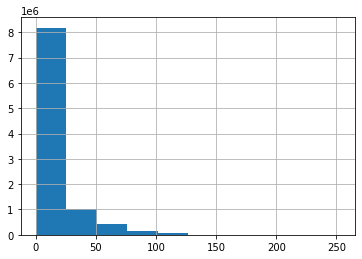

In [736]:
fin_res['dist'].hist()

In [742]:
fin_res['log_dist'] = np.log(fin_res['dist']+1)

In [744]:
fin_res['norm_dist'] = 1 - (fin_res['log_dist'] - fin_res['log_dist'].min())/ \
                            (fin_res['log_dist'].max()-fin_res['log_dist'].min())

In [748]:
fin_res['prob'] = fin_res['norm_dist']*fin_res['sim']

In [749]:
fin_res = fin_res.sort_values(['vac_1', 'rec_type', 'prob'], ascending=[True, True, False])

In [750]:
fin_res.head()

vac_1  vac_2       sim  rec_type                              id_1  \
8310774      0    182  0.815900         1  00000692db4bd3c5f0ba856117517c3f   
6123020      0    531  0.470037         1  00000692db4bd3c5f0ba856117517c3f   
8548541      0    329  0.468251         1  00000692db4bd3c5f0ba856117517c3f   
8994022      0    508  0.441170         1  00000692db4bd3c5f0ba856117517c3f   
9454855      0    125  0.378397         1  00000692db4bd3c5f0ba856117517c3f   

                       name_1         area_1      lat_1      lng_1  \
8310774  Оператор саll-центра  Нижневартовск  60.942933  76.460964   
6123020  Оператор саll-центра  Нижневартовск  60.942933  76.460964   
8548541  Оператор саll-центра  Нижневартовск  60.942933  76.460964   
8994022  Оператор саll-центра  Нижневартовск  60.942933  76.460964   
9454855  Оператор саll-центра  Нижневартовск  60.942933  76.460964   

                                     id_2  \
8310774  4f0874922c1f97685d11ee866ab090c4   
6123020  f1dd84c2f6cab1defd5772b7dd637af2   
8548541  96501a4b16bb00e81502bc61f8e88f0d   
8994022  e7522f052178ca83417d1bd2a8a1f546   
9454855  35085b6be0749ff16981ba7afc02d46c   

                                                    name_2         area_2  \
8310774                               Оператор саll-центра  Нижневартовск   
6123020      Оператор по добыче нефти и газа (4-5 разряда)  Нижневартовск   
8548541                   Оператор по исследованию скважин  Нижневартовск   
8994022                      Оператор дежурной части (ПЦН)  Нижневартовск   
9454855  Оператор обезвоживающей и обессоливающей устан...  Нижневартовск   

             lat_2      lng_2      dist  log_dist  norm_dist      prob  
8310774  60.942933  76.460964  0.000000  0.000000   1.000000  0.815900  
6123020  60.942933  76.460964  0.000000  0.000000   1.000000  0.470037  
8548541  60.942933  76.460964  0.000000  0.000000   1.000000  0.468251  
8994022  60.943378  76.520912  0.059949  0.058221   0.989487  0.436532  
9454855  60.942933  76.460964  0.000000  0.000000   1.000000  0.378397

In [751]:
fin_res['rnk'] = fin_res.groupby('vac_1').cumcount()+1
fin_fin_recs = fin_res[fin_res['rnk']<=20]

In [767]:
fin_fin_recs[fin_fin_recs['vac_1']==106800]

vac_1   vac_2       sim  rec_type                              id_1  \
5422641  106800  102439  0.615385         1  b1f9416b47fcf2476a3acff30a8b56c1   
8256497  106800  108112  0.563353         1  b1f9416b47fcf2476a3acff30a8b56c1   
5422659  106800  108084  0.563197         1  b1f9416b47fcf2476a3acff30a8b56c1   
5348012  106800  107642  0.546368         1  b1f9416b47fcf2476a3acff30a8b56c1   
5372870  106800  103506  0.538462         1  b1f9416b47fcf2476a3acff30a8b56c1   
5392525  106800  104520  0.541362         1  b1f9416b47fcf2476a3acff30a8b56c1   
5370622  106800  102362  0.545708         1  b1f9416b47fcf2476a3acff30a8b56c1   
8912891  106800  104379  0.538462         1  b1f9416b47fcf2476a3acff30a8b56c1   
5421542  106800  102708  0.513449         1  b1f9416b47fcf2476a3acff30a8b56c1   
5382138  106800  103463  0.518875         1  b1f9416b47fcf2476a3acff30a8b56c1   
5384921  106800  108486  0.511857         1  b1f9416b47fcf2476a3acff30a8b56c1   
8912970  106800  106414  0.508492         1  b1f9416b47fcf2476a3acff30a8b56c1   
5373688  106800  107940  0.513449         1  b1f9416b47fcf2476a3acff30a8b56c1   
5381465  106800  108649  0.545872         1  b1f9416b47fcf2476a3acff30a8b56c1   
5404064  106800  105592  0.505885         1  b1f9416b47fcf2476a3acff30a8b56c1   
5421430  106800  105369  0.484392         1  b1f9416b47fcf2476a3acff30a8b56c1   
5364888  106800  108699  0.493306         1  b1f9416b47fcf2476a3acff30a8b56c1   
5374896  106800  108654  0.496857         1  b1f9416b47fcf2476a3acff30a8b56c1   
5381094  106800  105247  0.485363         1  b1f9416b47fcf2476a3acff30a8b56c1   
5397640  106800  108420  0.481623         1  b1f9416b47fcf2476a3acff30a8b56c1   

                                                   name_1       area_1  \
5422641  Директор магазина (Новосибирск, ул Хилокская, 1)  Новосибирск   
8256497  Директор магазина (Новосибирск, ул Хилокская, 1)  Новосибирск   
5422659  Директор магазина (Новосибирск, ул Хилокская, 1)  Новосибирск   
5348012  Директор магазина (Новосибирск, ул Хилокская, 1)  Новосибирск   
5372870  Директор магазина (Новосибирск, ул Хилокская, 1)  Новосибирск   
5392525  Директор магазина (Новосибирск, ул Хилокская, 1)  Новосибирск   
5370622  Директор магазина (Новосибирск, ул Хилокская, 1)  Новосибирск   
8912891  Директор магазина (Новосибирск, ул Хилокская, 1)  Новосибирск   
5421542  Директор магазина (Новосибирск, ул Хилокская, 1)  Новосибирск   
5382138  Директор магазина (Новосибирск, ул Хилокская, 1)  Новосибирск   
5384921  Директор магазина (Новосибирск, ул Хилокская, 1)  Новосибирск   
8912970  Директор магазина (Новосибирск, ул Хилокская, 1)  Новосибирск   
5373688  Директор магазина (Новосибирск, ул Хилокская, 1)  Новосибирск   
5381465  Директор магазина (Новосибирск, ул Хилокская, 1)  Новосибирск   
5404064  Директор магазина (Новосибирск, ул Хилокская, 1)  Новосибирск   
5421430  Директор магазина (Новосибирск, ул Хилокская, 1)  Новосибирск   
5364888  Директор магазина (Новосибирск, ул Хилокская, 1)  Новосибирск   
5374896  Директор магазина (Новосибирск, ул Хилокская, 1)  Новосибирск   
5381094  Директор магазина (Новосибирск, ул Хилокская, 1)  Новосибирск   
5397640  Директор магазина (Новосибирск, ул Хилокская, 1)  Новосибирск   

             lat_1      lng_1                              id_2  \
5422641  54.950841  82.835455  080c2eaac6a91fcfc58904e1768a0572   
8256497  54.950841  82.835455  e55c1f9c270a9111ce7c86127f028f5e   
5422659  54.950841  82.835455  e444c16072d775199ae2e864a7970d8a   
5348012  54.950841  82.835455  d2d57c30f29e5f5acd9264ba41860ffd   
5372870  54.950841  82.835455  33c8347f1da7ec5fd79cfa49925f46d1   
5392525  54.950841  82.835455  59a95ff7f441888b4c74b463d1c7cdf6   
5370622  54.950841  82.835455  054f4d3c2b06a534a624c4a6b5b644e9   
8912891  54.950841  82.835455  54880afc5207eb30175cdc043c9af274   
5421542  54.950841  82.835455  12a2a5854e320b0f726a2cebdf8ba665   
5382138  54.950841  82.835455  324268d0b50a8ffc3dc3239af6f0a7f7   
5384921  54.9508

## leftovers

In [768]:
from scipy.spatial import distance_matrix

In [769]:
recs_done = set(fin_fin_recs.vac_1.unique())
idx_ = [x for x in df.index if x not in recs_done]

leftovers = fin_recs_df.loc[idx_, :]

In [770]:
leftovers.shape

(40146, 6)

In [779]:
dist = cosine_similarity(fin_feature_matrix[idx_], fin_feature_matrix) 

In [780]:
left_result = {}
np.fill_diagonal(dist, 0)
for i, row in enumerate(dist):
    vac_idx = idx_[i]
    vac_neighb = sorted([(v, k) for v, k in zip(row, idx_) if k!=vac_idx], reverse=True)[:20]
    if len(vac_neighb)!=0:
        left_result[vac_idx] = vac_neighb

In [798]:
tfidf_descr_rare = TfidfVectorizer(max_features=1000)
tfidf_descr_rare.fit((df['text_skills']+' '+df['text_name']).str.strip().loc[idx_])
descr_matrix = tfidf_descr_rare.transform((df['text_skills']+' '+df['text_name']).str.strip().values)

In [801]:
descr_matrix_rare = descr_matrix.todense()

In [821]:
dist2 = cosine_similarity(descr_matrix_rare[idx_], descr_matrix_rare) 

In [822]:
left_result_2 = {}
np.fill_diagonal(dist2, 0)
for i, row in enumerate(dist2):
    vac_idx = idx_[i]
    vac_neighb = sorted([(v, k) for v, k in zip(row, idx_) if k!=vac_idx], reverse=True)[:20]
    if len(vac_neighb)!=0:
        left_result_2[vac_idx] = vac_neighb

In [823]:
list(left_result_2.keys())[:10]

[3, 25, 30, 41, 46, 61, 64, 71, 80, 93]

In [832]:
left_result_2_2 = []
for k, v in left_result_2.items():
    for neighbr in v:
        left_result_2_2.append([k, neighbr[1], neighbr[0], 3])

In [840]:
fin_res_2 = pd.DataFrame(left_result_2_2)
fin_res_2.columns = ['vac_1', 'vac_2', 'sim', 'rec_type']

In [841]:
fin_res_2 = fin_res_2.merge(fin_recs_df, left_on='vac_1', right_on='index')\
       .drop('index', axis=1)\
       .rename(columns={'id': 'id_1', 'name': 'name_1', 'area.name': 'area_1', 'address.lat': 'lat_1', 'address.lng': 'lng_1'})\
       .merge(fin_recs_df, left_on='vac_2', right_on='index')\
       .drop('index', axis=1)\
       .rename(columns={'id': 'id_2', 'name': 'name_2', 'area.name': 'area_2', 'address.lat': 'lat_2', 'address.lng': 'lng_2'})

In [842]:
fin_res_2 = fin_res_2.sort_values(['vac_1', 'sim'], ascending=[True, False])
fin_res_2['rnk'] = fin_res_2.groupby('vac_1').cumcount()+1

In [845]:
fuh = pd.concat((fin_fin_recs[['id_1', 'id_2', 'rnk']], fin_res_2[['id_1', 'id_2', 'rnk']]))

In [863]:
result_dict = fuh[['id_1', 'id_2']].groupby('id_1').agg(lambda x: x.tolist()).to_dict(orient='index')

In [864]:
fin_dict = {}
for k, v in result_dict.items():
    fin_dict[k] = v['id_2']

In [865]:
import json
with open('/data/agoryach/datagym-recsys-01/result.json', 'w') as f:
    json.dump(fin_dict, f)